In [1]:
# -.-|m { output: false, input_fold: hide }
%load_ext pretty_jupyter

#Imports
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.data.experimental import cardinality
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras import Input, Model
# from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import numpy as np

# <div align="center" style="padding: 10px; font-weight: bold;">Introduction</div>

In this assignment, we will look into the detection of melanoma using a Convolutional Neural Network (CNN) by applying transfer learning with a pre-trained model. I decided using the <a href="https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset/" target="_blank"><b>🔬Melanoma Cancer Image Dataset</b></a>. It consists of 13 900 high-resolution images in test and train sets, both divided in two categorical fodlers - Benign and Malignant. The test folders comprise ot 1 000 photos each. The images are uniformly sized at 224 x 224 pixels.

The development of a CNN (Convolutional Neural Network) model for melanoma detection is motivated by the pressing need for accurate and efficient tools in the field of dermatology and healthcare. Melanoma, a type of skin cancer, poses significant health risks if not detected and treated early. However, manual diagnosis of melanoma by dermatologists can be time-consuming and prone to errors, leading to delays in treatment and potentially adverse outcomes for patients.

CNN models offer a promising solution by leveraging machine learning techniques to automatically analyze skin lesion images and identify potential signs of melanoma. These models can be trained on large datasets of annotated images, learning to recognize patterns and features indicative of melanoma with high accuracy.

For the choice of the pre-trained model I searched for previous uses and researches. Based on the performance comparison in the <a href="https://www.biorxiv.org/content/10.1101/2020.05.22.110973v3" target="_blank"><b>Sagar (2020)</b></a> research I decided to opt for the <a href="https://keras.io/api/applications/resnet/#resnet50v2-function" target="_blank"><b>ResNet50V2</b></a> model.

# <div align="center" style="padding: 10px; font-weight: bold;">Pre-process</div>

## Defining variables

In [2]:
TRAIN_PATH = 'data/train'
VAL_PATH = 'data/validation'
TEST_PATH = 'data/test'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

## Reading the datasets

In [4]:
train_ds = image_dataset_from_directory(
  TRAIN_PATH,
  image_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE
)

val_ds = image_dataset_from_directory(
  VAL_PATH,
  image_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE
)

test_ds = image_dataset_from_directory(
  TEST_PATH,
  image_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE
)

Found 11180 files belonging to 2 classes.
Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Benign', 'Malignant']


In [6]:
for data_batch, labels_batch in train_ds:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32,)


In [7]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1], dtype=int32)>

In [8]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Plotting images

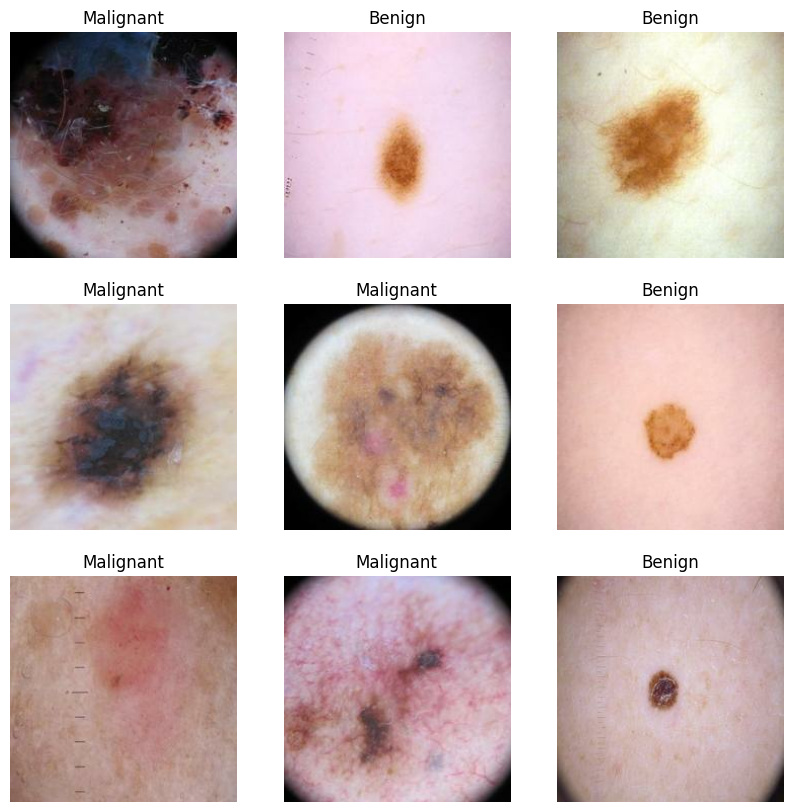

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data augmentation

We will apply some minor image transformation in order to expose the model to varying data examples in order to reduce overfitting. For this we use the RandomFlip and RandomRotation layers.

In [10]:
data_augmentation = Sequential([
  RandomFlip('horizontal'),
  RandomRotation(0.2),
])

## Image preprocessing

The ResNet50V2 model expects pixel values to be between -1 and 1. For this we will use the models <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/preprocess_input" target="_blank"><b>preprocess_input function</b></a> to prepare everything for us.

In [11]:
preprocess_input = preprocess_input

# <div align="center" style="padding: 10px; font-weight: bold;">Model</div>

## Creating the base model

Loading the ResNet50V2 model with the our datasets image size, without the classification layers at the top (which is ideal for feature extraction) and with the weights from the imagenet dataset training.

In [12]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)
base_model = ResNet50V2(input_shape=IMAGE_SHAPE,
                        include_top=False,
                        weights='imagenet')


We need to freeze the convolutional base before compiling and training the model to use it as a feature extractor afterwards. Since the model has many layers we set the trainable flag to `False` for the whole modle.

In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

This featuer extractor turns every `224x224x3` input image into a `7x7x2048` block of features.

In [15]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


## Classification head

To generate predictions from the block of features we need to average over the spatial 7x7 spatial locations, using a `GlobalAveragePooling2D` layer to convert the features to a single 2048-element vector per image.

In [16]:
global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


Subsequently, we employ a `Dense` layer to transform these features into a singular prediction for each image. We only have two classes so we will use the `sigmoid` function and will use the prediction as a raw prediction value. Positive values indicate a prediction for class 1, while negative values indicate a prediction for class 0.

In [17]:
prediction_layer = Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now we need to build a model that incorporates all the steps: data augmentation, preprocessing, `base_model` and feature extractor.
Because the model contains `BatchNormalization` layers, we need to set `training=False` for the base model so that the updates applied to the non-trainable weights do not destroy what the model has learned.

In [18]:
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

Now to see what the model looks like:

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

We can see that the ResNet50V2 parameters are frozen and we only have the 2 049 trainable ones from our Dense layer that are the weights and biases.

## Compiling the model

We need to compile before the training and since we have only two classes and a sigmoid raw value => we use `BinaryAccuracy` to determine the result. We use the `Adam` optimizer and a `learning_rate` or `0.0001`.

Using the legacy `Adam` optimizer as the new one runs slower on the M1 chip.

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy(threshold=0.5, name='accuracy')])

We start by training the model over 10 epochs.

In [21]:
# -.-|m { output: false }

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS)

Epoch 1/10


2024-04-01 15:22:29.278357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-04-01 15:22:29.583702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 11:12 - loss: 0.7630 - accuracy: 0.5312

2024-04-01 15:22:30.193991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 1:46 - loss: 0.7742 - accuracy: 0.5781 

2024-04-01 15:22:30.498755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 1:46 - loss: 0.8537 - accuracy: 0.5000

2024-04-01 15:22:30.806506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 1:44 - loss: 0.8263 - accuracy: 0.5000

2024-04-01 15:22:31.094943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 1:43 - loss: 0.7967 - accuracy: 0.5125

2024-04-01 15:22:31.395998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 1:42 - loss: 0.7715 - accuracy: 0.5312

2024-04-01 15:22:31.688315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 1:41 - loss: 0.8098 - accuracy: 0.5089

2024-04-01 15:22:31.972513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 1:41 - loss: 0.8208 - accuracy: 0.4961

2024-04-01 15:22:32.271581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 1:40 - loss: 0.8231 - accuracy: 0.4861

2024-04-01 15:22:32.557413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 1:40 - loss: 0.8170 - accuracy: 0.4938

2024-04-01 15:22:32.859294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 1:40 - loss: 0.8134 - accuracy: 0.4801

2024-04-01 15:22:33.146783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 1:39 - loss: 0.8079 - accuracy: 0.4818

2024-04-01 15:22:33.449711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 1:39 - loss: 0.8071 - accuracy: 0.4784

2024-04-01 15:22:33.739234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 1:39 - loss: 0.8105 - accuracy: 0.4732

2024-04-01 15:22:34.024198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 1:38 - loss: 0.8097 - accuracy: 0.4792

2024-04-01 15:22:34.324197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 1:38 - loss: 0.8018 - accuracy: 0.4863

2024-04-01 15:22:34.612002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 1:37 - loss: 0.7995 - accuracy: 0.4871

2024-04-01 15:22:34.899953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 1:37 - loss: 0.8036 - accuracy: 0.4809

2024-04-01 15:22:35.211814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 1:37 - loss: 0.8021 - accuracy: 0.4819

2024-04-01 15:22:35.509741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 1:37 - loss: 0.7965 - accuracy: 0.4875

2024-04-01 15:22:35.795710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 1:36 - loss: 0.7923 - accuracy: 0.4926

2024-04-01 15:22:36.082884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 1:36 - loss: 0.7918 - accuracy: 0.4943

2024-04-01 15:22:36.392829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 1:36 - loss: 0.7960 - accuracy: 0.4932

2024-04-01 15:22:36.679519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 1:36 - loss: 0.7995 - accuracy: 0.4961

2024-04-01 15:22:36.991347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 1:36 - loss: 0.7989 - accuracy: 0.4925

2024-04-01 15:22:37.292757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 1:35 - loss: 0.8011 - accuracy: 0.4880

2024-04-01 15:22:37.584541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 1:35 - loss: 0.7996 - accuracy: 0.4850

2024-04-01 15:22:37.897817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 1:35 - loss: 0.8004 - accuracy: 0.4855

2024-04-01 15:22:38.186513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 1:34 - loss: 0.8016 - accuracy: 0.4838

2024-04-01 15:22:38.472495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 1:34 - loss: 0.8058 - accuracy: 0.4812

2024-04-01 15:22:38.781651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 1:34 - loss: 0.8048 - accuracy: 0.4839

2024-04-01 15:22:39.071332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 1:34 - loss: 0.8042 - accuracy: 0.4844

2024-04-01 15:22:39.357826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 1:33 - loss: 0.8006 - accuracy: 0.4867

2024-04-01 15:22:39.668156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 1:33 - loss: 0.7983 - accuracy: 0.4890

2024-04-01 15:22:39.964240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 1:33 - loss: 0.7984 - accuracy: 0.4911

2024-04-01 15:22:40.258360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 1:33 - loss: 0.7956 - accuracy: 0.4931

2024-04-01 15:22:40.571290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 1:32 - loss: 0.7970 - accuracy: 0.4924

2024-04-01 15:22:40.865699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 1:32 - loss: 0.7939 - accuracy: 0.4942

2024-04-01 15:22:41.159935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 1:32 - loss: 0.7910 - accuracy: 0.4952

2024-04-01 15:22:41.472508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 1:31 - loss: 0.7900 - accuracy: 0.4945

2024-04-01 15:22:41.764258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 1:31 - loss: 0.7896 - accuracy: 0.4939

2024-04-01 15:22:42.046807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 1:31 - loss: 0.7880 - accuracy: 0.4948

2024-04-01 15:22:42.350559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 1:31 - loss: 0.7871 - accuracy: 0.4949

2024-04-01 15:22:42.655420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 1:30 - loss: 0.7861 - accuracy: 0.4964

2024-04-01 15:22:42.963834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 1:30 - loss: 0.7868 - accuracy: 0.4986

2024-04-01 15:22:43.257291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 1:30 - loss: 0.7861 - accuracy: 0.5007

2024-04-01 15:22:43.544006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 1:29 - loss: 0.7852 - accuracy: 0.5027

2024-04-01 15:22:43.846303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 1:29 - loss: 0.7835 - accuracy: 0.5052

2024-04-01 15:22:44.141915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 1:29 - loss: 0.7802 - accuracy: 0.5077

2024-04-01 15:22:44.429729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 1:28 - loss: 0.7775 - accuracy: 0.5106

2024-04-01 15:22:44.735417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 1:28 - loss: 0.7753 - accuracy: 0.5129

2024-04-01 15:22:45.034289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 1:28 - loss: 0.7746 - accuracy: 0.5132

2024-04-01 15:22:45.320993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 1:28 - loss: 0.7758 - accuracy: 0.5130

2024-04-01 15:22:45.618568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 1:27 - loss: 0.7732 - accuracy: 0.5145

2024-04-01 15:22:45.911173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 1:27 - loss: 0.7731 - accuracy: 0.5131

2024-04-01 15:22:46.197347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 1:27 - loss: 0.7730 - accuracy: 0.5140

2024-04-01 15:22:46.499111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 1:26 - loss: 0.7714 - accuracy: 0.5148

2024-04-01 15:22:46.790968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 1:26 - loss: 0.7690 - accuracy: 0.5178

2024-04-01 15:22:47.077263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 1:26 - loss: 0.7670 - accuracy: 0.5201

2024-04-01 15:22:47.377052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 1:25 - loss: 0.7685 - accuracy: 0.5198

2024-04-01 15:22:47.668212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 1:25 - loss: 0.7690 - accuracy: 0.5184

2024-04-01 15:22:47.950831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 1:25 - loss: 0.7678 - accuracy: 0.5207

2024-04-01 15:22:48.247396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 1:24 - loss: 0.7676 - accuracy: 0.5223

2024-04-01 15:22:48.539555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 1:24 - loss: 0.7662 - accuracy: 0.5225

2024-04-01 15:22:48.824448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 1:24 - loss: 0.7668 - accuracy: 0.5231

2024-04-01 15:22:49.126298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 1:23 - loss: 0.7646 - accuracy: 0.5246

2024-04-01 15:22:49.413162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 1:23 - loss: 0.7635 - accuracy: 0.5247

2024-04-01 15:22:49.695919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 1:23 - loss: 0.7627 - accuracy: 0.5262

2024-04-01 15:22:49.995397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 1:23 - loss: 0.7620 - accuracy: 0.5272

2024-04-01 15:22:50.291312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 1:22 - loss: 0.7610 - accuracy: 0.5277

2024-04-01 15:22:50.575925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 1:22 - loss: 0.7613 - accuracy: 0.5282

2024-04-01 15:22:50.875960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 1:22 - loss: 0.7613 - accuracy: 0.5282

2024-04-01 15:22:51.164604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 1:21 - loss: 0.7603 - accuracy: 0.5295

2024-04-01 15:22:51.453428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 1:21 - loss: 0.7590 - accuracy: 0.5304

2024-04-01 15:22:51.768106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 1:21 - loss: 0.7577 - accuracy: 0.5321

2024-04-01 15:22:52.072708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 1:20 - loss: 0.7563 - accuracy: 0.5329

2024-04-01 15:22:52.358769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 1:20 - loss: 0.7548 - accuracy: 0.5333

2024-04-01 15:22:52.660791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 1:20 - loss: 0.7532 - accuracy: 0.5341

2024-04-01 15:22:52.948890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 1:20 - loss: 0.7528 - accuracy: 0.5352

2024-04-01 15:22:53.233142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 1:19 - loss: 0.7520 - accuracy: 0.5367

2024-04-01 15:22:53.534165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 1:19 - loss: 0.7498 - accuracy: 0.5397

2024-04-01 15:22:53.825034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 1:19 - loss: 0.7488 - accuracy: 0.5400

2024-04-01 15:22:54.111661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 1:18 - loss: 0.7487 - accuracy: 0.5403

2024-04-01 15:22:54.417631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 1:18 - loss: 0.7504 - accuracy: 0.5402

2024-04-01 15:22:54.729988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 1:18 - loss: 0.7490 - accuracy: 0.5423

2024-04-01 15:22:55.027715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 1:18 - loss: 0.7490 - accuracy: 0.5418

2024-04-01 15:22:55.346771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 1:17 - loss: 0.7475 - accuracy: 0.5427

2024-04-01 15:22:55.654212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 1:17 - loss: 0.7476 - accuracy: 0.5430

2024-04-01 15:22:55.941391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 1:17 - loss: 0.7459 - accuracy: 0.5439

2024-04-01 15:22:56.244796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 1:16 - loss: 0.7456 - accuracy: 0.5448

2024-04-01 15:22:56.531579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 1:16 - loss: 0.7453 - accuracy: 0.5446

2024-04-01 15:22:56.829608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 1:16 - loss: 0.7447 - accuracy: 0.5455

2024-04-01 15:22:57.127066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 1:16 - loss: 0.7433 - accuracy: 0.5464

2024-04-01 15:22:57.411201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 1:15 - loss: 0.7430 - accuracy: 0.5479

2024-04-01 15:22:57.724719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 1:15 - loss: 0.7405 - accuracy: 0.5503

2024-04-01 15:22:58.027700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 1:15 - loss: 0.7391 - accuracy: 0.5518

2024-04-01 15:22:58.355762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:15 - loss: 0.7380 - accuracy: 0.5532

2024-04-01 15:22:58.653105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:14 - loss: 0.7361 - accuracy: 0.5552

2024-04-01 15:22:58.958100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:14 - loss: 0.7347 - accuracy: 0.5559

2024-04-01 15:22:59.279191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:14 - loss: 0.7333 - accuracy: 0.5562

2024-04-01 15:22:59.569262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:13 - loss: 0.7327 - accuracy: 0.5566

2024-04-01 15:22:59.876656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:13 - loss: 0.7320 - accuracy: 0.5576

2024-04-01 15:23:00.166475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:13 - loss: 0.7321 - accuracy: 0.5567

2024-04-01 15:23:00.452642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:12 - loss: 0.7316 - accuracy: 0.5574

2024-04-01 15:23:00.755881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:12 - loss: 0.7305 - accuracy: 0.5586

2024-04-01 15:23:01.047346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:12 - loss: 0.7292 - accuracy: 0.5596

2024-04-01 15:23:01.330295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:12 - loss: 0.7300 - accuracy: 0.5596

2024-04-01 15:23:01.634768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:11 - loss: 0.7291 - accuracy: 0.5602

2024-04-01 15:23:01.931513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:11 - loss: 0.7271 - accuracy: 0.5616

2024-04-01 15:23:02.217058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:11 - loss: 0.7256 - accuracy: 0.5631

2024-04-01 15:23:02.519129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:10 - loss: 0.7239 - accuracy: 0.5650

2024-04-01 15:23:02.815094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:10 - loss: 0.7223 - accuracy: 0.5664

2024-04-01 15:23:03.102201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:10 - loss: 0.7203 - accuracy: 0.5683

2024-04-01 15:23:03.386649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:09 - loss: 0.7204 - accuracy: 0.5691

2024-04-01 15:23:03.692594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:09 - loss: 0.7195 - accuracy: 0.5701

2024-04-01 15:23:03.975311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:09 - loss: 0.7195 - accuracy: 0.5700

2024-04-01 15:23:04.257537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:09 - loss: 0.7190 - accuracy: 0.5708

2024-04-01 15:23:04.558469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:08 - loss: 0.7174 - accuracy: 0.5726

2024-04-01 15:23:04.842627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:08 - loss: 0.7159 - accuracy: 0.5735

2024-04-01 15:23:05.125817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:08 - loss: 0.7173 - accuracy: 0.5724

2024-04-01 15:23:05.430108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:07 - loss: 0.7176 - accuracy: 0.5721

2024-04-01 15:23:05.715574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:07 - loss: 0.7172 - accuracy: 0.5717

2024-04-01 15:23:06.008128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:07 - loss: 0.7158 - accuracy: 0.5734

2024-04-01 15:23:06.308477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:06 - loss: 0.7153 - accuracy: 0.5741

2024-04-01 15:23:06.592187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:06 - loss: 0.7149 - accuracy: 0.5735

2024-04-01 15:23:06.874982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:06 - loss: 0.7144 - accuracy: 0.5734

2024-04-01 15:23:07.176709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:05 - loss: 0.7141 - accuracy: 0.5736

2024-04-01 15:23:07.458313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:05 - loss: 0.7137 - accuracy: 0.5737

2024-04-01 15:23:07.743105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:05 - loss: 0.7129 - accuracy: 0.5741

2024-04-01 15:23:08.046550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:05 - loss: 0.7121 - accuracy: 0.5740

2024-04-01 15:23:08.328838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:04 - loss: 0.7109 - accuracy: 0.5751

2024-04-01 15:23:08.612999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:04 - loss: 0.7099 - accuracy: 0.5760

2024-04-01 15:23:08.914291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:04 - loss: 0.7096 - accuracy: 0.5768

2024-04-01 15:23:09.196601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:03 - loss: 0.7091 - accuracy: 0.5781

2024-04-01 15:23:09.479853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:03 - loss: 0.7079 - accuracy: 0.5787

2024-04-01 15:23:09.783695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:03 - loss: 0.7071 - accuracy: 0.5795

2024-04-01 15:23:10.068705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:02 - loss: 0.7067 - accuracy: 0.5801

2024-04-01 15:23:10.351648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:02 - loss: 0.7060 - accuracy: 0.5806

2024-04-01 15:23:10.654799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:02 - loss: 0.7046 - accuracy: 0.5818

2024-04-01 15:23:10.938685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:01 - loss: 0.7031 - accuracy: 0.5830

2024-04-01 15:23:11.227561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:01 - loss: 0.7027 - accuracy: 0.5829

2024-04-01 15:23:11.531941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:01 - loss: 0.7019 - accuracy: 0.5836

2024-04-01 15:23:11.813717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:01 - loss: 0.7011 - accuracy: 0.5846

2024-04-01 15:23:12.097970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:00 - loss: 0.7001 - accuracy: 0.5853

2024-04-01 15:23:12.397609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:00 - loss: 0.6992 - accuracy: 0.5862

2024-04-01 15:23:12.678733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:00 - loss: 0.6998 - accuracy: 0.5856

2024-04-01 15:23:12.961787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 59s - loss: 0.6986 - accuracy: 0.5867 

2024-04-01 15:23:13.263439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 59s - loss: 0.6972 - accuracy: 0.5876

2024-04-01 15:23:13.547811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 59s - loss: 0.6958 - accuracy: 0.5885

2024-04-01 15:23:13.829918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 58s - loss: 0.6950 - accuracy: 0.5890

2024-04-01 15:23:14.134849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 58s - loss: 0.6954 - accuracy: 0.5890

2024-04-01 15:23:14.419270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 58s - loss: 0.6947 - accuracy: 0.5894

2024-04-01 15:23:14.703590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 58s - loss: 0.6939 - accuracy: 0.5907

2024-04-01 15:23:15.003608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 57s - loss: 0.6938 - accuracy: 0.5901

2024-04-01 15:23:15.288996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 57s - loss: 0.6935 - accuracy: 0.5905

2024-04-01 15:23:15.573867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 57s - loss: 0.6923 - accuracy: 0.5917

2024-04-01 15:23:15.876839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 56s - loss: 0.6915 - accuracy: 0.5926

2024-04-01 15:23:16.165137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 56s - loss: 0.6905 - accuracy: 0.5936

2024-04-01 15:23:16.449299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 56s - loss: 0.6884 - accuracy: 0.5955

2024-04-01 15:23:16.751212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 55s - loss: 0.6875 - accuracy: 0.5965

2024-04-01 15:23:17.035996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 55s - loss: 0.6869 - accuracy: 0.5970

2024-04-01 15:23:17.319586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 55s - loss: 0.6855 - accuracy: 0.5982

2024-04-01 15:23:17.622146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 55s - loss: 0.6846 - accuracy: 0.5989

2024-04-01 15:23:17.904075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 54s - loss: 0.6839 - accuracy: 0.5993

2024-04-01 15:23:18.192950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 54s - loss: 0.6836 - accuracy: 0.6002

2024-04-01 15:23:18.494699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 54s - loss: 0.6826 - accuracy: 0.6015

2024-04-01 15:23:18.778526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 53s - loss: 0.6815 - accuracy: 0.6025

2024-04-01 15:23:19.062039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 53s - loss: 0.6814 - accuracy: 0.6029

2024-04-01 15:23:19.362533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 53s - loss: 0.6809 - accuracy: 0.6036

2024-04-01 15:23:19.649050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 52s - loss: 0.6797 - accuracy: 0.6046

2024-04-01 15:23:19.934536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 52s - loss: 0.6792 - accuracy: 0.6049

2024-04-01 15:23:20.235626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 52s - loss: 0.6782 - accuracy: 0.6057

2024-04-01 15:23:20.525582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 52s - loss: 0.6772 - accuracy: 0.6064

2024-04-01 15:23:20.810114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 51s - loss: 0.6769 - accuracy: 0.6067

2024-04-01 15:23:21.112756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 51s - loss: 0.6772 - accuracy: 0.6073

2024-04-01 15:23:21.397777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 51s - loss: 0.6762 - accuracy: 0.6085

2024-04-01 15:23:21.684531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 50s - loss: 0.6755 - accuracy: 0.6088

2024-04-01 15:23:21.988900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 50s - loss: 0.6766 - accuracy: 0.6085

2024-04-01 15:23:22.279448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 50s - loss: 0.6761 - accuracy: 0.6091

2024-04-01 15:23:22.570150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 50s - loss: 0.6753 - accuracy: 0.6101

2024-04-01 15:23:22.874524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 49s - loss: 0.6751 - accuracy: 0.6102

2024-04-01 15:23:23.168031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 49s - loss: 0.6747 - accuracy: 0.6104

2024-04-01 15:23:23.455461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 49s - loss: 0.6745 - accuracy: 0.6101

2024-04-01 15:23:23.763485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 48s - loss: 0.6736 - accuracy: 0.6111

2024-04-01 15:23:24.052943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 48s - loss: 0.6730 - accuracy: 0.6115

2024-04-01 15:23:24.340893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 48s - loss: 0.6723 - accuracy: 0.6119

2024-04-01 15:23:24.648644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 47s - loss: 0.6711 - accuracy: 0.6128

2024-04-01 15:23:24.934928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 47s - loss: 0.6702 - accuracy: 0.6134

2024-04-01 15:23:25.218849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 47s - loss: 0.6700 - accuracy: 0.6143

2024-04-01 15:23:25.525535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 47s - loss: 0.6696 - accuracy: 0.6145

2024-04-01 15:23:25.813583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 46s - loss: 0.6680 - accuracy: 0.6160

2024-04-01 15:23:26.100410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 46s - loss: 0.6669 - accuracy: 0.6167

2024-04-01 15:23:26.409430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 46s - loss: 0.6661 - accuracy: 0.6176

2024-04-01 15:23:26.696208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 45s - loss: 0.6655 - accuracy: 0.6179

2024-04-01 15:23:26.987777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 45s - loss: 0.6646 - accuracy: 0.6186

2024-04-01 15:23:27.308449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 45s - loss: 0.6641 - accuracy: 0.6191

2024-04-01 15:23:27.598605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 45s - loss: 0.6635 - accuracy: 0.6201

2024-04-01 15:23:27.888382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 44s - loss: 0.6636 - accuracy: 0.6203

2024-04-01 15:23:28.195325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 44s - loss: 0.6627 - accuracy: 0.6217

2024-04-01 15:23:28.487060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 44s - loss: 0.6619 - accuracy: 0.6223

2024-04-01 15:23:28.777124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 43s - loss: 0.6612 - accuracy: 0.6231

2024-04-01 15:23:29.082800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 43s - loss: 0.6612 - accuracy: 0.6235

2024-04-01 15:23:29.372805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 43s - loss: 0.6611 - accuracy: 0.6233

2024-04-01 15:23:29.661173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 42s - loss: 0.6601 - accuracy: 0.6247

2024-04-01 15:23:29.971239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 42s - loss: 0.6593 - accuracy: 0.6253

2024-04-01 15:23:30.258909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 42s - loss: 0.6586 - accuracy: 0.6258

2024-04-01 15:23:30.553812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 42s - loss: 0.6581 - accuracy: 0.6264

2024-04-01 15:23:30.864865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 41s - loss: 0.6572 - accuracy: 0.6270

2024-04-01 15:23:31.153149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 41s - loss: 0.6574 - accuracy: 0.6266

2024-04-01 15:23:31.446802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 41s - loss: 0.6572 - accuracy: 0.6269

2024-04-01 15:23:31.758411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 40s - loss: 0.6565 - accuracy: 0.6272

2024-04-01 15:23:32.046549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 40s - loss: 0.6556 - accuracy: 0.6279

2024-04-01 15:23:32.335875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 40s - loss: 0.6547 - accuracy: 0.6288

2024-04-01 15:23:32.651886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 40s - loss: 0.6537 - accuracy: 0.6297

2024-04-01 15:23:32.940946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 39s - loss: 0.6537 - accuracy: 0.6302

2024-04-01 15:23:33.231086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 39s - loss: 0.6534 - accuracy: 0.6308

2024-04-01 15:23:33.541628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 39s - loss: 0.6527 - accuracy: 0.6310

2024-04-01 15:23:33.831891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 38s - loss: 0.6519 - accuracy: 0.6316

2024-04-01 15:23:34.127896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 38s - loss: 0.6518 - accuracy: 0.6318

2024-04-01 15:23:34.438152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 38s - loss: 0.6515 - accuracy: 0.6320

2024-04-01 15:23:34.730679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 38s - loss: 0.6508 - accuracy: 0.6325

2024-04-01 15:23:35.019879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 37s - loss: 0.6499 - accuracy: 0.6330

2024-04-01 15:23:35.331212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 37s - loss: 0.6498 - accuracy: 0.6333

2024-04-01 15:23:35.622845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 37s - loss: 0.6491 - accuracy: 0.6339

2024-04-01 15:23:35.911119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 36s - loss: 0.6491 - accuracy: 0.6343

2024-04-01 15:23:36.230154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 36s - loss: 0.6486 - accuracy: 0.6350

2024-04-01 15:23:36.522780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 36s - loss: 0.6482 - accuracy: 0.6355

2024-04-01 15:23:36.820351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 35s - loss: 0.6480 - accuracy: 0.6357

2024-04-01 15:23:37.132797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 35s - loss: 0.6479 - accuracy: 0.6358

2024-04-01 15:23:37.423583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 35s - loss: 0.6480 - accuracy: 0.6353

2024-04-01 15:23:37.711439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 35s - loss: 0.6475 - accuracy: 0.6358

2024-04-01 15:23:38.026576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 34s - loss: 0.6464 - accuracy: 0.6370

2024-04-01 15:23:38.318840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 34s - loss: 0.6456 - accuracy: 0.6379

2024-04-01 15:23:38.611026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 34s - loss: 0.6456 - accuracy: 0.6381

2024-04-01 15:23:38.924593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 33s - loss: 0.6449 - accuracy: 0.6390

2024-04-01 15:23:39.219914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 33s - loss: 0.6445 - accuracy: 0.6394

2024-04-01 15:23:39.510615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 33s - loss: 0.6440 - accuracy: 0.6399

2024-04-01 15:23:39.821451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 33s - loss: 0.6434 - accuracy: 0.6402

2024-04-01 15:23:40.112780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 32s - loss: 0.6436 - accuracy: 0.6404

2024-04-01 15:23:40.402887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 32s - loss: 0.6426 - accuracy: 0.6413

2024-04-01 15:23:40.719541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 32s - loss: 0.6421 - accuracy: 0.6419

2024-04-01 15:23:41.016617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 31s - loss: 0.6410 - accuracy: 0.6427

2024-04-01 15:23:41.309116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 31s - loss: 0.6406 - accuracy: 0.6431

2024-04-01 15:23:41.626602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 31s - loss: 0.6402 - accuracy: 0.6434

2024-04-01 15:23:41.922879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 30s - loss: 0.6400 - accuracy: 0.6443

2024-04-01 15:23:42.213519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 30s - loss: 0.6394 - accuracy: 0.6447

2024-04-01 15:23:42.525445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 30s - loss: 0.6385 - accuracy: 0.6454

2024-04-01 15:23:42.823118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 30s - loss: 0.6381 - accuracy: 0.6458

2024-04-01 15:23:43.115486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 29s - loss: 0.6375 - accuracy: 0.6463

2024-04-01 15:23:43.427950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 29s - loss: 0.6369 - accuracy: 0.6466

2024-04-01 15:23:43.722732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 29s - loss: 0.6366 - accuracy: 0.6468

2024-04-01 15:23:44.007978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 28s - loss: 0.6360 - accuracy: 0.6472

2024-04-01 15:23:44.293851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 28s - loss: 0.6355 - accuracy: 0.6479

2024-04-01 15:23:44.583504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 28s - loss: 0.6350 - accuracy: 0.6480

2024-04-01 15:23:44.895373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 28s - loss: 0.6344 - accuracy: 0.6482

2024-04-01 15:23:45.181623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 27s - loss: 0.6337 - accuracy: 0.6484

2024-04-01 15:23:45.463975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 27s - loss: 0.6330 - accuracy: 0.6492

2024-04-01 15:23:45.751251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 27s - loss: 0.6322 - accuracy: 0.6498

2024-04-01 15:23:46.042823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 26s - loss: 0.6313 - accuracy: 0.6506

2024-04-01 15:23:46.334219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 26s - loss: 0.6313 - accuracy: 0.6507

2024-04-01 15:23:46.623657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 26s - loss: 0.6306 - accuracy: 0.6513

2024-04-01 15:23:46.913923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 25s - loss: 0.6304 - accuracy: 0.6517

2024-04-01 15:23:47.225980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 25s - loss: 0.6296 - accuracy: 0.6522

2024-04-01 15:23:47.510581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 25s - loss: 0.6290 - accuracy: 0.6528

2024-04-01 15:23:47.795399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 25s - loss: 0.6284 - accuracy: 0.6534

2024-04-01 15:23:48.084940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 24s - loss: 0.6277 - accuracy: 0.6540

2024-04-01 15:23:48.374453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 24s - loss: 0.6271 - accuracy: 0.6546

2024-04-01 15:23:48.664525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 24s - loss: 0.6269 - accuracy: 0.6550

2024-04-01 15:23:48.959860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 23s - loss: 0.6266 - accuracy: 0.6553

2024-04-01 15:23:49.247817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 23s - loss: 0.6261 - accuracy: 0.6556

2024-04-01 15:23:49.562326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 23s - loss: 0.6255 - accuracy: 0.6560

2024-04-01 15:23:49.848493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 23s - loss: 0.6251 - accuracy: 0.6562

2024-04-01 15:23:50.136604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 22s - loss: 0.6245 - accuracy: 0.6566

2024-04-01 15:23:50.422537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 22s - loss: 0.6239 - accuracy: 0.6570

2024-04-01 15:23:50.708730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 22s - loss: 0.6240 - accuracy: 0.6573

2024-04-01 15:23:50.997513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 21s - loss: 0.6233 - accuracy: 0.6578

2024-04-01 15:23:51.283795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 21s - loss: 0.6226 - accuracy: 0.6584

2024-04-01 15:23:51.569422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 21s - loss: 0.6224 - accuracy: 0.6583

2024-04-01 15:23:51.878736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 20s - loss: 0.6225 - accuracy: 0.6584

2024-04-01 15:23:52.166052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 20s - loss: 0.6226 - accuracy: 0.6581

2024-04-01 15:23:52.452305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 20s - loss: 0.6225 - accuracy: 0.6583

2024-04-01 15:23:52.741510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 20s - loss: 0.6217 - accuracy: 0.6587

2024-04-01 15:23:53.034488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 19s - loss: 0.6215 - accuracy: 0.6590

2024-04-01 15:23:53.324681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 19s - loss: 0.6210 - accuracy: 0.6596

2024-04-01 15:23:53.608617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 19s - loss: 0.6203 - accuracy: 0.6600

2024-04-01 15:23:53.895731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 18s - loss: 0.6199 - accuracy: 0.6604

2024-04-01 15:23:54.201570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 18s - loss: 0.6194 - accuracy: 0.6608

2024-04-01 15:23:54.487666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 18s - loss: 0.6186 - accuracy: 0.6613

2024-04-01 15:23:54.773557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 17s - loss: 0.6185 - accuracy: 0.6613

2024-04-01 15:23:55.061219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 17s - loss: 0.6183 - accuracy: 0.6614

2024-04-01 15:23:55.351042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 17s - loss: 0.6183 - accuracy: 0.6617

2024-04-01 15:23:55.638444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 17s - loss: 0.6179 - accuracy: 0.6621

2024-04-01 15:23:55.927631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 16s - loss: 0.6182 - accuracy: 0.6622

2024-04-01 15:23:56.241533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 16s - loss: 0.6177 - accuracy: 0.6625

2024-04-01 15:23:56.539367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 16s - loss: 0.6168 - accuracy: 0.6631

2024-04-01 15:23:56.827319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 15s - loss: 0.6162 - accuracy: 0.6636

2024-04-01 15:23:57.114213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 15s - loss: 0.6161 - accuracy: 0.6639

2024-04-01 15:23:57.403373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 15s - loss: 0.6162 - accuracy: 0.6634

2024-04-01 15:23:57.692329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 15s - loss: 0.6155 - accuracy: 0.6639

2024-04-01 15:23:57.981806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 14s - loss: 0.6148 - accuracy: 0.6647

2024-04-01 15:23:58.270517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 14s - loss: 0.6147 - accuracy: 0.6648

2024-04-01 15:23:58.580168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 14s - loss: 0.6145 - accuracy: 0.6649

2024-04-01 15:23:58.874946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 13s - loss: 0.6140 - accuracy: 0.6654

2024-04-01 15:23:59.162381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 13s - loss: 0.6136 - accuracy: 0.6658

2024-04-01 15:23:59.455334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 13s - loss: 0.6135 - accuracy: 0.6660

2024-04-01 15:23:59.744591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 12s - loss: 0.6134 - accuracy: 0.6662

2024-04-01 15:24:00.034317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 12s - loss: 0.6129 - accuracy: 0.6664

2024-04-01 15:24:00.324347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 12s - loss: 0.6125 - accuracy: 0.6668

2024-04-01 15:24:00.613574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 12s - loss: 0.6124 - accuracy: 0.6670

2024-04-01 15:24:00.917140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 11s - loss: 0.6123 - accuracy: 0.6670

2024-04-01 15:24:01.211527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 11s - loss: 0.6116 - accuracy: 0.6674

2024-04-01 15:24:01.500749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 11s - loss: 0.6118 - accuracy: 0.6674

2024-04-01 15:24:01.790659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 10s - loss: 0.6110 - accuracy: 0.6679

2024-04-01 15:24:02.080097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 10s - loss: 0.6108 - accuracy: 0.6680

2024-04-01 15:24:02.368001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 10s - loss: 0.6108 - accuracy: 0.6680

2024-04-01 15:24:02.657381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 10s - loss: 0.6106 - accuracy: 0.6679

2024-04-01 15:24:02.947105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 9s - loss: 0.6103 - accuracy: 0.6683 

2024-04-01 15:24:03.259329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 9s - loss: 0.6105 - accuracy: 0.6681

2024-04-01 15:24:03.554918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 9s - loss: 0.6101 - accuracy: 0.6682

2024-04-01 15:24:03.848680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 8s - loss: 0.6101 - accuracy: 0.6681

2024-04-01 15:24:04.142780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 8s - loss: 0.6094 - accuracy: 0.6684

2024-04-01 15:24:04.434376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 8s - loss: 0.6093 - accuracy: 0.6684

2024-04-01 15:24:04.730140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 7s - loss: 0.6092 - accuracy: 0.6684

2024-04-01 15:24:05.027565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 7s - loss: 0.6085 - accuracy: 0.6690

2024-04-01 15:24:05.340603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 7s - loss: 0.6084 - accuracy: 0.6692

2024-04-01 15:24:05.644097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 7s - loss: 0.6079 - accuracy: 0.6697

2024-04-01 15:24:05.933813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 6s - loss: 0.6074 - accuracy: 0.6699

2024-04-01 15:24:06.225410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 6s - loss: 0.6071 - accuracy: 0.6700

2024-04-01 15:24:06.515329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 6s - loss: 0.6068 - accuracy: 0.6702

2024-04-01 15:24:06.809612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 5s - loss: 0.6062 - accuracy: 0.6707

2024-04-01 15:24:07.103551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 5s - loss: 0.6059 - accuracy: 0.6710

2024-04-01 15:24:07.395873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 5s - loss: 0.6056 - accuracy: 0.6711

2024-04-01 15:24:07.707544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 5s - loss: 0.6053 - accuracy: 0.6716

2024-04-01 15:24:08.007597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 4s - loss: 0.6048 - accuracy: 0.6722

2024-04-01 15:24:08.300008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 4s - loss: 0.6043 - accuracy: 0.6725

2024-04-01 15:24:08.592559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 4s - loss: 0.6040 - accuracy: 0.6726

2024-04-01 15:24:08.885070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 3s - loss: 0.6038 - accuracy: 0.6728

2024-04-01 15:24:09.179175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 3s - loss: 0.6034 - accuracy: 0.6734

2024-04-01 15:24:09.475419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 3s - loss: 0.6037 - accuracy: 0.6732

2024-04-01 15:24:09.792222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 2s - loss: 0.6034 - accuracy: 0.6734

2024-04-01 15:24:10.089589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 2s - loss: 0.6031 - accuracy: 0.6738

2024-04-01 15:24:10.383450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 2s - loss: 0.6026 - accuracy: 0.6741

2024-04-01 15:24:10.675438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 2s - loss: 0.6022 - accuracy: 0.6744

2024-04-01 15:24:10.969742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 1s - loss: 0.6024 - accuracy: 0.6744

2024-04-01 15:24:11.263663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 1s - loss: 0.6022 - accuracy: 0.6748

2024-04-01 15:24:11.557973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.6017 - accuracy: 0.6753

2024-04-01 15:24:11.886169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 0s - loss: 0.6013 - accuracy: 0.6756

2024-04-01 15:24:12.202683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.6006 - accuracy: 0.6760

2024-04-01 15:24:12.507215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.5998 - accuracy: 0.6766

2024-04-01 15:24:12.805037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 120s 338ms/step - loss: 0.5999 - accuracy: 0.6765 - val_loss: 0.4827 - val_accuracy: 0.7919
Epoch 2/10


2024-04-01 15:24:28.104464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 2:05 - loss: 0.6660 - accuracy: 0.5938

2024-04-01 15:24:28.466905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 1:44 - loss: 0.5439 - accuracy: 0.7031

2024-04-01 15:24:28.768388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 1:43 - loss: 0.5162 - accuracy: 0.7500

2024-04-01 15:24:29.063498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 1:43 - loss: 0.4970 - accuracy: 0.7578

2024-04-01 15:24:29.361317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 1:42 - loss: 0.4874 - accuracy: 0.7563

2024-04-01 15:24:29.659818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 1:42 - loss: 0.5009 - accuracy: 0.7292

2024-04-01 15:24:29.955293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 1:43 - loss: 0.4840 - accuracy: 0.7545

2024-04-01 15:24:30.283726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 1:44 - loss: 0.4737 - accuracy: 0.7656

2024-04-01 15:24:30.607269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 1:44 - loss: 0.4737 - accuracy: 0.7674

2024-04-01 15:24:30.910151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 1:43 - loss: 0.4607 - accuracy: 0.7781

2024-04-01 15:24:31.203016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 1:42 - loss: 0.4700 - accuracy: 0.7699

2024-04-01 15:24:31.499877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 1:42 - loss: 0.4640 - accuracy: 0.7734

2024-04-01 15:24:31.798362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 1:41 - loss: 0.4651 - accuracy: 0.7788

2024-04-01 15:24:32.097546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 1:41 - loss: 0.4675 - accuracy: 0.7723

2024-04-01 15:24:32.401586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 1:41 - loss: 0.4653 - accuracy: 0.7729

2024-04-01 15:24:32.701701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 1:40 - loss: 0.4668 - accuracy: 0.7754

2024-04-01 15:24:32.996677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 1:40 - loss: 0.4637 - accuracy: 0.7757

2024-04-01 15:24:33.316599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 1:40 - loss: 0.4640 - accuracy: 0.7743

2024-04-01 15:24:33.618255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 1:40 - loss: 0.4686 - accuracy: 0.7714

2024-04-01 15:24:33.918053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 1:39 - loss: 0.4708 - accuracy: 0.7703

2024-04-01 15:24:34.216298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 1:39 - loss: 0.4743 - accuracy: 0.7664

2024-04-01 15:24:34.519417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 1:39 - loss: 0.4759 - accuracy: 0.7656

2024-04-01 15:24:34.818699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 1:38 - loss: 0.4739 - accuracy: 0.7690

2024-04-01 15:24:35.125935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 1:38 - loss: 0.4749 - accuracy: 0.7669

2024-04-01 15:24:35.447259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 1:39 - loss: 0.4713 - accuracy: 0.7713

2024-04-01 15:24:35.782953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 1:38 - loss: 0.4691 - accuracy: 0.7764

2024-04-01 15:24:36.083873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 1:38 - loss: 0.4688 - accuracy: 0.7789

2024-04-01 15:24:36.387558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 1:38 - loss: 0.4704 - accuracy: 0.7790

2024-04-01 15:24:36.686168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 1:37 - loss: 0.4764 - accuracy: 0.7759

2024-04-01 15:24:36.982742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 1:37 - loss: 0.4779 - accuracy: 0.7750

2024-04-01 15:24:37.284696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 1:36 - loss: 0.4744 - accuracy: 0.7782

2024-04-01 15:24:37.580452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 1:36 - loss: 0.4708 - accuracy: 0.7812

2024-04-01 15:24:37.880606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 1:36 - loss: 0.4736 - accuracy: 0.7784

2024-04-01 15:24:38.202280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 1:36 - loss: 0.4758 - accuracy: 0.7785

2024-04-01 15:24:38.510805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 1:35 - loss: 0.4787 - accuracy: 0.7768

2024-04-01 15:24:38.811558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 1:35 - loss: 0.4780 - accuracy: 0.7760

2024-04-01 15:24:39.109927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 1:35 - loss: 0.4788 - accuracy: 0.7770

2024-04-01 15:24:39.407084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 1:34 - loss: 0.4744 - accuracy: 0.7788

2024-04-01 15:24:39.703703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 1:34 - loss: 0.4716 - accuracy: 0.7788

2024-04-01 15:24:40.002739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 1:34 - loss: 0.4803 - accuracy: 0.7750

2024-04-01 15:24:40.299867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 1:33 - loss: 0.4821 - accuracy: 0.7721

2024-04-01 15:24:40.624428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 1:33 - loss: 0.4834 - accuracy: 0.7693

2024-04-01 15:24:40.942511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 1:33 - loss: 0.4829 - accuracy: 0.7667

2024-04-01 15:24:41.247404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 1:33 - loss: 0.4835 - accuracy: 0.7649

2024-04-01 15:24:41.552750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 1:32 - loss: 0.4857 - accuracy: 0.7632

2024-04-01 15:24:41.857126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 1:32 - loss: 0.4852 - accuracy: 0.7643

2024-04-01 15:24:42.153252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 1:32 - loss: 0.4864 - accuracy: 0.7620

2024-04-01 15:24:42.451335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 1:31 - loss: 0.4838 - accuracy: 0.7650

2024-04-01 15:24:42.755768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 1:31 - loss: 0.4812 - accuracy: 0.7679

2024-04-01 15:24:43.054816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 1:31 - loss: 0.4819 - accuracy: 0.7669

2024-04-01 15:24:43.378448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 1:31 - loss: 0.4846 - accuracy: 0.7659

2024-04-01 15:24:43.692600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 1:30 - loss: 0.4846 - accuracy: 0.7650

2024-04-01 15:24:43.996203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 1:30 - loss: 0.4819 - accuracy: 0.7677

2024-04-01 15:24:44.301366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 1:30 - loss: 0.4796 - accuracy: 0.7691

2024-04-01 15:24:44.605162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 1:29 - loss: 0.4791 - accuracy: 0.7693

2024-04-01 15:24:44.902033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 1:29 - loss: 0.4777 - accuracy: 0.7701

2024-04-01 15:24:45.197997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 1:29 - loss: 0.4805 - accuracy: 0.7681

2024-04-01 15:24:45.499161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 1:28 - loss: 0.4785 - accuracy: 0.7699

2024-04-01 15:24:45.798195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 1:28 - loss: 0.4792 - accuracy: 0.7691

2024-04-01 15:24:46.118890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 1:28 - loss: 0.4783 - accuracy: 0.7693

2024-04-01 15:24:46.427995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 1:27 - loss: 0.4788 - accuracy: 0.7695

2024-04-01 15:24:46.734423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 1:27 - loss: 0.4788 - accuracy: 0.7692

2024-04-01 15:24:47.034551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 1:27 - loss: 0.4794 - accuracy: 0.7688

2024-04-01 15:24:47.338000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 1:27 - loss: 0.4809 - accuracy: 0.7676

2024-04-01 15:24:47.634000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 1:26 - loss: 0.4797 - accuracy: 0.7688

2024-04-01 15:24:47.930977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 1:26 - loss: 0.4785 - accuracy: 0.7694

2024-04-01 15:24:48.257286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 1:26 - loss: 0.4802 - accuracy: 0.7668

2024-04-01 15:24:48.563307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 1:25 - loss: 0.4819 - accuracy: 0.7661

2024-04-01 15:24:48.870290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 1:25 - loss: 0.4815 - accuracy: 0.7659

2024-04-01 15:24:49.177744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 1:25 - loss: 0.4808 - accuracy: 0.7665

2024-04-01 15:24:49.483773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 1:24 - loss: 0.4813 - accuracy: 0.7658

2024-04-01 15:24:49.781718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 1:24 - loss: 0.4815 - accuracy: 0.7661

2024-04-01 15:24:50.101833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 1:24 - loss: 0.4801 - accuracy: 0.7667

2024-04-01 15:24:50.409428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 1:24 - loss: 0.4805 - accuracy: 0.7669

2024-04-01 15:24:50.708615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 1:23 - loss: 0.4793 - accuracy: 0.7675

2024-04-01 15:24:51.014133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 1:23 - loss: 0.4801 - accuracy: 0.7677

2024-04-01 15:24:51.314710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 1:23 - loss: 0.4801 - accuracy: 0.7675

2024-04-01 15:24:51.614800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 1:22 - loss: 0.4787 - accuracy: 0.7672

2024-04-01 15:24:51.939756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 1:22 - loss: 0.4775 - accuracy: 0.7682

2024-04-01 15:24:52.264069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 1:22 - loss: 0.4798 - accuracy: 0.7672

2024-04-01 15:24:52.566266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 1:22 - loss: 0.4802 - accuracy: 0.7666

2024-04-01 15:24:52.870938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 1:21 - loss: 0.4812 - accuracy: 0.7656

2024-04-01 15:24:53.169446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 1:21 - loss: 0.4822 - accuracy: 0.7647

2024-04-01 15:24:53.469292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 1:21 - loss: 0.4829 - accuracy: 0.7653

2024-04-01 15:24:53.769549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 1:20 - loss: 0.4847 - accuracy: 0.7647

2024-04-01 15:24:54.096638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 1:20 - loss: 0.4825 - accuracy: 0.7664

2024-04-01 15:24:54.405885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 1:20 - loss: 0.4800 - accuracy: 0.7680

2024-04-01 15:24:54.706580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 1:19 - loss: 0.4780 - accuracy: 0.7692

2024-04-01 15:24:55.005655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 1:19 - loss: 0.4778 - accuracy: 0.7697

2024-04-01 15:24:55.304731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 1:19 - loss: 0.4793 - accuracy: 0.7688

2024-04-01 15:24:55.604425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 1:18 - loss: 0.4798 - accuracy: 0.7682

2024-04-01 15:24:55.918060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 1:18 - loss: 0.4811 - accuracy: 0.7687

2024-04-01 15:24:56.234819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 1:18 - loss: 0.4799 - accuracy: 0.7698

2024-04-01 15:24:56.540132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 1:18 - loss: 0.4787 - accuracy: 0.7706

2024-04-01 15:24:56.845397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 1:17 - loss: 0.4791 - accuracy: 0.7704

2024-04-01 15:24:57.154421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 1:17 - loss: 0.4783 - accuracy: 0.7708

2024-04-01 15:24:57.452164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:17 - loss: 0.4780 - accuracy: 0.7713

2024-04-01 15:24:57.751653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:16 - loss: 0.4768 - accuracy: 0.7720

2024-04-01 15:24:58.068288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:16 - loss: 0.4772 - accuracy: 0.7718

2024-04-01 15:24:58.388514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:16 - loss: 0.4765 - accuracy: 0.7719

2024-04-01 15:24:58.699758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:16 - loss: 0.4762 - accuracy: 0.7717

2024-04-01 15:24:59.007727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:15 - loss: 0.4767 - accuracy: 0.7714

2024-04-01 15:24:59.313839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:15 - loss: 0.4766 - accuracy: 0.7712

2024-04-01 15:24:59.616354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:15 - loss: 0.4777 - accuracy: 0.7701

2024-04-01 15:24:59.916173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:14 - loss: 0.4775 - accuracy: 0.7699

2024-04-01 15:25:00.240989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:14 - loss: 0.4773 - accuracy: 0.7703

2024-04-01 15:25:00.560052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:14 - loss: 0.4761 - accuracy: 0.7710

2024-04-01 15:25:00.870367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:13 - loss: 0.4772 - accuracy: 0.7705

2024-04-01 15:25:01.172256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:13 - loss: 0.4771 - accuracy: 0.7701

2024-04-01 15:25:01.486648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:13 - loss: 0.4773 - accuracy: 0.7690

2024-04-01 15:25:01.807775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:13 - loss: 0.4764 - accuracy: 0.7697

2024-04-01 15:25:02.129840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:12 - loss: 0.4768 - accuracy: 0.7698

2024-04-01 15:25:02.456449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:12 - loss: 0.4756 - accuracy: 0.7707

2024-04-01 15:25:02.764299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:12 - loss: 0.4750 - accuracy: 0.7708

2024-04-01 15:25:03.066232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:11 - loss: 0.4747 - accuracy: 0.7704

2024-04-01 15:25:03.376859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:11 - loss: 0.4736 - accuracy: 0.7710

2024-04-01 15:25:03.686212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:11 - loss: 0.4741 - accuracy: 0.7708

2024-04-01 15:25:03.992000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:11 - loss: 0.4753 - accuracy: 0.7704

2024-04-01 15:25:04.317921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:10 - loss: 0.4751 - accuracy: 0.7710

2024-04-01 15:25:04.620695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:10 - loss: 0.4738 - accuracy: 0.7721

2024-04-01 15:25:04.921525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:10 - loss: 0.4746 - accuracy: 0.7714

2024-04-01 15:25:05.224129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:09 - loss: 0.4758 - accuracy: 0.7718

2024-04-01 15:25:05.537631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:09 - loss: 0.4762 - accuracy: 0.7711

2024-04-01 15:25:05.846839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:09 - loss: 0.4759 - accuracy: 0.7717

2024-04-01 15:25:06.190233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:09 - loss: 0.4753 - accuracy: 0.7715

2024-04-01 15:25:06.524339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:08 - loss: 0.4747 - accuracy: 0.7718

2024-04-01 15:25:06.863104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:08 - loss: 0.4742 - accuracy: 0.7726

2024-04-01 15:25:07.197370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:08 - loss: 0.4737 - accuracy: 0.7729

2024-04-01 15:25:07.537516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:08 - loss: 0.4745 - accuracy: 0.7720

2024-04-01 15:25:07.873774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:07 - loss: 0.4749 - accuracy: 0.7712

2024-04-01 15:25:08.213735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:07 - loss: 0.4743 - accuracy: 0.7712

2024-04-01 15:25:08.634396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:07 - loss: 0.4735 - accuracy: 0.7720

2024-04-01 15:25:08.966987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:07 - loss: 0.4731 - accuracy: 0.7721

2024-04-01 15:25:09.266531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:06 - loss: 0.4732 - accuracy: 0.7719

2024-04-01 15:25:09.569987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:06 - loss: 0.4733 - accuracy: 0.7720

2024-04-01 15:25:09.872621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:06 - loss: 0.4736 - accuracy: 0.7721

2024-04-01 15:25:10.172834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:05 - loss: 0.4759 - accuracy: 0.7710

2024-04-01 15:25:10.480275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:05 - loss: 0.4760 - accuracy: 0.7713

2024-04-01 15:25:10.789170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:05 - loss: 0.4757 - accuracy: 0.7714

2024-04-01 15:25:11.095681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:04 - loss: 0.4747 - accuracy: 0.7717

2024-04-01 15:25:11.408314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:04 - loss: 0.4734 - accuracy: 0.7726

2024-04-01 15:25:11.712282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:04 - loss: 0.4731 - accuracy: 0.7735

2024-04-01 15:25:12.014699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:03 - loss: 0.4732 - accuracy: 0.7738

2024-04-01 15:25:12.315202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:03 - loss: 0.4741 - accuracy: 0.7737

2024-04-01 15:25:12.647624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:03 - loss: 0.4755 - accuracy: 0.7726

2024-04-01 15:25:12.968296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:03 - loss: 0.4755 - accuracy: 0.7727

2024-04-01 15:25:13.272460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:02 - loss: 0.4746 - accuracy: 0.7732

2024-04-01 15:25:13.582655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:02 - loss: 0.4754 - accuracy: 0.7728

2024-04-01 15:25:13.887141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:02 - loss: 0.4758 - accuracy: 0.7727

2024-04-01 15:25:14.190622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:01 - loss: 0.4753 - accuracy: 0.7729

2024-04-01 15:25:14.500896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:01 - loss: 0.4747 - accuracy: 0.7734

2024-04-01 15:25:14.801642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:01 - loss: 0.4751 - accuracy: 0.7728

2024-04-01 15:25:15.102512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:00 - loss: 0.4748 - accuracy: 0.7731

2024-04-01 15:25:15.403375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:00 - loss: 0.4745 - accuracy: 0.7735

2024-04-01 15:25:15.707258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:00 - loss: 0.4744 - accuracy: 0.7740

2024-04-01 15:25:16.017751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 59s - loss: 0.4741 - accuracy: 0.7742 

2024-04-01 15:25:16.343328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 59s - loss: 0.4739 - accuracy: 0.7743

2024-04-01 15:25:16.657848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 59s - loss: 0.4740 - accuracy: 0.7745

2024-04-01 15:25:16.964763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 59s - loss: 0.4737 - accuracy: 0.7750

2024-04-01 15:25:17.273623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 58s - loss: 0.4735 - accuracy: 0.7750

2024-04-01 15:25:17.584998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 58s - loss: 0.4735 - accuracy: 0.7748

2024-04-01 15:25:17.907921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 58s - loss: 0.4726 - accuracy: 0.7757

2024-04-01 15:25:18.229317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 57s - loss: 0.4722 - accuracy: 0.7759

2024-04-01 15:25:18.535715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 57s - loss: 0.4731 - accuracy: 0.7757

2024-04-01 15:25:18.838667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 57s - loss: 0.4728 - accuracy: 0.7758

2024-04-01 15:25:19.149705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 56s - loss: 0.4720 - accuracy: 0.7762

2024-04-01 15:25:19.449328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 56s - loss: 0.4714 - accuracy: 0.7760

2024-04-01 15:25:19.755515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 56s - loss: 0.4717 - accuracy: 0.7760

2024-04-01 15:25:20.115502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 55s - loss: 0.4717 - accuracy: 0.7757

2024-04-01 15:25:20.422175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 55s - loss: 0.4717 - accuracy: 0.7752

2024-04-01 15:25:20.731311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 55s - loss: 0.4719 - accuracy: 0.7750

2024-04-01 15:25:21.032046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 55s - loss: 0.4727 - accuracy: 0.7747

2024-04-01 15:25:21.332728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 54s - loss: 0.4719 - accuracy: 0.7755

2024-04-01 15:25:21.634787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 54s - loss: 0.4717 - accuracy: 0.7753

2024-04-01 15:25:21.972769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 54s - loss: 0.4708 - accuracy: 0.7761

2024-04-01 15:25:22.300482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 53s - loss: 0.4711 - accuracy: 0.7759

2024-04-01 15:25:22.604481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 53s - loss: 0.4712 - accuracy: 0.7758

2024-04-01 15:25:22.911484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 53s - loss: 0.4713 - accuracy: 0.7760

2024-04-01 15:25:23.221836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 52s - loss: 0.4714 - accuracy: 0.7762

2024-04-01 15:25:23.529276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 52s - loss: 0.4711 - accuracy: 0.7767

2024-04-01 15:25:23.864185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 52s - loss: 0.4724 - accuracy: 0.7761

2024-04-01 15:25:24.179885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 51s - loss: 0.4727 - accuracy: 0.7756

2024-04-01 15:25:24.488909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 51s - loss: 0.4727 - accuracy: 0.7754

2024-04-01 15:25:24.796684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 51s - loss: 0.4716 - accuracy: 0.7765

2024-04-01 15:25:25.101713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 51s - loss: 0.4714 - accuracy: 0.7765

2024-04-01 15:25:25.421678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 50s - loss: 0.4709 - accuracy: 0.7770

2024-04-01 15:25:25.740485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 50s - loss: 0.4702 - accuracy: 0.7771

2024-04-01 15:25:26.049452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 50s - loss: 0.4699 - accuracy: 0.7773

2024-04-01 15:25:26.359682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 49s - loss: 0.4700 - accuracy: 0.7776

2024-04-01 15:25:26.668123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 49s - loss: 0.4699 - accuracy: 0.7773

2024-04-01 15:25:26.973051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 49s - loss: 0.4697 - accuracy: 0.7773

2024-04-01 15:25:27.279911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 48s - loss: 0.4692 - accuracy: 0.7777

2024-04-01 15:25:27.621958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 48s - loss: 0.4692 - accuracy: 0.7774

2024-04-01 15:25:27.952304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 48s - loss: 0.4694 - accuracy: 0.7774

2024-04-01 15:25:28.262223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 48s - loss: 0.4691 - accuracy: 0.7776

2024-04-01 15:25:28.568619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 47s - loss: 0.4687 - accuracy: 0.7782

2024-04-01 15:25:28.876584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 47s - loss: 0.4678 - accuracy: 0.7787

2024-04-01 15:25:29.179960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 47s - loss: 0.4680 - accuracy: 0.7789

2024-04-01 15:25:29.516229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 46s - loss: 0.4687 - accuracy: 0.7787

2024-04-01 15:25:29.850760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 46s - loss: 0.4692 - accuracy: 0.7781

2024-04-01 15:25:30.158812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 46s - loss: 0.4688 - accuracy: 0.7785

2024-04-01 15:25:30.469558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 45s - loss: 0.4683 - accuracy: 0.7788

2024-04-01 15:25:30.772691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 45s - loss: 0.4685 - accuracy: 0.7788

2024-04-01 15:25:31.102247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 45s - loss: 0.4684 - accuracy: 0.7790

2024-04-01 15:25:31.429238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 44s - loss: 0.4676 - accuracy: 0.7793

2024-04-01 15:25:31.736378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 44s - loss: 0.4670 - accuracy: 0.7797

2024-04-01 15:25:32.040240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 44s - loss: 0.4665 - accuracy: 0.7799

2024-04-01 15:25:32.349674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 44s - loss: 0.4667 - accuracy: 0.7802

2024-04-01 15:25:32.660148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 43s - loss: 0.4662 - accuracy: 0.7807

2024-04-01 15:25:32.982963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 43s - loss: 0.4661 - accuracy: 0.7810

2024-04-01 15:25:33.322505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 43s - loss: 0.4658 - accuracy: 0.7811

2024-04-01 15:25:33.636976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 42s - loss: 0.4654 - accuracy: 0.7815

2024-04-01 15:25:33.948133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 42s - loss: 0.4657 - accuracy: 0.7815

2024-04-01 15:25:34.250290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 42s - loss: 0.4661 - accuracy: 0.7812

2024-04-01 15:25:34.556777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 41s - loss: 0.4661 - accuracy: 0.7811

2024-04-01 15:25:34.893713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 41s - loss: 0.4656 - accuracy: 0.7812

2024-04-01 15:25:35.223844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 41s - loss: 0.4650 - accuracy: 0.7818

2024-04-01 15:25:35.533228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 40s - loss: 0.4649 - accuracy: 0.7818

2024-04-01 15:25:35.841577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 40s - loss: 0.4643 - accuracy: 0.7821

2024-04-01 15:25:36.146357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 40s - loss: 0.4646 - accuracy: 0.7820

2024-04-01 15:25:36.471511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 40s - loss: 0.4644 - accuracy: 0.7821

2024-04-01 15:25:36.805142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 39s - loss: 0.4640 - accuracy: 0.7824

2024-04-01 15:25:37.120659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 39s - loss: 0.4638 - accuracy: 0.7827

2024-04-01 15:25:37.436447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 39s - loss: 0.4642 - accuracy: 0.7821

2024-04-01 15:25:37.747882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 38s - loss: 0.4641 - accuracy: 0.7822

2024-04-01 15:25:38.049637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 38s - loss: 0.4638 - accuracy: 0.7825

2024-04-01 15:25:38.386125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 38s - loss: 0.4637 - accuracy: 0.7828

2024-04-01 15:25:38.721957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 37s - loss: 0.4634 - accuracy: 0.7829

2024-04-01 15:25:39.044652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 37s - loss: 0.4641 - accuracy: 0.7825

2024-04-01 15:25:39.350389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 37s - loss: 0.4641 - accuracy: 0.7826

2024-04-01 15:25:39.664790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 37s - loss: 0.4635 - accuracy: 0.7829

2024-04-01 15:25:39.987095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 36s - loss: 0.4634 - accuracy: 0.7827

2024-04-01 15:25:40.320542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 36s - loss: 0.4637 - accuracy: 0.7827

2024-04-01 15:25:40.638980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 36s - loss: 0.4635 - accuracy: 0.7827

2024-04-01 15:25:40.948255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 35s - loss: 0.4635 - accuracy: 0.7830

2024-04-01 15:25:41.261318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 35s - loss: 0.4627 - accuracy: 0.7834

2024-04-01 15:25:41.567422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 35s - loss: 0.4624 - accuracy: 0.7835

2024-04-01 15:25:41.897802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 34s - loss: 0.4614 - accuracy: 0.7841

2024-04-01 15:25:42.209543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 34s - loss: 0.4616 - accuracy: 0.7841

2024-04-01 15:25:42.521140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 34s - loss: 0.4614 - accuracy: 0.7842

2024-04-01 15:25:42.832508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 33s - loss: 0.4611 - accuracy: 0.7846

2024-04-01 15:25:43.144929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 33s - loss: 0.4603 - accuracy: 0.7853

2024-04-01 15:25:43.468903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 33s - loss: 0.4608 - accuracy: 0.7850

2024-04-01 15:25:43.805455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 32s - loss: 0.4602 - accuracy: 0.7855

2024-04-01 15:25:44.111566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 32s - loss: 0.4602 - accuracy: 0.7855

2024-04-01 15:25:44.426944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 32s - loss: 0.4599 - accuracy: 0.7856

2024-04-01 15:25:44.735499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 32s - loss: 0.4604 - accuracy: 0.7853

2024-04-01 15:25:45.050975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 31s - loss: 0.4606 - accuracy: 0.7852

2024-04-01 15:25:45.383789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 31s - loss: 0.4606 - accuracy: 0.7850

2024-04-01 15:25:45.703041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 31s - loss: 0.4603 - accuracy: 0.7851

2024-04-01 15:25:46.015328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 30s - loss: 0.4601 - accuracy: 0.7852

2024-04-01 15:25:46.320238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 30s - loss: 0.4599 - accuracy: 0.7853

2024-04-01 15:25:46.630853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 30s - loss: 0.4593 - accuracy: 0.7858

2024-04-01 15:25:46.937595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 29s - loss: 0.4594 - accuracy: 0.7856

2024-04-01 15:25:47.271174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 29s - loss: 0.4589 - accuracy: 0.7859

2024-04-01 15:25:47.599385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 29s - loss: 0.4589 - accuracy: 0.7859

2024-04-01 15:25:47.909235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 28s - loss: 0.4584 - accuracy: 0.7862

2024-04-01 15:25:48.221223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 28s - loss: 0.4585 - accuracy: 0.7861

2024-04-01 15:25:48.536614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 28s - loss: 0.4580 - accuracy: 0.7866

2024-04-01 15:25:48.883892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 28s - loss: 0.4578 - accuracy: 0.7865

2024-04-01 15:25:49.215876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 27s - loss: 0.4580 - accuracy: 0.7862

2024-04-01 15:25:49.526424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 27s - loss: 0.4578 - accuracy: 0.7863

2024-04-01 15:25:49.833828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 27s - loss: 0.4573 - accuracy: 0.7866

2024-04-01 15:25:50.141459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 26s - loss: 0.4577 - accuracy: 0.7863

2024-04-01 15:25:50.467778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 26s - loss: 0.4583 - accuracy: 0.7858

2024-04-01 15:25:50.791659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 26s - loss: 0.4580 - accuracy: 0.7862

2024-04-01 15:25:51.104292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 25s - loss: 0.4577 - accuracy: 0.7863

2024-04-01 15:25:51.419608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 25s - loss: 0.4576 - accuracy: 0.7866

2024-04-01 15:25:51.731930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 25s - loss: 0.4574 - accuracy: 0.7867

2024-04-01 15:25:52.053716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 24s - loss: 0.4579 - accuracy: 0.7865

2024-04-01 15:25:52.385639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 24s - loss: 0.4581 - accuracy: 0.7863

2024-04-01 15:25:52.700759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 24s - loss: 0.4576 - accuracy: 0.7866

2024-04-01 15:25:53.012070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 24s - loss: 0.4577 - accuracy: 0.7865

2024-04-01 15:25:53.325312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 23s - loss: 0.4574 - accuracy: 0.7867

2024-04-01 15:25:53.634684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 23s - loss: 0.4572 - accuracy: 0.7869

2024-04-01 15:25:53.960502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 23s - loss: 0.4571 - accuracy: 0.7870

2024-04-01 15:25:54.286344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 22s - loss: 0.4566 - accuracy: 0.7873

2024-04-01 15:25:54.600713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 22s - loss: 0.4568 - accuracy: 0.7873

2024-04-01 15:25:54.912838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 22s - loss: 0.4563 - accuracy: 0.7877

2024-04-01 15:25:55.226757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 21s - loss: 0.4567 - accuracy: 0.7874

2024-04-01 15:25:55.539724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 21s - loss: 0.4567 - accuracy: 0.7871

2024-04-01 15:25:55.877162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 21s - loss: 0.4566 - accuracy: 0.7871

2024-04-01 15:25:56.201922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 20s - loss: 0.4568 - accuracy: 0.7871

2024-04-01 15:25:56.517128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 20s - loss: 0.4567 - accuracy: 0.7873

2024-04-01 15:25:56.829202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 20s - loss: 0.4561 - accuracy: 0.7877

2024-04-01 15:25:57.143472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 19s - loss: 0.4560 - accuracy: 0.7879

2024-04-01 15:25:57.494543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 19s - loss: 0.4563 - accuracy: 0.7878

2024-04-01 15:25:57.834674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 19s - loss: 0.4557 - accuracy: 0.7880

2024-04-01 15:25:58.144913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 19s - loss: 0.4559 - accuracy: 0.7881

2024-04-01 15:25:58.455894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 18s - loss: 0.4558 - accuracy: 0.7881

2024-04-01 15:25:58.767260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 18s - loss: 0.4559 - accuracy: 0.7879

2024-04-01 15:25:59.098979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 18s - loss: 0.4558 - accuracy: 0.7881

2024-04-01 15:25:59.435451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 17s - loss: 0.4554 - accuracy: 0.7883

2024-04-01 15:25:59.751767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 17s - loss: 0.4554 - accuracy: 0.7885

2024-04-01 15:26:00.062182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 17s - loss: 0.4549 - accuracy: 0.7890

2024-04-01 15:26:00.371300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 16s - loss: 0.4552 - accuracy: 0.7886

2024-04-01 15:26:00.698430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 16s - loss: 0.4549 - accuracy: 0.7890

2024-04-01 15:26:01.024878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 16s - loss: 0.4545 - accuracy: 0.7893

2024-04-01 15:26:01.339730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 15s - loss: 0.4545 - accuracy: 0.7893

2024-04-01 15:26:01.657997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 15s - loss: 0.4545 - accuracy: 0.7893

2024-04-01 15:26:01.970108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 15s - loss: 0.4544 - accuracy: 0.7889

2024-04-01 15:26:02.281586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 15s - loss: 0.4544 - accuracy: 0.7889

2024-04-01 15:26:02.618749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 14s - loss: 0.4542 - accuracy: 0.7892

2024-04-01 15:26:02.945797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 14s - loss: 0.4542 - accuracy: 0.7893

2024-04-01 15:26:03.252885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 14s - loss: 0.4541 - accuracy: 0.7893

2024-04-01 15:26:03.568715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 13s - loss: 0.4541 - accuracy: 0.7894

2024-04-01 15:26:03.873609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 13s - loss: 0.4537 - accuracy: 0.7897

2024-04-01 15:26:04.205555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 13s - loss: 0.4535 - accuracy: 0.7897

2024-04-01 15:26:04.529186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 12s - loss: 0.4535 - accuracy: 0.7896

2024-04-01 15:26:04.842718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 12s - loss: 0.4537 - accuracy: 0.7895

2024-04-01 15:26:05.150717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 12s - loss: 0.4536 - accuracy: 0.7892

2024-04-01 15:26:05.463276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 11s - loss: 0.4538 - accuracy: 0.7893

2024-04-01 15:26:05.800000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 11s - loss: 0.4536 - accuracy: 0.7896

2024-04-01 15:26:06.135860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 11s - loss: 0.4532 - accuracy: 0.7901

2024-04-01 15:26:06.459262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 10s - loss: 0.4530 - accuracy: 0.7904

2024-04-01 15:26:06.778868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 10s - loss: 0.4530 - accuracy: 0.7904

2024-04-01 15:26:07.088284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 10s - loss: 0.4532 - accuracy: 0.7903

2024-04-01 15:26:07.405482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 10s - loss: 0.4527 - accuracy: 0.7908

2024-04-01 15:26:07.751193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 9s - loss: 0.4526 - accuracy: 0.7908 

2024-04-01 15:26:08.080652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 9s - loss: 0.4529 - accuracy: 0.7905

2024-04-01 15:26:08.390644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 9s - loss: 0.4528 - accuracy: 0.7904

2024-04-01 15:26:08.697060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 8s - loss: 0.4528 - accuracy: 0.7906

2024-04-01 15:26:09.006265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 8s - loss: 0.4530 - accuracy: 0.7904

2024-04-01 15:26:09.351749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 8s - loss: 0.4528 - accuracy: 0.7905

2024-04-01 15:26:09.679578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 7s - loss: 0.4524 - accuracy: 0.7909

2024-04-01 15:26:09.995011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 7s - loss: 0.4523 - accuracy: 0.7908

2024-04-01 15:26:10.306613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 7s - loss: 0.4525 - accuracy: 0.7906

2024-04-01 15:26:10.615878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 6s - loss: 0.4525 - accuracy: 0.7907

2024-04-01 15:26:10.973437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 6s - loss: 0.4521 - accuracy: 0.7910

2024-04-01 15:26:11.302191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 6s - loss: 0.4525 - accuracy: 0.7908

2024-04-01 15:26:11.611792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 5s - loss: 0.4522 - accuracy: 0.7910

2024-04-01 15:26:11.925037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 5s - loss: 0.4523 - accuracy: 0.7909

2024-04-01 15:26:12.239221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 5s - loss: 0.4524 - accuracy: 0.7907

2024-04-01 15:26:12.583489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 5s - loss: 0.4522 - accuracy: 0.7909

2024-04-01 15:26:12.912216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 4s - loss: 0.4523 - accuracy: 0.7910

2024-04-01 15:26:13.230249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 4s - loss: 0.4523 - accuracy: 0.7908

2024-04-01 15:26:13.543705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 4s - loss: 0.4520 - accuracy: 0.7908

2024-04-01 15:26:13.855594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 3s - loss: 0.4518 - accuracy: 0.7909

2024-04-01 15:26:14.191003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 3s - loss: 0.4515 - accuracy: 0.7911

2024-04-01 15:26:14.534434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 3s - loss: 0.4517 - accuracy: 0.7909

2024-04-01 15:26:14.894168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 2s - loss: 0.4516 - accuracy: 0.7911

2024-04-01 15:26:15.248893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 2s - loss: 0.4517 - accuracy: 0.7912

2024-04-01 15:26:15.602361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 2s - loss: 0.4513 - accuracy: 0.7915

2024-04-01 15:26:15.963512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 1s - loss: 0.4511 - accuracy: 0.7918

2024-04-01 15:26:16.332740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 1s - loss: 0.4508 - accuracy: 0.7919

2024-04-01 15:26:16.682387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.4504 - accuracy: 0.7921

2024-04-01 15:26:17.022234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.7919

2024-04-01 15:26:17.370585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.4505 - accuracy: 0.7918

2024-04-01 15:26:17.723846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.4505 - accuracy: 0.7917

2024-04-01 15:26:18.082603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 126s 359ms/step - loss: 0.4506 - accuracy: 0.7917 - val_loss: 0.4192 - val_accuracy: 0.8356
Epoch 3/10


2024-04-01 15:26:33.888872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 2:26 - loss: 0.4400 - accuracy: 0.7500

2024-04-01 15:26:34.317421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:05 - loss: 0.3955 - accuracy: 0.8281

2024-04-01 15:26:34.673300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:00 - loss: 0.4193 - accuracy: 0.8333

2024-04-01 15:26:35.004683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 1:57 - loss: 0.3897 - accuracy: 0.8516

2024-04-01 15:26:35.332931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 1:56 - loss: 0.3782 - accuracy: 0.8625

2024-04-01 15:26:35.661996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 1:55 - loss: 0.3706 - accuracy: 0.8594

2024-04-01 15:26:35.985175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 1:55 - loss: 0.3864 - accuracy: 0.8482

2024-04-01 15:26:36.341260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 1:56 - loss: 0.3815 - accuracy: 0.8477

2024-04-01 15:26:36.690301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 1:56 - loss: 0.3917 - accuracy: 0.8403

2024-04-01 15:26:37.039263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 1:56 - loss: 0.4088 - accuracy: 0.8281

2024-04-01 15:26:37.408194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 1:56 - loss: 0.4229 - accuracy: 0.8210

2024-04-01 15:26:37.757938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 1:56 - loss: 0.4198 - accuracy: 0.8229

2024-04-01 15:26:38.104470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 1:56 - loss: 0.4197 - accuracy: 0.8197

2024-04-01 15:26:38.450409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 1:56 - loss: 0.4248 - accuracy: 0.8147

2024-04-01 15:26:38.799958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 1:56 - loss: 0.4278 - accuracy: 0.8146

2024-04-01 15:26:39.163555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 1:56 - loss: 0.4190 - accuracy: 0.8203

2024-04-01 15:26:39.525308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 1:56 - loss: 0.4185 - accuracy: 0.8199

2024-04-01 15:26:39.900585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 1:56 - loss: 0.4211 - accuracy: 0.8142

2024-04-01 15:26:40.290569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 1:56 - loss: 0.4298 - accuracy: 0.8109

2024-04-01 15:26:40.634210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 1:55 - loss: 0.4251 - accuracy: 0.8094

2024-04-01 15:26:40.985971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 1:55 - loss: 0.4266 - accuracy: 0.8065

2024-04-01 15:26:41.344539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 1:55 - loss: 0.4271 - accuracy: 0.8040

2024-04-01 15:26:41.685360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 1:54 - loss: 0.4274 - accuracy: 0.8057

2024-04-01 15:26:42.027142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 1:54 - loss: 0.4304 - accuracy: 0.8047

2024-04-01 15:26:42.383508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 1:54 - loss: 0.4245 - accuracy: 0.8087

2024-04-01 15:26:42.729406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 1:53 - loss: 0.4233 - accuracy: 0.8089

2024-04-01 15:26:43.071856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 1:53 - loss: 0.4198 - accuracy: 0.8102

2024-04-01 15:26:43.417926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 1:52 - loss: 0.4199 - accuracy: 0.8092

2024-04-01 15:26:43.764811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 1:52 - loss: 0.4190 - accuracy: 0.8103

2024-04-01 15:26:44.111064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 1:52 - loss: 0.4178 - accuracy: 0.8135

2024-04-01 15:26:44.467236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 1:51 - loss: 0.4162 - accuracy: 0.8125

2024-04-01 15:26:44.819233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 1:51 - loss: 0.4167 - accuracy: 0.8115

2024-04-01 15:26:45.173140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 1:51 - loss: 0.4154 - accuracy: 0.8125

2024-04-01 15:26:45.551693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 1:50 - loss: 0.4277 - accuracy: 0.8042

2024-04-01 15:26:45.898420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 1:50 - loss: 0.4284 - accuracy: 0.8036

2024-04-01 15:26:46.246249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 1:50 - loss: 0.4312 - accuracy: 0.8012

2024-04-01 15:26:46.600240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 1:50 - loss: 0.4350 - accuracy: 0.7990

2024-04-01 15:26:46.999921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 1:50 - loss: 0.4361 - accuracy: 0.7977

2024-04-01 15:26:47.380666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 1:49 - loss: 0.4402 - accuracy: 0.7957

2024-04-01 15:26:47.735733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 1:49 - loss: 0.4377 - accuracy: 0.7961

2024-04-01 15:26:48.096201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 1:49 - loss: 0.4398 - accuracy: 0.7942

2024-04-01 15:26:48.456972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 1:49 - loss: 0.4374 - accuracy: 0.7961

2024-04-01 15:26:48.828648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 1:48 - loss: 0.4395 - accuracy: 0.7958

2024-04-01 15:26:49.189014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 1:48 - loss: 0.4372 - accuracy: 0.7976

2024-04-01 15:26:49.539985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 1:48 - loss: 0.4344 - accuracy: 0.8007

2024-04-01 15:26:49.902230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 1:48 - loss: 0.4332 - accuracy: 0.8010

2024-04-01 15:26:50.342308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 1:48 - loss: 0.4354 - accuracy: 0.7979

2024-04-01 15:26:50.762436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 1:48 - loss: 0.4357 - accuracy: 0.7969

2024-04-01 15:26:51.165806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 1:48 - loss: 0.4370 - accuracy: 0.7966

2024-04-01 15:26:51.537880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 1:47 - loss: 0.4361 - accuracy: 0.7987

2024-04-01 15:26:51.916637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 1:47 - loss: 0.4358 - accuracy: 0.7996

2024-04-01 15:26:52.302560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 1:47 - loss: 0.4368 - accuracy: 0.7999

2024-04-01 15:26:52.673076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 1:46 - loss: 0.4387 - accuracy: 0.7989

2024-04-01 15:26:53.044349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 1:46 - loss: 0.4396 - accuracy: 0.7986

2024-04-01 15:26:53.422128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 1:46 - loss: 0.4393 - accuracy: 0.8000

2024-04-01 15:26:53.802454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 1:46 - loss: 0.4398 - accuracy: 0.8002

2024-04-01 15:26:54.204803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 1:46 - loss: 0.4403 - accuracy: 0.7999

2024-04-01 15:26:54.580358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 1:45 - loss: 0.4390 - accuracy: 0.8006

2024-04-01 15:26:54.963663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 1:45 - loss: 0.4387 - accuracy: 0.8019

2024-04-01 15:26:55.343758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 1:45 - loss: 0.4376 - accuracy: 0.8026

2024-04-01 15:26:55.728813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 1:45 - loss: 0.4407 - accuracy: 0.8017

2024-04-01 15:26:56.127728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 1:44 - loss: 0.4424 - accuracy: 0.7994

2024-04-01 15:26:56.504240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 1:44 - loss: 0.4406 - accuracy: 0.8001

2024-04-01 15:26:56.888680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 1:44 - loss: 0.4395 - accuracy: 0.7993

2024-04-01 15:26:57.265939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 1:43 - loss: 0.4398 - accuracy: 0.8000

2024-04-01 15:26:57.644533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 1:43 - loss: 0.4390 - accuracy: 0.8002

2024-04-01 15:26:58.040634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 1:43 - loss: 0.4395 - accuracy: 0.8008

2024-04-01 15:26:58.420964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 1:43 - loss: 0.4419 - accuracy: 0.8001

2024-04-01 15:26:58.803636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 1:42 - loss: 0.4414 - accuracy: 0.8003

2024-04-01 15:26:59.179010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 1:42 - loss: 0.4418 - accuracy: 0.8004

2024-04-01 15:26:59.555814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 1:42 - loss: 0.4406 - accuracy: 0.8011

2024-04-01 15:26:59.955963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 1:41 - loss: 0.4419 - accuracy: 0.8008

2024-04-01 15:27:00.323368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 1:41 - loss: 0.4415 - accuracy: 0.8014

2024-04-01 15:27:00.700498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 1:41 - loss: 0.4423 - accuracy: 0.8007

2024-04-01 15:27:01.076771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 1:40 - loss: 0.4431 - accuracy: 0.8012

2024-04-01 15:27:01.453167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 1:40 - loss: 0.4418 - accuracy: 0.8026

2024-04-01 15:27:01.847856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 1:40 - loss: 0.4416 - accuracy: 0.8028

2024-04-01 15:27:02.215975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 1:39 - loss: 0.4424 - accuracy: 0.8029

2024-04-01 15:27:02.592377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 1:39 - loss: 0.4429 - accuracy: 0.8022

2024-04-01 15:27:02.970031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 1:39 - loss: 0.4415 - accuracy: 0.8031

2024-04-01 15:27:03.367023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 1:39 - loss: 0.4420 - accuracy: 0.8029

2024-04-01 15:27:03.770263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 1:38 - loss: 0.4419 - accuracy: 0.8030

2024-04-01 15:27:04.147023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 1:38 - loss: 0.4427 - accuracy: 0.8031

2024-04-01 15:27:04.523101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 1:38 - loss: 0.4420 - accuracy: 0.8036

2024-04-01 15:27:04.898784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 1:37 - loss: 0.4421 - accuracy: 0.8037

2024-04-01 15:27:05.288773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 1:37 - loss: 0.4424 - accuracy: 0.8041

2024-04-01 15:27:05.663922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 1:37 - loss: 0.4410 - accuracy: 0.8053

2024-04-01 15:27:06.040009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 1:36 - loss: 0.4413 - accuracy: 0.8050

2024-04-01 15:27:06.416309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 1:36 - loss: 0.4418 - accuracy: 0.8044

2024-04-01 15:27:06.794308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 1:36 - loss: 0.4413 - accuracy: 0.8042

2024-04-01 15:27:07.186671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 1:35 - loss: 0.4414 - accuracy: 0.8039

2024-04-01 15:27:07.557237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 1:35 - loss: 0.4431 - accuracy: 0.8020

2024-04-01 15:27:07.934703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 1:35 - loss: 0.4435 - accuracy: 0.8014

2024-04-01 15:27:08.318448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 1:34 - loss: 0.4430 - accuracy: 0.8015

2024-04-01 15:27:08.696855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 1:34 - loss: 0.4423 - accuracy: 0.8026

2024-04-01 15:27:09.096451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 1:34 - loss: 0.4419 - accuracy: 0.8031

2024-04-01 15:27:09.475599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:33 - loss: 0.4412 - accuracy: 0.8035

2024-04-01 15:27:09.857828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:33 - loss: 0.4402 - accuracy: 0.8045

2024-04-01 15:27:10.238317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:33 - loss: 0.4393 - accuracy: 0.8052

2024-04-01 15:27:10.627996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:32 - loss: 0.4393 - accuracy: 0.8056

2024-04-01 15:27:11.008016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:32 - loss: 0.4394 - accuracy: 0.8057

2024-04-01 15:27:11.389392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:31 - loss: 0.4393 - accuracy: 0.8048

2024-04-01 15:27:11.777129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:31 - loss: 0.4401 - accuracy: 0.8052

2024-04-01 15:27:12.165537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:31 - loss: 0.4392 - accuracy: 0.8053

2024-04-01 15:27:12.562486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:31 - loss: 0.4384 - accuracy: 0.8057

2024-04-01 15:27:12.945095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:30 - loss: 0.4375 - accuracy: 0.8057

2024-04-01 15:27:13.331918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:30 - loss: 0.4395 - accuracy: 0.8043

2024-04-01 15:27:13.713501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:30 - loss: 0.4399 - accuracy: 0.8032

2024-04-01 15:27:14.108731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:29 - loss: 0.4398 - accuracy: 0.8030

2024-04-01 15:27:14.490036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:29 - loss: 0.4397 - accuracy: 0.8026

2024-04-01 15:27:14.872850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:28 - loss: 0.4393 - accuracy: 0.8032

2024-04-01 15:27:15.255579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:28 - loss: 0.4391 - accuracy: 0.8039

2024-04-01 15:27:15.640441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:28 - loss: 0.4379 - accuracy: 0.8045

2024-04-01 15:27:16.039708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:27 - loss: 0.4380 - accuracy: 0.8043

2024-04-01 15:27:16.425534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:27 - loss: 0.4378 - accuracy: 0.8035

2024-04-01 15:27:16.812225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:27 - loss: 0.4374 - accuracy: 0.8036

2024-04-01 15:27:17.197376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:26 - loss: 0.4378 - accuracy: 0.8029

2024-04-01 15:27:17.592599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:26 - loss: 0.4387 - accuracy: 0.8024

2024-04-01 15:27:17.974762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:26 - loss: 0.4384 - accuracy: 0.8025

2024-04-01 15:27:18.360010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:25 - loss: 0.4379 - accuracy: 0.8029

2024-04-01 15:27:18.748886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:25 - loss: 0.4374 - accuracy: 0.8032

2024-04-01 15:27:19.147912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:25 - loss: 0.4370 - accuracy: 0.8030

2024-04-01 15:27:19.533778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:24 - loss: 0.4368 - accuracy: 0.8023

2024-04-01 15:27:19.923642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:24 - loss: 0.4361 - accuracy: 0.8027

2024-04-01 15:27:20.317500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:24 - loss: 0.4357 - accuracy: 0.8033

2024-04-01 15:27:20.710525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:23 - loss: 0.4365 - accuracy: 0.8023

2024-04-01 15:27:21.137129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:23 - loss: 0.4367 - accuracy: 0.8014

2024-04-01 15:27:21.528162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:23 - loss: 0.4388 - accuracy: 0.7996

2024-04-01 15:27:21.918920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:22 - loss: 0.4390 - accuracy: 0.7997

2024-04-01 15:27:22.309491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:22 - loss: 0.4394 - accuracy: 0.8000

2024-04-01 15:27:22.715237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:22 - loss: 0.4381 - accuracy: 0.8010

2024-04-01 15:27:23.105048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:21 - loss: 0.4394 - accuracy: 0.8000

2024-04-01 15:27:23.496809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:21 - loss: 0.4386 - accuracy: 0.8005

2024-04-01 15:27:23.887657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:21 - loss: 0.4390 - accuracy: 0.8001

2024-04-01 15:27:24.285937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:20 - loss: 0.4393 - accuracy: 0.8002

2024-04-01 15:27:24.701358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:20 - loss: 0.4399 - accuracy: 0.8006

2024-04-01 15:27:25.096194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:20 - loss: 0.4400 - accuracy: 0.8000

2024-04-01 15:27:25.499644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:19 - loss: 0.4405 - accuracy: 0.8003

2024-04-01 15:27:25.900016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:19 - loss: 0.4407 - accuracy: 0.8006

2024-04-01 15:27:26.304328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:19 - loss: 0.4401 - accuracy: 0.8009

2024-04-01 15:27:26.703918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:18 - loss: 0.4390 - accuracy: 0.8019

2024-04-01 15:27:27.099972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:18 - loss: 0.4388 - accuracy: 0.8022

2024-04-01 15:27:27.498839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:18 - loss: 0.4390 - accuracy: 0.8022

2024-04-01 15:27:27.903119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:17 - loss: 0.4374 - accuracy: 0.8034

2024-04-01 15:27:28.294510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:17 - loss: 0.4379 - accuracy: 0.8032

2024-04-01 15:27:28.692503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:17 - loss: 0.4382 - accuracy: 0.8031

2024-04-01 15:27:29.096389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:16 - loss: 0.4381 - accuracy: 0.8036

2024-04-01 15:27:29.506605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:16 - loss: 0.4388 - accuracy: 0.8030

2024-04-01 15:27:29.900985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:16 - loss: 0.4394 - accuracy: 0.8029

2024-04-01 15:27:30.299389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:15 - loss: 0.4385 - accuracy: 0.8033

2024-04-01 15:27:30.697744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:15 - loss: 0.4377 - accuracy: 0.8042

2024-04-01 15:27:31.097792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:15 - loss: 0.4368 - accuracy: 0.8045

2024-04-01 15:27:31.536985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:14 - loss: 0.4363 - accuracy: 0.8051

2024-04-01 15:27:31.931259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:14 - loss: 0.4352 - accuracy: 0.8056

2024-04-01 15:27:32.328890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:13 - loss: 0.4359 - accuracy: 0.8052

2024-04-01 15:27:32.732098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:13 - loss: 0.4361 - accuracy: 0.8047

2024-04-01 15:27:33.143404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:13 - loss: 0.4363 - accuracy: 0.8053

2024-04-01 15:27:33.540670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:12 - loss: 0.4367 - accuracy: 0.8052

2024-04-01 15:27:33.939862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:12 - loss: 0.4362 - accuracy: 0.8054

2024-04-01 15:27:34.343801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:12 - loss: 0.4366 - accuracy: 0.8053

2024-04-01 15:27:34.758487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:11 - loss: 0.4364 - accuracy: 0.8053

2024-04-01 15:27:35.156978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:11 - loss: 0.4348 - accuracy: 0.8065

2024-04-01 15:27:35.555973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:11 - loss: 0.4346 - accuracy: 0.8067

2024-04-01 15:27:35.953439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:10 - loss: 0.4342 - accuracy: 0.8066

2024-04-01 15:27:36.366177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:10 - loss: 0.4338 - accuracy: 0.8066

2024-04-01 15:27:36.766883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:10 - loss: 0.4334 - accuracy: 0.8069

2024-04-01 15:27:37.166604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:09 - loss: 0.4324 - accuracy: 0.8073

2024-04-01 15:27:37.569969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:09 - loss: 0.4327 - accuracy: 0.8075

2024-04-01 15:27:37.989487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:09 - loss: 0.4317 - accuracy: 0.8081

2024-04-01 15:27:38.392268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:08 - loss: 0.4320 - accuracy: 0.8085

2024-04-01 15:27:38.798061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:08 - loss: 0.4322 - accuracy: 0.8081

2024-04-01 15:27:39.203676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:07 - loss: 0.4321 - accuracy: 0.8078

2024-04-01 15:27:39.621627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:07 - loss: 0.4325 - accuracy: 0.8074

2024-04-01 15:27:40.026059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:07 - loss: 0.4321 - accuracy: 0.8078

2024-04-01 15:27:40.435216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:06 - loss: 0.4327 - accuracy: 0.8073

2024-04-01 15:27:40.840488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:06 - loss: 0.4336 - accuracy: 0.8068

2024-04-01 15:27:41.254054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:06 - loss: 0.4342 - accuracy: 0.8063

2024-04-01 15:27:41.657108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:05 - loss: 0.4339 - accuracy: 0.8065

2024-04-01 15:27:42.058946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:05 - loss: 0.4334 - accuracy: 0.8067

2024-04-01 15:27:42.465751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:05 - loss: 0.4336 - accuracy: 0.8066

2024-04-01 15:27:42.879362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:04 - loss: 0.4329 - accuracy: 0.8070

2024-04-01 15:27:43.284858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:04 - loss: 0.4337 - accuracy: 0.8065

2024-04-01 15:27:43.692450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:04 - loss: 0.4332 - accuracy: 0.8069

2024-04-01 15:27:44.100219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:03 - loss: 0.4335 - accuracy: 0.8067

2024-04-01 15:27:44.507611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:03 - loss: 0.4327 - accuracy: 0.8069

2024-04-01 15:27:44.931081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:02 - loss: 0.4320 - accuracy: 0.8071

2024-04-01 15:27:45.334522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:02 - loss: 0.4316 - accuracy: 0.8075

2024-04-01 15:27:45.740101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:02 - loss: 0.4319 - accuracy: 0.8070

2024-04-01 15:27:46.150436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:01 - loss: 0.4324 - accuracy: 0.8070

2024-04-01 15:27:46.565561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:01 - loss: 0.4327 - accuracy: 0.8069

2024-04-01 15:27:46.972246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:01 - loss: 0.4327 - accuracy: 0.8066

2024-04-01 15:27:47.381238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:00 - loss: 0.4329 - accuracy: 0.8065

2024-04-01 15:27:47.791024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:00 - loss: 0.4327 - accuracy: 0.8065

2024-04-01 15:27:48.201883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:00 - loss: 0.4325 - accuracy: 0.8064

2024-04-01 15:27:48.624259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 59s - loss: 0.4321 - accuracy: 0.8066 

2024-04-01 15:27:49.036179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 59s - loss: 0.4315 - accuracy: 0.8069

2024-04-01 15:27:49.444138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 58s - loss: 0.4314 - accuracy: 0.8071

2024-04-01 15:27:49.854741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 58s - loss: 0.4304 - accuracy: 0.8076

2024-04-01 15:27:50.276303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 58s - loss: 0.4301 - accuracy: 0.8076

2024-04-01 15:27:50.684986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 57s - loss: 0.4296 - accuracy: 0.8081

2024-04-01 15:27:51.096662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 57s - loss: 0.4297 - accuracy: 0.8077

2024-04-01 15:27:51.506133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 57s - loss: 0.4297 - accuracy: 0.8077

2024-04-01 15:27:51.929814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 56s - loss: 0.4298 - accuracy: 0.8080

2024-04-01 15:27:52.338874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 56s - loss: 0.4294 - accuracy: 0.8082

2024-04-01 15:27:52.750514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 56s - loss: 0.4291 - accuracy: 0.8085

2024-04-01 15:27:53.165110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 55s - loss: 0.4288 - accuracy: 0.8086

2024-04-01 15:27:53.588839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 55s - loss: 0.4294 - accuracy: 0.8084

2024-04-01 15:27:53.997252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 54s - loss: 0.4297 - accuracy: 0.8080

2024-04-01 15:27:54.407167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 54s - loss: 0.4297 - accuracy: 0.8079

2024-04-01 15:27:54.817664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 54s - loss: 0.4294 - accuracy: 0.8082

2024-04-01 15:27:55.239929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 53s - loss: 0.4288 - accuracy: 0.8085

2024-04-01 15:27:55.655466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 53s - loss: 0.4283 - accuracy: 0.8088

2024-04-01 15:27:56.065385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 53s - loss: 0.4280 - accuracy: 0.8090

2024-04-01 15:27:56.476883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 52s - loss: 0.4272 - accuracy: 0.8096

2024-04-01 15:27:56.898652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 52s - loss: 0.4278 - accuracy: 0.8094

2024-04-01 15:27:57.310359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 51s - loss: 0.4278 - accuracy: 0.8095

2024-04-01 15:27:57.724538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 51s - loss: 0.4275 - accuracy: 0.8096

2024-04-01 15:27:58.133681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 51s - loss: 0.4267 - accuracy: 0.8098

2024-04-01 15:27:58.553608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 50s - loss: 0.4265 - accuracy: 0.8101

2024-04-01 15:27:58.969983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 50s - loss: 0.4273 - accuracy: 0.8097

2024-04-01 15:27:59.384964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 50s - loss: 0.4268 - accuracy: 0.8098

2024-04-01 15:27:59.799265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 49s - loss: 0.4261 - accuracy: 0.8105

2024-04-01 15:28:00.209864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 49s - loss: 0.4262 - accuracy: 0.8104

2024-04-01 15:28:00.633485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 49s - loss: 0.4256 - accuracy: 0.8108

2024-04-01 15:28:01.044850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 48s - loss: 0.4254 - accuracy: 0.8107

2024-04-01 15:28:01.459935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 48s - loss: 0.4255 - accuracy: 0.8107

2024-04-01 15:28:01.873494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 47s - loss: 0.4254 - accuracy: 0.8108

2024-04-01 15:28:02.294456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 47s - loss: 0.4256 - accuracy: 0.8104

2024-04-01 15:28:02.707482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 47s - loss: 0.4255 - accuracy: 0.8106

2024-04-01 15:28:03.124458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 46s - loss: 0.4255 - accuracy: 0.8106

2024-04-01 15:28:03.542484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 46s - loss: 0.4258 - accuracy: 0.8106

2024-04-01 15:28:03.965152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 46s - loss: 0.4258 - accuracy: 0.8103

2024-04-01 15:28:04.381679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 45s - loss: 0.4257 - accuracy: 0.8105

2024-04-01 15:28:04.799871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 45s - loss: 0.4255 - accuracy: 0.8105

2024-04-01 15:28:05.217183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 44s - loss: 0.4253 - accuracy: 0.8104

2024-04-01 15:28:05.648109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 44s - loss: 0.4252 - accuracy: 0.8104

2024-04-01 15:28:06.064077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 44s - loss: 0.4247 - accuracy: 0.8107

2024-04-01 15:28:06.480118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 43s - loss: 0.4250 - accuracy: 0.8105

2024-04-01 15:28:06.896111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 43s - loss: 0.4253 - accuracy: 0.8104

2024-04-01 15:28:07.317260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 43s - loss: 0.4251 - accuracy: 0.8104

2024-04-01 15:28:07.738966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 42s - loss: 0.4247 - accuracy: 0.8106

2024-04-01 15:28:08.155368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 42s - loss: 0.4243 - accuracy: 0.8110

2024-04-01 15:28:08.573491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 41s - loss: 0.4241 - accuracy: 0.8108

2024-04-01 15:28:08.996366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 41s - loss: 0.4243 - accuracy: 0.8108

2024-04-01 15:28:09.415085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 41s - loss: 0.4243 - accuracy: 0.8111

2024-04-01 15:28:09.831521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 40s - loss: 0.4240 - accuracy: 0.8115

2024-04-01 15:28:10.250069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 40s - loss: 0.4242 - accuracy: 0.8115

2024-04-01 15:28:10.676064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 39s - loss: 0.4241 - accuracy: 0.8117

2024-04-01 15:28:11.096907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 39s - loss: 0.4242 - accuracy: 0.8115

2024-04-01 15:28:11.513609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 39s - loss: 0.4238 - accuracy: 0.8117

2024-04-01 15:28:11.931335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 38s - loss: 0.4233 - accuracy: 0.8118

2024-04-01 15:28:12.360705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 38s - loss: 0.4231 - accuracy: 0.8120

2024-04-01 15:28:12.780234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 38s - loss: 0.4229 - accuracy: 0.8121

2024-04-01 15:28:13.198557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 37s - loss: 0.4225 - accuracy: 0.8124

2024-04-01 15:28:13.620519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 37s - loss: 0.4223 - accuracy: 0.8126

2024-04-01 15:28:14.050279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 36s - loss: 0.4220 - accuracy: 0.8126

2024-04-01 15:28:14.466949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 36s - loss: 0.4217 - accuracy: 0.8127

2024-04-01 15:28:14.885924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 36s - loss: 0.4213 - accuracy: 0.8126

2024-04-01 15:28:15.300944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 35s - loss: 0.4215 - accuracy: 0.8123

2024-04-01 15:28:15.729978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 35s - loss: 0.4216 - accuracy: 0.8124

2024-04-01 15:28:16.152761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 35s - loss: 0.4215 - accuracy: 0.8125

2024-04-01 15:28:16.575064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 34s - loss: 0.4219 - accuracy: 0.8120

2024-04-01 15:28:16.995229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 34s - loss: 0.4222 - accuracy: 0.8119

2024-04-01 15:28:17.428988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 33s - loss: 0.4217 - accuracy: 0.8124

2024-04-01 15:28:17.851503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 33s - loss: 0.4216 - accuracy: 0.8124

2024-04-01 15:28:18.273490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 33s - loss: 0.4218 - accuracy: 0.8118

2024-04-01 15:28:18.698369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 32s - loss: 0.4213 - accuracy: 0.8123

2024-04-01 15:28:19.122321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 32s - loss: 0.4209 - accuracy: 0.8126

2024-04-01 15:28:19.541767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 31s - loss: 0.4208 - accuracy: 0.8125

2024-04-01 15:28:19.964516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 31s - loss: 0.4203 - accuracy: 0.8126

2024-04-01 15:28:20.393179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 31s - loss: 0.4200 - accuracy: 0.8127

2024-04-01 15:28:20.818671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 30s - loss: 0.4195 - accuracy: 0.8128

2024-04-01 15:28:21.244775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 30s - loss: 0.4189 - accuracy: 0.8133

2024-04-01 15:28:21.667346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 30s - loss: 0.4188 - accuracy: 0.8134

2024-04-01 15:28:22.100371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 29s - loss: 0.4189 - accuracy: 0.8132

2024-04-01 15:28:22.527022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 29s - loss: 0.4185 - accuracy: 0.8134

2024-04-01 15:28:22.952698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 28s - loss: 0.4185 - accuracy: 0.8128

2024-04-01 15:28:23.380475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 28s - loss: 0.4180 - accuracy: 0.8132

2024-04-01 15:28:23.818224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 28s - loss: 0.4181 - accuracy: 0.8132

2024-04-01 15:28:24.244428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 27s - loss: 0.4180 - accuracy: 0.8132

2024-04-01 15:28:24.667763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 27s - loss: 0.4182 - accuracy: 0.8134

2024-04-01 15:28:25.095923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 26s - loss: 0.4183 - accuracy: 0.8134

2024-04-01 15:28:25.520117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 26s - loss: 0.4188 - accuracy: 0.8133

2024-04-01 15:28:25.941124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 26s - loss: 0.4185 - accuracy: 0.8136

2024-04-01 15:28:26.363059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 25s - loss: 0.4185 - accuracy: 0.8134

2024-04-01 15:28:26.792050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 25s - loss: 0.4185 - accuracy: 0.8134

2024-04-01 15:28:27.216203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 24s - loss: 0.4184 - accuracy: 0.8134

2024-04-01 15:28:27.640132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 24s - loss: 0.4181 - accuracy: 0.8136

2024-04-01 15:28:28.063927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 24s - loss: 0.4185 - accuracy: 0.8133

2024-04-01 15:28:28.495394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 23s - loss: 0.4180 - accuracy: 0.8137

2024-04-01 15:28:28.921958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 23s - loss: 0.4174 - accuracy: 0.8141

2024-04-01 15:28:29.343920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 23s - loss: 0.4174 - accuracy: 0.8139

2024-04-01 15:28:29.771812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 22s - loss: 0.4176 - accuracy: 0.8136

2024-04-01 15:28:30.202755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 22s - loss: 0.4177 - accuracy: 0.8131

2024-04-01 15:28:30.628487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 21s - loss: 0.4178 - accuracy: 0.8130

2024-04-01 15:28:31.055685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 21s - loss: 0.4177 - accuracy: 0.8130

2024-04-01 15:28:31.490275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 21s - loss: 0.4173 - accuracy: 0.8132

2024-04-01 15:28:31.913726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 20s - loss: 0.4171 - accuracy: 0.8133

2024-04-01 15:28:32.335124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 20s - loss: 0.4168 - accuracy: 0.8133

2024-04-01 15:28:32.765729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 19s - loss: 0.4165 - accuracy: 0.8135

2024-04-01 15:28:33.192824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 19s - loss: 0.4166 - accuracy: 0.8135

2024-04-01 15:28:33.620476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 19s - loss: 0.4170 - accuracy: 0.8132

2024-04-01 15:28:34.046622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 18s - loss: 0.4166 - accuracy: 0.8135

2024-04-01 15:28:34.476262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 18s - loss: 0.4167 - accuracy: 0.8134

2024-04-01 15:28:34.903643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 17s - loss: 0.4165 - accuracy: 0.8133

2024-04-01 15:28:35.330633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 17s - loss: 0.4165 - accuracy: 0.8135

2024-04-01 15:28:35.758746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 17s - loss: 0.4165 - accuracy: 0.8135

2024-04-01 15:28:36.191679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 16s - loss: 0.4165 - accuracy: 0.8136

2024-04-01 15:28:36.616768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 16s - loss: 0.4168 - accuracy: 0.8134

2024-04-01 15:28:37.041851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 15s - loss: 0.4165 - accuracy: 0.8137

2024-04-01 15:28:37.467906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 15s - loss: 0.4167 - accuracy: 0.8136

2024-04-01 15:28:37.902607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 15s - loss: 0.4163 - accuracy: 0.8137

2024-04-01 15:28:38.335269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 14s - loss: 0.4159 - accuracy: 0.8139

2024-04-01 15:28:38.759960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 14s - loss: 0.4158 - accuracy: 0.8137

2024-04-01 15:28:39.194871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 13s - loss: 0.4154 - accuracy: 0.8140

2024-04-01 15:28:39.623791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 13s - loss: 0.4150 - accuracy: 0.8141

2024-04-01 15:28:40.047330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 13s - loss: 0.4152 - accuracy: 0.8138

2024-04-01 15:28:40.471073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 12s - loss: 0.4146 - accuracy: 0.8141

2024-04-01 15:28:40.895248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 12s - loss: 0.4149 - accuracy: 0.8138

2024-04-01 15:28:41.331164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 11s - loss: 0.4147 - accuracy: 0.8140

2024-04-01 15:28:41.755053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 11s - loss: 0.4152 - accuracy: 0.8138

2024-04-01 15:28:42.181795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 11s - loss: 0.4153 - accuracy: 0.8137

2024-04-01 15:28:42.616137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 10s - loss: 0.4151 - accuracy: 0.8139

2024-04-01 15:28:43.042380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 10s - loss: 0.4149 - accuracy: 0.8138

2024-04-01 15:28:43.471334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 9s - loss: 0.4149 - accuracy: 0.8138 

2024-04-01 15:28:43.896336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 9s - loss: 0.4148 - accuracy: 0.8139

2024-04-01 15:28:44.329539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 9s - loss: 0.4147 - accuracy: 0.8140

2024-04-01 15:28:44.754898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 8s - loss: 0.4147 - accuracy: 0.8139

2024-04-01 15:28:45.179621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 8s - loss: 0.4145 - accuracy: 0.8140

2024-04-01 15:28:45.608547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 8s - loss: 0.4147 - accuracy: 0.8140

2024-04-01 15:28:46.043517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 7s - loss: 0.4146 - accuracy: 0.8142

2024-04-01 15:28:46.472380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 7s - loss: 0.4144 - accuracy: 0.8143

2024-04-01 15:28:46.899816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 6s - loss: 0.4146 - accuracy: 0.8140

2024-04-01 15:28:47.335591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 6s - loss: 0.4148 - accuracy: 0.8139

2024-04-01 15:28:47.762513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 6s - loss: 0.4155 - accuracy: 0.8138

2024-04-01 15:28:48.192787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 5s - loss: 0.4156 - accuracy: 0.8138

2024-04-01 15:28:48.624500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 5s - loss: 0.4152 - accuracy: 0.8140

2024-04-01 15:28:49.064156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 4s - loss: 0.4155 - accuracy: 0.8140

2024-04-01 15:28:49.495386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 4s - loss: 0.4155 - accuracy: 0.8137

2024-04-01 15:28:49.924163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 4s - loss: 0.4154 - accuracy: 0.8138

2024-04-01 15:28:50.351636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 3s - loss: 0.4153 - accuracy: 0.8138

2024-04-01 15:28:50.800242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 3s - loss: 0.4152 - accuracy: 0.8140

2024-04-01 15:28:51.222467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 2s - loss: 0.4153 - accuracy: 0.8138

2024-04-01 15:28:51.644368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 2s - loss: 0.4151 - accuracy: 0.8140

2024-04-01 15:28:52.073475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.4149 - accuracy: 0.8142

2024-04-01 15:28:52.533464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.4146 - accuracy: 0.8143

2024-04-01 15:28:52.955270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.4145 - accuracy: 0.8142

2024-04-01 15:28:53.375256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.4145 - accuracy: 0.8142

2024-04-01 15:28:53.797353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.4142 - accuracy: 0.8144

2024-04-01 15:28:54.229567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 159s 453ms/step - loss: 0.4140 - accuracy: 0.8145 - val_loss: 0.3849 - val_accuracy: 0.8587
Epoch 4/10


2024-04-01 15:29:12.423110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 2:22 - loss: 0.4503 - accuracy: 0.6562

2024-04-01 15:29:12.832452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:07 - loss: 0.3840 - accuracy: 0.7656

2024-04-01 15:29:13.198726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:08 - loss: 0.3998 - accuracy: 0.7812

2024-04-01 15:29:13.575748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:08 - loss: 0.3863 - accuracy: 0.8203

2024-04-01 15:29:13.946045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:09 - loss: 0.4233 - accuracy: 0.8062

2024-04-01 15:29:14.330612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:09 - loss: 0.4182 - accuracy: 0.8073

2024-04-01 15:29:14.709854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:09 - loss: 0.4066 - accuracy: 0.8170

2024-04-01 15:29:15.090255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:09 - loss: 0.4175 - accuracy: 0.8242

2024-04-01 15:29:15.473321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:09 - loss: 0.4196 - accuracy: 0.8264

2024-04-01 15:29:15.861406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:09 - loss: 0.4063 - accuracy: 0.8313

2024-04-01 15:29:16.265279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:10 - loss: 0.4139 - accuracy: 0.8153

2024-04-01 15:29:16.688786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 2:11 - loss: 0.4095 - accuracy: 0.8151

2024-04-01 15:29:17.118349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 2:12 - loss: 0.4220 - accuracy: 0.8077

2024-04-01 15:29:17.557954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 2:13 - loss: 0.4201 - accuracy: 0.8080

2024-04-01 15:29:18.001424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 2:14 - loss: 0.4200 - accuracy: 0.8104

2024-04-01 15:29:18.454828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 2:15 - loss: 0.4134 - accuracy: 0.8145

2024-04-01 15:29:18.917746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 2:16 - loss: 0.4141 - accuracy: 0.8143

2024-04-01 15:29:19.373050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 2:16 - loss: 0.4208 - accuracy: 0.8073

2024-04-01 15:29:19.824308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 2:16 - loss: 0.4213 - accuracy: 0.8076

2024-04-01 15:29:20.267281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 2:16 - loss: 0.4199 - accuracy: 0.8094

2024-04-01 15:29:20.720380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 2:16 - loss: 0.4180 - accuracy: 0.8110

2024-04-01 15:29:21.158288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 2:16 - loss: 0.4113 - accuracy: 0.8182

2024-04-01 15:29:21.594961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 2:16 - loss: 0.4067 - accuracy: 0.8179

2024-04-01 15:29:22.025876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 2:16 - loss: 0.4014 - accuracy: 0.8203

2024-04-01 15:29:22.455751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 2:16 - loss: 0.3995 - accuracy: 0.8188

2024-04-01 15:29:22.891743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 2:15 - loss: 0.3961 - accuracy: 0.8233

2024-04-01 15:29:23.317051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 2:15 - loss: 0.4030 - accuracy: 0.8183

2024-04-01 15:29:23.740035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 2:15 - loss: 0.4001 - accuracy: 0.8181

2024-04-01 15:29:24.160930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 2:14 - loss: 0.3972 - accuracy: 0.8200

2024-04-01 15:29:24.579869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 2:14 - loss: 0.3946 - accuracy: 0.8219

2024-04-01 15:29:25.016560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 2:14 - loss: 0.3999 - accuracy: 0.8175

2024-04-01 15:29:25.442150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 2:13 - loss: 0.3982 - accuracy: 0.8203

2024-04-01 15:29:25.868975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 2:13 - loss: 0.4022 - accuracy: 0.8210

2024-04-01 15:29:26.296407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 2:13 - loss: 0.4033 - accuracy: 0.8189

2024-04-01 15:29:26.738410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 2:12 - loss: 0.4050 - accuracy: 0.8170

2024-04-01 15:29:27.171207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 2:12 - loss: 0.4034 - accuracy: 0.8194

2024-04-01 15:29:27.601317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 2:12 - loss: 0.4037 - accuracy: 0.8193

2024-04-01 15:29:28.039880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 2:11 - loss: 0.4053 - accuracy: 0.8183

2024-04-01 15:29:28.469510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 2:11 - loss: 0.4072 - accuracy: 0.8173

2024-04-01 15:29:28.900830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 2:11 - loss: 0.4083 - accuracy: 0.8172

2024-04-01 15:29:29.331661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 2:10 - loss: 0.4082 - accuracy: 0.8171

2024-04-01 15:29:29.772454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:10 - loss: 0.4095 - accuracy: 0.8170

2024-04-01 15:29:30.206059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:10 - loss: 0.4079 - accuracy: 0.8169

2024-04-01 15:29:30.636762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:09 - loss: 0.4100 - accuracy: 0.8168

2024-04-01 15:29:31.067360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:09 - loss: 0.4086 - accuracy: 0.8188

2024-04-01 15:29:31.509391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:09 - loss: 0.4089 - accuracy: 0.8179

2024-04-01 15:29:31.940558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:08 - loss: 0.4069 - accuracy: 0.8191

2024-04-01 15:29:32.373720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:08 - loss: 0.4056 - accuracy: 0.8210

2024-04-01 15:29:32.808516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:07 - loss: 0.4045 - accuracy: 0.8227

2024-04-01 15:29:33.241144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:07 - loss: 0.4076 - accuracy: 0.8213

2024-04-01 15:29:33.670885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:07 - loss: 0.4069 - accuracy: 0.8211

2024-04-01 15:29:34.100714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:06 - loss: 0.4060 - accuracy: 0.8203

2024-04-01 15:29:34.539416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:06 - loss: 0.4084 - accuracy: 0.8196

2024-04-01 15:29:34.969583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:06 - loss: 0.4090 - accuracy: 0.8189

2024-04-01 15:29:35.405828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:05 - loss: 0.4107 - accuracy: 0.8182

2024-04-01 15:29:35.852798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:05 - loss: 0.4124 - accuracy: 0.8170

2024-04-01 15:29:36.288961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:04 - loss: 0.4126 - accuracy: 0.8163

2024-04-01 15:29:36.721711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:04 - loss: 0.4119 - accuracy: 0.8157

2024-04-01 15:29:37.149515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:04 - loss: 0.4100 - accuracy: 0.8167

2024-04-01 15:29:37.593632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:03 - loss: 0.4097 - accuracy: 0.8172

2024-04-01 15:29:38.021472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:03 - loss: 0.4092 - accuracy: 0.8186

2024-04-01 15:29:38.450910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:02 - loss: 0.4108 - accuracy: 0.8165

2024-04-01 15:29:38.880545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:02 - loss: 0.4119 - accuracy: 0.8170

2024-04-01 15:29:39.320204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:02 - loss: 0.4126 - accuracy: 0.8164

2024-04-01 15:29:39.754038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:01 - loss: 0.4132 - accuracy: 0.8159

2024-04-01 15:29:40.183376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:01 - loss: 0.4136 - accuracy: 0.8149

2024-04-01 15:29:40.615592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:00 - loss: 0.4147 - accuracy: 0.8148

2024-04-01 15:29:41.049856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:00 - loss: 0.4135 - accuracy: 0.8157

2024-04-01 15:29:41.481272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:00 - loss: 0.4144 - accuracy: 0.8148

2024-04-01 15:29:41.914262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 1:59 - loss: 0.4148 - accuracy: 0.8143

2024-04-01 15:29:42.354355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 1:59 - loss: 0.4145 - accuracy: 0.8147

2024-04-01 15:29:42.781997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 1:58 - loss: 0.4144 - accuracy: 0.8147

2024-04-01 15:29:43.214088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 1:58 - loss: 0.4179 - accuracy: 0.8121

2024-04-01 15:29:43.645118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 1:58 - loss: 0.4188 - accuracy: 0.8125

2024-04-01 15:29:44.079978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 1:57 - loss: 0.4182 - accuracy: 0.8129

2024-04-01 15:29:44.509113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 1:57 - loss: 0.4170 - accuracy: 0.8133

2024-04-01 15:29:44.937764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 1:56 - loss: 0.4171 - accuracy: 0.8133

2024-04-01 15:29:45.361635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 1:56 - loss: 0.4158 - accuracy: 0.8149

2024-04-01 15:29:45.802003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 1:56 - loss: 0.4144 - accuracy: 0.8161

2024-04-01 15:29:46.233540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 1:55 - loss: 0.4133 - accuracy: 0.8172

2024-04-01 15:29:46.660921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 1:55 - loss: 0.4117 - accuracy: 0.8183

2024-04-01 15:29:47.100347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 1:54 - loss: 0.4111 - accuracy: 0.8186

2024-04-01 15:29:47.530264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 1:54 - loss: 0.4103 - accuracy: 0.8185

2024-04-01 15:29:47.963854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 1:53 - loss: 0.4103 - accuracy: 0.8185

2024-04-01 15:29:48.391214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 1:53 - loss: 0.4087 - accuracy: 0.8195

2024-04-01 15:29:48.830958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 1:53 - loss: 0.4084 - accuracy: 0.8201

2024-04-01 15:29:49.258253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 1:52 - loss: 0.4084 - accuracy: 0.8211

2024-04-01 15:29:49.686347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 1:52 - loss: 0.4088 - accuracy: 0.8210

2024-04-01 15:29:50.124382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 1:51 - loss: 0.4103 - accuracy: 0.8202

2024-04-01 15:29:50.551954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 1:51 - loss: 0.4107 - accuracy: 0.8198

2024-04-01 15:29:50.977432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 1:50 - loss: 0.4112 - accuracy: 0.8190

2024-04-01 15:29:51.402783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 1:50 - loss: 0.4112 - accuracy: 0.8193

2024-04-01 15:29:51.836089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 1:50 - loss: 0.4106 - accuracy: 0.8199

2024-04-01 15:29:52.263601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 1:49 - loss: 0.4095 - accuracy: 0.8208

2024-04-01 15:29:52.692933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 1:49 - loss: 0.4083 - accuracy: 0.8214

2024-04-01 15:29:53.119797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 1:48 - loss: 0.4080 - accuracy: 0.8216

2024-04-01 15:29:53.551002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:48 - loss: 0.4068 - accuracy: 0.8228

2024-04-01 15:29:53.977445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:48 - loss: 0.4062 - accuracy: 0.8230

2024-04-01 15:29:54.407185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:47 - loss: 0.4066 - accuracy: 0.8232

2024-04-01 15:29:54.835405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:47 - loss: 0.4054 - accuracy: 0.8234

2024-04-01 15:29:55.272336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:46 - loss: 0.4065 - accuracy: 0.8230

2024-04-01 15:29:55.699843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:46 - loss: 0.4080 - accuracy: 0.8217

2024-04-01 15:29:56.125040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:45 - loss: 0.4081 - accuracy: 0.8216

2024-04-01 15:29:56.561953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:45 - loss: 0.4069 - accuracy: 0.8227

2024-04-01 15:29:56.989093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:45 - loss: 0.4057 - accuracy: 0.8238

2024-04-01 15:29:57.415108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:44 - loss: 0.4062 - accuracy: 0.8240

2024-04-01 15:29:57.844522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:44 - loss: 0.4066 - accuracy: 0.8242

2024-04-01 15:29:58.282413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:43 - loss: 0.4053 - accuracy: 0.8249

2024-04-01 15:29:58.708848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:43 - loss: 0.4047 - accuracy: 0.8251

2024-04-01 15:29:59.132583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:42 - loss: 0.4052 - accuracy: 0.8241

2024-04-01 15:29:59.566675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:42 - loss: 0.4047 - accuracy: 0.8252

2024-04-01 15:29:59.990318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:42 - loss: 0.4039 - accuracy: 0.8256

2024-04-01 15:30:00.416732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:41 - loss: 0.4032 - accuracy: 0.8263

2024-04-01 15:30:00.842401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:41 - loss: 0.4039 - accuracy: 0.8259

2024-04-01 15:30:01.279619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:40 - loss: 0.4032 - accuracy: 0.8269

2024-04-01 15:30:01.705279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:40 - loss: 0.4045 - accuracy: 0.8252

2024-04-01 15:30:02.130855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:39 - loss: 0.4059 - accuracy: 0.8240

2024-04-01 15:30:02.560332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:39 - loss: 0.4067 - accuracy: 0.8231

2024-04-01 15:30:02.988270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:39 - loss: 0.4072 - accuracy: 0.8222

2024-04-01 15:30:03.415317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:38 - loss: 0.4075 - accuracy: 0.8224

2024-04-01 15:30:03.843209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:38 - loss: 0.4085 - accuracy: 0.8213

2024-04-01 15:30:04.279829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:37 - loss: 0.4093 - accuracy: 0.8202

2024-04-01 15:30:04.705850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:37 - loss: 0.4109 - accuracy: 0.8194

2024-04-01 15:30:05.130143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:36 - loss: 0.4097 - accuracy: 0.8198

2024-04-01 15:30:05.558459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:36 - loss: 0.4122 - accuracy: 0.8188

2024-04-01 15:30:05.985135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:36 - loss: 0.4115 - accuracy: 0.8197

2024-04-01 15:30:06.408756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:35 - loss: 0.4119 - accuracy: 0.8189

2024-04-01 15:30:06.833384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:35 - loss: 0.4112 - accuracy: 0.8191

2024-04-01 15:30:07.265911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:34 - loss: 0.4101 - accuracy: 0.8195

2024-04-01 15:30:07.689363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:34 - loss: 0.4092 - accuracy: 0.8202

2024-04-01 15:30:08.112394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:33 - loss: 0.4087 - accuracy: 0.8206

2024-04-01 15:30:08.539375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:33 - loss: 0.4083 - accuracy: 0.8205

2024-04-01 15:30:08.964587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:32 - loss: 0.4072 - accuracy: 0.8214

2024-04-01 15:30:09.386078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:32 - loss: 0.4076 - accuracy: 0.8211

2024-04-01 15:30:09.809313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:32 - loss: 0.4073 - accuracy: 0.8215

2024-04-01 15:30:10.241951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:31 - loss: 0.4080 - accuracy: 0.8210

2024-04-01 15:30:10.671636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:31 - loss: 0.4066 - accuracy: 0.8223

2024-04-01 15:30:11.092718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:30 - loss: 0.4074 - accuracy: 0.8213

2024-04-01 15:30:11.520577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:30 - loss: 0.4076 - accuracy: 0.8217

2024-04-01 15:30:11.945293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:29 - loss: 0.4070 - accuracy: 0.8219

2024-04-01 15:30:12.368734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:29 - loss: 0.4074 - accuracy: 0.8218

2024-04-01 15:30:12.789607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:29 - loss: 0.4075 - accuracy: 0.8220

2024-04-01 15:30:13.223454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:28 - loss: 0.4079 - accuracy: 0.8215

2024-04-01 15:30:13.643438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:28 - loss: 0.4083 - accuracy: 0.8212

2024-04-01 15:30:14.066037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:27 - loss: 0.4077 - accuracy: 0.8216

2024-04-01 15:30:14.491586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:27 - loss: 0.4071 - accuracy: 0.8217

2024-04-01 15:30:14.914704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:26 - loss: 0.4066 - accuracy: 0.8219

2024-04-01 15:30:15.332958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:26 - loss: 0.4055 - accuracy: 0.8224

2024-04-01 15:30:15.755875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:26 - loss: 0.4046 - accuracy: 0.8232

2024-04-01 15:30:16.191268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:25 - loss: 0.4050 - accuracy: 0.8238

2024-04-01 15:30:16.625366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:25 - loss: 0.4038 - accuracy: 0.8241

2024-04-01 15:30:17.083187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:24 - loss: 0.4040 - accuracy: 0.8234

2024-04-01 15:30:17.528528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:24 - loss: 0.4052 - accuracy: 0.8225

2024-04-01 15:30:17.963069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:23 - loss: 0.4050 - accuracy: 0.8224

2024-04-01 15:30:18.391285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:23 - loss: 0.4044 - accuracy: 0.8226

2024-04-01 15:30:18.816750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:23 - loss: 0.4040 - accuracy: 0.8229

2024-04-01 15:30:19.250635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:22 - loss: 0.4030 - accuracy: 0.8234

2024-04-01 15:30:19.673692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:22 - loss: 0.4020 - accuracy: 0.8240

2024-04-01 15:30:20.095863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:21 - loss: 0.4020 - accuracy: 0.8243

2024-04-01 15:30:20.526709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:21 - loss: 0.4010 - accuracy: 0.8248

2024-04-01 15:30:20.954334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:20 - loss: 0.4006 - accuracy: 0.8249

2024-04-01 15:30:21.369418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:20 - loss: 0.4010 - accuracy: 0.8254

2024-04-01 15:30:21.809162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:20 - loss: 0.4009 - accuracy: 0.8257

2024-04-01 15:30:22.233721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:19 - loss: 0.4007 - accuracy: 0.8255

2024-04-01 15:30:22.645725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:19 - loss: 0.3998 - accuracy: 0.8259

2024-04-01 15:30:23.059613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:18 - loss: 0.3998 - accuracy: 0.8257

2024-04-01 15:30:23.486059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:18 - loss: 0.3994 - accuracy: 0.8258

2024-04-01 15:30:23.903851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:17 - loss: 0.4002 - accuracy: 0.8253

2024-04-01 15:30:24.324773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:17 - loss: 0.3991 - accuracy: 0.8260

2024-04-01 15:30:24.756177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:17 - loss: 0.3996 - accuracy: 0.8252

2024-04-01 15:30:25.177053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:16 - loss: 0.3993 - accuracy: 0.8255

2024-04-01 15:30:25.597623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:16 - loss: 0.3996 - accuracy: 0.8250

2024-04-01 15:30:26.024622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:15 - loss: 0.3997 - accuracy: 0.8250

2024-04-01 15:30:26.446725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:15 - loss: 0.3997 - accuracy: 0.8249

2024-04-01 15:30:26.866403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:14 - loss: 0.3999 - accuracy: 0.8248

2024-04-01 15:30:27.285873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:14 - loss: 0.3994 - accuracy: 0.8251

2024-04-01 15:30:27.715908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:14 - loss: 0.3993 - accuracy: 0.8254

2024-04-01 15:30:28.137227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:13 - loss: 0.3995 - accuracy: 0.8255

2024-04-01 15:30:28.557271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:13 - loss: 0.3996 - accuracy: 0.8252

2024-04-01 15:30:28.985264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:12 - loss: 0.4005 - accuracy: 0.8247

2024-04-01 15:30:29.408402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:12 - loss: 0.4010 - accuracy: 0.8248

2024-04-01 15:30:29.830561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:11 - loss: 0.4003 - accuracy: 0.8254

2024-04-01 15:30:30.252228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:11 - loss: 0.4002 - accuracy: 0.8255

2024-04-01 15:30:30.673746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:10 - loss: 0.3998 - accuracy: 0.8256

2024-04-01 15:30:31.094849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:10 - loss: 0.3993 - accuracy: 0.8260

2024-04-01 15:30:31.522874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:10 - loss: 0.3997 - accuracy: 0.8259

2024-04-01 15:30:31.949220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:09 - loss: 0.3995 - accuracy: 0.8262

2024-04-01 15:30:32.370231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:09 - loss: 0.3993 - accuracy: 0.8261

2024-04-01 15:30:32.789406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:08 - loss: 0.3984 - accuracy: 0.8267

2024-04-01 15:30:33.223428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:08 - loss: 0.3987 - accuracy: 0.8271

2024-04-01 15:30:33.641755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:07 - loss: 0.3981 - accuracy: 0.8274

2024-04-01 15:30:34.059318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:07 - loss: 0.3978 - accuracy: 0.8273

2024-04-01 15:30:34.484329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:07 - loss: 0.3980 - accuracy: 0.8272

2024-04-01 15:30:34.902389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:06 - loss: 0.3971 - accuracy: 0.8280

2024-04-01 15:30:35.319793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:06 - loss: 0.3967 - accuracy: 0.8280

2024-04-01 15:30:35.747179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:05 - loss: 0.3960 - accuracy: 0.8286

2024-04-01 15:30:36.167904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:05 - loss: 0.3968 - accuracy: 0.8280

2024-04-01 15:30:36.587614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:04 - loss: 0.3963 - accuracy: 0.8283

2024-04-01 15:30:37.013762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:04 - loss: 0.3962 - accuracy: 0.8284

2024-04-01 15:30:37.442237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:04 - loss: 0.3962 - accuracy: 0.8281

2024-04-01 15:30:37.864136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:03 - loss: 0.3956 - accuracy: 0.8285

2024-04-01 15:30:38.278300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:03 - loss: 0.3949 - accuracy: 0.8287

2024-04-01 15:30:38.708966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:02 - loss: 0.3950 - accuracy: 0.8288

2024-04-01 15:30:39.127645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:02 - loss: 0.3950 - accuracy: 0.8289

2024-04-01 15:30:39.547393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:01 - loss: 0.3945 - accuracy: 0.8294

2024-04-01 15:30:39.974137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:01 - loss: 0.3943 - accuracy: 0.8298

2024-04-01 15:30:40.394223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:01 - loss: 0.3940 - accuracy: 0.8299

2024-04-01 15:30:40.811641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:00 - loss: 0.3934 - accuracy: 0.8299

2024-04-01 15:30:41.244898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:00 - loss: 0.3936 - accuracy: 0.8298

2024-04-01 15:30:41.661218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 59s - loss: 0.3947 - accuracy: 0.8296 

2024-04-01 15:30:42.080589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 59s - loss: 0.3946 - accuracy: 0.8295

2024-04-01 15:30:42.511212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 58s - loss: 0.3941 - accuracy: 0.8300

2024-04-01 15:30:42.929399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 58s - loss: 0.3938 - accuracy: 0.8301

2024-04-01 15:30:43.347400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 58s - loss: 0.3938 - accuracy: 0.8300

2024-04-01 15:30:43.778190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 57s - loss: 0.3937 - accuracy: 0.8301

2024-04-01 15:30:44.196237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 57s - loss: 0.3935 - accuracy: 0.8302

2024-04-01 15:30:44.613752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 56s - loss: 0.3937 - accuracy: 0.8301

2024-04-01 15:30:45.038893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 56s - loss: 0.3933 - accuracy: 0.8301

2024-04-01 15:30:45.460286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 55s - loss: 0.3932 - accuracy: 0.8302

2024-04-01 15:30:45.880065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 55s - loss: 0.3927 - accuracy: 0.8305

2024-04-01 15:30:46.303042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 55s - loss: 0.3931 - accuracy: 0.8302

2024-04-01 15:30:46.722137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 54s - loss: 0.3925 - accuracy: 0.8307

2024-04-01 15:30:47.137882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 54s - loss: 0.3930 - accuracy: 0.8307

2024-04-01 15:30:47.563775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 53s - loss: 0.3929 - accuracy: 0.8306

2024-04-01 15:30:47.986057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 53s - loss: 0.3926 - accuracy: 0.8308

2024-04-01 15:30:48.402508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 52s - loss: 0.3925 - accuracy: 0.8308

2024-04-01 15:30:48.819501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 52s - loss: 0.3931 - accuracy: 0.8304

2024-04-01 15:30:49.247367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 52s - loss: 0.3936 - accuracy: 0.8303

2024-04-01 15:30:49.662915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 51s - loss: 0.3941 - accuracy: 0.8298

2024-04-01 15:30:50.078068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 51s - loss: 0.3938 - accuracy: 0.8302

2024-04-01 15:30:50.500828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 50s - loss: 0.3938 - accuracy: 0.8304

2024-04-01 15:30:50.915609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 50s - loss: 0.3937 - accuracy: 0.8303

2024-04-01 15:30:51.331387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 49s - loss: 0.3935 - accuracy: 0.8303

2024-04-01 15:30:51.759857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 49s - loss: 0.3940 - accuracy: 0.8304

2024-04-01 15:30:52.176803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 49s - loss: 0.3944 - accuracy: 0.8302

2024-04-01 15:30:52.589346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 48s - loss: 0.3942 - accuracy: 0.8302

2024-04-01 15:30:53.004703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 48s - loss: 0.3937 - accuracy: 0.8306

2024-04-01 15:30:53.434492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 47s - loss: 0.3933 - accuracy: 0.8309

2024-04-01 15:30:53.847611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 47s - loss: 0.3925 - accuracy: 0.8315

2024-04-01 15:30:54.263720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 46s - loss: 0.3924 - accuracy: 0.8315

2024-04-01 15:30:54.693734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 46s - loss: 0.3919 - accuracy: 0.8317

2024-04-01 15:30:55.113786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 46s - loss: 0.3921 - accuracy: 0.8317

2024-04-01 15:30:55.528809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 45s - loss: 0.3918 - accuracy: 0.8319

2024-04-01 15:30:55.958637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 45s - loss: 0.3917 - accuracy: 0.8321

2024-04-01 15:30:56.377402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 44s - loss: 0.3913 - accuracy: 0.8323

2024-04-01 15:30:56.793961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 44s - loss: 0.3914 - accuracy: 0.8322

2024-04-01 15:30:57.218456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 43s - loss: 0.3909 - accuracy: 0.8325

2024-04-01 15:30:57.637385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 43s - loss: 0.3917 - accuracy: 0.8319

2024-04-01 15:30:58.056142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 43s - loss: 0.3915 - accuracy: 0.8320

2024-04-01 15:30:58.481804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 42s - loss: 0.3914 - accuracy: 0.8321

2024-04-01 15:30:58.895402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 42s - loss: 0.3915 - accuracy: 0.8323

2024-04-01 15:30:59.306429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 41s - loss: 0.3912 - accuracy: 0.8325

2024-04-01 15:30:59.727660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 41s - loss: 0.3908 - accuracy: 0.8328

2024-04-01 15:31:00.143969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 40s - loss: 0.3905 - accuracy: 0.8328

2024-04-01 15:31:00.561002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 40s - loss: 0.3910 - accuracy: 0.8327

2024-04-01 15:31:00.995752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 40s - loss: 0.3906 - accuracy: 0.8329

2024-04-01 15:31:01.417681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 39s - loss: 0.3903 - accuracy: 0.8330

2024-04-01 15:31:01.835130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 39s - loss: 0.3908 - accuracy: 0.8327

2024-04-01 15:31:02.248802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 38s - loss: 0.3905 - accuracy: 0.8329

2024-04-01 15:31:02.675649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 38s - loss: 0.3908 - accuracy: 0.8327

2024-04-01 15:31:03.091641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 37s - loss: 0.3909 - accuracy: 0.8326

2024-04-01 15:31:03.507112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 37s - loss: 0.3909 - accuracy: 0.8327

2024-04-01 15:31:03.933302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 37s - loss: 0.3905 - accuracy: 0.8327

2024-04-01 15:31:04.346392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 36s - loss: 0.3903 - accuracy: 0.8329

2024-04-01 15:31:04.760985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 36s - loss: 0.3897 - accuracy: 0.8333

2024-04-01 15:31:05.187237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 35s - loss: 0.3896 - accuracy: 0.8332

2024-04-01 15:31:05.603410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 35s - loss: 0.3893 - accuracy: 0.8333

2024-04-01 15:31:06.018561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 34s - loss: 0.3895 - accuracy: 0.8333

2024-04-01 15:31:06.449031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 34s - loss: 0.3897 - accuracy: 0.8329

2024-04-01 15:31:06.875428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 34s - loss: 0.3894 - accuracy: 0.8328

2024-04-01 15:31:07.288639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 33s - loss: 0.3895 - accuracy: 0.8326

2024-04-01 15:31:07.700610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 33s - loss: 0.3894 - accuracy: 0.8325

2024-04-01 15:31:08.121759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 32s - loss: 0.3898 - accuracy: 0.8321

2024-04-01 15:31:08.536574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 32s - loss: 0.3897 - accuracy: 0.8323

2024-04-01 15:31:08.948486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 31s - loss: 0.3892 - accuracy: 0.8325

2024-04-01 15:31:09.365354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 31s - loss: 0.3896 - accuracy: 0.8325

2024-04-01 15:31:09.782951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 31s - loss: 0.3892 - accuracy: 0.8328

2024-04-01 15:31:10.192677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 30s - loss: 0.3902 - accuracy: 0.8322

2024-04-01 15:31:10.603575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 30s - loss: 0.3900 - accuracy: 0.8323

2024-04-01 15:31:11.032045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 29s - loss: 0.3895 - accuracy: 0.8326

2024-04-01 15:31:11.449784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 29s - loss: 0.3895 - accuracy: 0.8326

2024-04-01 15:31:11.866803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 28s - loss: 0.3895 - accuracy: 0.8326

2024-04-01 15:31:12.288831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 28s - loss: 0.3889 - accuracy: 0.8329

2024-04-01 15:31:12.702528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 28s - loss: 0.3888 - accuracy: 0.8329

2024-04-01 15:31:13.116682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 27s - loss: 0.3885 - accuracy: 0.8329

2024-04-01 15:31:13.530935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 27s - loss: 0.3887 - accuracy: 0.8326

2024-04-01 15:31:13.976246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 26s - loss: 0.3884 - accuracy: 0.8330

2024-04-01 15:31:14.392197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 26s - loss: 0.3886 - accuracy: 0.8327

2024-04-01 15:31:14.800963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 25s - loss: 0.3886 - accuracy: 0.8328

2024-04-01 15:31:15.222952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 25s - loss: 0.3886 - accuracy: 0.8328

2024-04-01 15:31:15.637111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 25s - loss: 0.3882 - accuracy: 0.8329

2024-04-01 15:31:16.049889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 24s - loss: 0.3883 - accuracy: 0.8327

2024-04-01 15:31:16.476319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 24s - loss: 0.3885 - accuracy: 0.8328

2024-04-01 15:31:16.891723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 23s - loss: 0.3883 - accuracy: 0.8330

2024-04-01 15:31:17.300770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 23s - loss: 0.3882 - accuracy: 0.8328

2024-04-01 15:31:17.722524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 22s - loss: 0.3879 - accuracy: 0.8330

2024-04-01 15:31:18.136317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 22s - loss: 0.3877 - accuracy: 0.8329

2024-04-01 15:31:18.549889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 22s - loss: 0.3875 - accuracy: 0.8332

2024-04-01 15:31:18.960690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 21s - loss: 0.3876 - accuracy: 0.8332

2024-04-01 15:31:19.384186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 21s - loss: 0.3877 - accuracy: 0.8332

2024-04-01 15:31:19.801420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 20s - loss: 0.3877 - accuracy: 0.8334

2024-04-01 15:31:20.211648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 20s - loss: 0.3878 - accuracy: 0.8333

2024-04-01 15:31:20.627724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 19s - loss: 0.3877 - accuracy: 0.8333

2024-04-01 15:31:21.045386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 19s - loss: 0.3874 - accuracy: 0.8334

2024-04-01 15:31:21.458053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 19s - loss: 0.3874 - accuracy: 0.8330

2024-04-01 15:31:21.880252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 18s - loss: 0.3876 - accuracy: 0.8328

2024-04-01 15:31:22.298414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 18s - loss: 0.3877 - accuracy: 0.8327

2024-04-01 15:31:22.713875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 17s - loss: 0.3880 - accuracy: 0.8324

2024-04-01 15:31:23.135689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 17s - loss: 0.3884 - accuracy: 0.8321

2024-04-01 15:31:23.550409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 16s - loss: 0.3883 - accuracy: 0.8321

2024-04-01 15:31:23.964341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 16s - loss: 0.3882 - accuracy: 0.8322

2024-04-01 15:31:24.379337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 16s - loss: 0.3880 - accuracy: 0.8323

2024-04-01 15:31:24.804214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 15s - loss: 0.3886 - accuracy: 0.8319

2024-04-01 15:31:25.218756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 15s - loss: 0.3889 - accuracy: 0.8317

2024-04-01 15:31:25.628725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 14s - loss: 0.3888 - accuracy: 0.8316

2024-04-01 15:31:26.052692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 14s - loss: 0.3891 - accuracy: 0.8317

2024-04-01 15:31:26.471650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 13s - loss: 0.3887 - accuracy: 0.8319

2024-04-01 15:31:26.884957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 13s - loss: 0.3886 - accuracy: 0.8320

2024-04-01 15:31:27.309415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 13s - loss: 0.3886 - accuracy: 0.8319

2024-04-01 15:31:27.720502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 12s - loss: 0.3886 - accuracy: 0.8320

2024-04-01 15:31:28.135739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 12s - loss: 0.3885 - accuracy: 0.8320

2024-04-01 15:31:28.546931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 11s - loss: 0.3887 - accuracy: 0.8319

2024-04-01 15:31:28.973335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 11s - loss: 0.3886 - accuracy: 0.8320

2024-04-01 15:31:29.387346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 11s - loss: 0.3889 - accuracy: 0.8318

2024-04-01 15:31:29.801889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 10s - loss: 0.3887 - accuracy: 0.8318

2024-04-01 15:31:30.225464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 10s - loss: 0.3887 - accuracy: 0.8318

2024-04-01 15:31:30.642295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 9s - loss: 0.3887 - accuracy: 0.8316 

2024-04-01 15:31:31.051659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 9s - loss: 0.3886 - accuracy: 0.8316

2024-04-01 15:31:31.475980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 8s - loss: 0.3886 - accuracy: 0.8315

2024-04-01 15:31:31.885475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 8s - loss: 0.3888 - accuracy: 0.8314

2024-04-01 15:31:32.298971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 8s - loss: 0.3888 - accuracy: 0.8315

2024-04-01 15:31:32.720404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 7s - loss: 0.3886 - accuracy: 0.8315

2024-04-01 15:31:33.137952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 7s - loss: 0.3884 - accuracy: 0.8315

2024-04-01 15:31:33.551060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 6s - loss: 0.3884 - accuracy: 0.8315

2024-04-01 15:31:33.969842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 6s - loss: 0.3878 - accuracy: 0.8320

2024-04-01 15:31:34.387419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 5s - loss: 0.3880 - accuracy: 0.8319

2024-04-01 15:31:34.803382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 5s - loss: 0.3880 - accuracy: 0.8319

2024-04-01 15:31:35.220586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 5s - loss: 0.3878 - accuracy: 0.8320

2024-04-01 15:31:35.638723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 4s - loss: 0.3875 - accuracy: 0.8322

2024-04-01 15:31:36.048839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 4s - loss: 0.3873 - accuracy: 0.8323

2024-04-01 15:31:36.472115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 3s - loss: 0.3871 - accuracy: 0.8325

2024-04-01 15:31:36.887730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 3s - loss: 0.3870 - accuracy: 0.8325

2024-04-01 15:31:37.298696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 2s - loss: 0.3873 - accuracy: 0.8325

2024-04-01 15:31:37.713118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 2s - loss: 0.3874 - accuracy: 0.8325

2024-04-01 15:31:38.134388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.3872 - accuracy: 0.8326

2024-04-01 15:31:38.546959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.3868 - accuracy: 0.8329

2024-04-01 15:31:38.957293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.3865 - accuracy: 0.8332

2024-04-01 15:31:39.377321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.3866 - accuracy: 0.8330

2024-04-01 15:31:39.789553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.3869 - accuracy: 0.8328

2024-04-01 15:31:40.200154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 166s 474ms/step - loss: 0.3870 - accuracy: 0.8328 - val_loss: 0.3616 - val_accuracy: 0.8662
Epoch 5/10


2024-04-01 15:31:58.143515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 2:19 - loss: 0.6057 - accuracy: 0.7500

2024-04-01 15:31:58.546064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:06 - loss: 0.5029 - accuracy: 0.7969

2024-04-01 15:31:58.909476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:05 - loss: 0.3971 - accuracy: 0.8646

2024-04-01 15:31:59.268762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:04 - loss: 0.4032 - accuracy: 0.8516

2024-04-01 15:31:59.627243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:04 - loss: 0.3781 - accuracy: 0.8625

2024-04-01 15:31:59.989957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:04 - loss: 0.3817 - accuracy: 0.8542

2024-04-01 15:32:00.350544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:03 - loss: 0.3883 - accuracy: 0.8482

2024-04-01 15:32:00.712441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:03 - loss: 0.3912 - accuracy: 0.8477

2024-04-01 15:32:01.080504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:03 - loss: 0.3879 - accuracy: 0.8472

2024-04-01 15:32:01.454092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:04 - loss: 0.3897 - accuracy: 0.8438

2024-04-01 15:32:01.840674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:04 - loss: 0.3796 - accuracy: 0.8494

2024-04-01 15:32:02.227034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 2:05 - loss: 0.3794 - accuracy: 0.8516

2024-04-01 15:32:02.620006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 2:05 - loss: 0.3865 - accuracy: 0.8462

2024-04-01 15:32:03.027043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 2:06 - loss: 0.3872 - accuracy: 0.8415

2024-04-01 15:32:03.446206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 2:07 - loss: 0.3912 - accuracy: 0.8354

2024-04-01 15:32:03.887603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 2:08 - loss: 0.3845 - accuracy: 0.8418

2024-04-01 15:32:04.330379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 2:09 - loss: 0.3861 - accuracy: 0.8401

2024-04-01 15:32:04.774901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 2:10 - loss: 0.3787 - accuracy: 0.8438

2024-04-01 15:32:05.221646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 2:10 - loss: 0.3766 - accuracy: 0.8454

2024-04-01 15:32:05.669049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 2:11 - loss: 0.3707 - accuracy: 0.8453

2024-04-01 15:32:06.120957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 2:11 - loss: 0.3702 - accuracy: 0.8438

2024-04-01 15:32:06.550905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 2:11 - loss: 0.3781 - accuracy: 0.8395

2024-04-01 15:32:06.979730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 2:11 - loss: 0.3722 - accuracy: 0.8451

2024-04-01 15:32:07.402076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 2:11 - loss: 0.3733 - accuracy: 0.8438

2024-04-01 15:32:07.832517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 2:11 - loss: 0.3710 - accuracy: 0.8450

2024-04-01 15:32:08.249667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 2:11 - loss: 0.3646 - accuracy: 0.8486

2024-04-01 15:32:08.660941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 2:10 - loss: 0.3702 - accuracy: 0.8449

2024-04-01 15:32:09.065907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 2:10 - loss: 0.3709 - accuracy: 0.8426

2024-04-01 15:32:09.481442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 2:10 - loss: 0.3719 - accuracy: 0.8438

2024-04-01 15:32:09.886572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 2:09 - loss: 0.3789 - accuracy: 0.8375

2024-04-01 15:32:10.293334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 2:09 - loss: 0.3770 - accuracy: 0.8397

2024-04-01 15:32:10.703911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 2:08 - loss: 0.3782 - accuracy: 0.8408

2024-04-01 15:32:11.114911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 2:08 - loss: 0.3757 - accuracy: 0.8428

2024-04-01 15:32:11.527982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 2:08 - loss: 0.3750 - accuracy: 0.8419

2024-04-01 15:32:11.944627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 2:07 - loss: 0.3782 - accuracy: 0.8384

2024-04-01 15:32:12.361578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 2:07 - loss: 0.3768 - accuracy: 0.8394

2024-04-01 15:32:12.771556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 2:07 - loss: 0.3796 - accuracy: 0.8387

2024-04-01 15:32:13.199262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 2:07 - loss: 0.3862 - accuracy: 0.8331

2024-04-01 15:32:13.623361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 2:06 - loss: 0.3928 - accuracy: 0.8301

2024-04-01 15:32:14.038448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 2:06 - loss: 0.3927 - accuracy: 0.8297

2024-04-01 15:32:14.459978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 2:06 - loss: 0.3910 - accuracy: 0.8316

2024-04-01 15:32:14.879333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:05 - loss: 0.3899 - accuracy: 0.8326

2024-04-01 15:32:15.298105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:05 - loss: 0.3911 - accuracy: 0.8328

2024-04-01 15:32:15.716529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:05 - loss: 0.3892 - accuracy: 0.8338

2024-04-01 15:32:16.147171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:04 - loss: 0.3876 - accuracy: 0.8361

2024-04-01 15:32:16.563373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:04 - loss: 0.3863 - accuracy: 0.8376

2024-04-01 15:32:16.978614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:04 - loss: 0.3838 - accuracy: 0.8391

2024-04-01 15:32:17.401807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:03 - loss: 0.3933 - accuracy: 0.8359

2024-04-01 15:32:17.813987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:03 - loss: 0.3949 - accuracy: 0.8355

2024-04-01 15:32:18.230425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:03 - loss: 0.3950 - accuracy: 0.8356

2024-04-01 15:32:18.652369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:02 - loss: 0.3964 - accuracy: 0.8339

2024-04-01 15:32:19.069830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:02 - loss: 0.3950 - accuracy: 0.8347

2024-04-01 15:32:19.485632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:02 - loss: 0.3937 - accuracy: 0.8349

2024-04-01 15:32:19.909167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:01 - loss: 0.3950 - accuracy: 0.8345

2024-04-01 15:32:20.321516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:01 - loss: 0.3950 - accuracy: 0.8352

2024-04-01 15:32:20.736417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:00 - loss: 0.3959 - accuracy: 0.8354

2024-04-01 15:32:21.153093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:00 - loss: 0.3933 - accuracy: 0.8372

2024-04-01 15:32:21.570708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:00 - loss: 0.3934 - accuracy: 0.8373

2024-04-01 15:32:21.984129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 1:59 - loss: 0.3918 - accuracy: 0.8379

2024-04-01 15:32:22.408218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 1:59 - loss: 0.3915 - accuracy: 0.8380

2024-04-01 15:32:22.825622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 1:58 - loss: 0.3919 - accuracy: 0.8381

2024-04-01 15:32:23.241160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 1:58 - loss: 0.3934 - accuracy: 0.8362

2024-04-01 15:32:23.667135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 1:58 - loss: 0.3946 - accuracy: 0.8358

2024-04-01 15:32:24.084316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 1:57 - loss: 0.3962 - accuracy: 0.8335

2024-04-01 15:32:24.499991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 1:57 - loss: 0.3950 - accuracy: 0.8337

2024-04-01 15:32:24.922384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 1:57 - loss: 0.3956 - accuracy: 0.8333

2024-04-01 15:32:25.340772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 1:56 - loss: 0.3945 - accuracy: 0.8344

2024-04-01 15:32:25.757262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 1:56 - loss: 0.3954 - accuracy: 0.8346

2024-04-01 15:32:26.181985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 1:55 - loss: 0.3954 - accuracy: 0.8338

2024-04-01 15:32:26.599870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 1:55 - loss: 0.3942 - accuracy: 0.8348

2024-04-01 15:32:27.014912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 1:55 - loss: 0.3949 - accuracy: 0.8341

2024-04-01 15:32:27.436547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 1:54 - loss: 0.3934 - accuracy: 0.8355

2024-04-01 15:32:27.856675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 1:54 - loss: 0.3942 - accuracy: 0.8348

2024-04-01 15:32:28.272628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 1:53 - loss: 0.3934 - accuracy: 0.8349

2024-04-01 15:32:28.692207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 1:53 - loss: 0.3934 - accuracy: 0.8346

2024-04-01 15:32:29.106270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 1:53 - loss: 0.3923 - accuracy: 0.8339

2024-04-01 15:32:29.523290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 1:52 - loss: 0.3927 - accuracy: 0.8336

2024-04-01 15:32:29.942280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 1:52 - loss: 0.3925 - accuracy: 0.8341

2024-04-01 15:32:30.363436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 1:51 - loss: 0.3918 - accuracy: 0.8347

2024-04-01 15:32:30.782557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 1:51 - loss: 0.3903 - accuracy: 0.8352

2024-04-01 15:32:31.206468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 1:51 - loss: 0.3895 - accuracy: 0.8356

2024-04-01 15:32:31.623019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 1:50 - loss: 0.3898 - accuracy: 0.8357

2024-04-01 15:32:32.041121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 1:50 - loss: 0.3891 - accuracy: 0.8366

2024-04-01 15:32:32.465272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 1:50 - loss: 0.3881 - accuracy: 0.8371

2024-04-01 15:32:32.881987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 1:49 - loss: 0.3864 - accuracy: 0.8382

2024-04-01 15:32:33.297366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 1:49 - loss: 0.3845 - accuracy: 0.8390

2024-04-01 15:32:33.721139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 1:48 - loss: 0.3845 - accuracy: 0.8387

2024-04-01 15:32:34.138997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 1:48 - loss: 0.3856 - accuracy: 0.8377

2024-04-01 15:32:34.556173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 1:48 - loss: 0.3871 - accuracy: 0.8367

2024-04-01 15:32:34.978594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 1:47 - loss: 0.3858 - accuracy: 0.8375

2024-04-01 15:32:35.396753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 1:47 - loss: 0.3862 - accuracy: 0.8369

2024-04-01 15:32:35.814838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 1:46 - loss: 0.3861 - accuracy: 0.8370

2024-04-01 15:32:36.237097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 1:46 - loss: 0.3852 - accuracy: 0.8370

2024-04-01 15:32:36.654347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 1:46 - loss: 0.3856 - accuracy: 0.8368

2024-04-01 15:32:37.071081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 1:45 - loss: 0.3865 - accuracy: 0.8362

2024-04-01 15:32:37.493335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 1:45 - loss: 0.3883 - accuracy: 0.8340

2024-04-01 15:32:37.906769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:44 - loss: 0.3875 - accuracy: 0.8347

2024-04-01 15:32:38.324136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:44 - loss: 0.3866 - accuracy: 0.8355

2024-04-01 15:32:38.745686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:44 - loss: 0.3863 - accuracy: 0.8355

2024-04-01 15:32:39.163774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:43 - loss: 0.3871 - accuracy: 0.8347

2024-04-01 15:32:39.580458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:43 - loss: 0.3867 - accuracy: 0.8345

2024-04-01 15:32:39.997617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:42 - loss: 0.3855 - accuracy: 0.8349

2024-04-01 15:32:40.416251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:42 - loss: 0.3857 - accuracy: 0.8343

2024-04-01 15:32:40.831751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:42 - loss: 0.3843 - accuracy: 0.8350

2024-04-01 15:32:41.254933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:41 - loss: 0.3847 - accuracy: 0.8348

2024-04-01 15:32:41.672269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:41 - loss: 0.3837 - accuracy: 0.8352

2024-04-01 15:32:42.087808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:40 - loss: 0.3838 - accuracy: 0.8347

2024-04-01 15:32:42.512097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:40 - loss: 0.3837 - accuracy: 0.8339

2024-04-01 15:32:42.925845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:39 - loss: 0.3860 - accuracy: 0.8326

2024-04-01 15:32:43.340189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:39 - loss: 0.3852 - accuracy: 0.8332

2024-04-01 15:32:43.762650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:39 - loss: 0.3847 - accuracy: 0.8336

2024-04-01 15:32:44.181718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:38 - loss: 0.3856 - accuracy: 0.8334

2024-04-01 15:32:44.597954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:38 - loss: 0.3863 - accuracy: 0.8327

2024-04-01 15:32:45.021157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:37 - loss: 0.3884 - accuracy: 0.8314

2024-04-01 15:32:45.438522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:37 - loss: 0.3881 - accuracy: 0.8315

2024-04-01 15:32:45.855223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:37 - loss: 0.3880 - accuracy: 0.8314

2024-04-01 15:32:46.276254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:36 - loss: 0.3873 - accuracy: 0.8317

2024-04-01 15:32:46.691162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:36 - loss: 0.3867 - accuracy: 0.8321

2024-04-01 15:32:47.108417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:35 - loss: 0.3857 - accuracy: 0.8327

2024-04-01 15:32:47.530930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:35 - loss: 0.3866 - accuracy: 0.8320

2024-04-01 15:32:47.947702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:35 - loss: 0.3858 - accuracy: 0.8324

2024-04-01 15:32:48.360387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:34 - loss: 0.3861 - accuracy: 0.8325

2024-04-01 15:32:48.782228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:34 - loss: 0.3859 - accuracy: 0.8323

2024-04-01 15:32:49.198864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:33 - loss: 0.3862 - accuracy: 0.8314

2024-04-01 15:32:49.613756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:33 - loss: 0.3860 - accuracy: 0.8313

2024-04-01 15:32:50.038356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:33 - loss: 0.3853 - accuracy: 0.8321

2024-04-01 15:32:50.452747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:32 - loss: 0.3861 - accuracy: 0.8319

2024-04-01 15:32:50.867010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:32 - loss: 0.3870 - accuracy: 0.8315

2024-04-01 15:32:51.286695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:31 - loss: 0.3863 - accuracy: 0.8319

2024-04-01 15:32:51.701556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:31 - loss: 0.3886 - accuracy: 0.8313

2024-04-01 15:32:52.117378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:30 - loss: 0.3871 - accuracy: 0.8325

2024-04-01 15:32:52.544259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:30 - loss: 0.3862 - accuracy: 0.8331

2024-04-01 15:32:52.964793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:30 - loss: 0.3864 - accuracy: 0.8334

2024-04-01 15:32:53.382052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:29 - loss: 0.3862 - accuracy: 0.8335

2024-04-01 15:32:53.808045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:29 - loss: 0.3859 - accuracy: 0.8336

2024-04-01 15:32:54.223120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:28 - loss: 0.3867 - accuracy: 0.8334

2024-04-01 15:32:54.641303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:28 - loss: 0.3864 - accuracy: 0.8337

2024-04-01 15:32:55.063610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:28 - loss: 0.3871 - accuracy: 0.8338

2024-04-01 15:32:55.482619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:27 - loss: 0.3881 - accuracy: 0.8332

2024-04-01 15:32:55.899415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:27 - loss: 0.3876 - accuracy: 0.8337

2024-04-01 15:32:56.327300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:26 - loss: 0.3878 - accuracy: 0.8336

2024-04-01 15:32:56.744530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:26 - loss: 0.3873 - accuracy: 0.8338

2024-04-01 15:32:57.165547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:26 - loss: 0.3871 - accuracy: 0.8341

2024-04-01 15:32:57.595647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:25 - loss: 0.3865 - accuracy: 0.8344

2024-04-01 15:32:58.010093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:25 - loss: 0.3853 - accuracy: 0.8353

2024-04-01 15:32:58.434547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:24 - loss: 0.3844 - accuracy: 0.8358

2024-04-01 15:32:58.855459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:24 - loss: 0.3848 - accuracy: 0.8357

2024-04-01 15:32:59.273306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:24 - loss: 0.3861 - accuracy: 0.8349

2024-04-01 15:32:59.701232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:23 - loss: 0.3853 - accuracy: 0.8352

2024-04-01 15:33:00.118336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:23 - loss: 0.3866 - accuracy: 0.8346

2024-04-01 15:33:00.549456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:22 - loss: 0.3870 - accuracy: 0.8340

2024-04-01 15:33:00.976190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:22 - loss: 0.3871 - accuracy: 0.8337

2024-04-01 15:33:01.391777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:22 - loss: 0.3872 - accuracy: 0.8335

2024-04-01 15:33:01.821768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:21 - loss: 0.3873 - accuracy: 0.8330

2024-04-01 15:33:02.242245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:21 - loss: 0.3871 - accuracy: 0.8337

2024-04-01 15:33:02.660043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:20 - loss: 0.3863 - accuracy: 0.8341

2024-04-01 15:33:03.080790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:20 - loss: 0.3870 - accuracy: 0.8336

2024-04-01 15:33:03.511971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:19 - loss: 0.3860 - accuracy: 0.8345

2024-04-01 15:33:03.934285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:19 - loss: 0.3861 - accuracy: 0.8343

2024-04-01 15:33:04.365043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:19 - loss: 0.3862 - accuracy: 0.8340

2024-04-01 15:33:04.790446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:18 - loss: 0.3857 - accuracy: 0.8339

2024-04-01 15:33:05.208570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:18 - loss: 0.3855 - accuracy: 0.8337

2024-04-01 15:33:05.626852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:17 - loss: 0.3845 - accuracy: 0.8344

2024-04-01 15:33:06.062967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:17 - loss: 0.3832 - accuracy: 0.8352

2024-04-01 15:33:06.484572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:17 - loss: 0.3839 - accuracy: 0.8345

2024-04-01 15:33:06.916802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:16 - loss: 0.3836 - accuracy: 0.8345

2024-04-01 15:33:07.342506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:16 - loss: 0.3837 - accuracy: 0.8346

2024-04-01 15:33:07.763726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:15 - loss: 0.3829 - accuracy: 0.8348

2024-04-01 15:33:08.197220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:15 - loss: 0.3836 - accuracy: 0.8349

2024-04-01 15:33:08.618253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:15 - loss: 0.3854 - accuracy: 0.8340

2024-04-01 15:33:09.040673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:14 - loss: 0.3859 - accuracy: 0.8333

2024-04-01 15:33:09.474446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:14 - loss: 0.3860 - accuracy: 0.8330

2024-04-01 15:33:09.901876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:13 - loss: 0.3853 - accuracy: 0.8336

2024-04-01 15:33:10.328225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:13 - loss: 0.3857 - accuracy: 0.8333

2024-04-01 15:33:10.766432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:13 - loss: 0.3858 - accuracy: 0.8330

2024-04-01 15:33:11.194713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:12 - loss: 0.3858 - accuracy: 0.8331

2024-04-01 15:33:11.620066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:12 - loss: 0.3853 - accuracy: 0.8339

2024-04-01 15:33:12.056161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:11 - loss: 0.3861 - accuracy: 0.8334

2024-04-01 15:33:12.485351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:11 - loss: 0.3864 - accuracy: 0.8329

2024-04-01 15:33:12.911742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:11 - loss: 0.3874 - accuracy: 0.8323

2024-04-01 15:33:13.352414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:10 - loss: 0.3880 - accuracy: 0.8310

2024-04-01 15:33:13.777239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:10 - loss: 0.3880 - accuracy: 0.8307

2024-04-01 15:33:14.203924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:09 - loss: 0.3882 - accuracy: 0.8308

2024-04-01 15:33:14.642817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:09 - loss: 0.3875 - accuracy: 0.8312

2024-04-01 15:33:15.067823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:09 - loss: 0.3876 - accuracy: 0.8313

2024-04-01 15:33:15.505246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:08 - loss: 0.3870 - accuracy: 0.8315

2024-04-01 15:33:15.936801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:08 - loss: 0.3874 - accuracy: 0.8314

2024-04-01 15:33:16.366845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:07 - loss: 0.3872 - accuracy: 0.8314

2024-04-01 15:33:16.805658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:07 - loss: 0.3865 - accuracy: 0.8318

2024-04-01 15:33:17.234406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:06 - loss: 0.3858 - accuracy: 0.8322

2024-04-01 15:33:17.665451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:06 - loss: 0.3865 - accuracy: 0.8316

2024-04-01 15:33:18.102002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:06 - loss: 0.3865 - accuracy: 0.8314

2024-04-01 15:33:18.534931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:05 - loss: 0.3863 - accuracy: 0.8318

2024-04-01 15:33:18.966025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:05 - loss: 0.3862 - accuracy: 0.8317

2024-04-01 15:33:19.409093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:04 - loss: 0.3858 - accuracy: 0.8322

2024-04-01 15:33:19.844279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:04 - loss: 0.3855 - accuracy: 0.8327

2024-04-01 15:33:20.275651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:04 - loss: 0.3853 - accuracy: 0.8330

2024-04-01 15:33:20.716271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:03 - loss: 0.3852 - accuracy: 0.8330

2024-04-01 15:33:21.152519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:03 - loss: 0.3849 - accuracy: 0.8331

2024-04-01 15:33:21.594505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:02 - loss: 0.3846 - accuracy: 0.8333

2024-04-01 15:33:22.038221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:02 - loss: 0.3852 - accuracy: 0.8333

2024-04-01 15:33:22.474539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:02 - loss: 0.3855 - accuracy: 0.8331

2024-04-01 15:33:22.918259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:01 - loss: 0.3852 - accuracy: 0.8331

2024-04-01 15:33:23.350598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:01 - loss: 0.3848 - accuracy: 0.8335

2024-04-01 15:33:23.787113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:00 - loss: 0.3853 - accuracy: 0.8332

2024-04-01 15:33:24.253877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:00 - loss: 0.3847 - accuracy: 0.8336

2024-04-01 15:33:24.683743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:00 - loss: 0.3845 - accuracy: 0.8335

2024-04-01 15:33:25.116386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 59s - loss: 0.3840 - accuracy: 0.8337 

2024-04-01 15:33:25.551368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 59s - loss: 0.3841 - accuracy: 0.8337

2024-04-01 15:33:25.985432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 58s - loss: 0.3837 - accuracy: 0.8341

2024-04-01 15:33:26.427664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 58s - loss: 0.3842 - accuracy: 0.8340

2024-04-01 15:33:26.857713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 58s - loss: 0.3846 - accuracy: 0.8339

2024-04-01 15:33:27.289438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 57s - loss: 0.3840 - accuracy: 0.8342

2024-04-01 15:33:27.734986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 57s - loss: 0.3833 - accuracy: 0.8347

2024-04-01 15:33:28.168517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 56s - loss: 0.3835 - accuracy: 0.8346

2024-04-01 15:33:28.612923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 56s - loss: 0.3842 - accuracy: 0.8339

2024-04-01 15:33:29.051943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 56s - loss: 0.3837 - accuracy: 0.8341

2024-04-01 15:33:29.493316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 55s - loss: 0.3832 - accuracy: 0.8343

2024-04-01 15:33:29.942346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 55s - loss: 0.3829 - accuracy: 0.8345

2024-04-01 15:33:30.383162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 54s - loss: 0.3826 - accuracy: 0.8347

2024-04-01 15:33:30.827660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 54s - loss: 0.3822 - accuracy: 0.8347

2024-04-01 15:33:31.271528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 53s - loss: 0.3823 - accuracy: 0.8345

2024-04-01 15:33:31.713122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 53s - loss: 0.3818 - accuracy: 0.8346

2024-04-01 15:33:32.162757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 53s - loss: 0.3816 - accuracy: 0.8348

2024-04-01 15:33:32.603015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 52s - loss: 0.3818 - accuracy: 0.8344

2024-04-01 15:33:33.050576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 52s - loss: 0.3820 - accuracy: 0.8345

2024-04-01 15:33:33.492540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 51s - loss: 0.3817 - accuracy: 0.8347

2024-04-01 15:33:33.931457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 51s - loss: 0.3818 - accuracy: 0.8343

2024-04-01 15:33:34.376127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 51s - loss: 0.3822 - accuracy: 0.8339

2024-04-01 15:33:34.816479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 50s - loss: 0.3817 - accuracy: 0.8341

2024-04-01 15:33:35.257045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 50s - loss: 0.3822 - accuracy: 0.8339

2024-04-01 15:33:35.709457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 49s - loss: 0.3816 - accuracy: 0.8341

2024-04-01 15:33:36.154410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 49s - loss: 0.3816 - accuracy: 0.8340

2024-04-01 15:33:36.594736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 49s - loss: 0.3821 - accuracy: 0.8340

2024-04-01 15:33:37.046909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 48s - loss: 0.3821 - accuracy: 0.8338

2024-04-01 15:33:37.490116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 48s - loss: 0.3819 - accuracy: 0.8341

2024-04-01 15:33:37.934702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 47s - loss: 0.3814 - accuracy: 0.8343

2024-04-01 15:33:38.390754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 47s - loss: 0.3813 - accuracy: 0.8343

2024-04-01 15:33:38.836852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 46s - loss: 0.3806 - accuracy: 0.8346

2024-04-01 15:33:39.289423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 46s - loss: 0.3804 - accuracy: 0.8346

2024-04-01 15:33:39.738023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 46s - loss: 0.3798 - accuracy: 0.8352

2024-04-01 15:33:40.183499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 45s - loss: 0.3797 - accuracy: 0.8352

2024-04-01 15:33:40.635032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 45s - loss: 0.3798 - accuracy: 0.8353

2024-04-01 15:33:41.080713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 44s - loss: 0.3799 - accuracy: 0.8352

2024-04-01 15:33:41.525773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 44s - loss: 0.3798 - accuracy: 0.8353

2024-04-01 15:33:41.980173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 44s - loss: 0.3797 - accuracy: 0.8351

2024-04-01 15:33:42.424764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 43s - loss: 0.3800 - accuracy: 0.8348

2024-04-01 15:33:42.871137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 43s - loss: 0.3798 - accuracy: 0.8349

2024-04-01 15:33:43.326015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 42s - loss: 0.3797 - accuracy: 0.8351

2024-04-01 15:33:43.774893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 42s - loss: 0.3797 - accuracy: 0.8351

2024-04-01 15:33:44.225881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 42s - loss: 0.3794 - accuracy: 0.8353

2024-04-01 15:33:44.680842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 41s - loss: 0.3797 - accuracy: 0.8354

2024-04-01 15:33:45.129662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 41s - loss: 0.3797 - accuracy: 0.8351

2024-04-01 15:33:45.576034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 40s - loss: 0.3795 - accuracy: 0.8353

2024-04-01 15:33:46.030281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 40s - loss: 0.3789 - accuracy: 0.8355

2024-04-01 15:33:46.480613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 39s - loss: 0.3786 - accuracy: 0.8358

2024-04-01 15:33:46.929078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 39s - loss: 0.3785 - accuracy: 0.8357

2024-04-01 15:33:47.384526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 39s - loss: 0.3788 - accuracy: 0.8354

2024-04-01 15:33:47.833162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 38s - loss: 0.3783 - accuracy: 0.8357

2024-04-01 15:33:48.291105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 38s - loss: 0.3784 - accuracy: 0.8358

2024-04-01 15:33:48.742356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 37s - loss: 0.3784 - accuracy: 0.8357

2024-04-01 15:33:49.191799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 37s - loss: 0.3784 - accuracy: 0.8360

2024-04-01 15:33:49.647180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 37s - loss: 0.3783 - accuracy: 0.8360

2024-04-01 15:33:50.096016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 36s - loss: 0.3780 - accuracy: 0.8364

2024-04-01 15:33:50.551503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 36s - loss: 0.3782 - accuracy: 0.8362

2024-04-01 15:33:51.004913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 35s - loss: 0.3781 - accuracy: 0.8363

2024-04-01 15:33:51.456197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 35s - loss: 0.3774 - accuracy: 0.8368

2024-04-01 15:33:51.918150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 34s - loss: 0.3778 - accuracy: 0.8366

2024-04-01 15:33:52.371429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 34s - loss: 0.3770 - accuracy: 0.8372

2024-04-01 15:33:52.823262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 34s - loss: 0.3766 - accuracy: 0.8375

2024-04-01 15:33:53.283900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 33s - loss: 0.3766 - accuracy: 0.8375

2024-04-01 15:33:53.738105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 33s - loss: 0.3769 - accuracy: 0.8372

2024-04-01 15:33:54.193452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 32s - loss: 0.3769 - accuracy: 0.8371

2024-04-01 15:33:54.652833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 32s - loss: 0.3770 - accuracy: 0.8369

2024-04-01 15:33:55.104276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 32s - loss: 0.3766 - accuracy: 0.8373

2024-04-01 15:33:55.560754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 31s - loss: 0.3767 - accuracy: 0.8373

2024-04-01 15:33:56.016831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 31s - loss: 0.3767 - accuracy: 0.8373

2024-04-01 15:33:56.471682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 30s - loss: 0.3763 - accuracy: 0.8375

2024-04-01 15:33:56.936323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 30s - loss: 0.3760 - accuracy: 0.8376

2024-04-01 15:33:57.392689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 29s - loss: 0.3757 - accuracy: 0.8377

2024-04-01 15:33:57.847638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 29s - loss: 0.3755 - accuracy: 0.8375

2024-04-01 15:33:58.312718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 29s - loss: 0.3756 - accuracy: 0.8373

2024-04-01 15:33:58.763777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 28s - loss: 0.3762 - accuracy: 0.8370

2024-04-01 15:33:59.227137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 28s - loss: 0.3759 - accuracy: 0.8370

2024-04-01 15:33:59.685085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 27s - loss: 0.3757 - accuracy: 0.8372

2024-04-01 15:34:00.141749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 27s - loss: 0.3759 - accuracy: 0.8370

2024-04-01 15:34:00.608326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 26s - loss: 0.3761 - accuracy: 0.8366

2024-04-01 15:34:01.063812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 26s - loss: 0.3758 - accuracy: 0.8367

2024-04-01 15:34:01.533209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 26s - loss: 0.3756 - accuracy: 0.8367

2024-04-01 15:34:01.997049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 25s - loss: 0.3759 - accuracy: 0.8365

2024-04-01 15:34:02.453686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 25s - loss: 0.3757 - accuracy: 0.8366

2024-04-01 15:34:02.915455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 24s - loss: 0.3765 - accuracy: 0.8359

2024-04-01 15:34:03.372221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 24s - loss: 0.3764 - accuracy: 0.8361

2024-04-01 15:34:03.846371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 24s - loss: 0.3763 - accuracy: 0.8362

2024-04-01 15:34:04.333999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 23s - loss: 0.3759 - accuracy: 0.8363

2024-04-01 15:34:04.808048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 23s - loss: 0.3761 - accuracy: 0.8360

2024-04-01 15:34:05.275087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 22s - loss: 0.3762 - accuracy: 0.8360

2024-04-01 15:34:05.748145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 22s - loss: 0.3763 - accuracy: 0.8359

2024-04-01 15:34:06.211679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 21s - loss: 0.3766 - accuracy: 0.8357

2024-04-01 15:34:06.674621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 21s - loss: 0.3766 - accuracy: 0.8357

2024-04-01 15:34:07.139927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 21s - loss: 0.3761 - accuracy: 0.8361

2024-04-01 15:34:07.599831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 20s - loss: 0.3761 - accuracy: 0.8361

2024-04-01 15:34:08.057810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 20s - loss: 0.3763 - accuracy: 0.8362

2024-04-01 15:34:08.527646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 19s - loss: 0.3760 - accuracy: 0.8365

2024-04-01 15:34:08.983407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 19s - loss: 0.3760 - accuracy: 0.8364

2024-04-01 15:34:09.438154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 18s - loss: 0.3760 - accuracy: 0.8365

2024-04-01 15:34:09.931367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 18s - loss: 0.3761 - accuracy: 0.8366

2024-04-01 15:34:10.418465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 18s - loss: 0.3763 - accuracy: 0.8364

2024-04-01 15:34:10.911156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 17s - loss: 0.3764 - accuracy: 0.8365

2024-04-01 15:34:11.419185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 17s - loss: 0.3765 - accuracy: 0.8365

2024-04-01 15:34:11.922189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 16s - loss: 0.3762 - accuracy: 0.8364

2024-04-01 15:34:12.431021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 16s - loss: 0.3763 - accuracy: 0.8367

2024-04-01 15:34:12.941997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 15s - loss: 0.3761 - accuracy: 0.8369

2024-04-01 15:34:13.450157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 15s - loss: 0.3757 - accuracy: 0.8373

2024-04-01 15:34:13.974507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 15s - loss: 0.3756 - accuracy: 0.8375

2024-04-01 15:34:14.483893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 14s - loss: 0.3753 - accuracy: 0.8377

2024-04-01 15:34:15.004428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 14s - loss: 0.3750 - accuracy: 0.8378

2024-04-01 15:34:15.515902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 13s - loss: 0.3754 - accuracy: 0.8377

2024-04-01 15:34:16.029231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 13s - loss: 0.3753 - accuracy: 0.8377

2024-04-01 15:34:16.517710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 13s - loss: 0.3751 - accuracy: 0.8376

2024-04-01 15:34:17.032150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 12s - loss: 0.3756 - accuracy: 0.8376

2024-04-01 15:34:17.520676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 12s - loss: 0.3754 - accuracy: 0.8376

2024-04-01 15:34:17.996263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 11s - loss: 0.3761 - accuracy: 0.8374

2024-04-01 15:34:18.463785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 11s - loss: 0.3762 - accuracy: 0.8371

2024-04-01 15:34:18.924048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 10s - loss: 0.3764 - accuracy: 0.8369

2024-04-01 15:34:19.375366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 10s - loss: 0.3760 - accuracy: 0.8372

2024-04-01 15:34:19.824761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 9s - loss: 0.3758 - accuracy: 0.8373 

2024-04-01 15:34:20.284262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 9s - loss: 0.3761 - accuracy: 0.8372

2024-04-01 15:34:20.736958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 9s - loss: 0.3760 - accuracy: 0.8370

2024-04-01 15:34:21.190214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 8s - loss: 0.3758 - accuracy: 0.8372

2024-04-01 15:34:21.654906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 8s - loss: 0.3759 - accuracy: 0.8369

2024-04-01 15:34:22.118528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 7s - loss: 0.3759 - accuracy: 0.8367

2024-04-01 15:34:22.585345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 7s - loss: 0.3759 - accuracy: 0.8369

2024-04-01 15:34:23.049346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 6s - loss: 0.3760 - accuracy: 0.8365

2024-04-01 15:34:23.515952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 6s - loss: 0.3758 - accuracy: 0.8367

2024-04-01 15:34:23.988425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 6s - loss: 0.3754 - accuracy: 0.8369

2024-04-01 15:34:24.456845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 5s - loss: 0.3751 - accuracy: 0.8372

2024-04-01 15:34:24.923115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 5s - loss: 0.3755 - accuracy: 0.8369

2024-04-01 15:34:25.398391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 4s - loss: 0.3753 - accuracy: 0.8371

2024-04-01 15:34:25.867057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 4s - loss: 0.3751 - accuracy: 0.8369

2024-04-01 15:34:26.339348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 3s - loss: 0.3749 - accuracy: 0.8370

2024-04-01 15:34:26.807571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 3s - loss: 0.3748 - accuracy: 0.8370

2024-04-01 15:34:27.271253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 3s - loss: 0.3749 - accuracy: 0.8368

2024-04-01 15:34:27.741746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 2s - loss: 0.3741 - accuracy: 0.8372

2024-04-01 15:34:28.205684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.3740 - accuracy: 0.8374

2024-04-01 15:34:28.674220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.3739 - accuracy: 0.8376

2024-04-01 15:34:29.137609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.3742 - accuracy: 0.8374

2024-04-01 15:34:29.599033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.3741 - accuracy: 0.8373

2024-04-01 15:34:30.072527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.3736 - accuracy: 0.8376

2024-04-01 15:34:30.534925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 172s 492ms/step - loss: 0.3735 - accuracy: 0.8377 - val_loss: 0.3453 - val_accuracy: 0.8719
Epoch 6/10


2024-04-01 15:34:50.122248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 2:29 - loss: 0.4311 - accuracy: 0.7500

2024-04-01 15:34:50.553608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:17 - loss: 0.3574 - accuracy: 0.8281

2024-04-01 15:34:50.947544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:18 - loss: 0.3093 - accuracy: 0.8646

2024-04-01 15:34:51.355213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:18 - loss: 0.3079 - accuracy: 0.8828

2024-04-01 15:34:51.756080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:18 - loss: 0.3457 - accuracy: 0.8562

2024-04-01 15:34:52.161781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:19 - loss: 0.3443 - accuracy: 0.8698

2024-04-01 15:34:52.576999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:19 - loss: 0.3584 - accuracy: 0.8661

2024-04-01 15:34:53.001363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:21 - loss: 0.3474 - accuracy: 0.8672

2024-04-01 15:34:53.454495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:23 - loss: 0.3477 - accuracy: 0.8646

2024-04-01 15:34:53.914106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:24 - loss: 0.3501 - accuracy: 0.8562

2024-04-01 15:34:54.390353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:26 - loss: 0.3417 - accuracy: 0.8636

2024-04-01 15:34:54.880967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 2:28 - loss: 0.3429 - accuracy: 0.8594

2024-04-01 15:34:55.381216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 2:29 - loss: 0.3349 - accuracy: 0.8630

2024-04-01 15:34:55.881533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 2:30 - loss: 0.3573 - accuracy: 0.8482

2024-04-01 15:34:56.379465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 2:31 - loss: 0.3520 - accuracy: 0.8521

2024-04-01 15:34:56.871216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 2:31 - loss: 0.3483 - accuracy: 0.8535

2024-04-01 15:34:57.365366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 2:31 - loss: 0.3466 - accuracy: 0.8548

2024-04-01 15:34:57.847320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 2:31 - loss: 0.3459 - accuracy: 0.8576

2024-04-01 15:34:58.328348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 2:31 - loss: 0.3527 - accuracy: 0.8520

2024-04-01 15:34:58.804839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 2:31 - loss: 0.3510 - accuracy: 0.8484

2024-04-01 15:34:59.279760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 2:31 - loss: 0.3554 - accuracy: 0.8452

2024-04-01 15:34:59.744313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 2:30 - loss: 0.3552 - accuracy: 0.8466

2024-04-01 15:35:00.210109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 2:30 - loss: 0.3612 - accuracy: 0.8438

2024-04-01 15:35:00.675189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 2:30 - loss: 0.3569 - accuracy: 0.8464

2024-04-01 15:35:01.140719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 2:29 - loss: 0.3635 - accuracy: 0.8425

2024-04-01 15:35:01.609445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 2:29 - loss: 0.3681 - accuracy: 0.8413

2024-04-01 15:35:02.077017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 2:29 - loss: 0.3616 - accuracy: 0.8461

2024-04-01 15:35:02.548158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 2:28 - loss: 0.3589 - accuracy: 0.8482

2024-04-01 15:35:03.027600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 2:28 - loss: 0.3582 - accuracy: 0.8481

2024-04-01 15:35:03.502769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 2:28 - loss: 0.3579 - accuracy: 0.8500

2024-04-01 15:35:03.974500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 2:27 - loss: 0.3567 - accuracy: 0.8508

2024-04-01 15:35:04.452534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 2:27 - loss: 0.3576 - accuracy: 0.8477

2024-04-01 15:35:04.928848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 2:27 - loss: 0.3603 - accuracy: 0.8466

2024-04-01 15:35:05.404583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 2:26 - loss: 0.3631 - accuracy: 0.8438

2024-04-01 15:35:05.884110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 2:26 - loss: 0.3674 - accuracy: 0.8420

2024-04-01 15:35:06.355725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 2:26 - loss: 0.3678 - accuracy: 0.8429

2024-04-01 15:35:06.831851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 2:25 - loss: 0.3719 - accuracy: 0.8412

2024-04-01 15:35:07.302200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 2:25 - loss: 0.3727 - accuracy: 0.8405

2024-04-01 15:35:07.776554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 2:24 - loss: 0.3772 - accuracy: 0.8397

2024-04-01 15:35:08.247800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 2:24 - loss: 0.3781 - accuracy: 0.8398

2024-04-01 15:35:08.719389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 2:23 - loss: 0.3777 - accuracy: 0.8384

2024-04-01 15:35:09.191736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:23 - loss: 0.3766 - accuracy: 0.8393

2024-04-01 15:35:09.666053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:23 - loss: 0.3781 - accuracy: 0.8387

2024-04-01 15:35:10.137783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:22 - loss: 0.3754 - accuracy: 0.8409

2024-04-01 15:35:10.620145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:22 - loss: 0.3767 - accuracy: 0.8403

2024-04-01 15:35:11.091925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:21 - loss: 0.3770 - accuracy: 0.8397

2024-04-01 15:35:11.563527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:21 - loss: 0.3774 - accuracy: 0.8404

2024-04-01 15:35:12.041810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:21 - loss: 0.3753 - accuracy: 0.8418

2024-04-01 15:35:12.515847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:20 - loss: 0.3758 - accuracy: 0.8425

2024-04-01 15:35:12.983365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:20 - loss: 0.3772 - accuracy: 0.8419

2024-04-01 15:35:13.460106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:19 - loss: 0.3778 - accuracy: 0.8407

2024-04-01 15:35:13.929226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:19 - loss: 0.3799 - accuracy: 0.8407

2024-04-01 15:35:14.400639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:18 - loss: 0.3813 - accuracy: 0.8379

2024-04-01 15:35:14.877256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:18 - loss: 0.3819 - accuracy: 0.8368

2024-04-01 15:35:15.348280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:18 - loss: 0.3807 - accuracy: 0.8375

2024-04-01 15:35:15.839842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:17 - loss: 0.3825 - accuracy: 0.8348

2024-04-01 15:35:16.320552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:17 - loss: 0.3828 - accuracy: 0.8344

2024-04-01 15:35:16.891073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:17 - loss: 0.3830 - accuracy: 0.8351

2024-04-01 15:35:17.383858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:16 - loss: 0.3840 - accuracy: 0.8347

2024-04-01 15:35:17.858399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:16 - loss: 0.3831 - accuracy: 0.8349

2024-04-01 15:35:18.332913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:16 - loss: 0.3824 - accuracy: 0.8345

2024-04-01 15:35:18.816302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:15 - loss: 0.3828 - accuracy: 0.8347

2024-04-01 15:35:19.291664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:15 - loss: 0.3825 - accuracy: 0.8353

2024-04-01 15:35:19.765260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:14 - loss: 0.3825 - accuracy: 0.8340

2024-04-01 15:35:20.243884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:14 - loss: 0.3819 - accuracy: 0.8337

2024-04-01 15:35:20.714280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:13 - loss: 0.3821 - accuracy: 0.8329

2024-04-01 15:35:21.192697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:13 - loss: 0.3833 - accuracy: 0.8326

2024-04-01 15:35:21.666155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:12 - loss: 0.3844 - accuracy: 0.8318

2024-04-01 15:35:22.135884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:12 - loss: 0.3848 - accuracy: 0.8320

2024-04-01 15:35:22.618151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:12 - loss: 0.3866 - accuracy: 0.8317

2024-04-01 15:35:23.091538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:11 - loss: 0.3890 - accuracy: 0.8301

2024-04-01 15:35:23.587742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:11 - loss: 0.3885 - accuracy: 0.8307

2024-04-01 15:35:24.064511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:10 - loss: 0.3877 - accuracy: 0.8313

2024-04-01 15:35:24.526742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:10 - loss: 0.3871 - accuracy: 0.8315

2024-04-01 15:35:25.020141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:09 - loss: 0.3849 - accuracy: 0.8333

2024-04-01 15:35:25.495246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:09 - loss: 0.3881 - accuracy: 0.8318

2024-04-01 15:35:25.955491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:08 - loss: 0.3891 - accuracy: 0.8308

2024-04-01 15:35:26.419444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:08 - loss: 0.3896 - accuracy: 0.8309

2024-04-01 15:35:26.885974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 2:07 - loss: 0.3892 - accuracy: 0.8311

2024-04-01 15:35:27.351346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 2:07 - loss: 0.3884 - accuracy: 0.8320

2024-04-01 15:35:27.828043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 2:06 - loss: 0.3886 - accuracy: 0.8318

2024-04-01 15:35:28.297671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 2:06 - loss: 0.3872 - accuracy: 0.8327

2024-04-01 15:35:28.769958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 2:05 - loss: 0.3864 - accuracy: 0.8332

2024-04-01 15:35:29.241587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 2:05 - loss: 0.3862 - accuracy: 0.8333

2024-04-01 15:35:29.716097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 2:05 - loss: 0.3876 - accuracy: 0.8327

2024-04-01 15:35:30.188749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 2:04 - loss: 0.3861 - accuracy: 0.8336

2024-04-01 15:35:30.667225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 2:04 - loss: 0.3858 - accuracy: 0.8341

2024-04-01 15:35:31.138714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 2:03 - loss: 0.3878 - accuracy: 0.8327

2024-04-01 15:35:31.613493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 2:03 - loss: 0.3879 - accuracy: 0.8325

2024-04-01 15:35:32.091124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 2:02 - loss: 0.3863 - accuracy: 0.8333

2024-04-01 15:35:32.563348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 2:02 - loss: 0.3860 - accuracy: 0.8334

2024-04-01 15:35:33.042269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 2:01 - loss: 0.3869 - accuracy: 0.8325

2024-04-01 15:35:33.517857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 2:01 - loss: 0.3881 - accuracy: 0.8310

2024-04-01 15:35:34.013408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 2:00 - loss: 0.3869 - accuracy: 0.8318

2024-04-01 15:35:34.505087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 2:00 - loss: 0.3858 - accuracy: 0.8319

2024-04-01 15:35:34.998422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 2:00 - loss: 0.3845 - accuracy: 0.8327

2024-04-01 15:35:35.489642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:59 - loss: 0.3831 - accuracy: 0.8338

2024-04-01 15:35:35.972423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:59 - loss: 0.3815 - accuracy: 0.8345

2024-04-01 15:35:36.457719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:58 - loss: 0.3809 - accuracy: 0.8352

2024-04-01 15:35:36.938589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:58 - loss: 0.3816 - accuracy: 0.8341

2024-04-01 15:35:37.409647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:57 - loss: 0.3808 - accuracy: 0.8345

2024-04-01 15:35:37.883750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:57 - loss: 0.3802 - accuracy: 0.8349

2024-04-01 15:35:38.353264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:56 - loss: 0.3800 - accuracy: 0.8356

2024-04-01 15:35:38.817047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:56 - loss: 0.3801 - accuracy: 0.8356

2024-04-01 15:35:39.285545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:55 - loss: 0.3803 - accuracy: 0.8354

2024-04-01 15:35:39.749112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:55 - loss: 0.3817 - accuracy: 0.8346

2024-04-01 15:35:40.221982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:54 - loss: 0.3802 - accuracy: 0.8356

2024-04-01 15:35:40.689214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:54 - loss: 0.3802 - accuracy: 0.8356

2024-04-01 15:35:41.150618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:53 - loss: 0.3818 - accuracy: 0.8343

2024-04-01 15:35:41.626824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:53 - loss: 0.3822 - accuracy: 0.8338

2024-04-01 15:35:42.101866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:53 - loss: 0.3809 - accuracy: 0.8345

2024-04-01 15:35:42.582060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:52 - loss: 0.3812 - accuracy: 0.8343

2024-04-01 15:35:43.052001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:52 - loss: 0.3804 - accuracy: 0.8346

2024-04-01 15:35:43.521768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:51 - loss: 0.3800 - accuracy: 0.8347

2024-04-01 15:35:43.998081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:51 - loss: 0.3792 - accuracy: 0.8353

2024-04-01 15:35:44.467672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:50 - loss: 0.3800 - accuracy: 0.8351

2024-04-01 15:35:44.939007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:50 - loss: 0.3803 - accuracy: 0.8347

2024-04-01 15:35:45.414527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:49 - loss: 0.3806 - accuracy: 0.8345

2024-04-01 15:35:45.878368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:49 - loss: 0.3805 - accuracy: 0.8343

2024-04-01 15:35:46.348035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:48 - loss: 0.3810 - accuracy: 0.8341

2024-04-01 15:35:46.815698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:48 - loss: 0.3812 - accuracy: 0.8345

2024-04-01 15:35:47.284701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:47 - loss: 0.3820 - accuracy: 0.8345

2024-04-01 15:35:47.765327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:47 - loss: 0.3839 - accuracy: 0.8331

2024-04-01 15:35:48.234214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:46 - loss: 0.3848 - accuracy: 0.8324

2024-04-01 15:35:48.707062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:46 - loss: 0.3846 - accuracy: 0.8322

2024-04-01 15:35:49.175865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:45 - loss: 0.3856 - accuracy: 0.8313

2024-04-01 15:35:49.643044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:45 - loss: 0.3864 - accuracy: 0.8317

2024-04-01 15:35:50.118444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:44 - loss: 0.3864 - accuracy: 0.8315

2024-04-01 15:35:50.588261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:44 - loss: 0.3855 - accuracy: 0.8324

2024-04-01 15:35:51.066337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:44 - loss: 0.3858 - accuracy: 0.8317

2024-04-01 15:35:51.539375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:43 - loss: 0.3850 - accuracy: 0.8323

2024-04-01 15:35:52.003868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:43 - loss: 0.3855 - accuracy: 0.8319

2024-04-01 15:35:52.476669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:42 - loss: 0.3864 - accuracy: 0.8313

2024-04-01 15:35:52.942818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:42 - loss: 0.3859 - accuracy: 0.8316

2024-04-01 15:35:53.411543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:41 - loss: 0.3849 - accuracy: 0.8326

2024-04-01 15:35:53.881494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:41 - loss: 0.3854 - accuracy: 0.8320

2024-04-01 15:35:54.348770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:40 - loss: 0.3853 - accuracy: 0.8319

2024-04-01 15:35:54.823404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:40 - loss: 0.3850 - accuracy: 0.8322

2024-04-01 15:35:55.289198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:39 - loss: 0.3855 - accuracy: 0.8321

2024-04-01 15:35:55.760784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:39 - loss: 0.3848 - accuracy: 0.8324

2024-04-01 15:35:56.229348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:38 - loss: 0.3851 - accuracy: 0.8320

2024-04-01 15:35:56.691658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:38 - loss: 0.3844 - accuracy: 0.8327

2024-04-01 15:35:57.165673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:37 - loss: 0.3853 - accuracy: 0.8326

2024-04-01 15:35:57.631917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:37 - loss: 0.3849 - accuracy: 0.8331

2024-04-01 15:35:58.103675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:36 - loss: 0.3850 - accuracy: 0.8328

2024-04-01 15:35:58.571288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:36 - loss: 0.3851 - accuracy: 0.8328

2024-04-01 15:35:59.034911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:35 - loss: 0.3846 - accuracy: 0.8331

2024-04-01 15:35:59.504898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:35 - loss: 0.3845 - accuracy: 0.8334

2024-04-01 15:35:59.970491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:34 - loss: 0.3844 - accuracy: 0.8335

2024-04-01 15:36:00.438430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:34 - loss: 0.3843 - accuracy: 0.8335

2024-04-01 15:36:00.903758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:33 - loss: 0.3844 - accuracy: 0.8332

2024-04-01 15:36:01.367154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:33 - loss: 0.3844 - accuracy: 0.8333

2024-04-01 15:36:01.837588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:32 - loss: 0.3843 - accuracy: 0.8331

2024-04-01 15:36:02.300300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:32 - loss: 0.3859 - accuracy: 0.8322

2024-04-01 15:36:02.770822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:32 - loss: 0.3845 - accuracy: 0.8331

2024-04-01 15:36:03.236073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:31 - loss: 0.3851 - accuracy: 0.8329

2024-04-01 15:36:03.696797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:31 - loss: 0.3845 - accuracy: 0.8330

2024-04-01 15:36:04.174376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:30 - loss: 0.3834 - accuracy: 0.8337

2024-04-01 15:36:04.641283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:30 - loss: 0.3828 - accuracy: 0.8339

2024-04-01 15:36:05.109919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:29 - loss: 0.3829 - accuracy: 0.8338

2024-04-01 15:36:05.577593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:29 - loss: 0.3823 - accuracy: 0.8342

2024-04-01 15:36:06.040637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:28 - loss: 0.3818 - accuracy: 0.8343

2024-04-01 15:36:06.512143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:28 - loss: 0.3812 - accuracy: 0.8345

2024-04-01 15:36:06.979037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:27 - loss: 0.3809 - accuracy: 0.8344

2024-04-01 15:36:07.446176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:27 - loss: 0.3808 - accuracy: 0.8345

2024-04-01 15:36:07.908649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:26 - loss: 0.3800 - accuracy: 0.8349

2024-04-01 15:36:08.370884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:26 - loss: 0.3797 - accuracy: 0.8351

2024-04-01 15:36:08.838864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:25 - loss: 0.3789 - accuracy: 0.8358

2024-04-01 15:36:09.301464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:25 - loss: 0.3793 - accuracy: 0.8354

2024-04-01 15:36:09.770016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:24 - loss: 0.3787 - accuracy: 0.8357

2024-04-01 15:36:10.232071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:24 - loss: 0.3789 - accuracy: 0.8357

2024-04-01 15:36:10.694703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:23 - loss: 0.3780 - accuracy: 0.8361

2024-04-01 15:36:11.167339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:23 - loss: 0.3783 - accuracy: 0.8362

2024-04-01 15:36:11.625801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:22 - loss: 0.3790 - accuracy: 0.8357

2024-04-01 15:36:12.089995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:22 - loss: 0.3792 - accuracy: 0.8355

2024-04-01 15:36:12.556999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:21 - loss: 0.3788 - accuracy: 0.8358

2024-04-01 15:36:13.016191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:21 - loss: 0.3791 - accuracy: 0.8355

2024-04-01 15:36:13.487797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:21 - loss: 0.3795 - accuracy: 0.8351

2024-04-01 15:36:13.950082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:20 - loss: 0.3795 - accuracy: 0.8348

2024-04-01 15:36:14.416582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:20 - loss: 0.3812 - accuracy: 0.8344

2024-04-01 15:36:14.880315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:19 - loss: 0.3806 - accuracy: 0.8346

2024-04-01 15:36:15.339373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:19 - loss: 0.3808 - accuracy: 0.8345

2024-04-01 15:36:15.808369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:18 - loss: 0.3802 - accuracy: 0.8350

2024-04-01 15:36:16.268480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:18 - loss: 0.3796 - accuracy: 0.8349

2024-04-01 15:36:16.743969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:17 - loss: 0.3790 - accuracy: 0.8351

2024-04-01 15:36:17.206951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:17 - loss: 0.3791 - accuracy: 0.8348

2024-04-01 15:36:17.666994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:16 - loss: 0.3786 - accuracy: 0.8352

2024-04-01 15:36:18.130776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:16 - loss: 0.3787 - accuracy: 0.8356

2024-04-01 15:36:18.594614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:15 - loss: 0.3791 - accuracy: 0.8350

2024-04-01 15:36:19.053764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:15 - loss: 0.3790 - accuracy: 0.8352

2024-04-01 15:36:19.518209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:14 - loss: 0.3783 - accuracy: 0.8356

2024-04-01 15:36:19.982736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:14 - loss: 0.3779 - accuracy: 0.8356

2024-04-01 15:36:20.441146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:13 - loss: 0.3778 - accuracy: 0.8360

2024-04-01 15:36:20.906816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:13 - loss: 0.3777 - accuracy: 0.8359

2024-04-01 15:36:21.363862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:12 - loss: 0.3772 - accuracy: 0.8362

2024-04-01 15:36:21.827980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:12 - loss: 0.3778 - accuracy: 0.8358

2024-04-01 15:36:22.293096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:11 - loss: 0.3777 - accuracy: 0.8358

2024-04-01 15:36:22.755035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:11 - loss: 0.3777 - accuracy: 0.8359

2024-04-01 15:36:23.222106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:11 - loss: 0.3786 - accuracy: 0.8357

2024-04-01 15:36:23.679411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:10 - loss: 0.3795 - accuracy: 0.8356

2024-04-01 15:36:24.143994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:10 - loss: 0.3795 - accuracy: 0.8357

2024-04-01 15:36:24.606920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:09 - loss: 0.3788 - accuracy: 0.8359

2024-04-01 15:36:25.068044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:09 - loss: 0.3789 - accuracy: 0.8356

2024-04-01 15:36:25.537343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:08 - loss: 0.3789 - accuracy: 0.8358

2024-04-01 15:36:25.994637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:08 - loss: 0.3783 - accuracy: 0.8364

2024-04-01 15:36:26.458688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:07 - loss: 0.3778 - accuracy: 0.8369

2024-04-01 15:36:26.917048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:07 - loss: 0.3778 - accuracy: 0.8368

2024-04-01 15:36:27.373426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:06 - loss: 0.3776 - accuracy: 0.8367

2024-04-01 15:36:27.840586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:06 - loss: 0.3772 - accuracy: 0.8372

2024-04-01 15:36:28.295855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:05 - loss: 0.3777 - accuracy: 0.8368

2024-04-01 15:36:28.760957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:05 - loss: 0.3780 - accuracy: 0.8368

2024-04-01 15:36:29.218139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:04 - loss: 0.3783 - accuracy: 0.8367

2024-04-01 15:36:29.681880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:04 - loss: 0.3779 - accuracy: 0.8369

2024-04-01 15:36:30.153615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:03 - loss: 0.3779 - accuracy: 0.8367

2024-04-01 15:36:30.611627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:03 - loss: 0.3773 - accuracy: 0.8369

2024-04-01 15:36:31.084927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 1:02 - loss: 0.3771 - accuracy: 0.8368

2024-04-01 15:36:31.542296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 1:02 - loss: 0.3777 - accuracy: 0.8364

2024-04-01 15:36:32.006675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 1:01 - loss: 0.3772 - accuracy: 0.8369

2024-04-01 15:36:32.468995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 1:01 - loss: 0.3771 - accuracy: 0.8368

2024-04-01 15:36:32.927558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 1:01 - loss: 0.3771 - accuracy: 0.8365

2024-04-01 15:36:33.389639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 1:00 - loss: 0.3767 - accuracy: 0.8368

2024-04-01 15:36:33.846577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 1:00 - loss: 0.3764 - accuracy: 0.8369

2024-04-01 15:36:34.305117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 59s - loss: 0.3769 - accuracy: 0.8366 

2024-04-01 15:36:34.770198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 59s - loss: 0.3768 - accuracy: 0.8365

2024-04-01 15:36:35.232523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 58s - loss: 0.3765 - accuracy: 0.8367

2024-04-01 15:36:35.693864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 58s - loss: 0.3762 - accuracy: 0.8368

2024-04-01 15:36:36.150159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 57s - loss: 0.3763 - accuracy: 0.8369

2024-04-01 15:36:36.606697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 57s - loss: 0.3761 - accuracy: 0.8365

2024-04-01 15:36:37.069855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 56s - loss: 0.3762 - accuracy: 0.8364

2024-04-01 15:36:37.526540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 56s - loss: 0.3763 - accuracy: 0.8364

2024-04-01 15:36:37.981810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 55s - loss: 0.3758 - accuracy: 0.8369

2024-04-01 15:36:38.446799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 55s - loss: 0.3757 - accuracy: 0.8371

2024-04-01 15:36:38.903047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 54s - loss: 0.3757 - accuracy: 0.8372

2024-04-01 15:36:39.362506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 54s - loss: 0.3758 - accuracy: 0.8372

2024-04-01 15:36:39.822423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 53s - loss: 0.3754 - accuracy: 0.8375

2024-04-01 15:36:40.282089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 53s - loss: 0.3748 - accuracy: 0.8379

2024-04-01 15:36:40.750246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 52s - loss: 0.3747 - accuracy: 0.8379

2024-04-01 15:36:41.211208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 52s - loss: 0.3753 - accuracy: 0.8378

2024-04-01 15:36:41.676510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 52s - loss: 0.3751 - accuracy: 0.8380

2024-04-01 15:36:42.140504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 51s - loss: 0.3745 - accuracy: 0.8385

2024-04-01 15:36:42.599453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 51s - loss: 0.3738 - accuracy: 0.8391

2024-04-01 15:36:43.063964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 50s - loss: 0.3745 - accuracy: 0.8388

2024-04-01 15:36:43.528519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 50s - loss: 0.3742 - accuracy: 0.8387

2024-04-01 15:36:43.985681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 49s - loss: 0.3739 - accuracy: 0.8389

2024-04-01 15:36:44.446688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 49s - loss: 0.3735 - accuracy: 0.8392

2024-04-01 15:36:44.899528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 48s - loss: 0.3737 - accuracy: 0.8388

2024-04-01 15:36:45.358644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 48s - loss: 0.3730 - accuracy: 0.8392

2024-04-01 15:36:45.817277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 47s - loss: 0.3726 - accuracy: 0.8396

2024-04-01 15:36:46.267641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 47s - loss: 0.3732 - accuracy: 0.8391

2024-04-01 15:36:46.728675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 46s - loss: 0.3729 - accuracy: 0.8395

2024-04-01 15:36:47.179247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 46s - loss: 0.3724 - accuracy: 0.8399

2024-04-01 15:36:47.631155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 45s - loss: 0.3721 - accuracy: 0.8399

2024-04-01 15:36:48.081954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 45s - loss: 0.3721 - accuracy: 0.8396

2024-04-01 15:36:48.572245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 44s - loss: 0.3718 - accuracy: 0.8397

2024-04-01 15:36:49.023117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 44s - loss: 0.3717 - accuracy: 0.8398

2024-04-01 15:36:49.475340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 44s - loss: 0.3714 - accuracy: 0.8400

2024-04-01 15:36:49.924619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 43s - loss: 0.3713 - accuracy: 0.8399

2024-04-01 15:36:50.371978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 43s - loss: 0.3714 - accuracy: 0.8399

2024-04-01 15:36:50.833895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 42s - loss: 0.3714 - accuracy: 0.8396

2024-04-01 15:36:51.283808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 42s - loss: 0.3713 - accuracy: 0.8397

2024-04-01 15:36:51.743390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 41s - loss: 0.3714 - accuracy: 0.8396

2024-04-01 15:36:52.203146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 41s - loss: 0.3713 - accuracy: 0.8398

2024-04-01 15:36:52.663323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 40s - loss: 0.3715 - accuracy: 0.8397

2024-04-01 15:36:53.119989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 40s - loss: 0.3713 - accuracy: 0.8400

2024-04-01 15:36:53.571279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 39s - loss: 0.3711 - accuracy: 0.8403

2024-04-01 15:36:54.036021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 39s - loss: 0.3709 - accuracy: 0.8406

2024-04-01 15:36:54.491467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 38s - loss: 0.3705 - accuracy: 0.8407

2024-04-01 15:36:54.953917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 38s - loss: 0.3699 - accuracy: 0.8410

2024-04-01 15:36:55.407699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 37s - loss: 0.3702 - accuracy: 0.8406

2024-04-01 15:36:55.860937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 37s - loss: 0.3702 - accuracy: 0.8405

2024-04-01 15:36:56.324155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 36s - loss: 0.3705 - accuracy: 0.8403

2024-04-01 15:36:56.776920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 36s - loss: 0.3700 - accuracy: 0.8405

2024-04-01 15:36:57.234588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 35s - loss: 0.3700 - accuracy: 0.8407

2024-04-01 15:36:57.686779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 35s - loss: 0.3695 - accuracy: 0.8410

2024-04-01 15:36:58.135183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 35s - loss: 0.3692 - accuracy: 0.8413

2024-04-01 15:36:58.591662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 34s - loss: 0.3693 - accuracy: 0.8414

2024-04-01 15:36:59.044113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 34s - loss: 0.3691 - accuracy: 0.8414

2024-04-01 15:36:59.502344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 33s - loss: 0.3687 - accuracy: 0.8417

2024-04-01 15:36:59.958759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 33s - loss: 0.3689 - accuracy: 0.8415

2024-04-01 15:37:00.417975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 32s - loss: 0.3688 - accuracy: 0.8416

2024-04-01 15:37:00.872633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 32s - loss: 0.3691 - accuracy: 0.8412

2024-04-01 15:37:01.323643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 31s - loss: 0.3692 - accuracy: 0.8409

2024-04-01 15:37:01.783917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 31s - loss: 0.3691 - accuracy: 0.8409

2024-04-01 15:37:02.239440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 30s - loss: 0.3687 - accuracy: 0.8412

2024-04-01 15:37:02.699664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 30s - loss: 0.3688 - accuracy: 0.8410

2024-04-01 15:37:03.152109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 29s - loss: 0.3682 - accuracy: 0.8415

2024-04-01 15:37:03.600884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 29s - loss: 0.3682 - accuracy: 0.8416

2024-04-01 15:37:04.059657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 28s - loss: 0.3683 - accuracy: 0.8415

2024-04-01 15:37:04.514969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 28s - loss: 0.3684 - accuracy: 0.8414

2024-04-01 15:37:04.974800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 28s - loss: 0.3680 - accuracy: 0.8417

2024-04-01 15:37:05.427141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 27s - loss: 0.3680 - accuracy: 0.8417

2024-04-01 15:37:05.877735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 27s - loss: 0.3677 - accuracy: 0.8417

2024-04-01 15:37:06.337528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 26s - loss: 0.3677 - accuracy: 0.8414

2024-04-01 15:37:06.789983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 26s - loss: 0.3674 - accuracy: 0.8415

2024-04-01 15:37:07.259756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 25s - loss: 0.3672 - accuracy: 0.8414

2024-04-01 15:37:07.717473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 25s - loss: 0.3669 - accuracy: 0.8415

2024-04-01 15:37:08.165695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 24s - loss: 0.3666 - accuracy: 0.8419

2024-04-01 15:37:08.616761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 24s - loss: 0.3667 - accuracy: 0.8419

2024-04-01 15:37:09.071604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 23s - loss: 0.3666 - accuracy: 0.8421

2024-04-01 15:37:09.520080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 23s - loss: 0.3663 - accuracy: 0.8423

2024-04-01 15:37:09.966867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 22s - loss: 0.3667 - accuracy: 0.8421

2024-04-01 15:37:10.421990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 22s - loss: 0.3667 - accuracy: 0.8422

2024-04-01 15:37:10.868781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 21s - loss: 0.3668 - accuracy: 0.8421

2024-04-01 15:37:11.323922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 21s - loss: 0.3671 - accuracy: 0.8419

2024-04-01 15:37:11.775388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 20s - loss: 0.3668 - accuracy: 0.8420

2024-04-01 15:37:12.228342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 20s - loss: 0.3664 - accuracy: 0.8423

2024-04-01 15:37:12.689292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 20s - loss: 0.3663 - accuracy: 0.8423

2024-04-01 15:37:13.139312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 19s - loss: 0.3668 - accuracy: 0.8423

2024-04-01 15:37:13.597526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 19s - loss: 0.3669 - accuracy: 0.8423

2024-04-01 15:37:14.051138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 18s - loss: 0.3672 - accuracy: 0.8423

2024-04-01 15:37:14.501017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 18s - loss: 0.3668 - accuracy: 0.8426

2024-04-01 15:37:14.960755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 17s - loss: 0.3663 - accuracy: 0.8429

2024-04-01 15:37:15.414447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 17s - loss: 0.3665 - accuracy: 0.8430

2024-04-01 15:37:15.867927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 16s - loss: 0.3666 - accuracy: 0.8429

2024-04-01 15:37:16.321943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 16s - loss: 0.3665 - accuracy: 0.8431

2024-04-01 15:37:16.772389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 15s - loss: 0.3665 - accuracy: 0.8430

2024-04-01 15:37:17.232088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 15s - loss: 0.3659 - accuracy: 0.8434

2024-04-01 15:37:17.677640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 14s - loss: 0.3657 - accuracy: 0.8436

2024-04-01 15:37:18.136183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 14s - loss: 0.3652 - accuracy: 0.8438

2024-04-01 15:37:18.587401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 13s - loss: 0.3652 - accuracy: 0.8438

2024-04-01 15:37:19.035747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 13s - loss: 0.3654 - accuracy: 0.8438

2024-04-01 15:37:19.490452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 13s - loss: 0.3657 - accuracy: 0.8437

2024-04-01 15:37:19.937125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 12s - loss: 0.3655 - accuracy: 0.8438

2024-04-01 15:37:20.393348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 12s - loss: 0.3656 - accuracy: 0.8438

2024-04-01 15:37:20.843723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 11s - loss: 0.3657 - accuracy: 0.8437

2024-04-01 15:37:21.293187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 11s - loss: 0.3660 - accuracy: 0.8435

2024-04-01 15:37:21.748607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 10s - loss: 0.3657 - accuracy: 0.8438

2024-04-01 15:37:22.199820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 10s - loss: 0.3661 - accuracy: 0.8434

2024-04-01 15:37:22.648136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 9s - loss: 0.3663 - accuracy: 0.8435 

2024-04-01 15:37:23.102508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 9s - loss: 0.3664 - accuracy: 0.8432

2024-04-01 15:37:23.548390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 8s - loss: 0.3664 - accuracy: 0.8432

2024-04-01 15:37:24.000766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 8s - loss: 0.3661 - accuracy: 0.8435

2024-04-01 15:37:24.449285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 7s - loss: 0.3658 - accuracy: 0.8437

2024-04-01 15:37:24.898044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 7s - loss: 0.3658 - accuracy: 0.8436

2024-04-01 15:37:25.353770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 6s - loss: 0.3653 - accuracy: 0.8438

2024-04-01 15:37:25.800909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 6s - loss: 0.3653 - accuracy: 0.8437

2024-04-01 15:37:26.253246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 6s - loss: 0.3655 - accuracy: 0.8435

2024-04-01 15:37:26.707861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 5s - loss: 0.3651 - accuracy: 0.8437

2024-04-01 15:37:27.154033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 5s - loss: 0.3651 - accuracy: 0.8438

2024-04-01 15:37:27.602134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 4s - loss: 0.3647 - accuracy: 0.8440

2024-04-01 15:37:28.047679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 4s - loss: 0.3649 - accuracy: 0.8438

2024-04-01 15:37:28.497498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 3s - loss: 0.3647 - accuracy: 0.8439

2024-04-01 15:37:28.944576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 3s - loss: 0.3645 - accuracy: 0.8440

2024-04-01 15:37:29.397355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 2s - loss: 0.3640 - accuracy: 0.8445

2024-04-01 15:37:29.844648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.3638 - accuracy: 0.8446

2024-04-01 15:37:30.290319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.3634 - accuracy: 0.8448

2024-04-01 15:37:30.742359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.3634 - accuracy: 0.8446

2024-04-01 15:37:31.188500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.3635 - accuracy: 0.8445

2024-04-01 15:37:31.644224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.3632 - accuracy: 0.8446

2024-04-01 15:37:32.086589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 181s 516ms/step - loss: 0.3631 - accuracy: 0.8446 - val_loss: 0.3332 - val_accuracy: 0.8788
Epoch 7/10


2024-04-01 15:37:50.706544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 2:24 - loss: 0.3773 - accuracy: 0.8438

2024-04-01 15:37:51.123570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:11 - loss: 0.4056 - accuracy: 0.7969

2024-04-01 15:37:51.501028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:13 - loss: 0.3616 - accuracy: 0.8229

2024-04-01 15:37:51.891426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:12 - loss: 0.3444 - accuracy: 0.8516

2024-04-01 15:37:52.272857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:12 - loss: 0.3510 - accuracy: 0.8438

2024-04-01 15:37:52.656151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:11 - loss: 0.3767 - accuracy: 0.8333

2024-04-01 15:37:53.042025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:12 - loss: 0.3673 - accuracy: 0.8393

2024-04-01 15:37:53.446728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:13 - loss: 0.3590 - accuracy: 0.8438

2024-04-01 15:37:53.851401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:14 - loss: 0.3847 - accuracy: 0.8299

2024-04-01 15:37:54.277773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:15 - loss: 0.3701 - accuracy: 0.8438

2024-04-01 15:37:54.721051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:16 - loss: 0.3626 - accuracy: 0.8523

2024-04-01 15:37:55.164718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 2:18 - loss: 0.3587 - accuracy: 0.8516

2024-04-01 15:37:55.619326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 2:19 - loss: 0.3647 - accuracy: 0.8462

2024-04-01 15:37:56.085738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 2:20 - loss: 0.3643 - accuracy: 0.8460

2024-04-01 15:37:56.555001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 2:21 - loss: 0.3648 - accuracy: 0.8438

2024-04-01 15:37:57.033173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 2:22 - loss: 0.3578 - accuracy: 0.8457

2024-04-01 15:37:57.504367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 2:22 - loss: 0.3618 - accuracy: 0.8419

2024-04-01 15:37:57.975807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 2:22 - loss: 0.3581 - accuracy: 0.8455

2024-04-01 15:37:58.445044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 2:23 - loss: 0.3606 - accuracy: 0.8421

2024-04-01 15:37:58.903500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 2:23 - loss: 0.3563 - accuracy: 0.8438

2024-04-01 15:37:59.360666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 2:22 - loss: 0.3528 - accuracy: 0.8467

2024-04-01 15:37:59.815020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 2:22 - loss: 0.3482 - accuracy: 0.8509

2024-04-01 15:38:00.255505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 2:22 - loss: 0.3476 - accuracy: 0.8505

2024-04-01 15:38:00.712097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 2:22 - loss: 0.3398 - accuracy: 0.8542

2024-04-01 15:38:01.154245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 2:21 - loss: 0.3396 - accuracy: 0.8512

2024-04-01 15:38:01.611109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 2:21 - loss: 0.3394 - accuracy: 0.8522

2024-04-01 15:38:02.074152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 2:21 - loss: 0.3384 - accuracy: 0.8530

2024-04-01 15:38:02.508926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 2:21 - loss: 0.3361 - accuracy: 0.8527

2024-04-01 15:38:02.948649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 2:20 - loss: 0.3330 - accuracy: 0.8545

2024-04-01 15:38:03.384561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 2:20 - loss: 0.3374 - accuracy: 0.8531

2024-04-01 15:38:03.821947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 2:19 - loss: 0.3390 - accuracy: 0.8548

2024-04-01 15:38:04.270493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 2:19 - loss: 0.3417 - accuracy: 0.8525

2024-04-01 15:38:04.716926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 2:19 - loss: 0.3410 - accuracy: 0.8542

2024-04-01 15:38:05.166510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 2:18 - loss: 0.3445 - accuracy: 0.8520

2024-04-01 15:38:05.615121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 2:18 - loss: 0.3460 - accuracy: 0.8509

2024-04-01 15:38:06.062810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 2:18 - loss: 0.3482 - accuracy: 0.8516

2024-04-01 15:38:06.511172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 2:17 - loss: 0.3517 - accuracy: 0.8488

2024-04-01 15:38:06.966460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 2:17 - loss: 0.3506 - accuracy: 0.8512

2024-04-01 15:38:07.415136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 2:17 - loss: 0.3529 - accuracy: 0.8486

2024-04-01 15:38:07.866581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 2:16 - loss: 0.3576 - accuracy: 0.8469

2024-04-01 15:38:08.320306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 2:16 - loss: 0.3560 - accuracy: 0.8483

2024-04-01 15:38:08.768570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:15 - loss: 0.3577 - accuracy: 0.8475

2024-04-01 15:38:09.211434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:15 - loss: 0.3559 - accuracy: 0.8481

2024-04-01 15:38:09.666418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:15 - loss: 0.3598 - accuracy: 0.8459

2024-04-01 15:38:10.114401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:14 - loss: 0.3637 - accuracy: 0.8438

2024-04-01 15:38:10.555739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:14 - loss: 0.3616 - accuracy: 0.8458

2024-04-01 15:38:11.006780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:13 - loss: 0.3597 - accuracy: 0.8464

2024-04-01 15:38:11.454796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:13 - loss: 0.3581 - accuracy: 0.8470

2024-04-01 15:38:11.911969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:13 - loss: 0.3630 - accuracy: 0.8450

2024-04-01 15:38:12.360913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:12 - loss: 0.3624 - accuracy: 0.8431

2024-04-01 15:38:12.807962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:12 - loss: 0.3608 - accuracy: 0.8444

2024-04-01 15:38:13.261910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:11 - loss: 0.3638 - accuracy: 0.8450

2024-04-01 15:38:13.708136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:11 - loss: 0.3653 - accuracy: 0.8432

2024-04-01 15:38:14.155156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:11 - loss: 0.3641 - accuracy: 0.8438

2024-04-01 15:38:14.614867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:10 - loss: 0.3722 - accuracy: 0.8398

2024-04-01 15:38:15.060438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:10 - loss: 0.3742 - accuracy: 0.8382

2024-04-01 15:38:15.510620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:09 - loss: 0.3765 - accuracy: 0.8372

2024-04-01 15:38:15.962253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:09 - loss: 0.3763 - accuracy: 0.8367

2024-04-01 15:38:16.407060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:09 - loss: 0.3798 - accuracy: 0.8358

2024-04-01 15:38:16.863593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:08 - loss: 0.3809 - accuracy: 0.8354

2024-04-01 15:38:17.308475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:08 - loss: 0.3810 - accuracy: 0.8356

2024-04-01 15:38:17.763252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:07 - loss: 0.3808 - accuracy: 0.8357

2024-04-01 15:38:18.210303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:07 - loss: 0.3802 - accuracy: 0.8358

2024-04-01 15:38:18.657259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:07 - loss: 0.3817 - accuracy: 0.8354

2024-04-01 15:38:19.107804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:06 - loss: 0.3808 - accuracy: 0.8351

2024-04-01 15:38:19.553275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:06 - loss: 0.3812 - accuracy: 0.8348

2024-04-01 15:38:19.998067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:05 - loss: 0.3822 - accuracy: 0.8340

2024-04-01 15:38:20.452168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:05 - loss: 0.3832 - accuracy: 0.8336

2024-04-01 15:38:20.895079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:04 - loss: 0.3842 - accuracy: 0.8329

2024-04-01 15:38:21.345430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:04 - loss: 0.3824 - accuracy: 0.8344

2024-04-01 15:38:21.793282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:04 - loss: 0.3818 - accuracy: 0.8349

2024-04-01 15:38:22.240592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:03 - loss: 0.3810 - accuracy: 0.8355

2024-04-01 15:38:22.695096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:03 - loss: 0.3803 - accuracy: 0.8360

2024-04-01 15:38:23.140129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:02 - loss: 0.3821 - accuracy: 0.8353

2024-04-01 15:38:23.588734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:02 - loss: 0.3860 - accuracy: 0.8338

2024-04-01 15:38:24.037948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:01 - loss: 0.3847 - accuracy: 0.8347

2024-04-01 15:38:24.483742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:01 - loss: 0.3825 - accuracy: 0.8360

2024-04-01 15:38:24.942326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:01 - loss: 0.3825 - accuracy: 0.8361

2024-04-01 15:38:25.391109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 2:00 - loss: 0.3829 - accuracy: 0.8354

2024-04-01 15:38:25.847727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 2:00 - loss: 0.3819 - accuracy: 0.8363

2024-04-01 15:38:26.298951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 1:59 - loss: 0.3800 - accuracy: 0.8368

2024-04-01 15:38:26.741804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 1:59 - loss: 0.3780 - accuracy: 0.8380

2024-04-01 15:38:27.187734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 1:58 - loss: 0.3767 - accuracy: 0.8392

2024-04-01 15:38:27.632498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 1:58 - loss: 0.3771 - accuracy: 0.8385

2024-04-01 15:38:28.071657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 1:57 - loss: 0.3757 - accuracy: 0.8390

2024-04-01 15:38:28.525438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 1:57 - loss: 0.3749 - accuracy: 0.8390

2024-04-01 15:38:28.970476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 1:57 - loss: 0.3774 - accuracy: 0.8376

2024-04-01 15:38:29.411371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 1:56 - loss: 0.3763 - accuracy: 0.8377

2024-04-01 15:38:29.866968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 1:56 - loss: 0.3757 - accuracy: 0.8374

2024-04-01 15:38:30.310634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 1:55 - loss: 0.3774 - accuracy: 0.8368

2024-04-01 15:38:30.750626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 1:55 - loss: 0.3772 - accuracy: 0.8369

2024-04-01 15:38:31.208071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 1:54 - loss: 0.3783 - accuracy: 0.8359

2024-04-01 15:38:31.650035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 1:54 - loss: 0.3768 - accuracy: 0.8370

2024-04-01 15:38:32.089894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 1:54 - loss: 0.3763 - accuracy: 0.8371

2024-04-01 15:38:32.545155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 1:53 - loss: 0.3760 - accuracy: 0.8372

2024-04-01 15:38:32.992303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 1:53 - loss: 0.3763 - accuracy: 0.8372

2024-04-01 15:38:33.434233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:52 - loss: 0.3762 - accuracy: 0.8370

2024-04-01 15:38:33.884135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:52 - loss: 0.3751 - accuracy: 0.8371

2024-04-01 15:38:34.327071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:51 - loss: 0.3747 - accuracy: 0.8371

2024-04-01 15:38:34.776842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:51 - loss: 0.3755 - accuracy: 0.8356

2024-04-01 15:38:35.224016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:50 - loss: 0.3746 - accuracy: 0.8360

2024-04-01 15:38:35.665665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:50 - loss: 0.3733 - accuracy: 0.8364

2024-04-01 15:38:36.121917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:50 - loss: 0.3747 - accuracy: 0.8362

2024-04-01 15:38:36.569456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:49 - loss: 0.3749 - accuracy: 0.8362

2024-04-01 15:38:37.018695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:49 - loss: 0.3743 - accuracy: 0.8366

2024-04-01 15:38:37.467659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:48 - loss: 0.3728 - accuracy: 0.8376

2024-04-01 15:38:37.909303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:48 - loss: 0.3731 - accuracy: 0.8376

2024-04-01 15:38:38.365090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:47 - loss: 0.3723 - accuracy: 0.8383

2024-04-01 15:38:38.812785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:47 - loss: 0.3718 - accuracy: 0.8386

2024-04-01 15:38:39.264206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:46 - loss: 0.3733 - accuracy: 0.8378

2024-04-01 15:38:39.713143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:46 - loss: 0.3724 - accuracy: 0.8384

2024-04-01 15:38:40.152262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:46 - loss: 0.3728 - accuracy: 0.8379

2024-04-01 15:38:40.605033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:45 - loss: 0.3728 - accuracy: 0.8379

2024-04-01 15:38:41.049947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:45 - loss: 0.3726 - accuracy: 0.8383

2024-04-01 15:38:41.497355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:44 - loss: 0.3720 - accuracy: 0.8389

2024-04-01 15:38:41.970990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:44 - loss: 0.3719 - accuracy: 0.8386

2024-04-01 15:38:42.409277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:43 - loss: 0.3729 - accuracy: 0.8384

2024-04-01 15:38:42.856798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:43 - loss: 0.3737 - accuracy: 0.8377

2024-04-01 15:38:43.298577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:42 - loss: 0.3735 - accuracy: 0.8380

2024-04-01 15:38:43.736353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:42 - loss: 0.3731 - accuracy: 0.8385

2024-04-01 15:38:44.188355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:42 - loss: 0.3749 - accuracy: 0.8373

2024-04-01 15:38:44.630625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:41 - loss: 0.3744 - accuracy: 0.8373

2024-04-01 15:38:45.084759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:41 - loss: 0.3744 - accuracy: 0.8374

2024-04-01 15:38:45.531648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:40 - loss: 0.3736 - accuracy: 0.8385

2024-04-01 15:38:45.971980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:40 - loss: 0.3747 - accuracy: 0.8378

2024-04-01 15:38:46.426947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:39 - loss: 0.3752 - accuracy: 0.8371

2024-04-01 15:38:46.870724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:39 - loss: 0.3758 - accuracy: 0.8366

2024-04-01 15:38:47.326003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:39 - loss: 0.3748 - accuracy: 0.8372

2024-04-01 15:38:47.774418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:38 - loss: 0.3742 - accuracy: 0.8372

2024-04-01 15:38:48.216191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:38 - loss: 0.3731 - accuracy: 0.8380

2024-04-01 15:38:48.666566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:37 - loss: 0.3732 - accuracy: 0.8380

2024-04-01 15:38:49.112993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:37 - loss: 0.3724 - accuracy: 0.8385

2024-04-01 15:38:49.556417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:36 - loss: 0.3730 - accuracy: 0.8386

2024-04-01 15:38:50.005781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:36 - loss: 0.3743 - accuracy: 0.8379

2024-04-01 15:38:50.451495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:35 - loss: 0.3733 - accuracy: 0.8387

2024-04-01 15:38:50.892753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:35 - loss: 0.3729 - accuracy: 0.8387

2024-04-01 15:38:51.344825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:35 - loss: 0.3732 - accuracy: 0.8383

2024-04-01 15:38:51.790104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:34 - loss: 0.3729 - accuracy: 0.8385

2024-04-01 15:38:52.239398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:34 - loss: 0.3717 - accuracy: 0.8390

2024-04-01 15:38:52.688098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:33 - loss: 0.3715 - accuracy: 0.8395

2024-04-01 15:38:53.132549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:33 - loss: 0.3724 - accuracy: 0.8384

2024-04-01 15:38:53.583121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:32 - loss: 0.3735 - accuracy: 0.8382

2024-04-01 15:38:54.026953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:32 - loss: 0.3735 - accuracy: 0.8383

2024-04-01 15:38:54.467688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:31 - loss: 0.3732 - accuracy: 0.8385

2024-04-01 15:38:54.915414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:31 - loss: 0.3738 - accuracy: 0.8381

2024-04-01 15:38:55.363593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:31 - loss: 0.3728 - accuracy: 0.8386

2024-04-01 15:38:55.810403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:30 - loss: 0.3722 - accuracy: 0.8389

2024-04-01 15:38:56.260706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:30 - loss: 0.3726 - accuracy: 0.8389

2024-04-01 15:38:56.704514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:29 - loss: 0.3745 - accuracy: 0.8377

2024-04-01 15:38:57.160665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:29 - loss: 0.3744 - accuracy: 0.8377

2024-04-01 15:38:57.607281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:28 - loss: 0.3746 - accuracy: 0.8373

2024-04-01 15:38:58.048418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:28 - loss: 0.3740 - accuracy: 0.8378

2024-04-01 15:38:58.508399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:27 - loss: 0.3741 - accuracy: 0.8378

2024-04-01 15:38:58.953901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:27 - loss: 0.3753 - accuracy: 0.8375

2024-04-01 15:38:59.395500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:27 - loss: 0.3751 - accuracy: 0.8377

2024-04-01 15:38:59.851060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:26 - loss: 0.3754 - accuracy: 0.8377

2024-04-01 15:39:00.292494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:26 - loss: 0.3741 - accuracy: 0.8386

2024-04-01 15:39:00.741986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:25 - loss: 0.3742 - accuracy: 0.8382

2024-04-01 15:39:01.188359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:25 - loss: 0.3741 - accuracy: 0.8384

2024-04-01 15:39:01.628905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:24 - loss: 0.3738 - accuracy: 0.8381

2024-04-01 15:39:02.075998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:24 - loss: 0.3734 - accuracy: 0.8381

2024-04-01 15:39:02.519309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:23 - loss: 0.3721 - accuracy: 0.8387

2024-04-01 15:39:02.959550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:23 - loss: 0.3712 - accuracy: 0.8393

2024-04-01 15:39:03.409653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:22 - loss: 0.3708 - accuracy: 0.8394

2024-04-01 15:39:03.852372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:22 - loss: 0.3694 - accuracy: 0.8403

2024-04-01 15:39:04.304746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:22 - loss: 0.3691 - accuracy: 0.8404

2024-04-01 15:39:04.756230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:21 - loss: 0.3694 - accuracy: 0.8400

2024-04-01 15:39:05.197767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:21 - loss: 0.3707 - accuracy: 0.8398

2024-04-01 15:39:05.644445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:20 - loss: 0.3702 - accuracy: 0.8399

2024-04-01 15:39:06.085243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:20 - loss: 0.3702 - accuracy: 0.8397

2024-04-01 15:39:06.527506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:19 - loss: 0.3704 - accuracy: 0.8397

2024-04-01 15:39:06.977775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:19 - loss: 0.3712 - accuracy: 0.8388

2024-04-01 15:39:07.421131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:18 - loss: 0.3710 - accuracy: 0.8385

2024-04-01 15:39:07.866148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:18 - loss: 0.3727 - accuracy: 0.8380

2024-04-01 15:39:08.321018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:18 - loss: 0.3723 - accuracy: 0.8384

2024-04-01 15:39:08.766223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:17 - loss: 0.3724 - accuracy: 0.8384

2024-04-01 15:39:09.215649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:17 - loss: 0.3729 - accuracy: 0.8381

2024-04-01 15:39:09.660631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:16 - loss: 0.3732 - accuracy: 0.8378

2024-04-01 15:39:10.101024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:16 - loss: 0.3729 - accuracy: 0.8378

2024-04-01 15:39:10.547477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:15 - loss: 0.3734 - accuracy: 0.8372

2024-04-01 15:39:10.992634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:15 - loss: 0.3736 - accuracy: 0.8368

2024-04-01 15:39:11.434568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:14 - loss: 0.3732 - accuracy: 0.8371

2024-04-01 15:39:11.890257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:14 - loss: 0.3728 - accuracy: 0.8371

2024-04-01 15:39:12.337129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:14 - loss: 0.3724 - accuracy: 0.8373

2024-04-01 15:39:12.787406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:13 - loss: 0.3729 - accuracy: 0.8370

2024-04-01 15:39:13.233570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:13 - loss: 0.3731 - accuracy: 0.8367

2024-04-01 15:39:13.676428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:12 - loss: 0.3734 - accuracy: 0.8366

2024-04-01 15:39:14.130476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:12 - loss: 0.3723 - accuracy: 0.8373

2024-04-01 15:39:14.574431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:11 - loss: 0.3721 - accuracy: 0.8375

2024-04-01 15:39:15.020271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:11 - loss: 0.3719 - accuracy: 0.8377

2024-04-01 15:39:15.464148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:10 - loss: 0.3719 - accuracy: 0.8377

2024-04-01 15:39:15.909965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:10 - loss: 0.3713 - accuracy: 0.8379

2024-04-01 15:39:16.359549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:10 - loss: 0.3705 - accuracy: 0.8382

2024-04-01 15:39:16.818296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:09 - loss: 0.3699 - accuracy: 0.8386

2024-04-01 15:39:17.263678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:09 - loss: 0.3696 - accuracy: 0.8388

2024-04-01 15:39:17.715174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:08 - loss: 0.3694 - accuracy: 0.8388

2024-04-01 15:39:18.158448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:08 - loss: 0.3696 - accuracy: 0.8388

2024-04-01 15:39:18.607266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:07 - loss: 0.3691 - accuracy: 0.8390

2024-04-01 15:39:19.052052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:07 - loss: 0.3697 - accuracy: 0.8387

2024-04-01 15:39:19.496176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:06 - loss: 0.3694 - accuracy: 0.8388

2024-04-01 15:39:19.950288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:06 - loss: 0.3688 - accuracy: 0.8392

2024-04-01 15:39:20.393634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:06 - loss: 0.3685 - accuracy: 0.8393

2024-04-01 15:39:20.843739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:05 - loss: 0.3687 - accuracy: 0.8391

2024-04-01 15:39:21.289616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:05 - loss: 0.3692 - accuracy: 0.8385

2024-04-01 15:39:21.728820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:04 - loss: 0.3691 - accuracy: 0.8386

2024-04-01 15:39:22.177514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:04 - loss: 0.3688 - accuracy: 0.8387

2024-04-01 15:39:22.619822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:03 - loss: 0.3686 - accuracy: 0.8389

2024-04-01 15:39:23.081051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:03 - loss: 0.3685 - accuracy: 0.8388

2024-04-01 15:39:23.528163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:02 - loss: 0.3693 - accuracy: 0.8385

2024-04-01 15:39:23.966552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:02 - loss: 0.3692 - accuracy: 0.8388

2024-04-01 15:39:24.415394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:02 - loss: 0.3690 - accuracy: 0.8390

2024-04-01 15:39:24.855485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:01 - loss: 0.3688 - accuracy: 0.8390

2024-04-01 15:39:25.303593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:01 - loss: 0.3683 - accuracy: 0.8395

2024-04-01 15:39:25.747320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:00 - loss: 0.3684 - accuracy: 0.8394

2024-04-01 15:39:26.193359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:00 - loss: 0.3677 - accuracy: 0.8397

2024-04-01 15:39:26.642304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 59s - loss: 0.3669 - accuracy: 0.8403 

2024-04-01 15:39:27.087705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 59s - loss: 0.3669 - accuracy: 0.8404

2024-04-01 15:39:27.530972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 58s - loss: 0.3670 - accuracy: 0.8403

2024-04-01 15:39:27.979713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 58s - loss: 0.3670 - accuracy: 0.8400

2024-04-01 15:39:28.422893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 58s - loss: 0.3671 - accuracy: 0.8399

2024-04-01 15:39:28.862627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 57s - loss: 0.3670 - accuracy: 0.8398

2024-04-01 15:39:29.310725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 57s - loss: 0.3673 - accuracy: 0.8391

2024-04-01 15:39:29.751277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 56s - loss: 0.3674 - accuracy: 0.8390

2024-04-01 15:39:30.194142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 56s - loss: 0.3671 - accuracy: 0.8391

2024-04-01 15:39:30.649973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 55s - loss: 0.3670 - accuracy: 0.8392

2024-04-01 15:39:31.094452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 55s - loss: 0.3669 - accuracy: 0.8389

2024-04-01 15:39:31.540998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 54s - loss: 0.3669 - accuracy: 0.8388

2024-04-01 15:39:31.984504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 54s - loss: 0.3670 - accuracy: 0.8385

2024-04-01 15:39:32.430330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 54s - loss: 0.3670 - accuracy: 0.8384

2024-04-01 15:39:32.879785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 53s - loss: 0.3670 - accuracy: 0.8387

2024-04-01 15:39:33.323589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 53s - loss: 0.3666 - accuracy: 0.8390

2024-04-01 15:39:33.776456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 52s - loss: 0.3665 - accuracy: 0.8393

2024-04-01 15:39:34.224172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 52s - loss: 0.3660 - accuracy: 0.8396

2024-04-01 15:39:34.667149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 51s - loss: 0.3661 - accuracy: 0.8397

2024-04-01 15:39:35.113594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 51s - loss: 0.3661 - accuracy: 0.8396

2024-04-01 15:39:35.555938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 50s - loss: 0.3659 - accuracy: 0.8399

2024-04-01 15:39:35.997586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 50s - loss: 0.3655 - accuracy: 0.8398

2024-04-01 15:39:36.454563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 49s - loss: 0.3652 - accuracy: 0.8398

2024-04-01 15:39:36.902740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 49s - loss: 0.3647 - accuracy: 0.8402

2024-04-01 15:39:37.344146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 49s - loss: 0.3641 - accuracy: 0.8404

2024-04-01 15:39:37.783744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 48s - loss: 0.3637 - accuracy: 0.8405

2024-04-01 15:39:38.230315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 48s - loss: 0.3634 - accuracy: 0.8409

2024-04-01 15:39:38.675774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 47s - loss: 0.3634 - accuracy: 0.8409

2024-04-01 15:39:39.118472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 47s - loss: 0.3633 - accuracy: 0.8411

2024-04-01 15:39:39.572662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 46s - loss: 0.3629 - accuracy: 0.8415

2024-04-01 15:39:40.015133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 46s - loss: 0.3624 - accuracy: 0.8418

2024-04-01 15:39:40.467240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 45s - loss: 0.3622 - accuracy: 0.8419

2024-04-01 15:39:40.914116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 45s - loss: 0.3616 - accuracy: 0.8422

2024-04-01 15:39:41.356447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 45s - loss: 0.3614 - accuracy: 0.8425

2024-04-01 15:39:41.813103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 44s - loss: 0.3609 - accuracy: 0.8429

2024-04-01 15:39:42.255054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 44s - loss: 0.3603 - accuracy: 0.8433

2024-04-01 15:39:42.695484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 43s - loss: 0.3610 - accuracy: 0.8426

2024-04-01 15:39:43.143285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 43s - loss: 0.3610 - accuracy: 0.8429

2024-04-01 15:39:43.580027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 42s - loss: 0.3607 - accuracy: 0.8430

2024-04-01 15:39:44.025445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 42s - loss: 0.3605 - accuracy: 0.8430

2024-04-01 15:39:44.466507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 41s - loss: 0.3603 - accuracy: 0.8433

2024-04-01 15:39:44.908008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 41s - loss: 0.3600 - accuracy: 0.8433

2024-04-01 15:39:45.355869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 41s - loss: 0.3595 - accuracy: 0.8435

2024-04-01 15:39:45.803937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 40s - loss: 0.3600 - accuracy: 0.8431

2024-04-01 15:39:46.246157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 40s - loss: 0.3594 - accuracy: 0.8435

2024-04-01 15:39:46.703163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 39s - loss: 0.3589 - accuracy: 0.8439

2024-04-01 15:39:47.144796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 39s - loss: 0.3591 - accuracy: 0.8438

2024-04-01 15:39:47.583612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 38s - loss: 0.3595 - accuracy: 0.8438

2024-04-01 15:39:48.035806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 38s - loss: 0.3599 - accuracy: 0.8434

2024-04-01 15:39:48.474113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 37s - loss: 0.3601 - accuracy: 0.8433

2024-04-01 15:39:48.915373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 37s - loss: 0.3598 - accuracy: 0.8434

2024-04-01 15:39:49.362536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 37s - loss: 0.3596 - accuracy: 0.8435

2024-04-01 15:39:49.803035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 36s - loss: 0.3591 - accuracy: 0.8439

2024-04-01 15:39:50.249749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 36s - loss: 0.3587 - accuracy: 0.8441

2024-04-01 15:39:50.691951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 35s - loss: 0.3592 - accuracy: 0.8439

2024-04-01 15:39:51.132908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 35s - loss: 0.3584 - accuracy: 0.8443

2024-04-01 15:39:51.579684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 34s - loss: 0.3584 - accuracy: 0.8443

2024-04-01 15:39:52.022686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 34s - loss: 0.3580 - accuracy: 0.8448

2024-04-01 15:39:52.469086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 33s - loss: 0.3582 - accuracy: 0.8447

2024-04-01 15:39:52.907977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 33s - loss: 0.3582 - accuracy: 0.8445

2024-04-01 15:39:53.347208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 33s - loss: 0.3580 - accuracy: 0.8447

2024-04-01 15:39:53.800058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 32s - loss: 0.3579 - accuracy: 0.8448

2024-04-01 15:39:54.237509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 32s - loss: 0.3580 - accuracy: 0.8446

2024-04-01 15:39:54.687067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 31s - loss: 0.3580 - accuracy: 0.8443

2024-04-01 15:39:55.141907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 31s - loss: 0.3587 - accuracy: 0.8438

2024-04-01 15:39:55.576545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 30s - loss: 0.3586 - accuracy: 0.8438

2024-04-01 15:39:56.019983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 30s - loss: 0.3584 - accuracy: 0.8440

2024-04-01 15:39:56.458498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 29s - loss: 0.3578 - accuracy: 0.8444

2024-04-01 15:39:56.896147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 29s - loss: 0.3574 - accuracy: 0.8447

2024-04-01 15:39:57.339198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 28s - loss: 0.3575 - accuracy: 0.8445

2024-04-01 15:39:57.778373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 28s - loss: 0.3577 - accuracy: 0.8442

2024-04-01 15:39:58.219481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 28s - loss: 0.3579 - accuracy: 0.8439

2024-04-01 15:39:58.666995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 27s - loss: 0.3580 - accuracy: 0.8438

2024-04-01 15:39:59.109451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 27s - loss: 0.3577 - accuracy: 0.8439

2024-04-01 15:39:59.549105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 26s - loss: 0.3586 - accuracy: 0.8430

2024-04-01 15:39:59.996722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 26s - loss: 0.3585 - accuracy: 0.8433

2024-04-01 15:40:00.438788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 25s - loss: 0.3583 - accuracy: 0.8436

2024-04-01 15:40:00.874924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 25s - loss: 0.3582 - accuracy: 0.8436

2024-04-01 15:40:01.321182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 24s - loss: 0.3580 - accuracy: 0.8436

2024-04-01 15:40:01.760039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 24s - loss: 0.3579 - accuracy: 0.8436

2024-04-01 15:40:02.195427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 24s - loss: 0.3578 - accuracy: 0.8438

2024-04-01 15:40:02.642524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 23s - loss: 0.3576 - accuracy: 0.8439

2024-04-01 15:40:03.082608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 23s - loss: 0.3578 - accuracy: 0.8439

2024-04-01 15:40:03.523678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 22s - loss: 0.3580 - accuracy: 0.8439

2024-04-01 15:40:03.969949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 22s - loss: 0.3578 - accuracy: 0.8441

2024-04-01 15:40:04.407720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 21s - loss: 0.3579 - accuracy: 0.8441

2024-04-01 15:40:04.853599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 21s - loss: 0.3577 - accuracy: 0.8443

2024-04-01 15:40:05.296327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 20s - loss: 0.3576 - accuracy: 0.8444

2024-04-01 15:40:05.733621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 20s - loss: 0.3572 - accuracy: 0.8447

2024-04-01 15:40:06.188549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 20s - loss: 0.3567 - accuracy: 0.8449

2024-04-01 15:40:06.633293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 19s - loss: 0.3564 - accuracy: 0.8451

2024-04-01 15:40:07.083526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 19s - loss: 0.3567 - accuracy: 0.8448

2024-04-01 15:40:07.525882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 18s - loss: 0.3569 - accuracy: 0.8447

2024-04-01 15:40:07.964245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 18s - loss: 0.3568 - accuracy: 0.8444

2024-04-01 15:40:08.410920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 17s - loss: 0.3573 - accuracy: 0.8443

2024-04-01 15:40:08.850644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 17s - loss: 0.3572 - accuracy: 0.8445

2024-04-01 15:40:09.287485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 16s - loss: 0.3573 - accuracy: 0.8444

2024-04-01 15:40:09.733368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 16s - loss: 0.3572 - accuracy: 0.8446

2024-04-01 15:40:10.175804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 16s - loss: 0.3573 - accuracy: 0.8446

2024-04-01 15:40:10.626541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 15s - loss: 0.3570 - accuracy: 0.8450

2024-04-01 15:40:11.066276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 15s - loss: 0.3567 - accuracy: 0.8452

2024-04-01 15:40:11.503556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 14s - loss: 0.3566 - accuracy: 0.8454

2024-04-01 15:40:11.948534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 14s - loss: 0.3565 - accuracy: 0.8455

2024-04-01 15:40:12.390107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 13s - loss: 0.3561 - accuracy: 0.8458

2024-04-01 15:40:12.827161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 13s - loss: 0.3560 - accuracy: 0.8460

2024-04-01 15:40:13.267837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 12s - loss: 0.3564 - accuracy: 0.8458

2024-04-01 15:40:13.709918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 12s - loss: 0.3568 - accuracy: 0.8456

2024-04-01 15:40:14.144669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 12s - loss: 0.3569 - accuracy: 0.8457

2024-04-01 15:40:14.593354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 11s - loss: 0.3569 - accuracy: 0.8458

2024-04-01 15:40:15.031911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 11s - loss: 0.3566 - accuracy: 0.8461

2024-04-01 15:40:15.466698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 10s - loss: 0.3566 - accuracy: 0.8461

2024-04-01 15:40:15.914046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 10s - loss: 0.3562 - accuracy: 0.8461

2024-04-01 15:40:16.356668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 9s - loss: 0.3562 - accuracy: 0.8460 

2024-04-01 15:40:16.805639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 9s - loss: 0.3566 - accuracy: 0.8460

2024-04-01 15:40:17.248121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 8s - loss: 0.3565 - accuracy: 0.8460

2024-04-01 15:40:17.688441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 8s - loss: 0.3564 - accuracy: 0.8461

2024-04-01 15:40:18.138384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 8s - loss: 0.3562 - accuracy: 0.8462

2024-04-01 15:40:18.575841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 7s - loss: 0.3561 - accuracy: 0.8462

2024-04-01 15:40:19.021169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 7s - loss: 0.3561 - accuracy: 0.8461

2024-04-01 15:40:19.462381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 6s - loss: 0.3560 - accuracy: 0.8462

2024-04-01 15:40:19.907388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 6s - loss: 0.3564 - accuracy: 0.8457

2024-04-01 15:40:20.356795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 5s - loss: 0.3561 - accuracy: 0.8456

2024-04-01 15:40:20.796346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 5s - loss: 0.3564 - accuracy: 0.8454

2024-04-01 15:40:21.249170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 4s - loss: 0.3563 - accuracy: 0.8455

2024-04-01 15:40:21.686533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 4s - loss: 0.3565 - accuracy: 0.8452

2024-04-01 15:40:22.139055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 4s - loss: 0.3565 - accuracy: 0.8453

2024-04-01 15:40:22.583380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 3s - loss: 0.3563 - accuracy: 0.8454

2024-04-01 15:40:23.017419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 3s - loss: 0.3564 - accuracy: 0.8454

2024-04-01 15:40:23.457400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 2s - loss: 0.3562 - accuracy: 0.8456

2024-04-01 15:40:23.895213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.3558 - accuracy: 0.8459

2024-04-01 15:40:24.329185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.3555 - accuracy: 0.8463

2024-04-01 15:40:24.771090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.3556 - accuracy: 0.8461

2024-04-01 15:40:25.208398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.3557 - accuracy: 0.8463

2024-04-01 15:40:25.646545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.3560 - accuracy: 0.8462

2024-04-01 15:40:26.093982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 174s 497ms/step - loss: 0.3561 - accuracy: 0.8462 - val_loss: 0.3253 - val_accuracy: 0.8844
Epoch 8/10


2024-04-01 15:40:44.470637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 2:27 - loss: 0.4153 - accuracy: 0.8125

2024-04-01 15:40:44.896125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:10 - loss: 0.4091 - accuracy: 0.8438

2024-04-01 15:40:45.270961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:08 - loss: 0.3695 - accuracy: 0.8542

2024-04-01 15:40:45.639418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:09 - loss: 0.3764 - accuracy: 0.8438

2024-04-01 15:40:46.020467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:09 - loss: 0.3500 - accuracy: 0.8562

2024-04-01 15:40:46.397571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:10 - loss: 0.3419 - accuracy: 0.8594

2024-04-01 15:40:46.788648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:10 - loss: 0.3426 - accuracy: 0.8616

2024-04-01 15:40:47.184402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:11 - loss: 0.3280 - accuracy: 0.8672

2024-04-01 15:40:47.583042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:12 - loss: 0.3314 - accuracy: 0.8646

2024-04-01 15:40:47.998214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:13 - loss: 0.3274 - accuracy: 0.8625

2024-04-01 15:40:48.424447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:14 - loss: 0.3354 - accuracy: 0.8580

2024-04-01 15:40:48.863682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 2:16 - loss: 0.3394 - accuracy: 0.8594

2024-04-01 15:40:49.325971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 2:17 - loss: 0.3402 - accuracy: 0.8606

2024-04-01 15:40:49.794366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 2:18 - loss: 0.3468 - accuracy: 0.8549

2024-04-01 15:40:50.274218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 2:20 - loss: 0.3360 - accuracy: 0.8604

2024-04-01 15:40:50.757560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 2:21 - loss: 0.3335 - accuracy: 0.8613

2024-04-01 15:40:51.231422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 2:21 - loss: 0.3325 - accuracy: 0.8640

2024-04-01 15:40:51.706293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 2:21 - loss: 0.3318 - accuracy: 0.8646

2024-04-01 15:40:52.168513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 2:22 - loss: 0.3309 - accuracy: 0.8635

2024-04-01 15:40:52.624461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 2:22 - loss: 0.3360 - accuracy: 0.8594

2024-04-01 15:40:53.073884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 2:21 - loss: 0.3308 - accuracy: 0.8616

2024-04-01 15:40:53.512474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 2:21 - loss: 0.3382 - accuracy: 0.8594

2024-04-01 15:40:53.952026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 2:21 - loss: 0.3464 - accuracy: 0.8546

2024-04-01 15:40:54.391334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 2:20 - loss: 0.3455 - accuracy: 0.8555

2024-04-01 15:40:54.827836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 2:20 - loss: 0.3447 - accuracy: 0.8550

2024-04-01 15:40:55.257118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 2:19 - loss: 0.3402 - accuracy: 0.8570

2024-04-01 15:40:55.682376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 2:19 - loss: 0.3398 - accuracy: 0.8576

2024-04-01 15:40:56.113090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 2:19 - loss: 0.3349 - accuracy: 0.8605

2024-04-01 15:40:56.557003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 2:18 - loss: 0.3349 - accuracy: 0.8621

2024-04-01 15:40:56.990844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 2:18 - loss: 0.3396 - accuracy: 0.8594

2024-04-01 15:40:57.427591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 2:17 - loss: 0.3449 - accuracy: 0.8558

2024-04-01 15:40:57.872693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 2:17 - loss: 0.3465 - accuracy: 0.8564

2024-04-01 15:40:58.315466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 2:17 - loss: 0.3478 - accuracy: 0.8551

2024-04-01 15:40:58.759157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 2:16 - loss: 0.3513 - accuracy: 0.8529

2024-04-01 15:40:59.200207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 2:16 - loss: 0.3500 - accuracy: 0.8527

2024-04-01 15:40:59.643158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 2:16 - loss: 0.3518 - accuracy: 0.8516

2024-04-01 15:41:00.093804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 2:16 - loss: 0.3487 - accuracy: 0.8539

2024-04-01 15:41:00.543793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 2:15 - loss: 0.3512 - accuracy: 0.8536

2024-04-01 15:41:00.990042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 2:15 - loss: 0.3492 - accuracy: 0.8542

2024-04-01 15:41:01.440208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 2:15 - loss: 0.3529 - accuracy: 0.8523

2024-04-01 15:41:01.888176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 2:14 - loss: 0.3541 - accuracy: 0.8514

2024-04-01 15:41:02.336333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:14 - loss: 0.3589 - accuracy: 0.8482

2024-04-01 15:41:02.791890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:14 - loss: 0.3570 - accuracy: 0.8496

2024-04-01 15:41:03.238573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:13 - loss: 0.3544 - accuracy: 0.8501

2024-04-01 15:41:03.690340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:13 - loss: 0.3590 - accuracy: 0.8486

2024-04-01 15:41:04.136511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:12 - loss: 0.3570 - accuracy: 0.8485

2024-04-01 15:41:04.580359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:12 - loss: 0.3607 - accuracy: 0.8457

2024-04-01 15:41:05.030769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:12 - loss: 0.3611 - accuracy: 0.8470

2024-04-01 15:41:05.478740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:11 - loss: 0.3593 - accuracy: 0.8482

2024-04-01 15:41:05.929010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:11 - loss: 0.3571 - accuracy: 0.8500

2024-04-01 15:41:06.375490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:11 - loss: 0.3577 - accuracy: 0.8499

2024-04-01 15:41:06.820849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:10 - loss: 0.3559 - accuracy: 0.8510

2024-04-01 15:41:07.271077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:10 - loss: 0.3563 - accuracy: 0.8502

2024-04-01 15:41:07.716747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:09 - loss: 0.3552 - accuracy: 0.8507

2024-04-01 15:41:08.160603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:09 - loss: 0.3556 - accuracy: 0.8506

2024-04-01 15:41:08.618284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:09 - loss: 0.3552 - accuracy: 0.8504

2024-04-01 15:41:09.061636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:08 - loss: 0.3538 - accuracy: 0.8509

2024-04-01 15:41:09.516873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:08 - loss: 0.3562 - accuracy: 0.8502

2024-04-01 15:41:09.967231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:08 - loss: 0.3581 - accuracy: 0.8490

2024-04-01 15:41:10.413094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:07 - loss: 0.3613 - accuracy: 0.8484

2024-04-01 15:41:10.863924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:07 - loss: 0.3601 - accuracy: 0.8494

2024-04-01 15:41:11.313618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:06 - loss: 0.3576 - accuracy: 0.8508

2024-04-01 15:41:11.760157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:06 - loss: 0.3581 - accuracy: 0.8502

2024-04-01 15:41:12.223623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:06 - loss: 0.3548 - accuracy: 0.8525

2024-04-01 15:41:12.666869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:05 - loss: 0.3555 - accuracy: 0.8524

2024-04-01 15:41:13.106676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:05 - loss: 0.3576 - accuracy: 0.8513

2024-04-01 15:41:13.556369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:04 - loss: 0.3571 - accuracy: 0.8512

2024-04-01 15:41:13.999511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:04 - loss: 0.3580 - accuracy: 0.8506

2024-04-01 15:41:14.445966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:03 - loss: 0.3610 - accuracy: 0.8492

2024-04-01 15:41:14.888259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:03 - loss: 0.3588 - accuracy: 0.8504

2024-04-01 15:41:15.328495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:03 - loss: 0.3571 - accuracy: 0.8508

2024-04-01 15:41:15.777192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:02 - loss: 0.3591 - accuracy: 0.8498

2024-04-01 15:41:16.226437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:02 - loss: 0.3585 - accuracy: 0.8493

2024-04-01 15:41:16.672496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:01 - loss: 0.3574 - accuracy: 0.8501

2024-04-01 15:41:17.122190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:01 - loss: 0.3591 - accuracy: 0.8483

2024-04-01 15:41:17.567346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:00 - loss: 0.3598 - accuracy: 0.8475

2024-04-01 15:41:18.008822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:00 - loss: 0.3601 - accuracy: 0.8470

2024-04-01 15:41:18.458563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:00 - loss: 0.3608 - accuracy: 0.8462

2024-04-01 15:41:18.904766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 1:59 - loss: 0.3609 - accuracy: 0.8461

2024-04-01 15:41:19.352633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 1:59 - loss: 0.3600 - accuracy: 0.8473

2024-04-01 15:41:19.800890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 1:58 - loss: 0.3610 - accuracy: 0.8465

2024-04-01 15:41:20.245398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 1:58 - loss: 0.3606 - accuracy: 0.8464

2024-04-01 15:41:20.691927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 1:57 - loss: 0.3618 - accuracy: 0.8464

2024-04-01 15:41:21.135670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 1:57 - loss: 0.3619 - accuracy: 0.8467

2024-04-01 15:41:21.587673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 1:57 - loss: 0.3622 - accuracy: 0.8463

2024-04-01 15:41:22.035722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 1:56 - loss: 0.3615 - accuracy: 0.8474

2024-04-01 15:41:22.480885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 1:56 - loss: 0.3604 - accuracy: 0.8477

2024-04-01 15:41:22.923683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 1:55 - loss: 0.3606 - accuracy: 0.8477

2024-04-01 15:41:23.366425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 1:55 - loss: 0.3621 - accuracy: 0.8469

2024-04-01 15:41:23.814381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 1:55 - loss: 0.3625 - accuracy: 0.8465

2024-04-01 15:41:24.265488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 1:54 - loss: 0.3616 - accuracy: 0.8468

2024-04-01 15:41:24.714053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 1:54 - loss: 0.3606 - accuracy: 0.8475

2024-04-01 15:41:25.161381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 1:53 - loss: 0.3595 - accuracy: 0.8478

2024-04-01 15:41:25.604072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 1:53 - loss: 0.3585 - accuracy: 0.8484

2024-04-01 15:41:26.053203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 1:52 - loss: 0.3579 - accuracy: 0.8490

2024-04-01 15:41:26.501235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 1:52 - loss: 0.3569 - accuracy: 0.8496

2024-04-01 15:41:26.956790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:52 - loss: 0.3561 - accuracy: 0.8505

2024-04-01 15:41:27.406933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:51 - loss: 0.3564 - accuracy: 0.8504

2024-04-01 15:41:27.854566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:51 - loss: 0.3564 - accuracy: 0.8504

2024-04-01 15:41:28.301250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:50 - loss: 0.3553 - accuracy: 0.8512

2024-04-01 15:41:28.743779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:50 - loss: 0.3546 - accuracy: 0.8512

2024-04-01 15:41:29.191627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:49 - loss: 0.3553 - accuracy: 0.8505

2024-04-01 15:41:29.643144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:49 - loss: 0.3550 - accuracy: 0.8504

2024-04-01 15:41:30.090137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:49 - loss: 0.3537 - accuracy: 0.8516

2024-04-01 15:41:30.536312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:48 - loss: 0.3537 - accuracy: 0.8515

2024-04-01 15:41:30.980418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:48 - loss: 0.3544 - accuracy: 0.8508

2024-04-01 15:41:31.423013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:47 - loss: 0.3541 - accuracy: 0.8508

2024-04-01 15:41:31.869566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:47 - loss: 0.3542 - accuracy: 0.8510

2024-04-01 15:41:32.325848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:46 - loss: 0.3536 - accuracy: 0.8512

2024-04-01 15:41:32.776100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:46 - loss: 0.3549 - accuracy: 0.8503

2024-04-01 15:41:33.222568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:45 - loss: 0.3542 - accuracy: 0.8508

2024-04-01 15:41:33.670118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:45 - loss: 0.3536 - accuracy: 0.8504

2024-04-01 15:41:34.122114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:45 - loss: 0.3549 - accuracy: 0.8496

2024-04-01 15:41:34.568178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:44 - loss: 0.3546 - accuracy: 0.8503

2024-04-01 15:41:35.025475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:44 - loss: 0.3554 - accuracy: 0.8497

2024-04-01 15:41:35.468263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:43 - loss: 0.3574 - accuracy: 0.8489

2024-04-01 15:41:35.913590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:43 - loss: 0.3579 - accuracy: 0.8486

2024-04-01 15:41:36.357015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:42 - loss: 0.3584 - accuracy: 0.8483

2024-04-01 15:41:36.804783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:42 - loss: 0.3582 - accuracy: 0.8487

2024-04-01 15:41:37.245960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:42 - loss: 0.3606 - accuracy: 0.8469

2024-04-01 15:41:37.697048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:41 - loss: 0.3628 - accuracy: 0.8456

2024-04-01 15:41:38.146173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:41 - loss: 0.3624 - accuracy: 0.8463

2024-04-01 15:41:38.593713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:40 - loss: 0.3620 - accuracy: 0.8463

2024-04-01 15:41:39.041064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:40 - loss: 0.3631 - accuracy: 0.8458

2024-04-01 15:41:39.485910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:39 - loss: 0.3630 - accuracy: 0.8457

2024-04-01 15:41:39.932410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:39 - loss: 0.3626 - accuracy: 0.8462

2024-04-01 15:41:40.385814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:38 - loss: 0.3615 - accuracy: 0.8469

2024-04-01 15:41:40.834799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:38 - loss: 0.3602 - accuracy: 0.8479

2024-04-01 15:41:41.282977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:38 - loss: 0.3605 - accuracy: 0.8479

2024-04-01 15:41:41.727662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:37 - loss: 0.3608 - accuracy: 0.8474

2024-04-01 15:41:42.174083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:37 - loss: 0.3605 - accuracy: 0.8476

2024-04-01 15:41:42.621652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:36 - loss: 0.3605 - accuracy: 0.8475

2024-04-01 15:41:43.073815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:36 - loss: 0.3612 - accuracy: 0.8473

2024-04-01 15:41:43.531385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:35 - loss: 0.3604 - accuracy: 0.8475

2024-04-01 15:41:43.986604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:35 - loss: 0.3607 - accuracy: 0.8475

2024-04-01 15:41:44.434662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:35 - loss: 0.3598 - accuracy: 0.8479

2024-04-01 15:41:44.881064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:34 - loss: 0.3599 - accuracy: 0.8474

2024-04-01 15:41:45.329354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:34 - loss: 0.3592 - accuracy: 0.8478

2024-04-01 15:41:45.773505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:33 - loss: 0.3588 - accuracy: 0.8480

2024-04-01 15:41:46.228631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:33 - loss: 0.3573 - accuracy: 0.8489

2024-04-01 15:41:46.678374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:32 - loss: 0.3571 - accuracy: 0.8488

2024-04-01 15:41:47.126854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:32 - loss: 0.3579 - accuracy: 0.8484

2024-04-01 15:41:47.572599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:32 - loss: 0.3573 - accuracy: 0.8488

2024-04-01 15:41:48.018277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:31 - loss: 0.3565 - accuracy: 0.8492

2024-04-01 15:41:48.469141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:31 - loss: 0.3574 - accuracy: 0.8489

2024-04-01 15:41:48.917067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:30 - loss: 0.3569 - accuracy: 0.8487

2024-04-01 15:41:49.365425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:30 - loss: 0.3577 - accuracy: 0.8484

2024-04-01 15:41:49.815478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:29 - loss: 0.3572 - accuracy: 0.8486

2024-04-01 15:41:50.262106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:29 - loss: 0.3576 - accuracy: 0.8482

2024-04-01 15:41:50.708490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:28 - loss: 0.3573 - accuracy: 0.8481

2024-04-01 15:41:51.177679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:28 - loss: 0.3566 - accuracy: 0.8483

2024-04-01 15:41:51.641038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:28 - loss: 0.3581 - accuracy: 0.8477

2024-04-01 15:41:52.088805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:27 - loss: 0.3582 - accuracy: 0.8474

2024-04-01 15:41:52.527824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:27 - loss: 0.3573 - accuracy: 0.8478

2024-04-01 15:41:52.972527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:26 - loss: 0.3575 - accuracy: 0.8480

2024-04-01 15:41:53.415477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:26 - loss: 0.3572 - accuracy: 0.8482

2024-04-01 15:41:53.853657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:25 - loss: 0.3569 - accuracy: 0.8483

2024-04-01 15:41:54.301538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:25 - loss: 0.3564 - accuracy: 0.8485

2024-04-01 15:41:54.747226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:24 - loss: 0.3556 - accuracy: 0.8489

2024-04-01 15:41:55.191179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:24 - loss: 0.3561 - accuracy: 0.8488

2024-04-01 15:41:55.643383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:24 - loss: 0.3558 - accuracy: 0.8490

2024-04-01 15:41:56.094777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:23 - loss: 0.3561 - accuracy: 0.8486

2024-04-01 15:41:56.547142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:23 - loss: 0.3559 - accuracy: 0.8487

2024-04-01 15:41:57.002698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:22 - loss: 0.3564 - accuracy: 0.8481

2024-04-01 15:41:57.451524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:22 - loss: 0.3558 - accuracy: 0.8485

2024-04-01 15:41:57.899175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:21 - loss: 0.3556 - accuracy: 0.8483

2024-04-01 15:41:58.349031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:21 - loss: 0.3551 - accuracy: 0.8486

2024-04-01 15:41:58.799335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:21 - loss: 0.3558 - accuracy: 0.8478

2024-04-01 15:41:59.247164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:20 - loss: 0.3553 - accuracy: 0.8478

2024-04-01 15:41:59.703770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:20 - loss: 0.3545 - accuracy: 0.8483

2024-04-01 15:42:00.152779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:19 - loss: 0.3545 - accuracy: 0.8483

2024-04-01 15:42:00.599887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:19 - loss: 0.3543 - accuracy: 0.8483

2024-04-01 15:42:01.049057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:18 - loss: 0.3543 - accuracy: 0.8484

2024-04-01 15:42:01.495465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:18 - loss: 0.3547 - accuracy: 0.8482

2024-04-01 15:42:01.943050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:17 - loss: 0.3550 - accuracy: 0.8479

2024-04-01 15:42:02.395150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:17 - loss: 0.3552 - accuracy: 0.8478

2024-04-01 15:42:02.845339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:17 - loss: 0.3556 - accuracy: 0.8476

2024-04-01 15:42:03.292480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:16 - loss: 0.3562 - accuracy: 0.8473

2024-04-01 15:42:03.740715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:16 - loss: 0.3564 - accuracy: 0.8469

2024-04-01 15:42:04.185507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:15 - loss: 0.3560 - accuracy: 0.8469

2024-04-01 15:42:04.630534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:15 - loss: 0.3556 - accuracy: 0.8472

2024-04-01 15:42:05.087794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:14 - loss: 0.3563 - accuracy: 0.8465

2024-04-01 15:42:05.539074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:14 - loss: 0.3560 - accuracy: 0.8467

2024-04-01 15:42:05.984977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:13 - loss: 0.3560 - accuracy: 0.8463

2024-04-01 15:42:06.443262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:13 - loss: 0.3557 - accuracy: 0.8465

2024-04-01 15:42:06.892516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:13 - loss: 0.3551 - accuracy: 0.8469

2024-04-01 15:42:07.344029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:12 - loss: 0.3553 - accuracy: 0.8468

2024-04-01 15:42:07.802725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:12 - loss: 0.3554 - accuracy: 0.8466

2024-04-01 15:42:08.254373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:11 - loss: 0.3549 - accuracy: 0.8467

2024-04-01 15:42:08.717565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:11 - loss: 0.3543 - accuracy: 0.8472

2024-04-01 15:42:09.169605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:10 - loss: 0.3532 - accuracy: 0.8480

2024-04-01 15:42:09.619338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:10 - loss: 0.3532 - accuracy: 0.8481

2024-04-01 15:42:10.074777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:10 - loss: 0.3534 - accuracy: 0.8478

2024-04-01 15:42:10.524248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:09 - loss: 0.3532 - accuracy: 0.8481

2024-04-01 15:42:10.971849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:09 - loss: 0.3530 - accuracy: 0.8481

2024-04-01 15:42:11.429377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:08 - loss: 0.3532 - accuracy: 0.8476

2024-04-01 15:42:11.878403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:08 - loss: 0.3529 - accuracy: 0.8476

2024-04-01 15:42:12.333520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:07 - loss: 0.3528 - accuracy: 0.8475

2024-04-01 15:42:12.782470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:07 - loss: 0.3528 - accuracy: 0.8478

2024-04-01 15:42:13.231816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:06 - loss: 0.3527 - accuracy: 0.8480

2024-04-01 15:42:13.686347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:06 - loss: 0.3528 - accuracy: 0.8478

2024-04-01 15:42:14.134948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:06 - loss: 0.3524 - accuracy: 0.8482

2024-04-01 15:42:14.579968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:05 - loss: 0.3521 - accuracy: 0.8484

2024-04-01 15:42:15.042618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:05 - loss: 0.3520 - accuracy: 0.8487

2024-04-01 15:42:15.493477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:04 - loss: 0.3516 - accuracy: 0.8489

2024-04-01 15:42:15.942769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:04 - loss: 0.3515 - accuracy: 0.8492

2024-04-01 15:42:16.405958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:03 - loss: 0.3515 - accuracy: 0.8492

2024-04-01 15:42:16.855621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:03 - loss: 0.3514 - accuracy: 0.8492

2024-04-01 15:42:17.312168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:02 - loss: 0.3511 - accuracy: 0.8491

2024-04-01 15:42:17.762454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:02 - loss: 0.3514 - accuracy: 0.8487

2024-04-01 15:42:18.208365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:02 - loss: 0.3512 - accuracy: 0.8488

2024-04-01 15:42:18.666640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:01 - loss: 0.3517 - accuracy: 0.8482

2024-04-01 15:42:19.115733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:01 - loss: 0.3523 - accuracy: 0.8480

2024-04-01 15:42:19.571217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:00 - loss: 0.3520 - accuracy: 0.8483

2024-04-01 15:42:20.020767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:00 - loss: 0.3518 - accuracy: 0.8484

2024-04-01 15:42:20.474947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 59s - loss: 0.3512 - accuracy: 0.8490 

2024-04-01 15:42:20.921468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 59s - loss: 0.3509 - accuracy: 0.8491

2024-04-01 15:42:21.370822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 58s - loss: 0.3511 - accuracy: 0.8489

2024-04-01 15:42:21.824072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 58s - loss: 0.3519 - accuracy: 0.8480

2024-04-01 15:42:22.275414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 58s - loss: 0.3517 - accuracy: 0.8480

2024-04-01 15:42:22.732040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 57s - loss: 0.3513 - accuracy: 0.8483

2024-04-01 15:42:23.181195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 57s - loss: 0.3506 - accuracy: 0.8487

2024-04-01 15:42:23.632896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 56s - loss: 0.3508 - accuracy: 0.8487

2024-04-01 15:42:24.091921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 56s - loss: 0.3515 - accuracy: 0.8478

2024-04-01 15:42:24.541305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 55s - loss: 0.3514 - accuracy: 0.8478

2024-04-01 15:42:24.997314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 55s - loss: 0.3511 - accuracy: 0.8478

2024-04-01 15:42:25.449152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 54s - loss: 0.3510 - accuracy: 0.8476

2024-04-01 15:42:25.896899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 54s - loss: 0.3508 - accuracy: 0.8476

2024-04-01 15:42:26.351251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 54s - loss: 0.3509 - accuracy: 0.8474

2024-04-01 15:42:26.799939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 53s - loss: 0.3509 - accuracy: 0.8474

2024-04-01 15:42:27.254937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 53s - loss: 0.3510 - accuracy: 0.8473

2024-04-01 15:42:27.707780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 52s - loss: 0.3510 - accuracy: 0.8471

2024-04-01 15:42:28.169196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 52s - loss: 0.3506 - accuracy: 0.8472

2024-04-01 15:42:28.643959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 51s - loss: 0.3506 - accuracy: 0.8472

2024-04-01 15:42:29.103559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 51s - loss: 0.3507 - accuracy: 0.8471

2024-04-01 15:42:29.560919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 50s - loss: 0.3515 - accuracy: 0.8467

2024-04-01 15:42:30.026534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 50s - loss: 0.3511 - accuracy: 0.8469

2024-04-01 15:42:30.486957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 50s - loss: 0.3512 - accuracy: 0.8470

2024-04-01 15:42:30.944573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 49s - loss: 0.3505 - accuracy: 0.8475

2024-04-01 15:42:31.400282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 49s - loss: 0.3501 - accuracy: 0.8477

2024-04-01 15:42:31.852294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 48s - loss: 0.3498 - accuracy: 0.8479

2024-04-01 15:42:32.303307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 48s - loss: 0.3497 - accuracy: 0.8479

2024-04-01 15:42:32.756854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 47s - loss: 0.3496 - accuracy: 0.8479

2024-04-01 15:42:33.201319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 47s - loss: 0.3493 - accuracy: 0.8480

2024-04-01 15:42:33.645384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 46s - loss: 0.3492 - accuracy: 0.8481

2024-04-01 15:42:34.086654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 46s - loss: 0.3495 - accuracy: 0.8481

2024-04-01 15:42:34.530580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 46s - loss: 0.3495 - accuracy: 0.8483

2024-04-01 15:42:34.966135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 45s - loss: 0.3491 - accuracy: 0.8488

2024-04-01 15:42:35.404146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 45s - loss: 0.3486 - accuracy: 0.8489

2024-04-01 15:42:35.858655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 44s - loss: 0.3482 - accuracy: 0.8491

2024-04-01 15:42:36.303391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 44s - loss: 0.3477 - accuracy: 0.8495

2024-04-01 15:42:36.746617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 43s - loss: 0.3474 - accuracy: 0.8496

2024-04-01 15:42:37.187429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 43s - loss: 0.3471 - accuracy: 0.8497

2024-04-01 15:42:37.634648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 42s - loss: 0.3474 - accuracy: 0.8495

2024-04-01 15:42:38.081124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 42s - loss: 0.3475 - accuracy: 0.8493

2024-04-01 15:42:38.536106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 42s - loss: 0.3470 - accuracy: 0.8497

2024-04-01 15:42:38.988944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 41s - loss: 0.3469 - accuracy: 0.8498

2024-04-01 15:42:39.438203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 41s - loss: 0.3466 - accuracy: 0.8500

2024-04-01 15:42:39.892512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 40s - loss: 0.3471 - accuracy: 0.8499

2024-04-01 15:42:40.338591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 40s - loss: 0.3470 - accuracy: 0.8499

2024-04-01 15:42:40.786669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 39s - loss: 0.3475 - accuracy: 0.8500

2024-04-01 15:42:41.232755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 39s - loss: 0.3474 - accuracy: 0.8503

2024-04-01 15:42:41.684266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 38s - loss: 0.3471 - accuracy: 0.8504

2024-04-01 15:42:42.132028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 38s - loss: 0.3471 - accuracy: 0.8503

2024-04-01 15:42:42.581021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 38s - loss: 0.3468 - accuracy: 0.8505

2024-04-01 15:42:43.027917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 37s - loss: 0.3470 - accuracy: 0.8506

2024-04-01 15:42:43.472794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 37s - loss: 0.3469 - accuracy: 0.8508

2024-04-01 15:42:43.919502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 36s - loss: 0.3468 - accuracy: 0.8507

2024-04-01 15:42:44.375201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 36s - loss: 0.3472 - accuracy: 0.8504

2024-04-01 15:42:44.824434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 35s - loss: 0.3475 - accuracy: 0.8503

2024-04-01 15:42:45.273883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 35s - loss: 0.3474 - accuracy: 0.8507

2024-04-01 15:42:45.722688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 34s - loss: 0.3473 - accuracy: 0.8505

2024-04-01 15:42:46.169956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 34s - loss: 0.3475 - accuracy: 0.8506

2024-04-01 15:42:46.627659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 34s - loss: 0.3473 - accuracy: 0.8508

2024-04-01 15:42:47.083465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 33s - loss: 0.3471 - accuracy: 0.8510

2024-04-01 15:42:47.527188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 33s - loss: 0.3468 - accuracy: 0.8512

2024-04-01 15:42:47.972785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 32s - loss: 0.3466 - accuracy: 0.8514

2024-04-01 15:42:48.414574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 32s - loss: 0.3469 - accuracy: 0.8511

2024-04-01 15:42:48.856361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 31s - loss: 0.3467 - accuracy: 0.8514

2024-04-01 15:42:49.302995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 31s - loss: 0.3464 - accuracy: 0.8516

2024-04-01 15:42:49.762653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 30s - loss: 0.3462 - accuracy: 0.8514

2024-04-01 15:42:50.223365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 30s - loss: 0.3456 - accuracy: 0.8520

2024-04-01 15:42:50.668857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 29s - loss: 0.3453 - accuracy: 0.8520

2024-04-01 15:42:51.114367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 29s - loss: 0.3454 - accuracy: 0.8522

2024-04-01 15:42:51.556034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 29s - loss: 0.3451 - accuracy: 0.8524

2024-04-01 15:42:52.003487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 28s - loss: 0.3454 - accuracy: 0.8519

2024-04-01 15:42:52.463955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 28s - loss: 0.3455 - accuracy: 0.8518

2024-04-01 15:42:52.911036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 27s - loss: 0.3454 - accuracy: 0.8518

2024-04-01 15:42:53.358246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 27s - loss: 0.3454 - accuracy: 0.8518

2024-04-01 15:42:53.801680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 26s - loss: 0.3458 - accuracy: 0.8513

2024-04-01 15:42:54.247081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 26s - loss: 0.3459 - accuracy: 0.8515

2024-04-01 15:42:54.693283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 25s - loss: 0.3456 - accuracy: 0.8515

2024-04-01 15:42:55.145052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 25s - loss: 0.3455 - accuracy: 0.8515

2024-04-01 15:42:55.593567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 25s - loss: 0.3457 - accuracy: 0.8514

2024-04-01 15:42:56.036043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 24s - loss: 0.3458 - accuracy: 0.8515

2024-04-01 15:42:56.479872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 24s - loss: 0.3456 - accuracy: 0.8515

2024-04-01 15:42:56.924763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 23s - loss: 0.3451 - accuracy: 0.8517

2024-04-01 15:42:57.372599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 23s - loss: 0.3449 - accuracy: 0.8518

2024-04-01 15:42:57.822816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 22s - loss: 0.3450 - accuracy: 0.8515

2024-04-01 15:42:58.272039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 22s - loss: 0.3450 - accuracy: 0.8516

2024-04-01 15:42:58.719477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 21s - loss: 0.3449 - accuracy: 0.8516

2024-04-01 15:42:59.162788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 21s - loss: 0.3447 - accuracy: 0.8518

2024-04-01 15:42:59.609401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 21s - loss: 0.3444 - accuracy: 0.8521

2024-04-01 15:43:00.055593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 20s - loss: 0.3446 - accuracy: 0.8520

2024-04-01 15:43:00.513649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 20s - loss: 0.3445 - accuracy: 0.8517

2024-04-01 15:43:00.965185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 19s - loss: 0.3444 - accuracy: 0.8517

2024-04-01 15:43:01.413532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 19s - loss: 0.3440 - accuracy: 0.8519

2024-04-01 15:43:01.858910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 18s - loss: 0.3437 - accuracy: 0.8521

2024-04-01 15:43:02.305258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 18s - loss: 0.3445 - accuracy: 0.8518

2024-04-01 15:43:02.760567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 17s - loss: 0.3451 - accuracy: 0.8516

2024-04-01 15:43:03.209600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 17s - loss: 0.3453 - accuracy: 0.8517

2024-04-01 15:43:03.659318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 17s - loss: 0.3456 - accuracy: 0.8518

2024-04-01 15:43:04.103633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 16s - loss: 0.3457 - accuracy: 0.8516

2024-04-01 15:43:04.548902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 16s - loss: 0.3455 - accuracy: 0.8518

2024-04-01 15:43:04.991740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 15s - loss: 0.3454 - accuracy: 0.8519

2024-04-01 15:43:05.446387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 15s - loss: 0.3455 - accuracy: 0.8520

2024-04-01 15:43:05.893940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 14s - loss: 0.3458 - accuracy: 0.8519

2024-04-01 15:43:06.338530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 14s - loss: 0.3452 - accuracy: 0.8524

2024-04-01 15:43:06.783413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 13s - loss: 0.3451 - accuracy: 0.8526

2024-04-01 15:43:07.228460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 13s - loss: 0.3446 - accuracy: 0.8528

2024-04-01 15:43:07.672720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 12s - loss: 0.3444 - accuracy: 0.8531

2024-04-01 15:43:08.122637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 12s - loss: 0.3444 - accuracy: 0.8530

2024-04-01 15:43:08.570485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 12s - loss: 0.3444 - accuracy: 0.8529

2024-04-01 15:43:09.020595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 11s - loss: 0.3447 - accuracy: 0.8527

2024-04-01 15:43:09.467416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 11s - loss: 0.3447 - accuracy: 0.8527

2024-04-01 15:43:09.911373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 10s - loss: 0.3449 - accuracy: 0.8524

2024-04-01 15:43:10.356443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 10s - loss: 0.3443 - accuracy: 0.8527

2024-04-01 15:43:10.814527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 9s - loss: 0.3444 - accuracy: 0.8528 

2024-04-01 15:43:11.261668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 9s - loss: 0.3441 - accuracy: 0.8530

2024-04-01 15:43:11.703370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 8s - loss: 0.3444 - accuracy: 0.8529

2024-04-01 15:43:12.145266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 8s - loss: 0.3440 - accuracy: 0.8533

2024-04-01 15:43:12.586737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 8s - loss: 0.3440 - accuracy: 0.8534

2024-04-01 15:43:13.032228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 7s - loss: 0.3438 - accuracy: 0.8533

2024-04-01 15:43:13.480640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 7s - loss: 0.3438 - accuracy: 0.8533

2024-04-01 15:43:13.926242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 6s - loss: 0.3436 - accuracy: 0.8534

2024-04-01 15:43:14.371028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 6s - loss: 0.3436 - accuracy: 0.8534

2024-04-01 15:43:14.814154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 5s - loss: 0.3438 - accuracy: 0.8532

2024-04-01 15:43:15.257837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 5s - loss: 0.3437 - accuracy: 0.8534

2024-04-01 15:43:15.701590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 4s - loss: 0.3435 - accuracy: 0.8534

2024-04-01 15:43:16.156693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 4s - loss: 0.3434 - accuracy: 0.8534

2024-04-01 15:43:16.610378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 4s - loss: 0.3430 - accuracy: 0.8536

2024-04-01 15:43:17.057069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 3s - loss: 0.3433 - accuracy: 0.8536

2024-04-01 15:43:17.499134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 3s - loss: 0.3434 - accuracy: 0.8537

2024-04-01 15:43:17.943874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 2s - loss: 0.3433 - accuracy: 0.8537

2024-04-01 15:43:18.386472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.3432 - accuracy: 0.8535

2024-04-01 15:43:18.838534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.3428 - accuracy: 0.8539

2024-04-01 15:43:19.286877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.3426 - accuracy: 0.8539

2024-04-01 15:43:19.735379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.3427 - accuracy: 0.8539

2024-04-01 15:43:20.179584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8539

2024-04-01 15:43:20.622569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 175s 499ms/step - loss: 0.3431 - accuracy: 0.8538 - val_loss: 0.3181 - val_accuracy: 0.8894
Epoch 9/10


2024-04-01 15:43:39.122433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 2:27 - loss: 0.2206 - accuracy: 0.9375

2024-04-01 15:43:39.547890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:15 - loss: 0.3186 - accuracy: 0.9062

2024-04-01 15:43:39.936275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:12 - loss: 0.3185 - accuracy: 0.8958

2024-04-01 15:43:40.314428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:12 - loss: 0.3420 - accuracy: 0.8750

2024-04-01 15:43:40.693259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:12 - loss: 0.3292 - accuracy: 0.8687

2024-04-01 15:43:41.083347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:12 - loss: 0.3462 - accuracy: 0.8542

2024-04-01 15:43:41.477712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:12 - loss: 0.3553 - accuracy: 0.8482

2024-04-01 15:43:41.871749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:14 - loss: 0.3414 - accuracy: 0.8516

2024-04-01 15:43:42.293816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:14 - loss: 0.3314 - accuracy: 0.8576

2024-04-01 15:43:42.714742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:16 - loss: 0.3219 - accuracy: 0.8656

2024-04-01 15:43:43.150432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:17 - loss: 0.3283 - accuracy: 0.8551

2024-04-01 15:43:43.608909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 2:19 - loss: 0.3289 - accuracy: 0.8568

2024-04-01 15:43:44.078565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 2:20 - loss: 0.3214 - accuracy: 0.8630

2024-04-01 15:43:44.559669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 2:22 - loss: 0.3367 - accuracy: 0.8527

2024-04-01 15:43:45.052886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 2:23 - loss: 0.3332 - accuracy: 0.8542

2024-04-01 15:43:45.537307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 2:23 - loss: 0.3510 - accuracy: 0.8418

2024-04-01 15:43:46.012385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 2:24 - loss: 0.3517 - accuracy: 0.8438

2024-04-01 15:43:46.485997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 2:24 - loss: 0.3569 - accuracy: 0.8438

2024-04-01 15:43:46.950104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 2:24 - loss: 0.3538 - accuracy: 0.8454

2024-04-01 15:43:47.407916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 2:24 - loss: 0.3519 - accuracy: 0.8453

2024-04-01 15:43:47.861679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 2:24 - loss: 0.3477 - accuracy: 0.8467

2024-04-01 15:43:48.304532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 2:23 - loss: 0.3506 - accuracy: 0.8466

2024-04-01 15:43:48.746284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 2:23 - loss: 0.3505 - accuracy: 0.8438

2024-04-01 15:43:49.179765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 2:22 - loss: 0.3528 - accuracy: 0.8411

2024-04-01 15:43:49.611390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 2:22 - loss: 0.3558 - accuracy: 0.8425

2024-04-01 15:43:50.051472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 2:21 - loss: 0.3537 - accuracy: 0.8462

2024-04-01 15:43:50.494472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 2:21 - loss: 0.3536 - accuracy: 0.8449

2024-04-01 15:43:50.933235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 2:21 - loss: 0.3487 - accuracy: 0.8493

2024-04-01 15:43:51.373611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 2:20 - loss: 0.3472 - accuracy: 0.8491

2024-04-01 15:43:51.813030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 2:20 - loss: 0.3475 - accuracy: 0.8500

2024-04-01 15:43:52.260816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 2:20 - loss: 0.3458 - accuracy: 0.8488

2024-04-01 15:43:52.720892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 2:19 - loss: 0.3484 - accuracy: 0.8486

2024-04-01 15:43:53.170747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 2:19 - loss: 0.3486 - accuracy: 0.8485

2024-04-01 15:43:53.621151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 2:19 - loss: 0.3536 - accuracy: 0.8438

2024-04-01 15:43:54.070056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 2:18 - loss: 0.3547 - accuracy: 0.8420

2024-04-01 15:43:54.519885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 2:18 - loss: 0.3535 - accuracy: 0.8429

2024-04-01 15:43:54.968877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 2:18 - loss: 0.3519 - accuracy: 0.8446

2024-04-01 15:43:55.426551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 2:17 - loss: 0.3492 - accuracy: 0.8462

2024-04-01 15:43:55.872318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 2:17 - loss: 0.3509 - accuracy: 0.8446

2024-04-01 15:43:56.319457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 2:16 - loss: 0.3518 - accuracy: 0.8445

2024-04-01 15:43:56.766182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 2:16 - loss: 0.3526 - accuracy: 0.8453

2024-04-01 15:43:57.209900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:15 - loss: 0.3538 - accuracy: 0.8438

2024-04-01 15:43:57.650691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:15 - loss: 0.3530 - accuracy: 0.8445

2024-04-01 15:43:58.106347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:15 - loss: 0.3541 - accuracy: 0.8445

2024-04-01 15:43:58.554154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:14 - loss: 0.3562 - accuracy: 0.8438

2024-04-01 15:43:59.001181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:14 - loss: 0.3591 - accuracy: 0.8431

2024-04-01 15:43:59.443891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:14 - loss: 0.3570 - accuracy: 0.8438

2024-04-01 15:43:59.891739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:13 - loss: 0.3599 - accuracy: 0.8438

2024-04-01 15:44:00.343437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:13 - loss: 0.3614 - accuracy: 0.8425

2024-04-01 15:44:00.792235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:12 - loss: 0.3644 - accuracy: 0.8419

2024-04-01 15:44:01.240454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:12 - loss: 0.3642 - accuracy: 0.8419

2024-04-01 15:44:01.691281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:12 - loss: 0.3658 - accuracy: 0.8401

2024-04-01 15:44:02.138607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:11 - loss: 0.3679 - accuracy: 0.8384

2024-04-01 15:44:02.587906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:11 - loss: 0.3661 - accuracy: 0.8397

2024-04-01 15:44:03.035222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:10 - loss: 0.3648 - accuracy: 0.8415

2024-04-01 15:44:03.491366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:10 - loss: 0.3645 - accuracy: 0.8410

2024-04-01 15:44:03.936573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:09 - loss: 0.3642 - accuracy: 0.8416

2024-04-01 15:44:04.384513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:09 - loss: 0.3645 - accuracy: 0.8416

2024-04-01 15:44:04.830933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:09 - loss: 0.3620 - accuracy: 0.8438

2024-04-01 15:44:05.277945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:08 - loss: 0.3611 - accuracy: 0.8448

2024-04-01 15:44:05.729149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:08 - loss: 0.3617 - accuracy: 0.8438

2024-04-01 15:44:06.176618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:07 - loss: 0.3644 - accuracy: 0.8422

2024-04-01 15:44:06.622071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:07 - loss: 0.3675 - accuracy: 0.8418

2024-04-01 15:44:07.066886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:06 - loss: 0.3645 - accuracy: 0.8433

2024-04-01 15:44:07.514104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:06 - loss: 0.3649 - accuracy: 0.8438

2024-04-01 15:44:07.961736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:06 - loss: 0.3646 - accuracy: 0.8442

2024-04-01 15:44:08.415703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:05 - loss: 0.3665 - accuracy: 0.8442

2024-04-01 15:44:08.867505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:05 - loss: 0.3660 - accuracy: 0.8442

2024-04-01 15:44:09.313264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:04 - loss: 0.3639 - accuracy: 0.8456

2024-04-01 15:44:09.760317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:04 - loss: 0.3664 - accuracy: 0.8442

2024-04-01 15:44:10.206935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:04 - loss: 0.3658 - accuracy: 0.8451

2024-04-01 15:44:10.660611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:03 - loss: 0.3635 - accuracy: 0.8472

2024-04-01 15:44:11.107543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:03 - loss: 0.3636 - accuracy: 0.8472

2024-04-01 15:44:11.555255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:02 - loss: 0.3639 - accuracy: 0.8471

2024-04-01 15:44:11.998560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:02 - loss: 0.3640 - accuracy: 0.8475

2024-04-01 15:44:12.443522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:01 - loss: 0.3647 - accuracy: 0.8470

2024-04-01 15:44:12.887095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:01 - loss: 0.3644 - accuracy: 0.8470

2024-04-01 15:44:13.338384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:00 - loss: 0.3660 - accuracy: 0.8462

2024-04-01 15:44:13.786302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 2:00 - loss: 0.3702 - accuracy: 0.8441

2024-04-01 15:44:14.232004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 2:00 - loss: 0.3690 - accuracy: 0.8445

2024-04-01 15:44:14.680054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 1:59 - loss: 0.3690 - accuracy: 0.8445

2024-04-01 15:44:15.122486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 1:59 - loss: 0.3686 - accuracy: 0.8445

2024-04-01 15:44:15.567548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 1:58 - loss: 0.3679 - accuracy: 0.8453

2024-04-01 15:44:16.021244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 1:58 - loss: 0.3676 - accuracy: 0.8452

2024-04-01 15:44:16.479022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 1:57 - loss: 0.3651 - accuracy: 0.8460

2024-04-01 15:44:16.933364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 1:57 - loss: 0.3638 - accuracy: 0.8467

2024-04-01 15:44:17.381737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 1:57 - loss: 0.3626 - accuracy: 0.8477

2024-04-01 15:44:17.829791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 1:56 - loss: 0.3624 - accuracy: 0.8477

2024-04-01 15:44:18.273973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 1:56 - loss: 0.3623 - accuracy: 0.8476

2024-04-01 15:44:18.730561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 1:55 - loss: 0.3614 - accuracy: 0.8479

2024-04-01 15:44:19.178798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 1:55 - loss: 0.3616 - accuracy: 0.8468

2024-04-01 15:44:19.626589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 1:54 - loss: 0.3596 - accuracy: 0.8478

2024-04-01 15:44:20.072121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 1:54 - loss: 0.3592 - accuracy: 0.8478

2024-04-01 15:44:20.515337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 1:54 - loss: 0.3595 - accuracy: 0.8471

2024-04-01 15:44:20.964867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 1:53 - loss: 0.3575 - accuracy: 0.8480

2024-04-01 15:44:21.439236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 1:53 - loss: 0.3562 - accuracy: 0.8480

2024-04-01 15:44:21.884202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:52 - loss: 0.3581 - accuracy: 0.8466

2024-04-01 15:44:22.325035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:52 - loss: 0.3572 - accuracy: 0.8476

2024-04-01 15:44:22.765266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:51 - loss: 0.3584 - accuracy: 0.8469

2024-04-01 15:44:23.207324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:51 - loss: 0.3584 - accuracy: 0.8472

2024-04-01 15:44:23.649905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:50 - loss: 0.3581 - accuracy: 0.8468

2024-04-01 15:44:24.102787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:50 - loss: 0.3576 - accuracy: 0.8471

2024-04-01 15:44:24.561703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:50 - loss: 0.3580 - accuracy: 0.8468

2024-04-01 15:44:25.049657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:49 - loss: 0.3572 - accuracy: 0.8471

2024-04-01 15:44:25.506364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:49 - loss: 0.3569 - accuracy: 0.8473

2024-04-01 15:44:25.966461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:48 - loss: 0.3568 - accuracy: 0.8479

2024-04-01 15:44:26.439204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:48 - loss: 0.3578 - accuracy: 0.8473

2024-04-01 15:44:26.914909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:48 - loss: 0.3574 - accuracy: 0.8475

2024-04-01 15:44:27.382131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:47 - loss: 0.3574 - accuracy: 0.8472

2024-04-01 15:44:27.863371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:47 - loss: 0.3574 - accuracy: 0.8474

2024-04-01 15:44:28.350045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:47 - loss: 0.3575 - accuracy: 0.8480

2024-04-01 15:44:28.819836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:46 - loss: 0.3579 - accuracy: 0.8474

2024-04-01 15:44:29.291344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:46 - loss: 0.3585 - accuracy: 0.8471

2024-04-01 15:44:29.754806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:45 - loss: 0.3576 - accuracy: 0.8476

2024-04-01 15:44:30.216950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:45 - loss: 0.3578 - accuracy: 0.8476

2024-04-01 15:44:30.679618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:44 - loss: 0.3585 - accuracy: 0.8473

2024-04-01 15:44:31.146146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:44 - loss: 0.3584 - accuracy: 0.8470

2024-04-01 15:44:31.644365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:44 - loss: 0.3611 - accuracy: 0.8459

2024-04-01 15:44:32.129395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:43 - loss: 0.3608 - accuracy: 0.8459

2024-04-01 15:44:32.592616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:43 - loss: 0.3600 - accuracy: 0.8461

2024-04-01 15:44:33.041710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:42 - loss: 0.3615 - accuracy: 0.8456

2024-04-01 15:44:33.499992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:42 - loss: 0.3632 - accuracy: 0.8443

2024-04-01 15:44:33.963517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:42 - loss: 0.3633 - accuracy: 0.8443

2024-04-01 15:44:34.436680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:41 - loss: 0.3626 - accuracy: 0.8448

2024-04-01 15:44:34.919253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:41 - loss: 0.3627 - accuracy: 0.8450

2024-04-01 15:44:35.407494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:40 - loss: 0.3627 - accuracy: 0.8455

2024-04-01 15:44:35.915041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:40 - loss: 0.3634 - accuracy: 0.8452

2024-04-01 15:44:36.444600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:40 - loss: 0.3623 - accuracy: 0.8459

2024-04-01 15:44:36.923704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:39 - loss: 0.3616 - accuracy: 0.8462

2024-04-01 15:44:37.392085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:39 - loss: 0.3619 - accuracy: 0.8462

2024-04-01 15:44:37.850601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:38 - loss: 0.3617 - accuracy: 0.8466

2024-04-01 15:44:38.309217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:38 - loss: 0.3610 - accuracy: 0.8464

2024-04-01 15:44:38.756938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:38 - loss: 0.3606 - accuracy: 0.8466

2024-04-01 15:44:39.199080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:37 - loss: 0.3599 - accuracy: 0.8468

2024-04-01 15:44:39.650186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:37 - loss: 0.3600 - accuracy: 0.8468

2024-04-01 15:44:40.129245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:36 - loss: 0.3599 - accuracy: 0.8472

2024-04-01 15:44:40.608495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:36 - loss: 0.3590 - accuracy: 0.8479

2024-04-01 15:44:41.080296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:35 - loss: 0.3595 - accuracy: 0.8481

2024-04-01 15:44:41.563377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:35 - loss: 0.3597 - accuracy: 0.8480

2024-04-01 15:44:42.044944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:35 - loss: 0.3597 - accuracy: 0.8480

2024-04-01 15:44:42.510050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:34 - loss: 0.3594 - accuracy: 0.8482

2024-04-01 15:44:42.981824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:34 - loss: 0.3585 - accuracy: 0.8486

2024-04-01 15:44:43.447875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:33 - loss: 0.3575 - accuracy: 0.8494

2024-04-01 15:44:43.917728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:33 - loss: 0.3581 - accuracy: 0.8492

2024-04-01 15:44:44.431326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:33 - loss: 0.3574 - accuracy: 0.8494

2024-04-01 15:44:44.934406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:32 - loss: 0.3571 - accuracy: 0.8491

2024-04-01 15:44:45.407111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:32 - loss: 0.3580 - accuracy: 0.8486

2024-04-01 15:44:45.851272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:31 - loss: 0.3578 - accuracy: 0.8488

2024-04-01 15:44:46.290551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:31 - loss: 0.3592 - accuracy: 0.8484

2024-04-01 15:44:46.733271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:30 - loss: 0.3590 - accuracy: 0.8483

2024-04-01 15:44:47.184689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:30 - loss: 0.3585 - accuracy: 0.8485

2024-04-01 15:44:47.635925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:29 - loss: 0.3593 - accuracy: 0.8483

2024-04-01 15:44:48.086205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:29 - loss: 0.3596 - accuracy: 0.8484

2024-04-01 15:44:48.540848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:28 - loss: 0.3602 - accuracy: 0.8482

2024-04-01 15:44:49.013569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:28 - loss: 0.3593 - accuracy: 0.8486

2024-04-01 15:44:49.496695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:28 - loss: 0.3593 - accuracy: 0.8484

2024-04-01 15:44:49.962269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:27 - loss: 0.3601 - accuracy: 0.8473

2024-04-01 15:44:50.419341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:27 - loss: 0.3587 - accuracy: 0.8481

2024-04-01 15:44:50.883114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:26 - loss: 0.3587 - accuracy: 0.8487

2024-04-01 15:44:51.340394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:26 - loss: 0.3597 - accuracy: 0.8484

2024-04-01 15:44:51.802678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:25 - loss: 0.3583 - accuracy: 0.8494

2024-04-01 15:44:52.258762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:25 - loss: 0.3577 - accuracy: 0.8497

2024-04-01 15:44:52.722856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:24 - loss: 0.3573 - accuracy: 0.8493

2024-04-01 15:44:53.177046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:24 - loss: 0.3565 - accuracy: 0.8500

2024-04-01 15:44:53.631609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:24 - loss: 0.3568 - accuracy: 0.8496

2024-04-01 15:44:54.084238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:23 - loss: 0.3569 - accuracy: 0.8490

2024-04-01 15:44:54.535374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:23 - loss: 0.3569 - accuracy: 0.8488

2024-04-01 15:44:54.985964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:22 - loss: 0.3577 - accuracy: 0.8480

2024-04-01 15:44:55.436901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:22 - loss: 0.3575 - accuracy: 0.8482

2024-04-01 15:44:55.890428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:21 - loss: 0.3572 - accuracy: 0.8482

2024-04-01 15:44:56.348759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:21 - loss: 0.3574 - accuracy: 0.8480

2024-04-01 15:44:56.828022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:20 - loss: 0.3578 - accuracy: 0.8476

2024-04-01 15:44:57.317773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:20 - loss: 0.3576 - accuracy: 0.8479

2024-04-01 15:44:57.803670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:20 - loss: 0.3573 - accuracy: 0.8482

2024-04-01 15:44:58.273568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:19 - loss: 0.3569 - accuracy: 0.8487

2024-04-01 15:44:58.730466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:19 - loss: 0.3579 - accuracy: 0.8482

2024-04-01 15:44:59.187694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:18 - loss: 0.3580 - accuracy: 0.8482

2024-04-01 15:44:59.646749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:18 - loss: 0.3581 - accuracy: 0.8480

2024-04-01 15:45:00.108481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:17 - loss: 0.3585 - accuracy: 0.8474

2024-04-01 15:45:00.578475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:17 - loss: 0.3589 - accuracy: 0.8476

2024-04-01 15:45:01.051450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:16 - loss: 0.3582 - accuracy: 0.8477

2024-04-01 15:45:01.525978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:16 - loss: 0.3584 - accuracy: 0.8475

2024-04-01 15:45:01.990790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:16 - loss: 0.3578 - accuracy: 0.8477

2024-04-01 15:45:02.448735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:15 - loss: 0.3571 - accuracy: 0.8480

2024-04-01 15:45:02.911513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:15 - loss: 0.3573 - accuracy: 0.8475

2024-04-01 15:45:03.373653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:14 - loss: 0.3570 - accuracy: 0.8478

2024-04-01 15:45:03.839954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:14 - loss: 0.3568 - accuracy: 0.8479

2024-04-01 15:45:04.294073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:13 - loss: 0.3565 - accuracy: 0.8482

2024-04-01 15:45:04.749978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:13 - loss: 0.3566 - accuracy: 0.8484

2024-04-01 15:45:05.202067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:12 - loss: 0.3570 - accuracy: 0.8484

2024-04-01 15:45:05.655147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:12 - loss: 0.3561 - accuracy: 0.8488

2024-04-01 15:45:06.102341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:11 - loss: 0.3559 - accuracy: 0.8491

2024-04-01 15:45:06.553184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:11 - loss: 0.3554 - accuracy: 0.8494

2024-04-01 15:45:06.999282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:11 - loss: 0.3553 - accuracy: 0.8495

2024-04-01 15:45:07.448163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:10 - loss: 0.3548 - accuracy: 0.8495

2024-04-01 15:45:07.919683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:10 - loss: 0.3550 - accuracy: 0.8492

2024-04-01 15:45:08.374564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:09 - loss: 0.3548 - accuracy: 0.8490

2024-04-01 15:45:08.828367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:09 - loss: 0.3557 - accuracy: 0.8485

2024-04-01 15:45:09.278990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:08 - loss: 0.3562 - accuracy: 0.8478

2024-04-01 15:45:09.736875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:08 - loss: 0.3556 - accuracy: 0.8483

2024-04-01 15:45:10.195524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:07 - loss: 0.3551 - accuracy: 0.8487

2024-04-01 15:45:10.650814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:07 - loss: 0.3551 - accuracy: 0.8485

2024-04-01 15:45:11.107825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:06 - loss: 0.3545 - accuracy: 0.8488

2024-04-01 15:45:11.563767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:06 - loss: 0.3540 - accuracy: 0.8488

2024-04-01 15:45:12.017269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:06 - loss: 0.3536 - accuracy: 0.8491

2024-04-01 15:45:12.470667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:05 - loss: 0.3532 - accuracy: 0.8492

2024-04-01 15:45:12.927054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:05 - loss: 0.3532 - accuracy: 0.8492

2024-04-01 15:45:13.382572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:04 - loss: 0.3526 - accuracy: 0.8495

2024-04-01 15:45:13.838626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:04 - loss: 0.3527 - accuracy: 0.8491

2024-04-01 15:45:14.304515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:03 - loss: 0.3525 - accuracy: 0.8493

2024-04-01 15:45:14.764912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:03 - loss: 0.3524 - accuracy: 0.8494

2024-04-01 15:45:15.221586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:02 - loss: 0.3525 - accuracy: 0.8492

2024-04-01 15:45:15.680635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:02 - loss: 0.3528 - accuracy: 0.8489

2024-04-01 15:45:16.145085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:01 - loss: 0.3533 - accuracy: 0.8487

2024-04-01 15:45:16.605006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:01 - loss: 0.3531 - accuracy: 0.8488

2024-04-01 15:45:17.062773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 1:01 - loss: 0.3532 - accuracy: 0.8487

2024-04-01 15:45:17.520082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 1:00 - loss: 0.3530 - accuracy: 0.8488

2024-04-01 15:45:17.975167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 1:00 - loss: 0.3527 - accuracy: 0.8491

2024-04-01 15:45:18.428533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 59s - loss: 0.3525 - accuracy: 0.8492 

2024-04-01 15:45:18.881871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 59s - loss: 0.3527 - accuracy: 0.8491

2024-04-01 15:45:19.334134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 58s - loss: 0.3520 - accuracy: 0.8497

2024-04-01 15:45:19.789549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 58s - loss: 0.3521 - accuracy: 0.8495

2024-04-01 15:45:20.246931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 57s - loss: 0.3524 - accuracy: 0.8491

2024-04-01 15:45:20.733995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 57s - loss: 0.3532 - accuracy: 0.8485

2024-04-01 15:45:21.191929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 56s - loss: 0.3533 - accuracy: 0.8482

2024-04-01 15:45:21.654112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 56s - loss: 0.3531 - accuracy: 0.8483

2024-04-01 15:45:22.123043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 56s - loss: 0.3532 - accuracy: 0.8484

2024-04-01 15:45:22.587516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 55s - loss: 0.3534 - accuracy: 0.8485

2024-04-01 15:45:23.052547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 55s - loss: 0.3531 - accuracy: 0.8489

2024-04-01 15:45:23.521924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 54s - loss: 0.3527 - accuracy: 0.8493

2024-04-01 15:45:23.989353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 54s - loss: 0.3522 - accuracy: 0.8493

2024-04-01 15:45:24.452442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 53s - loss: 0.3518 - accuracy: 0.8495

2024-04-01 15:45:24.910909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 53s - loss: 0.3511 - accuracy: 0.8498

2024-04-01 15:45:25.365564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 52s - loss: 0.3513 - accuracy: 0.8496

2024-04-01 15:45:25.818334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 52s - loss: 0.3509 - accuracy: 0.8500

2024-04-01 15:45:26.280831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 51s - loss: 0.3505 - accuracy: 0.8504

2024-04-01 15:45:26.736736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 51s - loss: 0.3507 - accuracy: 0.8502

2024-04-01 15:45:27.190970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 51s - loss: 0.3507 - accuracy: 0.8501

2024-04-01 15:45:27.647430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 50s - loss: 0.3505 - accuracy: 0.8500

2024-04-01 15:45:28.098197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 50s - loss: 0.3508 - accuracy: 0.8497

2024-04-01 15:45:28.552561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 49s - loss: 0.3502 - accuracy: 0.8501

2024-04-01 15:45:29.004795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 49s - loss: 0.3498 - accuracy: 0.8503

2024-04-01 15:45:29.466054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 48s - loss: 0.3501 - accuracy: 0.8503

2024-04-01 15:45:29.925627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 48s - loss: 0.3501 - accuracy: 0.8503

2024-04-01 15:45:30.384191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 47s - loss: 0.3507 - accuracy: 0.8501

2024-04-01 15:45:30.840781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 47s - loss: 0.3504 - accuracy: 0.8498

2024-04-01 15:45:31.303155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 46s - loss: 0.3500 - accuracy: 0.8501

2024-04-01 15:45:31.765026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 46s - loss: 0.3497 - accuracy: 0.8502

2024-04-01 15:45:32.229322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 46s - loss: 0.3490 - accuracy: 0.8505

2024-04-01 15:45:32.692197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 45s - loss: 0.3488 - accuracy: 0.8508

2024-04-01 15:45:33.151996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 45s - loss: 0.3484 - accuracy: 0.8511

2024-04-01 15:45:33.613688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 44s - loss: 0.3482 - accuracy: 0.8512

2024-04-01 15:45:34.077427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 44s - loss: 0.3477 - accuracy: 0.8515

2024-04-01 15:45:34.535095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 43s - loss: 0.3478 - accuracy: 0.8515

2024-04-01 15:45:34.997139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 43s - loss: 0.3473 - accuracy: 0.8520

2024-04-01 15:45:35.455369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 42s - loss: 0.3467 - accuracy: 0.8522

2024-04-01 15:45:35.912461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 42s - loss: 0.3464 - accuracy: 0.8524

2024-04-01 15:45:36.370487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 41s - loss: 0.3471 - accuracy: 0.8516

2024-04-01 15:45:36.826064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 41s - loss: 0.3473 - accuracy: 0.8515

2024-04-01 15:45:37.282548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 41s - loss: 0.3472 - accuracy: 0.8513

2024-04-01 15:45:37.749374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 40s - loss: 0.3471 - accuracy: 0.8514

2024-04-01 15:45:38.205826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 40s - loss: 0.3475 - accuracy: 0.8513

2024-04-01 15:45:38.664280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 39s - loss: 0.3478 - accuracy: 0.8510

2024-04-01 15:45:39.120079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 39s - loss: 0.3478 - accuracy: 0.8511

2024-04-01 15:45:39.576612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 38s - loss: 0.3474 - accuracy: 0.8513

2024-04-01 15:45:40.036581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 38s - loss: 0.3475 - accuracy: 0.8514

2024-04-01 15:45:40.506640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 37s - loss: 0.3481 - accuracy: 0.8511

2024-04-01 15:45:40.971345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 37s - loss: 0.3479 - accuracy: 0.8512

2024-04-01 15:45:41.432571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 36s - loss: 0.3482 - accuracy: 0.8513

2024-04-01 15:45:41.890973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 36s - loss: 0.3480 - accuracy: 0.8515

2024-04-01 15:45:42.350225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 36s - loss: 0.3480 - accuracy: 0.8514

2024-04-01 15:45:42.811790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 35s - loss: 0.3475 - accuracy: 0.8518

2024-04-01 15:45:43.272933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 35s - loss: 0.3473 - accuracy: 0.8519

2024-04-01 15:45:43.728432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 34s - loss: 0.3468 - accuracy: 0.8520

2024-04-01 15:45:44.184958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 34s - loss: 0.3469 - accuracy: 0.8516

2024-04-01 15:45:44.639531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 33s - loss: 0.3470 - accuracy: 0.8514

2024-04-01 15:45:45.096134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 33s - loss: 0.3467 - accuracy: 0.8518

2024-04-01 15:45:45.558002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 32s - loss: 0.3468 - accuracy: 0.8517

2024-04-01 15:45:46.018650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 32s - loss: 0.3469 - accuracy: 0.8516

2024-04-01 15:45:46.475818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 31s - loss: 0.3470 - accuracy: 0.8516

2024-04-01 15:45:46.933394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 31s - loss: 0.3467 - accuracy: 0.8519

2024-04-01 15:45:47.388397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 31s - loss: 0.3467 - accuracy: 0.8517

2024-04-01 15:45:47.846414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 30s - loss: 0.3467 - accuracy: 0.8518

2024-04-01 15:45:48.313346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 30s - loss: 0.3468 - accuracy: 0.8517

2024-04-01 15:45:48.775761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 29s - loss: 0.3470 - accuracy: 0.8515

2024-04-01 15:45:49.238566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 29s - loss: 0.3467 - accuracy: 0.8518

2024-04-01 15:45:49.696280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 28s - loss: 0.3469 - accuracy: 0.8516

2024-04-01 15:45:50.152979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 28s - loss: 0.3466 - accuracy: 0.8518

2024-04-01 15:45:50.618595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 27s - loss: 0.3470 - accuracy: 0.8516

2024-04-01 15:45:51.075993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 27s - loss: 0.3472 - accuracy: 0.8514

2024-04-01 15:45:51.534082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 26s - loss: 0.3468 - accuracy: 0.8514

2024-04-01 15:45:51.988237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 26s - loss: 0.3466 - accuracy: 0.8516

2024-04-01 15:45:52.443648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 26s - loss: 0.3465 - accuracy: 0.8516

2024-04-01 15:45:52.896136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 25s - loss: 0.3466 - accuracy: 0.8514

2024-04-01 15:45:53.349630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 25s - loss: 0.3460 - accuracy: 0.8517

2024-04-01 15:45:53.800771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 24s - loss: 0.3455 - accuracy: 0.8519

2024-04-01 15:45:54.260453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 24s - loss: 0.3454 - accuracy: 0.8517

2024-04-01 15:45:54.718496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 23s - loss: 0.3453 - accuracy: 0.8519

2024-04-01 15:45:55.174469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 23s - loss: 0.3456 - accuracy: 0.8517

2024-04-01 15:45:55.627338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 22s - loss: 0.3454 - accuracy: 0.8518

2024-04-01 15:45:56.081652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 22s - loss: 0.3457 - accuracy: 0.8516

2024-04-01 15:45:56.533604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 21s - loss: 0.3455 - accuracy: 0.8517

2024-04-01 15:45:57.003227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 21s - loss: 0.3454 - accuracy: 0.8519

2024-04-01 15:45:57.463213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 21s - loss: 0.3457 - accuracy: 0.8518

2024-04-01 15:45:57.920198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 20s - loss: 0.3454 - accuracy: 0.8520

2024-04-01 15:45:58.372602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 20s - loss: 0.3454 - accuracy: 0.8523

2024-04-01 15:45:58.825130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 19s - loss: 0.3454 - accuracy: 0.8523

2024-04-01 15:45:59.285816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 19s - loss: 0.3460 - accuracy: 0.8521

2024-04-01 15:45:59.743754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 18s - loss: 0.3461 - accuracy: 0.8518

2024-04-01 15:46:00.200030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 18s - loss: 0.3462 - accuracy: 0.8519

2024-04-01 15:46:00.650043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 17s - loss: 0.3456 - accuracy: 0.8522

2024-04-01 15:46:01.100750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 17s - loss: 0.3456 - accuracy: 0.8525

2024-04-01 15:46:01.552175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 16s - loss: 0.3453 - accuracy: 0.8525

2024-04-01 15:46:02.010344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 16s - loss: 0.3453 - accuracy: 0.8523

2024-04-01 15:46:02.468323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 15s - loss: 0.3453 - accuracy: 0.8522

2024-04-01 15:46:02.924157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 15s - loss: 0.3449 - accuracy: 0.8527

2024-04-01 15:46:03.377723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 15s - loss: 0.3447 - accuracy: 0.8527

2024-04-01 15:46:03.831094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 14s - loss: 0.3444 - accuracy: 0.8530

2024-04-01 15:46:04.281930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 14s - loss: 0.3450 - accuracy: 0.8526

2024-04-01 15:46:04.746882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 13s - loss: 0.3449 - accuracy: 0.8525

2024-04-01 15:46:05.205741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 13s - loss: 0.3449 - accuracy: 0.8527

2024-04-01 15:46:05.667747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 12s - loss: 0.3447 - accuracy: 0.8530

2024-04-01 15:46:06.123308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 12s - loss: 0.3447 - accuracy: 0.8530

2024-04-01 15:46:06.576505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 11s - loss: 0.3452 - accuracy: 0.8528

2024-04-01 15:46:07.028593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 11s - loss: 0.3459 - accuracy: 0.8526

2024-04-01 15:46:07.494410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 10s - loss: 0.3458 - accuracy: 0.8525

2024-04-01 15:46:07.951859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 10s - loss: 0.3458 - accuracy: 0.8525

2024-04-01 15:46:08.406277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 10s - loss: 0.3455 - accuracy: 0.8526

2024-04-01 15:46:08.855974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 9s - loss: 0.3454 - accuracy: 0.8527 

2024-04-01 15:46:09.306256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 9s - loss: 0.3454 - accuracy: 0.8527

2024-04-01 15:46:09.766426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 8s - loss: 0.3457 - accuracy: 0.8522

2024-04-01 15:46:10.222457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 8s - loss: 0.3456 - accuracy: 0.8523

2024-04-01 15:46:10.676419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 7s - loss: 0.3453 - accuracy: 0.8526

2024-04-01 15:46:11.131745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 7s - loss: 0.3451 - accuracy: 0.8527

2024-04-01 15:46:11.589256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 6s - loss: 0.3451 - accuracy: 0.8527

2024-04-01 15:46:12.042009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 6s - loss: 0.3456 - accuracy: 0.8524

2024-04-01 15:46:12.501084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 5s - loss: 0.3456 - accuracy: 0.8524

2024-04-01 15:46:12.957122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 5s - loss: 0.3458 - accuracy: 0.8523

2024-04-01 15:46:13.410544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 5s - loss: 0.3456 - accuracy: 0.8523

2024-04-01 15:46:13.862238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 4s - loss: 0.3452 - accuracy: 0.8527

2024-04-01 15:46:14.311053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 4s - loss: 0.3448 - accuracy: 0.8530

2024-04-01 15:46:14.760371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 3s - loss: 0.3445 - accuracy: 0.8533

2024-04-01 15:46:15.214520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 3s - loss: 0.3445 - accuracy: 0.8533

2024-04-01 15:46:15.663508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 2s - loss: 0.3449 - accuracy: 0.8531

2024-04-01 15:46:16.114005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.3446 - accuracy: 0.8532

2024-04-01 15:46:16.565857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.3445 - accuracy: 0.8534

2024-04-01 15:46:17.015511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.3442 - accuracy: 0.8536

2024-04-01 15:46:17.465441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.3438 - accuracy: 0.8539

2024-04-01 15:46:17.920924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.3435 - accuracy: 0.8540

2024-04-01 15:46:18.370301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 178s 510ms/step - loss: 0.3435 - accuracy: 0.8540 - val_loss: 0.3103 - val_accuracy: 0.8888
Epoch 10/10


2024-04-01 15:46:37.449443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 2:22 - loss: 0.4735 - accuracy: 0.7812

2024-04-01 15:46:37.859808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:11 - loss: 0.3856 - accuracy: 0.8281

2024-04-01 15:46:38.237395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:11 - loss: 0.4026 - accuracy: 0.8125

2024-04-01 15:46:38.618174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:11 - loss: 0.3780 - accuracy: 0.8203

2024-04-01 15:46:38.998422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:11 - loss: 0.3857 - accuracy: 0.8188

2024-04-01 15:46:39.380332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:12 - loss: 0.3627 - accuracy: 0.8438

2024-04-01 15:46:39.783345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:12 - loss: 0.3681 - accuracy: 0.8482

2024-04-01 15:46:40.175732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:12 - loss: 0.3564 - accuracy: 0.8438

2024-04-01 15:46:40.580784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:13 - loss: 0.3516 - accuracy: 0.8403

2024-04-01 15:46:40.995149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:14 - loss: 0.3457 - accuracy: 0.8438

2024-04-01 15:46:41.435336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:16 - loss: 0.3366 - accuracy: 0.8523

2024-04-01 15:46:41.885997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 2:18 - loss: 0.3341 - accuracy: 0.8542

2024-04-01 15:46:42.355261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 2:19 - loss: 0.3316 - accuracy: 0.8582

2024-04-01 15:46:42.844044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 2:21 - loss: 0.3307 - accuracy: 0.8638

2024-04-01 15:46:43.339061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 2:22 - loss: 0.3397 - accuracy: 0.8562

2024-04-01 15:46:43.836196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 2:24 - loss: 0.3353 - accuracy: 0.8594

2024-04-01 15:46:44.330594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 2:24 - loss: 0.3356 - accuracy: 0.8566

2024-04-01 15:46:44.819642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 2:25 - loss: 0.3279 - accuracy: 0.8628

2024-04-01 15:46:45.298366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 2:25 - loss: 0.3333 - accuracy: 0.8618

2024-04-01 15:46:45.757991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 2:25 - loss: 0.3316 - accuracy: 0.8656

2024-04-01 15:46:46.209889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 2:24 - loss: 0.3329 - accuracy: 0.8646

2024-04-01 15:46:46.655447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 2:24 - loss: 0.3277 - accuracy: 0.8665

2024-04-01 15:46:47.107755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 2:23 - loss: 0.3323 - accuracy: 0.8641

2024-04-01 15:46:47.546292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 2:23 - loss: 0.3284 - accuracy: 0.8659

2024-04-01 15:46:47.978238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 2:22 - loss: 0.3311 - accuracy: 0.8650

2024-04-01 15:46:48.408600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 2:22 - loss: 0.3292 - accuracy: 0.8666

2024-04-01 15:46:48.849638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 2:21 - loss: 0.3277 - accuracy: 0.8669

2024-04-01 15:46:49.285024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 2:21 - loss: 0.3251 - accuracy: 0.8672

2024-04-01 15:46:49.719943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 2:21 - loss: 0.3328 - accuracy: 0.8642

2024-04-01 15:46:50.174079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 2:20 - loss: 0.3322 - accuracy: 0.8646

2024-04-01 15:46:50.627956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 2:20 - loss: 0.3367 - accuracy: 0.8619

2024-04-01 15:46:51.084405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 2:20 - loss: 0.3339 - accuracy: 0.8643

2024-04-01 15:46:51.535603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 2:19 - loss: 0.3366 - accuracy: 0.8627

2024-04-01 15:46:51.986641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 2:19 - loss: 0.3382 - accuracy: 0.8621

2024-04-01 15:46:52.439633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 2:19 - loss: 0.3500 - accuracy: 0.8562

2024-04-01 15:46:52.894167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 2:18 - loss: 0.3504 - accuracy: 0.8559

2024-04-01 15:46:53.355523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 2:18 - loss: 0.3496 - accuracy: 0.8564

2024-04-01 15:46:53.815143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 2:18 - loss: 0.3478 - accuracy: 0.8586

2024-04-01 15:46:54.271172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 2:17 - loss: 0.3465 - accuracy: 0.8590

2024-04-01 15:46:54.719581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 2:17 - loss: 0.3447 - accuracy: 0.8609

2024-04-01 15:46:55.167357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 2:17 - loss: 0.3425 - accuracy: 0.8636

2024-04-01 15:46:55.615281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:16 - loss: 0.3469 - accuracy: 0.8609

2024-04-01 15:46:56.062438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:16 - loss: 0.3484 - accuracy: 0.8597

2024-04-01 15:46:56.507592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:15 - loss: 0.3536 - accuracy: 0.8580

2024-04-01 15:46:56.952588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:15 - loss: 0.3530 - accuracy: 0.8576

2024-04-01 15:46:57.408084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:15 - loss: 0.3518 - accuracy: 0.8587

2024-04-01 15:46:57.858234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:14 - loss: 0.3513 - accuracy: 0.8577

2024-04-01 15:46:58.306787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:14 - loss: 0.3518 - accuracy: 0.8561

2024-04-01 15:46:58.757767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:13 - loss: 0.3534 - accuracy: 0.8559

2024-04-01 15:46:59.209425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:13 - loss: 0.3530 - accuracy: 0.8544

2024-04-01 15:46:59.662813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:13 - loss: 0.3526 - accuracy: 0.8548

2024-04-01 15:47:00.114278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:12 - loss: 0.3500 - accuracy: 0.8558

2024-04-01 15:47:00.573411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:12 - loss: 0.3464 - accuracy: 0.8579

2024-04-01 15:47:01.024222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:11 - loss: 0.3483 - accuracy: 0.8565

2024-04-01 15:47:01.477160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:11 - loss: 0.3489 - accuracy: 0.8562

2024-04-01 15:47:01.928701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:11 - loss: 0.3488 - accuracy: 0.8571

2024-04-01 15:47:02.380514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:10 - loss: 0.3496 - accuracy: 0.8575

2024-04-01 15:47:02.832877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:10 - loss: 0.3480 - accuracy: 0.8583

2024-04-01 15:47:03.279655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:09 - loss: 0.3487 - accuracy: 0.8586

2024-04-01 15:47:03.733382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:09 - loss: 0.3500 - accuracy: 0.8568

2024-04-01 15:47:04.184860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:08 - loss: 0.3521 - accuracy: 0.8545

2024-04-01 15:47:04.633632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:08 - loss: 0.3522 - accuracy: 0.8538

2024-04-01 15:47:05.080819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:08 - loss: 0.3535 - accuracy: 0.8522

2024-04-01 15:47:05.530976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:07 - loss: 0.3517 - accuracy: 0.8530

2024-04-01 15:47:05.979907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:07 - loss: 0.3564 - accuracy: 0.8505

2024-04-01 15:47:06.428753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:06 - loss: 0.3567 - accuracy: 0.8513

2024-04-01 15:47:06.875127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:06 - loss: 0.3563 - accuracy: 0.8512

2024-04-01 15:47:07.334543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:05 - loss: 0.3568 - accuracy: 0.8516

2024-04-01 15:47:07.787952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:05 - loss: 0.3548 - accuracy: 0.8519

2024-04-01 15:47:08.244370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:05 - loss: 0.3539 - accuracy: 0.8527

2024-04-01 15:47:08.697430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:04 - loss: 0.3541 - accuracy: 0.8521

2024-04-01 15:47:09.148410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:04 - loss: 0.3530 - accuracy: 0.8524

2024-04-01 15:47:09.599959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:03 - loss: 0.3519 - accuracy: 0.8519

2024-04-01 15:47:10.050209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:03 - loss: 0.3511 - accuracy: 0.8526

2024-04-01 15:47:10.503330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:02 - loss: 0.3515 - accuracy: 0.8533

2024-04-01 15:47:10.954394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:02 - loss: 0.3548 - accuracy: 0.8520

2024-04-01 15:47:11.404217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:02 - loss: 0.3545 - accuracy: 0.8511

2024-04-01 15:47:11.852820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:01 - loss: 0.3538 - accuracy: 0.8510

2024-04-01 15:47:12.302751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 2:01 - loss: 0.3549 - accuracy: 0.8497

2024-04-01 15:47:12.750431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 2:00 - loss: 0.3524 - accuracy: 0.8508

2024-04-01 15:47:13.197180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 2:00 - loss: 0.3517 - accuracy: 0.8511

2024-04-01 15:47:13.645905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 1:59 - loss: 0.3520 - accuracy: 0.8514

2024-04-01 15:47:14.102574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 1:59 - loss: 0.3502 - accuracy: 0.8524

2024-04-01 15:47:14.551403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 1:59 - loss: 0.3505 - accuracy: 0.8527

2024-04-01 15:47:15.003458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 1:58 - loss: 0.3497 - accuracy: 0.8529

2024-04-01 15:47:15.452203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 1:58 - loss: 0.3493 - accuracy: 0.8532

2024-04-01 15:47:15.906077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 1:57 - loss: 0.3494 - accuracy: 0.8524

2024-04-01 15:47:16.364769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 1:57 - loss: 0.3493 - accuracy: 0.8526

2024-04-01 15:47:16.819780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 1:56 - loss: 0.3493 - accuracy: 0.8529

2024-04-01 15:47:17.271750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 1:56 - loss: 0.3486 - accuracy: 0.8535

2024-04-01 15:47:17.725086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 1:56 - loss: 0.3476 - accuracy: 0.8537

2024-04-01 15:47:18.177008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 1:55 - loss: 0.3473 - accuracy: 0.8529

2024-04-01 15:47:18.627230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 1:55 - loss: 0.3505 - accuracy: 0.8508

2024-04-01 15:47:19.077782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 1:54 - loss: 0.3507 - accuracy: 0.8501

2024-04-01 15:47:19.525217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 1:54 - loss: 0.3500 - accuracy: 0.8503

2024-04-01 15:47:19.984383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 1:53 - loss: 0.3494 - accuracy: 0.8506

2024-04-01 15:47:20.433152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:53 - loss: 0.3483 - accuracy: 0.8512

2024-04-01 15:47:20.881647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:52 - loss: 0.3476 - accuracy: 0.8511

2024-04-01 15:47:21.330544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:52 - loss: 0.3468 - accuracy: 0.8513

2024-04-01 15:47:21.779977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:52 - loss: 0.3466 - accuracy: 0.8516

2024-04-01 15:47:22.229622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:51 - loss: 0.3457 - accuracy: 0.8521

2024-04-01 15:47:22.678776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:51 - loss: 0.3459 - accuracy: 0.8526

2024-04-01 15:47:23.134798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:50 - loss: 0.3442 - accuracy: 0.8538

2024-04-01 15:47:23.589550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:50 - loss: 0.3429 - accuracy: 0.8540

2024-04-01 15:47:24.045375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:49 - loss: 0.3428 - accuracy: 0.8545

2024-04-01 15:47:24.497072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:49 - loss: 0.3433 - accuracy: 0.8544

2024-04-01 15:47:24.947962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:48 - loss: 0.3419 - accuracy: 0.8554

2024-04-01 15:47:25.397387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:48 - loss: 0.3422 - accuracy: 0.8553

2024-04-01 15:47:25.847992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:48 - loss: 0.3416 - accuracy: 0.8552

2024-04-01 15:47:26.301456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:47 - loss: 0.3403 - accuracy: 0.8560

2024-04-01 15:47:26.751171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:47 - loss: 0.3411 - accuracy: 0.8547

2024-04-01 15:47:27.197316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:46 - loss: 0.3420 - accuracy: 0.8541

2024-04-01 15:47:27.645445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:46 - loss: 0.3417 - accuracy: 0.8540

2024-04-01 15:47:28.096443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:45 - loss: 0.3410 - accuracy: 0.8544

2024-04-01 15:47:28.544015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:45 - loss: 0.3412 - accuracy: 0.8541

2024-04-01 15:47:28.992591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:44 - loss: 0.3416 - accuracy: 0.8540

2024-04-01 15:47:29.440208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:44 - loss: 0.3426 - accuracy: 0.8536

2024-04-01 15:47:29.898734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:44 - loss: 0.3427 - accuracy: 0.8538

2024-04-01 15:47:30.348182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:43 - loss: 0.3430 - accuracy: 0.8537

2024-04-01 15:47:30.795638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:43 - loss: 0.3435 - accuracy: 0.8539

2024-04-01 15:47:31.247475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:42 - loss: 0.3450 - accuracy: 0.8528

2024-04-01 15:47:31.698198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:42 - loss: 0.3455 - accuracy: 0.8522

2024-04-01 15:47:32.148547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:41 - loss: 0.3459 - accuracy: 0.8524

2024-04-01 15:47:32.596371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:41 - loss: 0.3453 - accuracy: 0.8523

2024-04-01 15:47:33.052683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:40 - loss: 0.3452 - accuracy: 0.8522

2024-04-01 15:47:33.503976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:40 - loss: 0.3454 - accuracy: 0.8524

2024-04-01 15:47:33.952778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:40 - loss: 0.3441 - accuracy: 0.8533

2024-04-01 15:47:34.401596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:39 - loss: 0.3450 - accuracy: 0.8528

2024-04-01 15:47:34.847102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:39 - loss: 0.3459 - accuracy: 0.8517

2024-04-01 15:47:35.292421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:38 - loss: 0.3451 - accuracy: 0.8519

2024-04-01 15:47:35.741183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:38 - loss: 0.3454 - accuracy: 0.8519

2024-04-01 15:47:36.204379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:37 - loss: 0.3460 - accuracy: 0.8513

2024-04-01 15:47:36.654688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:37 - loss: 0.3453 - accuracy: 0.8515

2024-04-01 15:47:37.101004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:36 - loss: 0.3455 - accuracy: 0.8512

2024-04-01 15:47:37.547831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:36 - loss: 0.3453 - accuracy: 0.8512

2024-04-01 15:47:37.994526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:36 - loss: 0.3457 - accuracy: 0.8509

2024-04-01 15:47:38.442189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:35 - loss: 0.3473 - accuracy: 0.8501

2024-04-01 15:47:38.893273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:35 - loss: 0.3478 - accuracy: 0.8496

2024-04-01 15:47:39.348544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:34 - loss: 0.3469 - accuracy: 0.8500

2024-04-01 15:47:39.799923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:34 - loss: 0.3468 - accuracy: 0.8500

2024-04-01 15:47:40.248237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:33 - loss: 0.3460 - accuracy: 0.8506

2024-04-01 15:47:40.696879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:33 - loss: 0.3458 - accuracy: 0.8508

2024-04-01 15:47:41.145784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:32 - loss: 0.3456 - accuracy: 0.8507

2024-04-01 15:47:41.593261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:32 - loss: 0.3456 - accuracy: 0.8507

2024-04-01 15:47:42.039864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:32 - loss: 0.3464 - accuracy: 0.8506

2024-04-01 15:47:42.496259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:31 - loss: 0.3458 - accuracy: 0.8512

2024-04-01 15:47:42.946567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:31 - loss: 0.3466 - accuracy: 0.8506

2024-04-01 15:47:43.395226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:30 - loss: 0.3467 - accuracy: 0.8507

2024-04-01 15:47:43.843188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:30 - loss: 0.3454 - accuracy: 0.8513

2024-04-01 15:47:44.289644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:29 - loss: 0.3474 - accuracy: 0.8504

2024-04-01 15:47:44.738107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:29 - loss: 0.3472 - accuracy: 0.8502

2024-04-01 15:47:45.185330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:28 - loss: 0.3475 - accuracy: 0.8495

2024-04-01 15:47:45.642806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:28 - loss: 0.3470 - accuracy: 0.8497

2024-04-01 15:47:46.096437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:27 - loss: 0.3465 - accuracy: 0.8498

2024-04-01 15:47:46.548083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:27 - loss: 0.3456 - accuracy: 0.8506

2024-04-01 15:47:46.998726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:27 - loss: 0.3458 - accuracy: 0.8506

2024-04-01 15:47:47.448847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:26 - loss: 0.3446 - accuracy: 0.8513

2024-04-01 15:47:47.898933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:26 - loss: 0.3442 - accuracy: 0.8515

2024-04-01 15:47:48.350488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:25 - loss: 0.3438 - accuracy: 0.8518

2024-04-01 15:47:48.810064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:25 - loss: 0.3435 - accuracy: 0.8520

2024-04-01 15:47:49.262441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:24 - loss: 0.3429 - accuracy: 0.8523

2024-04-01 15:47:49.712968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:24 - loss: 0.3428 - accuracy: 0.8524

2024-04-01 15:47:50.161900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:23 - loss: 0.3425 - accuracy: 0.8524

2024-04-01 15:47:50.610103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:23 - loss: 0.3426 - accuracy: 0.8523

2024-04-01 15:47:51.065364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:23 - loss: 0.3418 - accuracy: 0.8527

2024-04-01 15:47:51.517309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:22 - loss: 0.3420 - accuracy: 0.8522

2024-04-01 15:47:51.969472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:22 - loss: 0.3413 - accuracy: 0.8529

2024-04-01 15:47:52.419756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:21 - loss: 0.3410 - accuracy: 0.8527

2024-04-01 15:47:52.869614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:21 - loss: 0.3416 - accuracy: 0.8526

2024-04-01 15:47:53.316648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:20 - loss: 0.3409 - accuracy: 0.8529

2024-04-01 15:47:53.776434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:20 - loss: 0.3410 - accuracy: 0.8527

2024-04-01 15:47:54.229685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:19 - loss: 0.3408 - accuracy: 0.8528

2024-04-01 15:47:54.682358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:19 - loss: 0.3402 - accuracy: 0.8531

2024-04-01 15:47:55.136114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:19 - loss: 0.3401 - accuracy: 0.8533

2024-04-01 15:47:55.588928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:18 - loss: 0.3397 - accuracy: 0.8536

2024-04-01 15:47:56.047280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:18 - loss: 0.3407 - accuracy: 0.8532

2024-04-01 15:47:56.497677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:17 - loss: 0.3422 - accuracy: 0.8526

2024-04-01 15:47:56.948399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:17 - loss: 0.3415 - accuracy: 0.8532

2024-04-01 15:47:57.397504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:16 - loss: 0.3418 - accuracy: 0.8530

2024-04-01 15:47:57.847163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:16 - loss: 0.3425 - accuracy: 0.8528

2024-04-01 15:47:58.295028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:15 - loss: 0.3423 - accuracy: 0.8532

2024-04-01 15:47:58.751918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:15 - loss: 0.3422 - accuracy: 0.8534

2024-04-01 15:47:59.203806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:15 - loss: 0.3422 - accuracy: 0.8531

2024-04-01 15:47:59.654415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:14 - loss: 0.3420 - accuracy: 0.8534

2024-04-01 15:48:00.106115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:14 - loss: 0.3418 - accuracy: 0.8534

2024-04-01 15:48:00.557267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:13 - loss: 0.3413 - accuracy: 0.8537

2024-04-01 15:48:01.007117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:13 - loss: 0.3414 - accuracy: 0.8534

2024-04-01 15:48:01.458412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:12 - loss: 0.3417 - accuracy: 0.8531

2024-04-01 15:48:01.918413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:12 - loss: 0.3415 - accuracy: 0.8532

2024-04-01 15:48:02.371161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:11 - loss: 0.3416 - accuracy: 0.8530

2024-04-01 15:48:02.826487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:11 - loss: 0.3414 - accuracy: 0.8532

2024-04-01 15:48:03.282487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:11 - loss: 0.3410 - accuracy: 0.8537

2024-04-01 15:48:03.736283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:10 - loss: 0.3413 - accuracy: 0.8540

2024-04-01 15:48:04.195027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:10 - loss: 0.3408 - accuracy: 0.8542

2024-04-01 15:48:04.646299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:09 - loss: 0.3407 - accuracy: 0.8546

2024-04-01 15:48:05.097821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:09 - loss: 0.3402 - accuracy: 0.8551

2024-04-01 15:48:05.548891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:08 - loss: 0.3406 - accuracy: 0.8549

2024-04-01 15:48:06.000303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:08 - loss: 0.3406 - accuracy: 0.8551

2024-04-01 15:48:06.449227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:07 - loss: 0.3405 - accuracy: 0.8554

2024-04-01 15:48:06.896196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:07 - loss: 0.3404 - accuracy: 0.8552

2024-04-01 15:48:07.355342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:07 - loss: 0.3398 - accuracy: 0.8554

2024-04-01 15:48:07.808299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:06 - loss: 0.3399 - accuracy: 0.8555

2024-04-01 15:48:08.257327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:06 - loss: 0.3394 - accuracy: 0.8559

2024-04-01 15:48:08.708720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:05 - loss: 0.3397 - accuracy: 0.8554

2024-04-01 15:48:09.164459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:05 - loss: 0.3397 - accuracy: 0.8555

2024-04-01 15:48:09.620745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:04 - loss: 0.3402 - accuracy: 0.8550

2024-04-01 15:48:10.087058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:04 - loss: 0.3395 - accuracy: 0.8555

2024-04-01 15:48:10.540293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:03 - loss: 0.3391 - accuracy: 0.8556

2024-04-01 15:48:10.992512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:03 - loss: 0.3392 - accuracy: 0.8554

2024-04-01 15:48:11.444556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:02 - loss: 0.3388 - accuracy: 0.8558

2024-04-01 15:48:11.897775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:02 - loss: 0.3386 - accuracy: 0.8559

2024-04-01 15:48:12.356490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:02 - loss: 0.3389 - accuracy: 0.8557

2024-04-01 15:48:12.809950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:01 - loss: 0.3394 - accuracy: 0.8555

2024-04-01 15:48:13.261349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:01 - loss: 0.3398 - accuracy: 0.8550

2024-04-01 15:48:13.713038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:00 - loss: 0.3394 - accuracy: 0.8552

2024-04-01 15:48:14.164208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 1:00 - loss: 0.3396 - accuracy: 0.8553

2024-04-01 15:48:14.613753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 59s - loss: 0.3387 - accuracy: 0.8560 

2024-04-01 15:48:15.064295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 59s - loss: 0.3382 - accuracy: 0.8565

2024-04-01 15:48:15.518988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 58s - loss: 0.3384 - accuracy: 0.8564

2024-04-01 15:48:15.974171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 58s - loss: 0.3383 - accuracy: 0.8565

2024-04-01 15:48:16.431832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 58s - loss: 0.3384 - accuracy: 0.8563

2024-04-01 15:48:16.888637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 57s - loss: 0.3386 - accuracy: 0.8560

2024-04-01 15:48:17.345528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 57s - loss: 0.3390 - accuracy: 0.8555

2024-04-01 15:48:17.797791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 56s - loss: 0.3388 - accuracy: 0.8557

2024-04-01 15:48:18.249422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 56s - loss: 0.3394 - accuracy: 0.8554

2024-04-01 15:48:18.707856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 55s - loss: 0.3391 - accuracy: 0.8558

2024-04-01 15:48:19.167294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 55s - loss: 0.3394 - accuracy: 0.8553

2024-04-01 15:48:19.620063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 54s - loss: 0.3389 - accuracy: 0.8555

2024-04-01 15:48:20.072748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 54s - loss: 0.3386 - accuracy: 0.8556

2024-04-01 15:48:20.524870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 54s - loss: 0.3384 - accuracy: 0.8560

2024-04-01 15:48:20.976194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 53s - loss: 0.3383 - accuracy: 0.8561

2024-04-01 15:48:21.426189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 53s - loss: 0.3388 - accuracy: 0.8557

2024-04-01 15:48:21.885553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 52s - loss: 0.3385 - accuracy: 0.8558

2024-04-01 15:48:22.336967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 52s - loss: 0.3393 - accuracy: 0.8554

2024-04-01 15:48:22.786293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 51s - loss: 0.3386 - accuracy: 0.8557

2024-04-01 15:48:23.234942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 51s - loss: 0.3389 - accuracy: 0.8557

2024-04-01 15:48:23.687186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 50s - loss: 0.3394 - accuracy: 0.8556

2024-04-01 15:48:24.143749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 50s - loss: 0.3392 - accuracy: 0.8558

2024-04-01 15:48:24.595186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 49s - loss: 0.3390 - accuracy: 0.8559

2024-04-01 15:48:25.048976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 49s - loss: 0.3390 - accuracy: 0.8560

2024-04-01 15:48:25.534521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 49s - loss: 0.3390 - accuracy: 0.8559

2024-04-01 15:48:25.983642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 48s - loss: 0.3389 - accuracy: 0.8555

2024-04-01 15:48:26.429031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 48s - loss: 0.3392 - accuracy: 0.8553

2024-04-01 15:48:26.873716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 47s - loss: 0.3389 - accuracy: 0.8554

2024-04-01 15:48:27.320239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 47s - loss: 0.3386 - accuracy: 0.8557

2024-04-01 15:48:27.769421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 46s - loss: 0.3385 - accuracy: 0.8558

2024-04-01 15:48:28.223201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 46s - loss: 0.3385 - accuracy: 0.8556

2024-04-01 15:48:28.681832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 45s - loss: 0.3382 - accuracy: 0.8560

2024-04-01 15:48:29.135235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 45s - loss: 0.3390 - accuracy: 0.8554

2024-04-01 15:48:29.588843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 45s - loss: 0.3384 - accuracy: 0.8559

2024-04-01 15:48:30.044119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 44s - loss: 0.3377 - accuracy: 0.8563

2024-04-01 15:48:30.495627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 44s - loss: 0.3379 - accuracy: 0.8562

2024-04-01 15:48:30.945880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 43s - loss: 0.3376 - accuracy: 0.8562

2024-04-01 15:48:31.398308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 43s - loss: 0.3374 - accuracy: 0.8565

2024-04-01 15:48:31.863942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 42s - loss: 0.3373 - accuracy: 0.8566

2024-04-01 15:48:32.319253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 42s - loss: 0.3366 - accuracy: 0.8571

2024-04-01 15:48:32.777955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 41s - loss: 0.3375 - accuracy: 0.8566

2024-04-01 15:48:33.232506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 41s - loss: 0.3377 - accuracy: 0.8567

2024-04-01 15:48:33.685096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 41s - loss: 0.3378 - accuracy: 0.8565

2024-04-01 15:48:34.138013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 40s - loss: 0.3374 - accuracy: 0.8570

2024-04-01 15:48:34.586684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 40s - loss: 0.3371 - accuracy: 0.8572

2024-04-01 15:48:35.039852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 39s - loss: 0.3370 - accuracy: 0.8573

2024-04-01 15:48:35.494750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 39s - loss: 0.3370 - accuracy: 0.8574

2024-04-01 15:48:35.944504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 38s - loss: 0.3370 - accuracy: 0.8571

2024-04-01 15:48:36.393081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 38s - loss: 0.3374 - accuracy: 0.8568

2024-04-01 15:48:36.844245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 37s - loss: 0.3369 - accuracy: 0.8571

2024-04-01 15:48:37.293851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 37s - loss: 0.3364 - accuracy: 0.8572

2024-04-01 15:48:37.745006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 36s - loss: 0.3363 - accuracy: 0.8574

2024-04-01 15:48:38.201104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 36s - loss: 0.3357 - accuracy: 0.8579

2024-04-01 15:48:38.655347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 36s - loss: 0.3356 - accuracy: 0.8580

2024-04-01 15:48:39.112379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 35s - loss: 0.3355 - accuracy: 0.8583

2024-04-01 15:48:39.567950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 35s - loss: 0.3353 - accuracy: 0.8586

2024-04-01 15:48:40.022856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 34s - loss: 0.3352 - accuracy: 0.8585

2024-04-01 15:48:40.475304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 34s - loss: 0.3350 - accuracy: 0.8586

2024-04-01 15:48:40.925267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 33s - loss: 0.3362 - accuracy: 0.8578

2024-04-01 15:48:41.384943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 33s - loss: 0.3363 - accuracy: 0.8578

2024-04-01 15:48:41.839681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 32s - loss: 0.3362 - accuracy: 0.8579

2024-04-01 15:48:42.292575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 32s - loss: 0.3370 - accuracy: 0.8575

2024-04-01 15:48:42.744872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 32s - loss: 0.3365 - accuracy: 0.8578

2024-04-01 15:48:43.196096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 31s - loss: 0.3364 - accuracy: 0.8576

2024-04-01 15:48:43.645611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 31s - loss: 0.3363 - accuracy: 0.8575

2024-04-01 15:48:44.095187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 30s - loss: 0.3363 - accuracy: 0.8574

2024-04-01 15:48:44.558053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 30s - loss: 0.3362 - accuracy: 0.8572

2024-04-01 15:48:45.015195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 29s - loss: 0.3368 - accuracy: 0.8571

2024-04-01 15:48:45.464354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 29s - loss: 0.3365 - accuracy: 0.8571

2024-04-01 15:48:45.914212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 28s - loss: 0.3364 - accuracy: 0.8573

2024-04-01 15:48:46.369184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 28s - loss: 0.3360 - accuracy: 0.8575

2024-04-01 15:48:46.821489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 27s - loss: 0.3359 - accuracy: 0.8573

2024-04-01 15:48:47.274138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 27s - loss: 0.3355 - accuracy: 0.8574

2024-04-01 15:48:47.734062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 27s - loss: 0.3352 - accuracy: 0.8575

2024-04-01 15:48:48.187808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 26s - loss: 0.3351 - accuracy: 0.8575

2024-04-01 15:48:48.642976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 26s - loss: 0.3350 - accuracy: 0.8574

2024-04-01 15:48:49.094583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 25s - loss: 0.3347 - accuracy: 0.8576

2024-04-01 15:48:49.548293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 25s - loss: 0.3348 - accuracy: 0.8575

2024-04-01 15:48:49.998392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 24s - loss: 0.3348 - accuracy: 0.8573

2024-04-01 15:48:50.456091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 24s - loss: 0.3350 - accuracy: 0.8575

2024-04-01 15:48:50.909413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 23s - loss: 0.3348 - accuracy: 0.8573

2024-04-01 15:48:51.360333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 23s - loss: 0.3342 - accuracy: 0.8576

2024-04-01 15:48:51.810901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 23s - loss: 0.3343 - accuracy: 0.8577

2024-04-01 15:48:52.266371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 22s - loss: 0.3343 - accuracy: 0.8575

2024-04-01 15:48:52.715813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 22s - loss: 0.3342 - accuracy: 0.8575

2024-04-01 15:48:53.167288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 21s - loss: 0.3339 - accuracy: 0.8577

2024-04-01 15:48:53.621019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 21s - loss: 0.3340 - accuracy: 0.8579

2024-04-01 15:48:54.085091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 20s - loss: 0.3341 - accuracy: 0.8578

2024-04-01 15:48:54.539176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 20s - loss: 0.3344 - accuracy: 0.8575

2024-04-01 15:48:54.992828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 19s - loss: 0.3347 - accuracy: 0.8571

2024-04-01 15:48:55.446951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 19s - loss: 0.3348 - accuracy: 0.8571

2024-04-01 15:48:55.900839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 18s - loss: 0.3345 - accuracy: 0.8572

2024-04-01 15:48:56.353103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 18s - loss: 0.3351 - accuracy: 0.8570

2024-04-01 15:48:56.802150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 18s - loss: 0.3350 - accuracy: 0.8567

2024-04-01 15:48:57.258209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 17s - loss: 0.3347 - accuracy: 0.8568

2024-04-01 15:48:57.711116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 17s - loss: 0.3347 - accuracy: 0.8568

2024-04-01 15:48:58.161366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 16s - loss: 0.3349 - accuracy: 0.8564

2024-04-01 15:48:58.613232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 16s - loss: 0.3350 - accuracy: 0.8566

2024-04-01 15:48:59.063743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 15s - loss: 0.3350 - accuracy: 0.8564

2024-04-01 15:48:59.515679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 15s - loss: 0.3354 - accuracy: 0.8565

2024-04-01 15:48:59.967742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 14s - loss: 0.3353 - accuracy: 0.8568

2024-04-01 15:49:00.426777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 14s - loss: 0.3350 - accuracy: 0.8569

2024-04-01 15:49:00.884675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 13s - loss: 0.3350 - accuracy: 0.8569

2024-04-01 15:49:01.340405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 13s - loss: 0.3347 - accuracy: 0.8569

2024-04-01 15:49:01.795143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 13s - loss: 0.3347 - accuracy: 0.8568

2024-04-01 15:49:02.250665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 12s - loss: 0.3348 - accuracy: 0.8568

2024-04-01 15:49:02.706983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 12s - loss: 0.3346 - accuracy: 0.8568

2024-04-01 15:49:03.163774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 11s - loss: 0.3343 - accuracy: 0.8570

2024-04-01 15:49:03.621422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 11s - loss: 0.3340 - accuracy: 0.8572

2024-04-01 15:49:04.074022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 10s - loss: 0.3339 - accuracy: 0.8573

2024-04-01 15:49:04.523157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 10s - loss: 0.3340 - accuracy: 0.8574

2024-04-01 15:49:04.972825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 9s - loss: 0.3339 - accuracy: 0.8576 

2024-04-01 15:49:05.421023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 9s - loss: 0.3340 - accuracy: 0.8574

2024-04-01 15:49:05.868827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 9s - loss: 0.3342 - accuracy: 0.8573

2024-04-01 15:49:06.327008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 8s - loss: 0.3341 - accuracy: 0.8573

2024-04-01 15:49:06.778536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 8s - loss: 0.3345 - accuracy: 0.8570

2024-04-01 15:49:07.229693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 7s - loss: 0.3343 - accuracy: 0.8572

2024-04-01 15:49:07.683066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 7s - loss: 0.3343 - accuracy: 0.8571

2024-04-01 15:49:08.138427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 6s - loss: 0.3344 - accuracy: 0.8572

2024-04-01 15:49:08.598680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 6s - loss: 0.3348 - accuracy: 0.8570

2024-04-01 15:49:09.054742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 5s - loss: 0.3348 - accuracy: 0.8569

2024-04-01 15:49:09.509141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 5s - loss: 0.3346 - accuracy: 0.8571

2024-04-01 15:49:09.961279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 4s - loss: 0.3350 - accuracy: 0.8571

2024-04-01 15:49:10.414093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 4s - loss: 0.3348 - accuracy: 0.8572

2024-04-01 15:49:10.865977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 4s - loss: 0.3343 - accuracy: 0.8576

2024-04-01 15:49:11.314556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 3s - loss: 0.3344 - accuracy: 0.8574

2024-04-01 15:49:11.767269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 3s - loss: 0.3344 - accuracy: 0.8576

2024-04-01 15:49:12.217293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 2s - loss: 0.3343 - accuracy: 0.8576

2024-04-01 15:49:12.666748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.3345 - accuracy: 0.8576

2024-04-01 15:49:13.114551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.3344 - accuracy: 0.8577

2024-04-01 15:49:13.564705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.3344 - accuracy: 0.8576

2024-04-01 15:49:14.015624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.3340 - accuracy: 0.8579

2024-04-01 15:49:14.474908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.3338 - accuracy: 0.8581

2024-04-01 15:49:14.923410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 176s 504ms/step - loss: 0.3340 - accuracy: 0.8580 - val_loss: 0.3044 - val_accuracy: 0.8938


## Learning curves

Now we can look at the learning curves to see the training and validation accuracy/loss.

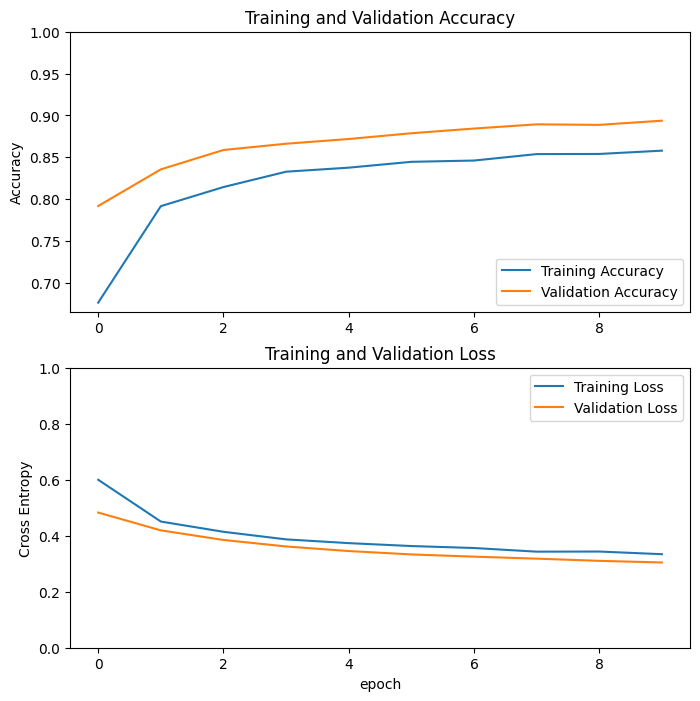

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We can see that the validation metrics are better than the training ones but we can say that this is because the `BatchNormalization` and `Dropout` layers affect accuracy during training and are turned off when calculating the validation loss.

## Fine tuning the model

In order to increase the performacne we can fite tune the model. Till here we have only trained the layers that we added without updating any weights from the `base_model`.
Lets look at the number of layers in the `base_model` and only select a small amount of the higher up layers as those are the more specialized ones (whereas the first ones are more simple and catch more generic features).

For that we will unfreeze the model, check the number of layers in the base and select for which ones to disable the training again.

In [23]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  190


In [24]:
fine_tune_from = 170
for layer in base_model.layers[:fine_tune_from]:
  layer.trainable = False

Now we need to compile the new model and check the amount of trainable parameters.
As we are training a larger model and adapting pretrained weights, we need to lower the learning rate so that we do not overfit the model.

We will once again use the legacy optimizer as the new one is slow on the M1.

In [25]:
model.compile(loss=BinaryCrossentropy(),
              optimizer = RMSprop(learning_rate=base_learning_rate/10),
              metrics=[BinaryAccuracy(threshold=0.5, name='accuracy')])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

Now we add 10 additional epochs and continue the training from where we had left off.

In [26]:
# -.-|m { output: false }

fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20


2024-04-01 16:00:19.962408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 18:49 - loss: 0.2932 - accuracy: 0.9062

2024-04-01 16:00:21.468277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:21 - loss: 0.4278 - accuracy: 0.8281 

2024-04-01 16:00:21.871014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:11 - loss: 0.3880 - accuracy: 0.8229

2024-04-01 16:00:22.219569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:10 - loss: 0.3582 - accuracy: 0.8359

2024-04-01 16:00:22.598903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:09 - loss: 0.3397 - accuracy: 0.8438

2024-04-01 16:00:22.961690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:07 - loss: 0.3245 - accuracy: 0.8594

2024-04-01 16:00:23.317990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:05 - loss: 0.3202 - accuracy: 0.8705

2024-04-01 16:00:23.663345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:04 - loss: 0.3119 - accuracy: 0.8750

2024-04-01 16:00:24.008730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:05 - loss: 0.3128 - accuracy: 0.8715

2024-04-01 16:00:24.397949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:04 - loss: 0.3150 - accuracy: 0.8687

2024-04-01 16:00:24.746755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:03 - loss: 0.3230 - accuracy: 0.8693

2024-04-01 16:00:25.105526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 2:02 - loss: 0.3332 - accuracy: 0.8620

2024-04-01 16:00:25.450910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 2:01 - loss: 0.3433 - accuracy: 0.8582

2024-04-01 16:00:25.794219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 2:01 - loss: 0.3337 - accuracy: 0.8661

2024-04-01 16:00:26.172580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 2:01 - loss: 0.3318 - accuracy: 0.8667

2024-04-01 16:00:26.526281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 2:00 - loss: 0.3211 - accuracy: 0.8750

2024-04-01 16:00:26.879873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 2:00 - loss: 0.3247 - accuracy: 0.8713

2024-04-01 16:00:27.242343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 1:59 - loss: 0.3265 - accuracy: 0.8733

2024-04-01 16:00:27.597440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 1:59 - loss: 0.3283 - accuracy: 0.8684

2024-04-01 16:00:27.944254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 1:58 - loss: 0.3264 - accuracy: 0.8687

2024-04-01 16:00:28.304422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 1:58 - loss: 0.3279 - accuracy: 0.8661

2024-04-01 16:00:28.646788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 1:57 - loss: 0.3282 - accuracy: 0.8665

2024-04-01 16:00:28.989415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 1:57 - loss: 0.3347 - accuracy: 0.8655

2024-04-01 16:00:29.347986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 1:56 - loss: 0.3288 - accuracy: 0.8672

2024-04-01 16:00:29.693145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 1:56 - loss: 0.3271 - accuracy: 0.8675

2024-04-01 16:00:30.035822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 1:55 - loss: 0.3317 - accuracy: 0.8642

2024-04-01 16:00:30.396905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 1:55 - loss: 0.3344 - accuracy: 0.8634

2024-04-01 16:00:30.747573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 1:54 - loss: 0.3399 - accuracy: 0.8638

2024-04-01 16:00:31.092640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 1:54 - loss: 0.3393 - accuracy: 0.8631

2024-04-01 16:00:31.456360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 1:54 - loss: 0.3346 - accuracy: 0.8656

2024-04-01 16:00:31.798605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 1:53 - loss: 0.3313 - accuracy: 0.8669

2024-04-01 16:00:32.139754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 1:53 - loss: 0.3394 - accuracy: 0.8643

2024-04-01 16:00:32.498288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 1:52 - loss: 0.3352 - accuracy: 0.8684

2024-04-01 16:00:32.839126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 1:52 - loss: 0.3363 - accuracy: 0.8649

2024-04-01 16:00:33.183737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 1:51 - loss: 0.3348 - accuracy: 0.8661

2024-04-01 16:00:33.543045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 1:51 - loss: 0.3397 - accuracy: 0.8628

2024-04-01 16:00:33.886054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 1:51 - loss: 0.3396 - accuracy: 0.8615

2024-04-01 16:00:34.245857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 1:50 - loss: 0.3399 - accuracy: 0.8602

2024-04-01 16:00:34.584800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 1:50 - loss: 0.3398 - accuracy: 0.8606

2024-04-01 16:00:34.929767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 1:49 - loss: 0.3400 - accuracy: 0.8602

2024-04-01 16:00:35.290297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 1:49 - loss: 0.3367 - accuracy: 0.8605

2024-04-01 16:00:35.629932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 1:49 - loss: 0.3389 - accuracy: 0.8601

2024-04-01 16:00:35.987205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 1:48 - loss: 0.3460 - accuracy: 0.8590

2024-04-01 16:00:36.334302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 1:48 - loss: 0.3433 - accuracy: 0.8601

2024-04-01 16:00:36.681431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 1:47 - loss: 0.3436 - accuracy: 0.8597

2024-04-01 16:00:37.041440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 1:47 - loss: 0.3434 - accuracy: 0.8601

2024-04-01 16:00:37.384089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 1:47 - loss: 0.3396 - accuracy: 0.8617

2024-04-01 16:00:37.725073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 1:46 - loss: 0.3430 - accuracy: 0.8613

2024-04-01 16:00:38.086440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 1:46 - loss: 0.3450 - accuracy: 0.8597

2024-04-01 16:00:38.429076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 1:46 - loss: 0.3483 - accuracy: 0.8587

2024-04-01 16:00:38.798084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 1:45 - loss: 0.3484 - accuracy: 0.8572

2024-04-01 16:00:39.142326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 1:45 - loss: 0.3472 - accuracy: 0.8570

2024-04-01 16:00:39.481845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 1:44 - loss: 0.3461 - accuracy: 0.8567

2024-04-01 16:00:39.837838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 1:44 - loss: 0.3497 - accuracy: 0.8565

2024-04-01 16:00:40.179515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 1:44 - loss: 0.3509 - accuracy: 0.8551

2024-04-01 16:00:40.519725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 1:43 - loss: 0.3497 - accuracy: 0.8555

2024-04-01 16:00:40.880436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 1:43 - loss: 0.3512 - accuracy: 0.8558

2024-04-01 16:00:41.224853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 1:43 - loss: 0.3529 - accuracy: 0.8551

2024-04-01 16:00:41.581071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 1:42 - loss: 0.3516 - accuracy: 0.8559

2024-04-01 16:00:41.923561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 1:42 - loss: 0.3522 - accuracy: 0.8552

2024-04-01 16:00:42.262950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 1:41 - loss: 0.3503 - accuracy: 0.8560

2024-04-01 16:00:42.619031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 1:41 - loss: 0.3497 - accuracy: 0.8558

2024-04-01 16:00:42.959305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 1:41 - loss: 0.3486 - accuracy: 0.8557

2024-04-01 16:00:43.308434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 1:40 - loss: 0.3505 - accuracy: 0.8555

2024-04-01 16:00:43.668483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 1:40 - loss: 0.3510 - accuracy: 0.8553

2024-04-01 16:00:44.007691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 1:39 - loss: 0.3504 - accuracy: 0.8561

2024-04-01 16:00:44.344876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 1:39 - loss: 0.3503 - accuracy: 0.8563

2024-04-01 16:00:44.705425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 1:39 - loss: 0.3508 - accuracy: 0.8562

2024-04-01 16:00:45.047582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 1:38 - loss: 0.3520 - accuracy: 0.8546

2024-04-01 16:00:45.409784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 1:38 - loss: 0.3512 - accuracy: 0.8545

2024-04-01 16:00:45.749814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 1:38 - loss: 0.3500 - accuracy: 0.8552

2024-04-01 16:00:46.092414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 1:37 - loss: 0.3485 - accuracy: 0.8563

2024-04-01 16:00:46.454330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 1:37 - loss: 0.3470 - accuracy: 0.8570

2024-04-01 16:00:46.799875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 1:37 - loss: 0.3486 - accuracy: 0.8556

2024-04-01 16:00:47.162091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 1:36 - loss: 0.3526 - accuracy: 0.8533

2024-04-01 16:00:47.501839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 1:36 - loss: 0.3518 - accuracy: 0.8540

2024-04-01 16:00:47.858605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 1:36 - loss: 0.3513 - accuracy: 0.8539

2024-04-01 16:00:48.253551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 1:35 - loss: 0.3513 - accuracy: 0.8538

2024-04-01 16:00:48.605632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 1:35 - loss: 0.3522 - accuracy: 0.8532

2024-04-01 16:00:48.987144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 1:35 - loss: 0.3525 - accuracy: 0.8527

2024-04-01 16:00:49.343933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 1:34 - loss: 0.3547 - accuracy: 0.8519

2024-04-01 16:00:49.688929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 1:34 - loss: 0.3534 - accuracy: 0.8525

2024-04-01 16:00:50.048325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 1:34 - loss: 0.3528 - accuracy: 0.8520

2024-04-01 16:00:50.393120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 1:33 - loss: 0.3520 - accuracy: 0.8516

2024-04-01 16:00:50.737870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 1:33 - loss: 0.3523 - accuracy: 0.8511

2024-04-01 16:00:51.100016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 1:33 - loss: 0.3512 - accuracy: 0.8510

2024-04-01 16:00:51.444628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 1:32 - loss: 0.3505 - accuracy: 0.8513

2024-04-01 16:00:51.803800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 1:32 - loss: 0.3491 - accuracy: 0.8516

2024-04-01 16:00:52.146760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 1:32 - loss: 0.3490 - accuracy: 0.8518

2024-04-01 16:00:52.498333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 1:31 - loss: 0.3492 - accuracy: 0.8517

2024-04-01 16:00:52.864997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 1:31 - loss: 0.3491 - accuracy: 0.8523

2024-04-01 16:00:53.215783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 1:31 - loss: 0.3470 - accuracy: 0.8536

2024-04-01 16:00:53.577775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 1:30 - loss: 0.3471 - accuracy: 0.8532

2024-04-01 16:00:53.925399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 1:30 - loss: 0.3453 - accuracy: 0.8541

2024-04-01 16:00:54.273945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 1:29 - loss: 0.3433 - accuracy: 0.8553

2024-04-01 16:00:54.636314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 1:29 - loss: 0.3427 - accuracy: 0.8551

2024-04-01 16:00:54.980128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:29 - loss: 0.3418 - accuracy: 0.8553

2024-04-01 16:00:55.352566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:28 - loss: 0.3400 - accuracy: 0.8565

2024-04-01 16:00:55.694415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:28 - loss: 0.3385 - accuracy: 0.8573

2024-04-01 16:00:56.039986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:28 - loss: 0.3393 - accuracy: 0.8572

2024-04-01 16:00:56.409351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:27 - loss: 0.3382 - accuracy: 0.8574

2024-04-01 16:00:56.757292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:27 - loss: 0.3371 - accuracy: 0.8578

2024-04-01 16:00:57.115885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:27 - loss: 0.3370 - accuracy: 0.8577

2024-04-01 16:00:57.463774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:26 - loss: 0.3367 - accuracy: 0.8579

2024-04-01 16:00:57.804690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:26 - loss: 0.3355 - accuracy: 0.8583

2024-04-01 16:00:58.169059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:26 - loss: 0.3359 - accuracy: 0.8582

2024-04-01 16:00:58.512147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:25 - loss: 0.3365 - accuracy: 0.8581

2024-04-01 16:00:58.869971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:25 - loss: 0.3353 - accuracy: 0.8585

2024-04-01 16:00:59.213422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:25 - loss: 0.3355 - accuracy: 0.8584

2024-04-01 16:00:59.559056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:24 - loss: 0.3344 - accuracy: 0.8588

2024-04-01 16:00:59.919858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:24 - loss: 0.3346 - accuracy: 0.8584

2024-04-01 16:01:00.263571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:23 - loss: 0.3337 - accuracy: 0.8585

2024-04-01 16:01:00.624749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:23 - loss: 0.3330 - accuracy: 0.8584

2024-04-01 16:01:00.966705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:23 - loss: 0.3330 - accuracy: 0.8580

2024-04-01 16:01:01.308629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:22 - loss: 0.3320 - accuracy: 0.8590

2024-04-01 16:01:01.674397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:22 - loss: 0.3321 - accuracy: 0.8596

2024-04-01 16:01:02.021672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:22 - loss: 0.3341 - accuracy: 0.8592

2024-04-01 16:01:02.380482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:21 - loss: 0.3351 - accuracy: 0.8588

2024-04-01 16:01:02.723767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:21 - loss: 0.3345 - accuracy: 0.8595

2024-04-01 16:01:03.063836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:21 - loss: 0.3352 - accuracy: 0.8594

2024-04-01 16:01:03.421417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:20 - loss: 0.3365 - accuracy: 0.8590

2024-04-01 16:01:03.768027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:20 - loss: 0.3370 - accuracy: 0.8586

2024-04-01 16:01:04.109740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:20 - loss: 0.3369 - accuracy: 0.8587

2024-04-01 16:01:04.470916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:19 - loss: 0.3368 - accuracy: 0.8586

2024-04-01 16:01:04.811359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:19 - loss: 0.3363 - accuracy: 0.8587

2024-04-01 16:01:05.170402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:18 - loss: 0.3364 - accuracy: 0.8589

2024-04-01 16:01:05.512134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:18 - loss: 0.3369 - accuracy: 0.8585

2024-04-01 16:01:05.860920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:18 - loss: 0.3380 - accuracy: 0.8577

2024-04-01 16:01:06.222094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:17 - loss: 0.3383 - accuracy: 0.8578

2024-04-01 16:01:06.567705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:17 - loss: 0.3391 - accuracy: 0.8577

2024-04-01 16:01:06.943251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:17 - loss: 0.3385 - accuracy: 0.8583

2024-04-01 16:01:07.291557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:16 - loss: 0.3383 - accuracy: 0.8582

2024-04-01 16:01:07.633988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:16 - loss: 0.3380 - accuracy: 0.8581

2024-04-01 16:01:08.003659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:16 - loss: 0.3382 - accuracy: 0.8577

2024-04-01 16:01:08.345385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:15 - loss: 0.3380 - accuracy: 0.8581

2024-04-01 16:01:08.703643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:15 - loss: 0.3380 - accuracy: 0.8582

2024-04-01 16:01:09.046509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:15 - loss: 0.3390 - accuracy: 0.8579

2024-04-01 16:01:09.389326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:14 - loss: 0.3403 - accuracy: 0.8573

2024-04-01 16:01:09.755708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:14 - loss: 0.3397 - accuracy: 0.8577

2024-04-01 16:01:10.103962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:14 - loss: 0.3401 - accuracy: 0.8576

2024-04-01 16:01:10.460875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:13 - loss: 0.3399 - accuracy: 0.8575

2024-04-01 16:01:10.804425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:13 - loss: 0.3386 - accuracy: 0.8581

2024-04-01 16:01:11.146615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:12 - loss: 0.3375 - accuracy: 0.8582

2024-04-01 16:01:11.505129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:12 - loss: 0.3370 - accuracy: 0.8583

2024-04-01 16:01:11.851156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:12 - loss: 0.3358 - accuracy: 0.8588

2024-04-01 16:01:12.193017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:11 - loss: 0.3356 - accuracy: 0.8587

2024-04-01 16:01:12.553857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:11 - loss: 0.3368 - accuracy: 0.8586

2024-04-01 16:01:12.898913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:11 - loss: 0.3367 - accuracy: 0.8590

2024-04-01 16:01:13.260733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:10 - loss: 0.3365 - accuracy: 0.8589

2024-04-01 16:01:13.607635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:10 - loss: 0.3363 - accuracy: 0.8592

2024-04-01 16:01:13.951438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:10 - loss: 0.3361 - accuracy: 0.8587

2024-04-01 16:01:14.311492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:09 - loss: 0.3356 - accuracy: 0.8588

2024-04-01 16:01:14.655010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:09 - loss: 0.3350 - accuracy: 0.8589

2024-04-01 16:01:15.014094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:09 - loss: 0.3340 - accuracy: 0.8592

2024-04-01 16:01:15.352964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:08 - loss: 0.3341 - accuracy: 0.8587

2024-04-01 16:01:15.701854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:08 - loss: 0.3339 - accuracy: 0.8584

2024-04-01 16:01:16.071804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:08 - loss: 0.3329 - accuracy: 0.8589

2024-04-01 16:01:16.435502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:07 - loss: 0.3330 - accuracy: 0.8586

2024-04-01 16:01:16.780455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:07 - loss: 0.3319 - accuracy: 0.8591

2024-04-01 16:01:17.155232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:06 - loss: 0.3314 - accuracy: 0.8596

2024-04-01 16:01:17.503373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:06 - loss: 0.3316 - accuracy: 0.8599

2024-04-01 16:01:17.848740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:06 - loss: 0.3327 - accuracy: 0.8594

2024-04-01 16:01:18.226101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:05 - loss: 0.3326 - accuracy: 0.8589

2024-04-01 16:01:18.572657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:05 - loss: 0.3331 - accuracy: 0.8582

2024-04-01 16:01:18.932682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:05 - loss: 0.3341 - accuracy: 0.8578

2024-04-01 16:01:19.275547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:04 - loss: 0.3340 - accuracy: 0.8577

2024-04-01 16:01:19.620702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:04 - loss: 0.3337 - accuracy: 0.8574

2024-04-01 16:01:19.985895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:04 - loss: 0.3331 - accuracy: 0.8575

2024-04-01 16:01:20.335026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:03 - loss: 0.3326 - accuracy: 0.8578

2024-04-01 16:01:20.696171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:03 - loss: 0.3325 - accuracy: 0.8575

2024-04-01 16:01:21.036689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:03 - loss: 0.3327 - accuracy: 0.8571

2024-04-01 16:01:21.378749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:02 - loss: 0.3328 - accuracy: 0.8572

2024-04-01 16:01:21.747943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:02 - loss: 0.3327 - accuracy: 0.8573

2024-04-01 16:01:22.090182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:02 - loss: 0.3325 - accuracy: 0.8576

2024-04-01 16:01:22.456747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:01 - loss: 0.3340 - accuracy: 0.8568

2024-04-01 16:01:22.803001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:01 - loss: 0.3336 - accuracy: 0.8574

2024-04-01 16:01:23.149613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:00 - loss: 0.3342 - accuracy: 0.8572

2024-04-01 16:01:23.514804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:00 - loss: 0.3349 - accuracy: 0.8571

2024-04-01 16:01:23.856754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:00 - loss: 0.3345 - accuracy: 0.8574

2024-04-01 16:01:24.227236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 59s - loss: 0.3347 - accuracy: 0.8571 

2024-04-01 16:01:24.569704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 59s - loss: 0.3343 - accuracy: 0.8576

2024-04-01 16:01:24.913114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 59s - loss: 0.3336 - accuracy: 0.8580

2024-04-01 16:01:25.279123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 58s - loss: 0.3333 - accuracy: 0.8581

2024-04-01 16:01:25.624550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 58s - loss: 0.3332 - accuracy: 0.8585

2024-04-01 16:01:25.984251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 58s - loss: 0.3323 - accuracy: 0.8593

2024-04-01 16:01:26.336309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 57s - loss: 0.3331 - accuracy: 0.8592

2024-04-01 16:01:26.679744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 57s - loss: 0.3328 - accuracy: 0.8596

2024-04-01 16:01:27.048016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 57s - loss: 0.3332 - accuracy: 0.8592

2024-04-01 16:01:27.399824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 56s - loss: 0.3326 - accuracy: 0.8596

2024-04-01 16:01:27.763074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 56s - loss: 0.3326 - accuracy: 0.8595

2024-04-01 16:01:28.107210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 56s - loss: 0.3324 - accuracy: 0.8599

2024-04-01 16:01:28.454630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 55s - loss: 0.3321 - accuracy: 0.8599

2024-04-01 16:01:28.819102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 55s - loss: 0.3316 - accuracy: 0.8601

2024-04-01 16:01:29.166929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 55s - loss: 0.3303 - accuracy: 0.8608

2024-04-01 16:01:29.528897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 54s - loss: 0.3295 - accuracy: 0.8612

2024-04-01 16:01:29.873167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 54s - loss: 0.3291 - accuracy: 0.8614

2024-04-01 16:01:30.221177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 53s - loss: 0.3283 - accuracy: 0.8618

2024-04-01 16:01:30.593693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 53s - loss: 0.3279 - accuracy: 0.8617

2024-04-01 16:01:30.939437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 53s - loss: 0.3284 - accuracy: 0.8617

2024-04-01 16:01:31.303036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 52s - loss: 0.3280 - accuracy: 0.8617

2024-04-01 16:01:31.649087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 52s - loss: 0.3279 - accuracy: 0.8619

2024-04-01 16:01:31.991615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 52s - loss: 0.3276 - accuracy: 0.8622

2024-04-01 16:01:32.359350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 51s - loss: 0.3272 - accuracy: 0.8624

2024-04-01 16:01:32.707524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 51s - loss: 0.3264 - accuracy: 0.8627

2024-04-01 16:01:33.074449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 51s - loss: 0.3264 - accuracy: 0.8625

2024-04-01 16:01:33.424008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 50s - loss: 0.3267 - accuracy: 0.8627

2024-04-01 16:01:33.770428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 50s - loss: 0.3264 - accuracy: 0.8626

2024-04-01 16:01:34.140811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 50s - loss: 0.3265 - accuracy: 0.8624

2024-04-01 16:01:34.486802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 49s - loss: 0.3266 - accuracy: 0.8624

2024-04-01 16:01:34.849461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 49s - loss: 0.3268 - accuracy: 0.8624

2024-04-01 16:01:35.199031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 49s - loss: 0.3263 - accuracy: 0.8624

2024-04-01 16:01:35.544602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 48s - loss: 0.3270 - accuracy: 0.8619

2024-04-01 16:01:35.907377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 48s - loss: 0.3266 - accuracy: 0.8619

2024-04-01 16:01:36.253588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 47s - loss: 0.3269 - accuracy: 0.8617

2024-04-01 16:01:36.600557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 47s - loss: 0.3271 - accuracy: 0.8616

2024-04-01 16:01:36.970030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 47s - loss: 0.3275 - accuracy: 0.8613

2024-04-01 16:01:37.315506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 46s - loss: 0.3275 - accuracy: 0.8613

2024-04-01 16:01:37.669578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 46s - loss: 0.3270 - accuracy: 0.8615

2024-04-01 16:01:38.033404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 46s - loss: 0.3267 - accuracy: 0.8617

2024-04-01 16:01:38.381877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 45s - loss: 0.3266 - accuracy: 0.8618

2024-04-01 16:01:38.731511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 45s - loss: 0.3261 - accuracy: 0.8621

2024-04-01 16:01:39.100119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 45s - loss: 0.3266 - accuracy: 0.8619

2024-04-01 16:01:39.448336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 44s - loss: 0.3265 - accuracy: 0.8621

2024-04-01 16:01:39.798778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 44s - loss: 0.3255 - accuracy: 0.8626

2024-04-01 16:01:40.176130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 44s - loss: 0.3254 - accuracy: 0.8626

2024-04-01 16:01:40.552504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 43s - loss: 0.3251 - accuracy: 0.8626

2024-04-01 16:01:40.933665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 43s - loss: 0.3251 - accuracy: 0.8625

2024-04-01 16:01:41.320299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 43s - loss: 0.3257 - accuracy: 0.8621

2024-04-01 16:01:41.696109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 42s - loss: 0.3251 - accuracy: 0.8624

2024-04-01 16:01:42.052913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 42s - loss: 0.3246 - accuracy: 0.8625

2024-04-01 16:01:42.445394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 42s - loss: 0.3246 - accuracy: 0.8624

2024-04-01 16:01:42.814667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 41s - loss: 0.3245 - accuracy: 0.8626

2024-04-01 16:01:43.171066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 41s - loss: 0.3249 - accuracy: 0.8624

2024-04-01 16:01:43.538780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 41s - loss: 0.3254 - accuracy: 0.8623

2024-04-01 16:01:43.942464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 40s - loss: 0.3252 - accuracy: 0.8624

2024-04-01 16:01:44.317566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 40s - loss: 0.3250 - accuracy: 0.8623

2024-04-01 16:01:44.699302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 40s - loss: 0.3247 - accuracy: 0.8623

2024-04-01 16:01:45.059888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 39s - loss: 0.3246 - accuracy: 0.8624

2024-04-01 16:01:45.404217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 39s - loss: 0.3241 - accuracy: 0.8624

2024-04-01 16:01:45.782894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 38s - loss: 0.3239 - accuracy: 0.8622

2024-04-01 16:01:46.129502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 38s - loss: 0.3242 - accuracy: 0.8622

2024-04-01 16:01:46.500625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 38s - loss: 0.3235 - accuracy: 0.8625

2024-04-01 16:01:46.848394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 37s - loss: 0.3235 - accuracy: 0.8623

2024-04-01 16:01:47.191752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 37s - loss: 0.3230 - accuracy: 0.8624

2024-04-01 16:01:47.564613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 37s - loss: 0.3233 - accuracy: 0.8624

2024-04-01 16:01:47.907796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 36s - loss: 0.3229 - accuracy: 0.8626

2024-04-01 16:01:48.281378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 36s - loss: 0.3223 - accuracy: 0.8629

2024-04-01 16:01:48.628416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 36s - loss: 0.3220 - accuracy: 0.8628

2024-04-01 16:01:48.975646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 35s - loss: 0.3221 - accuracy: 0.8630

2024-04-01 16:01:49.342889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 35s - loss: 0.3218 - accuracy: 0.8631

2024-04-01 16:01:49.692157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 35s - loss: 0.3215 - accuracy: 0.8632

2024-04-01 16:01:50.028940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 34s - loss: 0.3207 - accuracy: 0.8637

2024-04-01 16:01:50.364095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 34s - loss: 0.3209 - accuracy: 0.8638

2024-04-01 16:01:50.708916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 33s - loss: 0.3207 - accuracy: 0.8639

2024-04-01 16:01:51.057861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 33s - loss: 0.3206 - accuracy: 0.8638

2024-04-01 16:01:51.427603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 33s - loss: 0.3206 - accuracy: 0.8636

2024-04-01 16:01:51.766235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 32s - loss: 0.3200 - accuracy: 0.8641

2024-04-01 16:01:52.107209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 32s - loss: 0.3196 - accuracy: 0.8642

2024-04-01 16:01:52.443201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 32s - loss: 0.3195 - accuracy: 0.8645

2024-04-01 16:01:52.785700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 31s - loss: 0.3195 - accuracy: 0.8643

2024-04-01 16:01:53.129766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 31s - loss: 0.3195 - accuracy: 0.8642

2024-04-01 16:01:53.468361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 31s - loss: 0.3203 - accuracy: 0.8641

2024-04-01 16:01:53.810345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 30s - loss: 0.3201 - accuracy: 0.8644

2024-04-01 16:01:54.150311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 30s - loss: 0.3201 - accuracy: 0.8642

2024-04-01 16:01:54.519146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 30s - loss: 0.3196 - accuracy: 0.8646

2024-04-01 16:01:54.860700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 29s - loss: 0.3191 - accuracy: 0.8649

2024-04-01 16:01:55.199196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 29s - loss: 0.3185 - accuracy: 0.8653

2024-04-01 16:01:55.535325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 28s - loss: 0.3182 - accuracy: 0.8652

2024-04-01 16:01:55.876395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 28s - loss: 0.3184 - accuracy: 0.8650

2024-04-01 16:01:56.211958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 28s - loss: 0.3179 - accuracy: 0.8653

2024-04-01 16:01:56.549176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 27s - loss: 0.3188 - accuracy: 0.8650

2024-04-01 16:01:56.888273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 27s - loss: 0.3190 - accuracy: 0.8649

2024-04-01 16:01:57.224671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 27s - loss: 0.3187 - accuracy: 0.8650

2024-04-01 16:01:57.589402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 26s - loss: 0.3186 - accuracy: 0.8650

2024-04-01 16:01:57.926217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 26s - loss: 0.3181 - accuracy: 0.8651

2024-04-01 16:01:58.263130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 26s - loss: 0.3179 - accuracy: 0.8650

2024-04-01 16:01:58.598129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 25s - loss: 0.3181 - accuracy: 0.8648

2024-04-01 16:01:58.934780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 25s - loss: 0.3180 - accuracy: 0.8649

2024-04-01 16:01:59.273498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 25s - loss: 0.3182 - accuracy: 0.8648

2024-04-01 16:01:59.612469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 24s - loss: 0.3183 - accuracy: 0.8648

2024-04-01 16:01:59.955790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 24s - loss: 0.3183 - accuracy: 0.8648

2024-04-01 16:02:00.294044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 24s - loss: 0.3183 - accuracy: 0.8647

2024-04-01 16:02:00.666279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 23s - loss: 0.3183 - accuracy: 0.8647

2024-04-01 16:02:01.002392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 23s - loss: 0.3183 - accuracy: 0.8645

2024-04-01 16:02:01.345854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 22s - loss: 0.3178 - accuracy: 0.8648

2024-04-01 16:02:01.685891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 22s - loss: 0.3180 - accuracy: 0.8648

2024-04-01 16:02:02.024671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 22s - loss: 0.3177 - accuracy: 0.8648

2024-04-01 16:02:02.362357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 21s - loss: 0.3172 - accuracy: 0.8650

2024-04-01 16:02:02.699772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 21s - loss: 0.3171 - accuracy: 0.8652

2024-04-01 16:02:03.039679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 21s - loss: 0.3168 - accuracy: 0.8651

2024-04-01 16:02:03.414182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 20s - loss: 0.3168 - accuracy: 0.8649

2024-04-01 16:02:03.763166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 20s - loss: 0.3169 - accuracy: 0.8648

2024-04-01 16:02:04.111048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 20s - loss: 0.3165 - accuracy: 0.8649

2024-04-01 16:02:04.452128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 19s - loss: 0.3161 - accuracy: 0.8649

2024-04-01 16:02:04.793312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 19s - loss: 0.3164 - accuracy: 0.8646

2024-04-01 16:02:05.132533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 19s - loss: 0.3160 - accuracy: 0.8648

2024-04-01 16:02:05.477803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 18s - loss: 0.3156 - accuracy: 0.8650

2024-04-01 16:02:05.821410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 18s - loss: 0.3152 - accuracy: 0.8651

2024-04-01 16:02:06.161956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 17s - loss: 0.3146 - accuracy: 0.8656

2024-04-01 16:02:06.542457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 17s - loss: 0.3147 - accuracy: 0.8655

2024-04-01 16:02:06.884772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 17s - loss: 0.3143 - accuracy: 0.8657

2024-04-01 16:02:07.226823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 16s - loss: 0.3142 - accuracy: 0.8657

2024-04-01 16:02:07.572246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 16s - loss: 0.3141 - accuracy: 0.8657

2024-04-01 16:02:07.915887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 16s - loss: 0.3137 - accuracy: 0.8660

2024-04-01 16:02:08.259605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 15s - loss: 0.3134 - accuracy: 0.8660

2024-04-01 16:02:08.603938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 15s - loss: 0.3143 - accuracy: 0.8655

2024-04-01 16:02:08.948916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 15s - loss: 0.3141 - accuracy: 0.8655

2024-04-01 16:02:09.319949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 14s - loss: 0.3138 - accuracy: 0.8657

2024-04-01 16:02:09.664301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 14s - loss: 0.3137 - accuracy: 0.8656

2024-04-01 16:02:10.001612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 14s - loss: 0.3134 - accuracy: 0.8657

2024-04-01 16:02:10.339398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 13s - loss: 0.3133 - accuracy: 0.8659

2024-04-01 16:02:10.682073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 13s - loss: 0.3133 - accuracy: 0.8659

2024-04-01 16:02:11.025208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 13s - loss: 0.3129 - accuracy: 0.8662

2024-04-01 16:02:11.367745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 12s - loss: 0.3125 - accuracy: 0.8663

2024-04-01 16:02:11.712278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 12s - loss: 0.3127 - accuracy: 0.8665

2024-04-01 16:02:12.091300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 11s - loss: 0.3126 - accuracy: 0.8665

2024-04-01 16:02:12.428870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 11s - loss: 0.3124 - accuracy: 0.8665

2024-04-01 16:02:12.770946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 11s - loss: 0.3129 - accuracy: 0.8665

2024-04-01 16:02:13.113126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 10s - loss: 0.3132 - accuracy: 0.8665

2024-04-01 16:02:13.456511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 10s - loss: 0.3136 - accuracy: 0.8663

2024-04-01 16:02:13.806209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 10s - loss: 0.3133 - accuracy: 0.8665

2024-04-01 16:02:14.147658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 9s - loss: 0.3129 - accuracy: 0.8668 

2024-04-01 16:02:14.521284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 9s - loss: 0.3135 - accuracy: 0.8666

2024-04-01 16:02:14.871897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 9s - loss: 0.3133 - accuracy: 0.8665

2024-04-01 16:02:15.212224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 8s - loss: 0.3128 - accuracy: 0.8667

2024-04-01 16:02:15.558463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 8s - loss: 0.3126 - accuracy: 0.8669

2024-04-01 16:02:15.912969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 8s - loss: 0.3126 - accuracy: 0.8668

2024-04-01 16:02:16.259149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 7s - loss: 0.3128 - accuracy: 0.8667

2024-04-01 16:02:16.606988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 7s - loss: 0.3126 - accuracy: 0.8669

2024-04-01 16:02:16.953266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 7s - loss: 0.3127 - accuracy: 0.8670

2024-04-01 16:02:17.326936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 6s - loss: 0.3125 - accuracy: 0.8671

2024-04-01 16:02:17.689136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 6s - loss: 0.3124 - accuracy: 0.8670

2024-04-01 16:02:18.031849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 5s - loss: 0.3123 - accuracy: 0.8670

2024-04-01 16:02:18.374903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 5s - loss: 0.3125 - accuracy: 0.8670

2024-04-01 16:02:18.718981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 5s - loss: 0.3120 - accuracy: 0.8672

2024-04-01 16:02:19.063729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 4s - loss: 0.3117 - accuracy: 0.8674

2024-04-01 16:02:19.406274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 4s - loss: 0.3120 - accuracy: 0.8672

2024-04-01 16:02:19.754479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 4s - loss: 0.3117 - accuracy: 0.8674

2024-04-01 16:02:20.113751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 3s - loss: 0.3115 - accuracy: 0.8674

2024-04-01 16:02:20.474305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 3s - loss: 0.3114 - accuracy: 0.8675

2024-04-01 16:02:20.821063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 3s - loss: 0.3111 - accuracy: 0.8677

2024-04-01 16:02:21.166956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 2s - loss: 0.3113 - accuracy: 0.8676

2024-04-01 16:02:21.506261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 2s - loss: 0.3112 - accuracy: 0.8677

2024-04-01 16:02:21.854829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 2s - loss: 0.3111 - accuracy: 0.8676

2024-04-01 16:02:22.203140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 1s - loss: 0.3107 - accuracy: 0.8678

2024-04-01 16:02:22.557555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.3112 - accuracy: 0.8675

2024-04-01 16:02:22.936838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.3110 - accuracy: 0.8676

2024-04-01 16:02:23.311160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.3108 - accuracy: 0.8677

2024-04-01 16:02:23.688127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8678

2024-04-01 16:02:24.053133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 141s 396ms/step - loss: 0.3106 - accuracy: 0.8679 - val_loss: 0.2646 - val_accuracy: 0.8975
Epoch 11/20


2024-04-01 16:02:39.645887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 2:48 - loss: 0.3002 - accuracy: 0.8438

2024-04-01 16:02:40.139514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:21 - loss: 0.3585 - accuracy: 0.8125

2024-04-01 16:02:40.536558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:13 - loss: 0.3477 - accuracy: 0.8229

2024-04-01 16:02:40.905221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:11 - loss: 0.3212 - accuracy: 0.8438

2024-04-01 16:02:41.271040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:08 - loss: 0.3358 - accuracy: 0.8438

2024-04-01 16:02:41.618030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:06 - loss: 0.3232 - accuracy: 0.8542

2024-04-01 16:02:41.968713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:04 - loss: 0.3388 - accuracy: 0.8527

2024-04-01 16:02:42.312472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:03 - loss: 0.3242 - accuracy: 0.8555

2024-04-01 16:02:42.663807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:02 - loss: 0.3297 - accuracy: 0.8472

2024-04-01 16:02:43.007143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:01 - loss: 0.3130 - accuracy: 0.8594

2024-04-01 16:02:43.355163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:01 - loss: 0.3086 - accuracy: 0.8636

2024-04-01 16:02:43.702925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 2:00 - loss: 0.3056 - accuracy: 0.8646

2024-04-01 16:02:44.053560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 2:00 - loss: 0.3208 - accuracy: 0.8606

2024-04-01 16:02:44.421835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 2:01 - loss: 0.3069 - accuracy: 0.8683

2024-04-01 16:02:44.839245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 2:01 - loss: 0.3053 - accuracy: 0.8750

2024-04-01 16:02:45.190430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 2:00 - loss: 0.2912 - accuracy: 0.8828

2024-04-01 16:02:45.540341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 1:59 - loss: 0.2912 - accuracy: 0.8824

2024-04-01 16:02:45.886027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 1:59 - loss: 0.2879 - accuracy: 0.8785

2024-04-01 16:02:46.237978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 1:58 - loss: 0.2883 - accuracy: 0.8783

2024-04-01 16:02:46.588494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 1:58 - loss: 0.2914 - accuracy: 0.8781

2024-04-01 16:02:46.937238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 1:57 - loss: 0.3013 - accuracy: 0.8735

2024-04-01 16:02:47.290402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 1:57 - loss: 0.2982 - accuracy: 0.8778

2024-04-01 16:02:47.670559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 1:57 - loss: 0.2986 - accuracy: 0.8764

2024-04-01 16:02:48.019672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 1:56 - loss: 0.2975 - accuracy: 0.8789

2024-04-01 16:02:48.365959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 1:56 - loss: 0.3001 - accuracy: 0.8737

2024-04-01 16:02:48.716782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 1:55 - loss: 0.2943 - accuracy: 0.8774

2024-04-01 16:02:49.069807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 1:55 - loss: 0.2905 - accuracy: 0.8785

2024-04-01 16:02:49.419349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 1:54 - loss: 0.2872 - accuracy: 0.8783

2024-04-01 16:02:49.769277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 1:54 - loss: 0.2832 - accuracy: 0.8804

2024-04-01 16:02:50.114519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 1:54 - loss: 0.2805 - accuracy: 0.8823

2024-04-01 16:02:50.464905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 1:53 - loss: 0.2834 - accuracy: 0.8821

2024-04-01 16:02:50.819180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 1:53 - loss: 0.2860 - accuracy: 0.8799

2024-04-01 16:02:51.194664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 1:53 - loss: 0.2842 - accuracy: 0.8807

2024-04-01 16:02:51.547288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 1:52 - loss: 0.2844 - accuracy: 0.8824

2024-04-01 16:02:51.899722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 1:52 - loss: 0.2848 - accuracy: 0.8821

2024-04-01 16:02:52.248142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 1:51 - loss: 0.2871 - accuracy: 0.8819

2024-04-01 16:02:52.597489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 1:51 - loss: 0.2900 - accuracy: 0.8792

2024-04-01 16:02:52.957429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 1:51 - loss: 0.2925 - accuracy: 0.8791

2024-04-01 16:02:53.306510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 1:50 - loss: 0.2974 - accuracy: 0.8766

2024-04-01 16:02:53.652705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 1:50 - loss: 0.2953 - accuracy: 0.8766

2024-04-01 16:02:54.003607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 1:50 - loss: 0.2911 - accuracy: 0.8788

2024-04-01 16:02:54.389985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 1:49 - loss: 0.2879 - accuracy: 0.8802

2024-04-01 16:02:54.748669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 1:49 - loss: 0.2951 - accuracy: 0.8779

2024-04-01 16:02:55.100776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 1:49 - loss: 0.2929 - accuracy: 0.8786

2024-04-01 16:02:55.454258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 1:48 - loss: 0.2939 - accuracy: 0.8778

2024-04-01 16:02:55.802366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 1:48 - loss: 0.2921 - accuracy: 0.8777

2024-04-01 16:02:56.155774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 1:47 - loss: 0.2916 - accuracy: 0.8770

2024-04-01 16:02:56.502730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 1:47 - loss: 0.2904 - accuracy: 0.8770

2024-04-01 16:02:56.852089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 1:47 - loss: 0.2917 - accuracy: 0.8763

2024-04-01 16:02:57.206525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 1:46 - loss: 0.2959 - accuracy: 0.8763

2024-04-01 16:02:57.582413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 1:46 - loss: 0.3000 - accuracy: 0.8732

2024-04-01 16:02:57.932561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 1:46 - loss: 0.3014 - accuracy: 0.8720

2024-04-01 16:02:58.282803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 1:45 - loss: 0.3002 - accuracy: 0.8726

2024-04-01 16:02:58.632227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 1:45 - loss: 0.2993 - accuracy: 0.8738

2024-04-01 16:02:58.982130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 1:44 - loss: 0.2999 - accuracy: 0.8744

2024-04-01 16:02:59.332794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 1:44 - loss: 0.3008 - accuracy: 0.8750

2024-04-01 16:02:59.683911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 1:44 - loss: 0.2992 - accuracy: 0.8761

2024-04-01 16:03:00.057429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 1:43 - loss: 0.3035 - accuracy: 0.8739

2024-04-01 16:03:00.419973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 1:43 - loss: 0.3052 - accuracy: 0.8734

2024-04-01 16:03:00.771126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 1:43 - loss: 0.3048 - accuracy: 0.8729

2024-04-01 16:03:01.119905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 1:42 - loss: 0.3076 - accuracy: 0.8709

2024-04-01 16:03:01.470256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 1:42 - loss: 0.3075 - accuracy: 0.8715

2024-04-01 16:03:01.825405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 1:42 - loss: 0.3082 - accuracy: 0.8710

2024-04-01 16:03:02.187363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 1:41 - loss: 0.3084 - accuracy: 0.8706

2024-04-01 16:03:02.574199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 1:41 - loss: 0.3081 - accuracy: 0.8707

2024-04-01 16:03:02.941834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 1:41 - loss: 0.3083 - accuracy: 0.8707

2024-04-01 16:03:03.304947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 1:40 - loss: 0.3080 - accuracy: 0.8708

2024-04-01 16:03:03.660378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 1:40 - loss: 0.3076 - accuracy: 0.8709

2024-04-01 16:03:04.013531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 1:40 - loss: 0.3072 - accuracy: 0.8714

2024-04-01 16:03:04.370802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 1:39 - loss: 0.3066 - accuracy: 0.8719

2024-04-01 16:03:04.719781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 1:39 - loss: 0.3065 - accuracy: 0.8724

2024-04-01 16:03:05.100535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 1:39 - loss: 0.3049 - accuracy: 0.8733

2024-04-01 16:03:05.471337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 1:38 - loss: 0.3047 - accuracy: 0.8729

2024-04-01 16:03:05.833520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 1:38 - loss: 0.3057 - accuracy: 0.8725

2024-04-01 16:03:06.188804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 1:38 - loss: 0.3065 - accuracy: 0.8721

2024-04-01 16:03:06.543021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 1:37 - loss: 0.3036 - accuracy: 0.8734

2024-04-01 16:03:06.902910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 1:37 - loss: 0.3029 - accuracy: 0.8738

2024-04-01 16:03:07.265361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 1:37 - loss: 0.3043 - accuracy: 0.8722

2024-04-01 16:03:07.631479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 1:36 - loss: 0.3042 - accuracy: 0.8706

2024-04-01 16:03:08.013480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 1:36 - loss: 0.3045 - accuracy: 0.8703

2024-04-01 16:03:08.380865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 1:36 - loss: 0.3040 - accuracy: 0.8704

2024-04-01 16:03:08.824701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 1:36 - loss: 0.3037 - accuracy: 0.8700

2024-04-01 16:03:09.282203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 1:36 - loss: 0.3031 - accuracy: 0.8701

2024-04-01 16:03:09.654611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 1:35 - loss: 0.3018 - accuracy: 0.8702

2024-04-01 16:03:10.020829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 1:35 - loss: 0.3021 - accuracy: 0.8706

2024-04-01 16:03:10.377062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 1:35 - loss: 0.3014 - accuracy: 0.8714

2024-04-01 16:03:10.738886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 1:34 - loss: 0.3014 - accuracy: 0.8710

2024-04-01 16:03:11.096290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 1:34 - loss: 0.3029 - accuracy: 0.8707

2024-04-01 16:03:11.453796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 1:34 - loss: 0.3026 - accuracy: 0.8715

2024-04-01 16:03:11.852566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 1:33 - loss: 0.3065 - accuracy: 0.8698

2024-04-01 16:03:12.243328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 1:33 - loss: 0.3050 - accuracy: 0.8705

2024-04-01 16:03:12.621450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 1:33 - loss: 0.3050 - accuracy: 0.8706

2024-04-01 16:03:13.012140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 1:32 - loss: 0.3051 - accuracy: 0.8713

2024-04-01 16:03:13.394873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 1:32 - loss: 0.3041 - accuracy: 0.8717

2024-04-01 16:03:13.758521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 1:32 - loss: 0.3036 - accuracy: 0.8720

2024-04-01 16:03:14.131859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 1:32 - loss: 0.3021 - accuracy: 0.8730

2024-04-01 16:03:14.574909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:32 - loss: 0.3025 - accuracy: 0.8724

2024-04-01 16:03:15.061333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:31 - loss: 0.3021 - accuracy: 0.8724

2024-04-01 16:03:15.466898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:31 - loss: 0.3031 - accuracy: 0.8718

2024-04-01 16:03:15.845380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:31 - loss: 0.3034 - accuracy: 0.8719

2024-04-01 16:03:16.228650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:30 - loss: 0.3044 - accuracy: 0.8716

2024-04-01 16:03:16.611989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:30 - loss: 0.3045 - accuracy: 0.8710

2024-04-01 16:03:16.995972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:30 - loss: 0.3042 - accuracy: 0.8711

2024-04-01 16:03:17.369022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:29 - loss: 0.3036 - accuracy: 0.8717

2024-04-01 16:03:17.785298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:29 - loss: 0.3025 - accuracy: 0.8720

2024-04-01 16:03:18.175905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:29 - loss: 0.3024 - accuracy: 0.8723

2024-04-01 16:03:18.555516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:28 - loss: 0.3009 - accuracy: 0.8732

2024-04-01 16:03:18.944893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:28 - loss: 0.3008 - accuracy: 0.8733

2024-04-01 16:03:19.326644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:28 - loss: 0.3010 - accuracy: 0.8727

2024-04-01 16:03:19.694439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:27 - loss: 0.2996 - accuracy: 0.8736

2024-04-01 16:03:20.063410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:27 - loss: 0.2987 - accuracy: 0.8739

2024-04-01 16:03:20.462006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:27 - loss: 0.2995 - accuracy: 0.8736

2024-04-01 16:03:20.851433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:26 - loss: 0.3010 - accuracy: 0.8733

2024-04-01 16:03:21.219313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:26 - loss: 0.3019 - accuracy: 0.8728

2024-04-01 16:03:21.586739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:26 - loss: 0.3012 - accuracy: 0.8728

2024-04-01 16:03:21.957548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:25 - loss: 0.3014 - accuracy: 0.8723

2024-04-01 16:03:22.320595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:25 - loss: 0.3002 - accuracy: 0.8729

2024-04-01 16:03:22.689983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:25 - loss: 0.3008 - accuracy: 0.8731

2024-04-01 16:03:23.072929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:24 - loss: 0.3015 - accuracy: 0.8729

2024-04-01 16:03:23.454084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:24 - loss: 0.3030 - accuracy: 0.8716

2024-04-01 16:03:23.821399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:24 - loss: 0.3023 - accuracy: 0.8716

2024-04-01 16:03:24.190131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:23 - loss: 0.3015 - accuracy: 0.8719

2024-04-01 16:03:24.557562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:23 - loss: 0.3009 - accuracy: 0.8725

2024-04-01 16:03:24.926249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:22 - loss: 0.3000 - accuracy: 0.8727

2024-04-01 16:03:25.291050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:22 - loss: 0.3003 - accuracy: 0.8727

2024-04-01 16:03:25.680749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:22 - loss: 0.3009 - accuracy: 0.8730

2024-04-01 16:03:26.053307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:21 - loss: 0.3007 - accuracy: 0.8730

2024-04-01 16:03:26.418453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:21 - loss: 0.3013 - accuracy: 0.8730

2024-04-01 16:03:26.782736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:21 - loss: 0.3016 - accuracy: 0.8726

2024-04-01 16:03:27.144674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:20 - loss: 0.3015 - accuracy: 0.8726

2024-04-01 16:03:27.510477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:20 - loss: 0.3020 - accuracy: 0.8726

2024-04-01 16:03:27.892890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:20 - loss: 0.3017 - accuracy: 0.8729

2024-04-01 16:03:28.268523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:19 - loss: 0.3035 - accuracy: 0.8727

2024-04-01 16:03:28.646245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:19 - loss: 0.3029 - accuracy: 0.8729

2024-04-01 16:03:29.032886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:19 - loss: 0.3028 - accuracy: 0.8731

2024-04-01 16:03:29.430755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:18 - loss: 0.3029 - accuracy: 0.8734

2024-04-01 16:03:29.794091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:18 - loss: 0.3026 - accuracy: 0.8729

2024-04-01 16:03:30.154529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:18 - loss: 0.3027 - accuracy: 0.8725

2024-04-01 16:03:30.566137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:17 - loss: 0.3030 - accuracy: 0.8725

2024-04-01 16:03:30.957456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:17 - loss: 0.3035 - accuracy: 0.8723

2024-04-01 16:03:31.317143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:16 - loss: 0.3038 - accuracy: 0.8719

2024-04-01 16:03:31.672265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:16 - loss: 0.3059 - accuracy: 0.8708

2024-04-01 16:03:32.030018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:16 - loss: 0.3049 - accuracy: 0.8711

2024-04-01 16:03:32.393887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:15 - loss: 0.3037 - accuracy: 0.8717

2024-04-01 16:03:32.754379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:15 - loss: 0.3038 - accuracy: 0.8718

2024-04-01 16:03:33.137605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:15 - loss: 0.3031 - accuracy: 0.8722

2024-04-01 16:03:33.490856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:14 - loss: 0.3026 - accuracy: 0.8722

2024-04-01 16:03:33.851075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:14 - loss: 0.3039 - accuracy: 0.8714

2024-04-01 16:03:34.216531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:13 - loss: 0.3031 - accuracy: 0.8719

2024-04-01 16:03:34.575552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:13 - loss: 0.3029 - accuracy: 0.8719

2024-04-01 16:03:34.937554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:13 - loss: 0.3025 - accuracy: 0.8721

2024-04-01 16:03:35.324024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:12 - loss: 0.3026 - accuracy: 0.8719

2024-04-01 16:03:35.695720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:12 - loss: 0.3022 - accuracy: 0.8719

2024-04-01 16:03:36.057606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:12 - loss: 0.3018 - accuracy: 0.8724

2024-04-01 16:03:36.421899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:11 - loss: 0.3012 - accuracy: 0.8726

2024-04-01 16:03:36.789611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:11 - loss: 0.3004 - accuracy: 0.8728

2024-04-01 16:03:37.158749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:11 - loss: 0.2997 - accuracy: 0.8732

2024-04-01 16:03:37.551490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:10 - loss: 0.3004 - accuracy: 0.8728

2024-04-01 16:03:37.939351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:10 - loss: 0.2998 - accuracy: 0.8728

2024-04-01 16:03:38.306166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:09 - loss: 0.2993 - accuracy: 0.8730

2024-04-01 16:03:38.673628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:09 - loss: 0.2998 - accuracy: 0.8727

2024-04-01 16:03:39.062263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:09 - loss: 0.2995 - accuracy: 0.8727

2024-04-01 16:03:39.447349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:08 - loss: 0.2997 - accuracy: 0.8723

2024-04-01 16:03:39.814547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:08 - loss: 0.2997 - accuracy: 0.8723

2024-04-01 16:03:40.225799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:08 - loss: 0.2996 - accuracy: 0.8723

2024-04-01 16:03:40.620009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:07 - loss: 0.2992 - accuracy: 0.8726

2024-04-01 16:03:40.989923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:07 - loss: 0.2992 - accuracy: 0.8726

2024-04-01 16:03:41.358636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:07 - loss: 0.2989 - accuracy: 0.8730

2024-04-01 16:03:41.726671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:06 - loss: 0.2985 - accuracy: 0.8732

2024-04-01 16:03:42.099395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:06 - loss: 0.2978 - accuracy: 0.8737

2024-04-01 16:03:42.497647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:06 - loss: 0.2977 - accuracy: 0.8735

2024-04-01 16:03:42.876302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:05 - loss: 0.2978 - accuracy: 0.8735

2024-04-01 16:03:43.251984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:05 - loss: 0.2981 - accuracy: 0.8732

2024-04-01 16:03:43.624786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:04 - loss: 0.2977 - accuracy: 0.8734

2024-04-01 16:03:44.002555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:04 - loss: 0.2996 - accuracy: 0.8729

2024-04-01 16:03:44.380392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:04 - loss: 0.2996 - accuracy: 0.8727

2024-04-01 16:03:44.777062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:03 - loss: 0.3002 - accuracy: 0.8724

2024-04-01 16:03:45.164303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:03 - loss: 0.3003 - accuracy: 0.8722

2024-04-01 16:03:45.547190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:03 - loss: 0.3006 - accuracy: 0.8722

2024-04-01 16:03:45.973236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:02 - loss: 0.3012 - accuracy: 0.8719

2024-04-01 16:03:46.387808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:02 - loss: 0.3009 - accuracy: 0.8719

2024-04-01 16:03:46.888591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:02 - loss: 0.3016 - accuracy: 0.8716

2024-04-01 16:03:47.341739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:02 - loss: 0.3015 - accuracy: 0.8718

2024-04-01 16:03:47.729072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:01 - loss: 0.3012 - accuracy: 0.8719

2024-04-01 16:03:48.177495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:01 - loss: 0.3009 - accuracy: 0.8721

2024-04-01 16:03:48.640730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:01 - loss: 0.3001 - accuracy: 0.8725

2024-04-01 16:03:49.026067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:00 - loss: 0.3002 - accuracy: 0.8725

2024-04-01 16:03:49.399408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:00 - loss: 0.2998 - accuracy: 0.8725

2024-04-01 16:03:49.772626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 59s - loss: 0.2988 - accuracy: 0.8730 

2024-04-01 16:03:50.141118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 59s - loss: 0.2993 - accuracy: 0.8720

2024-04-01 16:03:50.509570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 59s - loss: 0.2991 - accuracy: 0.8722

2024-04-01 16:03:50.878309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 58s - loss: 0.2991 - accuracy: 0.8726

2024-04-01 16:03:51.251579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 58s - loss: 0.2982 - accuracy: 0.8729

2024-04-01 16:03:51.674516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 58s - loss: 0.2981 - accuracy: 0.8731

2024-04-01 16:03:52.078106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 57s - loss: 0.2976 - accuracy: 0.8734

2024-04-01 16:03:52.461929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 57s - loss: 0.2981 - accuracy: 0.8729

2024-04-01 16:03:52.850037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 57s - loss: 0.2979 - accuracy: 0.8731

2024-04-01 16:03:53.220761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 56s - loss: 0.2981 - accuracy: 0.8729

2024-04-01 16:03:53.602852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 56s - loss: 0.2977 - accuracy: 0.8733

2024-04-01 16:03:53.986006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 55s - loss: 0.2980 - accuracy: 0.8733

2024-04-01 16:03:54.365742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 55s - loss: 0.2971 - accuracy: 0.8738

2024-04-01 16:03:54.744322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 55s - loss: 0.2967 - accuracy: 0.8739

2024-04-01 16:03:55.121452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 54s - loss: 0.2970 - accuracy: 0.8736

2024-04-01 16:03:55.495050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 54s - loss: 0.2965 - accuracy: 0.8738

2024-04-01 16:03:55.865291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 54s - loss: 0.2963 - accuracy: 0.8741

2024-04-01 16:03:56.242358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 53s - loss: 0.2959 - accuracy: 0.8742

2024-04-01 16:03:56.627822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 53s - loss: 0.2961 - accuracy: 0.8741

2024-04-01 16:03:57.011784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 53s - loss: 0.2954 - accuracy: 0.8744

2024-04-01 16:03:57.398229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 52s - loss: 0.2959 - accuracy: 0.8741

2024-04-01 16:03:57.781295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 52s - loss: 0.2961 - accuracy: 0.8737

2024-04-01 16:03:58.160420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 51s - loss: 0.2962 - accuracy: 0.8735

2024-04-01 16:03:58.544619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 51s - loss: 0.2964 - accuracy: 0.8734

2024-04-01 16:03:58.915457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 51s - loss: 0.2965 - accuracy: 0.8735

2024-04-01 16:03:59.284303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 50s - loss: 0.2965 - accuracy: 0.8738

2024-04-01 16:03:59.656691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 50s - loss: 0.2964 - accuracy: 0.8738

2024-04-01 16:04:00.025053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 50s - loss: 0.2958 - accuracy: 0.8741

2024-04-01 16:04:00.420637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 49s - loss: 0.2955 - accuracy: 0.8743

2024-04-01 16:04:00.865601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 49s - loss: 0.2951 - accuracy: 0.8744

2024-04-01 16:04:01.234605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 48s - loss: 0.2951 - accuracy: 0.8743

2024-04-01 16:04:01.600700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 48s - loss: 0.2952 - accuracy: 0.8744

2024-04-01 16:04:01.969275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 48s - loss: 0.2960 - accuracy: 0.8740

2024-04-01 16:04:02.335428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 47s - loss: 0.2956 - accuracy: 0.8740

2024-04-01 16:04:02.700145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 47s - loss: 0.2956 - accuracy: 0.8737

2024-04-01 16:04:03.064948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 47s - loss: 0.2954 - accuracy: 0.8739

2024-04-01 16:04:03.454018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 46s - loss: 0.2961 - accuracy: 0.8736

2024-04-01 16:04:03.823645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 46s - loss: 0.2955 - accuracy: 0.8740

2024-04-01 16:04:04.192098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 45s - loss: 0.2950 - accuracy: 0.8743

2024-04-01 16:04:04.569632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 45s - loss: 0.2947 - accuracy: 0.8745

2024-04-01 16:04:04.939549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 45s - loss: 0.2952 - accuracy: 0.8742

2024-04-01 16:04:05.309436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 44s - loss: 0.2949 - accuracy: 0.8743

2024-04-01 16:04:05.710677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 44s - loss: 0.2946 - accuracy: 0.8743

2024-04-01 16:04:06.114440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 44s - loss: 0.2943 - accuracy: 0.8746

2024-04-01 16:04:06.479646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 43s - loss: 0.2943 - accuracy: 0.8747

2024-04-01 16:04:06.846505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 43s - loss: 0.2944 - accuracy: 0.8746

2024-04-01 16:04:07.212549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 42s - loss: 0.2939 - accuracy: 0.8749

2024-04-01 16:04:07.578989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 42s - loss: 0.2935 - accuracy: 0.8750

2024-04-01 16:04:07.976569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 42s - loss: 0.2933 - accuracy: 0.8751

2024-04-01 16:04:08.357210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 41s - loss: 0.2934 - accuracy: 0.8750

2024-04-01 16:04:08.720943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 41s - loss: 0.2931 - accuracy: 0.8753

2024-04-01 16:04:09.090852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 41s - loss: 0.2925 - accuracy: 0.8757

2024-04-01 16:04:09.474556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 40s - loss: 0.2927 - accuracy: 0.8753

2024-04-01 16:04:09.868148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 40s - loss: 0.2923 - accuracy: 0.8755

2024-04-01 16:04:10.258816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 40s - loss: 0.2924 - accuracy: 0.8754

2024-04-01 16:04:10.632910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 39s - loss: 0.2921 - accuracy: 0.8755

2024-04-01 16:04:11.010009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 39s - loss: 0.2922 - accuracy: 0.8755

2024-04-01 16:04:11.377939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 38s - loss: 0.2913 - accuracy: 0.8760

2024-04-01 16:04:11.748157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 38s - loss: 0.2913 - accuracy: 0.8760

2024-04-01 16:04:12.119927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 38s - loss: 0.2914 - accuracy: 0.8761

2024-04-01 16:04:12.532824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 37s - loss: 0.2917 - accuracy: 0.8758

2024-04-01 16:04:12.920908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 37s - loss: 0.2912 - accuracy: 0.8760

2024-04-01 16:04:13.302674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 37s - loss: 0.2910 - accuracy: 0.8762

2024-04-01 16:04:13.672762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 36s - loss: 0.2907 - accuracy: 0.8765

2024-04-01 16:04:14.051759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 36s - loss: 0.2913 - accuracy: 0.8762

2024-04-01 16:04:14.451405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 35s - loss: 0.2905 - accuracy: 0.8767

2024-04-01 16:04:14.865313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 35s - loss: 0.2905 - accuracy: 0.8765

2024-04-01 16:04:15.258676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 35s - loss: 0.2910 - accuracy: 0.8762

2024-04-01 16:04:15.638575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 34s - loss: 0.2905 - accuracy: 0.8766

2024-04-01 16:04:16.020447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 34s - loss: 0.2909 - accuracy: 0.8762

2024-04-01 16:04:16.418566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 34s - loss: 0.2900 - accuracy: 0.8767

2024-04-01 16:04:16.805194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 33s - loss: 0.2900 - accuracy: 0.8763

2024-04-01 16:04:17.231754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 33s - loss: 0.2895 - accuracy: 0.8766

2024-04-01 16:04:17.637634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 33s - loss: 0.2897 - accuracy: 0.8764

2024-04-01 16:04:18.030073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 32s - loss: 0.2893 - accuracy: 0.8767

2024-04-01 16:04:18.436657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 32s - loss: 0.2897 - accuracy: 0.8767

2024-04-01 16:04:18.820355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 31s - loss: 0.2890 - accuracy: 0.8770

2024-04-01 16:04:19.202646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 31s - loss: 0.2892 - accuracy: 0.8768

2024-04-01 16:04:19.619777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 31s - loss: 0.2886 - accuracy: 0.8771

2024-04-01 16:04:20.007337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 30s - loss: 0.2882 - accuracy: 0.8772

2024-04-01 16:04:20.397412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 30s - loss: 0.2881 - accuracy: 0.8772

2024-04-01 16:04:20.782569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 30s - loss: 0.2879 - accuracy: 0.8773

2024-04-01 16:04:21.168810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 29s - loss: 0.2878 - accuracy: 0.8773

2024-04-01 16:04:21.579011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 29s - loss: 0.2879 - accuracy: 0.8774

2024-04-01 16:04:21.969472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 28s - loss: 0.2879 - accuracy: 0.8774

2024-04-01 16:04:22.368020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 28s - loss: 0.2875 - accuracy: 0.8776

2024-04-01 16:04:22.770870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 28s - loss: 0.2874 - accuracy: 0.8777

2024-04-01 16:04:23.173132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 27s - loss: 0.2877 - accuracy: 0.8775

2024-04-01 16:04:23.555965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 27s - loss: 0.2876 - accuracy: 0.8775

2024-04-01 16:04:23.967091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 27s - loss: 0.2880 - accuracy: 0.8774

2024-04-01 16:04:24.359163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 26s - loss: 0.2881 - accuracy: 0.8771

2024-04-01 16:04:24.743741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 26s - loss: 0.2877 - accuracy: 0.8772

2024-04-01 16:04:25.121190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 25s - loss: 0.2878 - accuracy: 0.8772

2024-04-01 16:04:25.515346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 25s - loss: 0.2877 - accuracy: 0.8772

2024-04-01 16:04:25.899407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 25s - loss: 0.2877 - accuracy: 0.8771

2024-04-01 16:04:26.303194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 24s - loss: 0.2874 - accuracy: 0.8773

2024-04-01 16:04:26.694022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 24s - loss: 0.2870 - accuracy: 0.8774

2024-04-01 16:04:27.138405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 24s - loss: 0.2868 - accuracy: 0.8775

2024-04-01 16:04:27.613368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 23s - loss: 0.2864 - accuracy: 0.8777

2024-04-01 16:04:28.045866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 23s - loss: 0.2867 - accuracy: 0.8776

2024-04-01 16:04:28.554696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 23s - loss: 0.2864 - accuracy: 0.8778

2024-04-01 16:04:29.101971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 22s - loss: 0.2859 - accuracy: 0.8781

2024-04-01 16:04:29.514141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 22s - loss: 0.2854 - accuracy: 0.8783

2024-04-01 16:04:29.878588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 21s - loss: 0.2856 - accuracy: 0.8782

2024-04-01 16:04:30.245136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 21s - loss: 0.2854 - accuracy: 0.8783

2024-04-01 16:04:30.613286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 21s - loss: 0.2852 - accuracy: 0.8784

2024-04-01 16:04:31.040006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 20s - loss: 0.2850 - accuracy: 0.8785

2024-04-01 16:04:31.436716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 20s - loss: 0.2846 - accuracy: 0.8787

2024-04-01 16:04:31.811282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 20s - loss: 0.2848 - accuracy: 0.8787

2024-04-01 16:04:32.185339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 19s - loss: 0.2849 - accuracy: 0.8787

2024-04-01 16:04:32.561635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 19s - loss: 0.2847 - accuracy: 0.8788

2024-04-01 16:04:32.940230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 18s - loss: 0.2849 - accuracy: 0.8788

2024-04-01 16:04:33.349608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 18s - loss: 0.2847 - accuracy: 0.8788

2024-04-01 16:04:33.735505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 18s - loss: 0.2843 - accuracy: 0.8790

2024-04-01 16:04:34.119653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 17s - loss: 0.2841 - accuracy: 0.8792

2024-04-01 16:04:34.507049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 17s - loss: 0.2853 - accuracy: 0.8790

2024-04-01 16:04:34.893566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 17s - loss: 0.2851 - accuracy: 0.8792

2024-04-01 16:04:35.301156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 16s - loss: 0.2847 - accuracy: 0.8793

2024-04-01 16:04:35.692887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 16s - loss: 0.2848 - accuracy: 0.8794

2024-04-01 16:04:36.078565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 15s - loss: 0.2844 - accuracy: 0.8796

2024-04-01 16:04:36.463243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 15s - loss: 0.2844 - accuracy: 0.8796

2024-04-01 16:04:36.850916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 15s - loss: 0.2840 - accuracy: 0.8797

2024-04-01 16:04:37.258886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 14s - loss: 0.2838 - accuracy: 0.8797

2024-04-01 16:04:37.664818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 14s - loss: 0.2837 - accuracy: 0.8798

2024-04-01 16:04:38.048101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 14s - loss: 0.2835 - accuracy: 0.8796

2024-04-01 16:04:38.432388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 13s - loss: 0.2835 - accuracy: 0.8797

2024-04-01 16:04:38.830011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 13s - loss: 0.2832 - accuracy: 0.8799

2024-04-01 16:04:39.266310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 12s - loss: 0.2831 - accuracy: 0.8799

2024-04-01 16:04:39.681406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 12s - loss: 0.2832 - accuracy: 0.8798

2024-04-01 16:04:40.070334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 12s - loss: 0.2838 - accuracy: 0.8796

2024-04-01 16:04:40.465920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 11s - loss: 0.2837 - accuracy: 0.8796

2024-04-01 16:04:40.855535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 11s - loss: 0.2834 - accuracy: 0.8798

2024-04-01 16:04:41.242764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 11s - loss: 0.2830 - accuracy: 0.8801

2024-04-01 16:04:41.671629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 10s - loss: 0.2827 - accuracy: 0.8802

2024-04-01 16:04:42.060985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 10s - loss: 0.2824 - accuracy: 0.8804

2024-04-01 16:04:42.441869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 9s - loss: 0.2827 - accuracy: 0.8803 

2024-04-01 16:04:42.824137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 9s - loss: 0.2829 - accuracy: 0.8803

2024-04-01 16:04:43.208742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 9s - loss: 0.2829 - accuracy: 0.8802

2024-04-01 16:04:43.615801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 8s - loss: 0.2833 - accuracy: 0.8801

2024-04-01 16:04:44.014563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 8s - loss: 0.2832 - accuracy: 0.8801

2024-04-01 16:04:44.396326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 7s - loss: 0.2829 - accuracy: 0.8802

2024-04-01 16:04:44.778208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 7s - loss: 0.2834 - accuracy: 0.8802

2024-04-01 16:04:45.165379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 7s - loss: 0.2831 - accuracy: 0.8805

2024-04-01 16:04:45.558024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 6s - loss: 0.2837 - accuracy: 0.8801

2024-04-01 16:04:45.976704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 6s - loss: 0.2839 - accuracy: 0.8803

2024-04-01 16:04:46.372022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 6s - loss: 0.2840 - accuracy: 0.8801

2024-04-01 16:04:46.771283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 5s - loss: 0.2842 - accuracy: 0.8801

2024-04-01 16:04:47.171281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 5s - loss: 0.2842 - accuracy: 0.8799

2024-04-01 16:04:47.570968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 4s - loss: 0.2841 - accuracy: 0.8799

2024-04-01 16:04:47.993745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 4s - loss: 0.2840 - accuracy: 0.8799

2024-04-01 16:04:48.391243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 4s - loss: 0.2836 - accuracy: 0.8802

2024-04-01 16:04:48.781974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 3s - loss: 0.2833 - accuracy: 0.8802

2024-04-01 16:04:49.168610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 3s - loss: 0.2829 - accuracy: 0.8804

2024-04-01 16:04:49.571121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 3s - loss: 0.2829 - accuracy: 0.8803

2024-04-01 16:04:49.992754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 2s - loss: 0.2826 - accuracy: 0.8804

2024-04-01 16:04:50.407842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 2s - loss: 0.2829 - accuracy: 0.8801

2024-04-01 16:04:50.789635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 1s - loss: 0.2825 - accuracy: 0.8803

2024-04-01 16:04:51.178761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.2829 - accuracy: 0.8804

2024-04-01 16:04:51.576257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.2826 - accuracy: 0.8806

2024-04-01 16:04:51.996722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.2822 - accuracy: 0.8807

2024-04-01 16:04:52.414166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.2821 - accuracy: 0.8809

2024-04-01 16:04:52.809547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 149s 425ms/step - loss: 0.2822 - accuracy: 0.8809 - val_loss: 0.2392 - val_accuracy: 0.9062
Epoch 12/20


2024-04-01 16:05:08.551175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 3:01 - loss: 0.1797 - accuracy: 0.9375

2024-04-01 16:05:09.073476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:20 - loss: 0.1691 - accuracy: 0.9375

2024-04-01 16:05:09.476977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:17 - loss: 0.2193 - accuracy: 0.9062

2024-04-01 16:05:09.865679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:15 - loss: 0.2458 - accuracy: 0.8984

2024-04-01 16:05:10.252859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:16 - loss: 0.2574 - accuracy: 0.8938

2024-04-01 16:05:10.665461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:20 - loss: 0.2392 - accuracy: 0.9010

2024-04-01 16:05:11.134324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:23 - loss: 0.2653 - accuracy: 0.8884

2024-04-01 16:05:11.592167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:22 - loss: 0.2694 - accuracy: 0.8906

2024-04-01 16:05:11.993930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:21 - loss: 0.2638 - accuracy: 0.8924

2024-04-01 16:05:12.385477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:19 - loss: 0.2465 - accuracy: 0.9000

2024-04-01 16:05:12.760233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:17 - loss: 0.2528 - accuracy: 0.8949

2024-04-01 16:05:13.143873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 2:16 - loss: 0.2468 - accuracy: 0.8932

2024-04-01 16:05:13.525051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 2:15 - loss: 0.2408 - accuracy: 0.8990

2024-04-01 16:05:13.911995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 2:16 - loss: 0.2486 - accuracy: 0.8951

2024-04-01 16:05:14.362531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 2:18 - loss: 0.2456 - accuracy: 0.8979

2024-04-01 16:05:14.848837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 2:17 - loss: 0.2373 - accuracy: 0.9043

2024-04-01 16:05:15.241623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 2:16 - loss: 0.2453 - accuracy: 0.8989

2024-04-01 16:05:15.619513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 2:15 - loss: 0.2384 - accuracy: 0.9010

2024-04-01 16:05:16.027861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 2:15 - loss: 0.2524 - accuracy: 0.8964

2024-04-01 16:05:16.453715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 2:15 - loss: 0.2546 - accuracy: 0.8938

2024-04-01 16:05:16.862225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 2:14 - loss: 0.2551 - accuracy: 0.8929

2024-04-01 16:05:17.273963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 2:15 - loss: 0.2542 - accuracy: 0.8949

2024-04-01 16:05:17.740539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 2:15 - loss: 0.2486 - accuracy: 0.8981

2024-04-01 16:05:18.200436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 2:15 - loss: 0.2492 - accuracy: 0.8984

2024-04-01 16:05:18.616920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 2:14 - loss: 0.2567 - accuracy: 0.8988

2024-04-01 16:05:19.024259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 2:14 - loss: 0.2507 - accuracy: 0.9014

2024-04-01 16:05:19.427996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 2:13 - loss: 0.2562 - accuracy: 0.8981

2024-04-01 16:05:19.837352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 2:13 - loss: 0.2566 - accuracy: 0.8973

2024-04-01 16:05:20.240658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 2:12 - loss: 0.2555 - accuracy: 0.8976

2024-04-01 16:05:20.642569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 2:12 - loss: 0.2546 - accuracy: 0.8979

2024-04-01 16:05:21.052652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 2:11 - loss: 0.2537 - accuracy: 0.8982

2024-04-01 16:05:21.457653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 2:11 - loss: 0.2628 - accuracy: 0.8936

2024-04-01 16:05:21.860445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 2:10 - loss: 0.2642 - accuracy: 0.8902

2024-04-01 16:05:22.275453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 2:10 - loss: 0.2648 - accuracy: 0.8915

2024-04-01 16:05:22.677408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 2:10 - loss: 0.2664 - accuracy: 0.8911

2024-04-01 16:05:23.131695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 2:10 - loss: 0.2677 - accuracy: 0.8915

2024-04-01 16:05:23.566318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 2:09 - loss: 0.2654 - accuracy: 0.8927

2024-04-01 16:05:23.967278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 2:09 - loss: 0.2695 - accuracy: 0.8906

2024-04-01 16:05:24.380480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 2:08 - loss: 0.2810 - accuracy: 0.8870

2024-04-01 16:05:24.795671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 2:08 - loss: 0.2777 - accuracy: 0.8883

2024-04-01 16:05:25.215860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 2:07 - loss: 0.2746 - accuracy: 0.8895

2024-04-01 16:05:25.623960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:07 - loss: 0.2757 - accuracy: 0.8891

2024-04-01 16:05:26.029354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:07 - loss: 0.2764 - accuracy: 0.8903

2024-04-01 16:05:26.458857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:06 - loss: 0.2806 - accuracy: 0.8878

2024-04-01 16:05:26.861869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:06 - loss: 0.2805 - accuracy: 0.8882

2024-04-01 16:05:27.262654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:05 - loss: 0.2796 - accuracy: 0.8893

2024-04-01 16:05:27.669024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:05 - loss: 0.2820 - accuracy: 0.8876

2024-04-01 16:05:28.077455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:04 - loss: 0.2829 - accuracy: 0.8880

2024-04-01 16:05:28.480641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:04 - loss: 0.2797 - accuracy: 0.8897

2024-04-01 16:05:28.887205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:04 - loss: 0.2788 - accuracy: 0.8894

2024-04-01 16:05:29.357443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:03 - loss: 0.2809 - accuracy: 0.8897

2024-04-01 16:05:29.754576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:03 - loss: 0.2821 - accuracy: 0.8882

2024-04-01 16:05:30.156963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:02 - loss: 0.2880 - accuracy: 0.8856

2024-04-01 16:05:30.609734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:02 - loss: 0.2863 - accuracy: 0.8860

2024-04-01 16:05:31.032108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:02 - loss: 0.2880 - accuracy: 0.8847

2024-04-01 16:05:31.621302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:02 - loss: 0.2890 - accuracy: 0.8845

2024-04-01 16:05:32.070917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:02 - loss: 0.2930 - accuracy: 0.8816

2024-04-01 16:05:32.491806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:02 - loss: 0.2948 - accuracy: 0.8815

2024-04-01 16:05:33.009831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:02 - loss: 0.2965 - accuracy: 0.8803

2024-04-01 16:05:33.455225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:01 - loss: 0.2959 - accuracy: 0.8802

2024-04-01 16:05:33.856548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:01 - loss: 0.2939 - accuracy: 0.8811

2024-04-01 16:05:34.255358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:00 - loss: 0.2920 - accuracy: 0.8816

2024-04-01 16:05:34.654823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:00 - loss: 0.2909 - accuracy: 0.8819

2024-04-01 16:05:35.059524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 1:59 - loss: 0.2933 - accuracy: 0.8818

2024-04-01 16:05:35.466558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 1:59 - loss: 0.2937 - accuracy: 0.8817

2024-04-01 16:05:35.878645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 1:58 - loss: 0.2950 - accuracy: 0.8802

2024-04-01 16:05:36.299203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 1:58 - loss: 0.2987 - accuracy: 0.8797

2024-04-01 16:05:36.714938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 1:58 - loss: 0.2985 - accuracy: 0.8787

2024-04-01 16:05:37.136050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 1:57 - loss: 0.2988 - accuracy: 0.8795

2024-04-01 16:05:37.555851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 1:57 - loss: 0.2983 - accuracy: 0.8799

2024-04-01 16:05:37.981675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 1:56 - loss: 0.2965 - accuracy: 0.8798

2024-04-01 16:05:38.404869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 1:56 - loss: 0.2959 - accuracy: 0.8802

2024-04-01 16:05:38.901841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 1:56 - loss: 0.2940 - accuracy: 0.8814

2024-04-01 16:05:39.355230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 1:56 - loss: 0.2957 - accuracy: 0.8809

2024-04-01 16:05:39.777531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 1:55 - loss: 0.2947 - accuracy: 0.8808

2024-04-01 16:05:40.208567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 1:55 - loss: 0.2960 - accuracy: 0.8803

2024-04-01 16:05:40.632833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 1:54 - loss: 0.2961 - accuracy: 0.8799

2024-04-01 16:05:41.057105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 1:54 - loss: 0.2962 - accuracy: 0.8794

2024-04-01 16:05:41.483216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 1:54 - loss: 0.2956 - accuracy: 0.8794

2024-04-01 16:05:41.908369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 1:53 - loss: 0.2955 - accuracy: 0.8801

2024-04-01 16:05:42.333060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 1:53 - loss: 0.2963 - accuracy: 0.8792

2024-04-01 16:05:42.756932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 1:52 - loss: 0.2956 - accuracy: 0.8796

2024-04-01 16:05:43.180880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 1:52 - loss: 0.2950 - accuracy: 0.8799

2024-04-01 16:05:43.606297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 1:52 - loss: 0.2951 - accuracy: 0.8795

2024-04-01 16:05:44.030560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 1:51 - loss: 0.2958 - accuracy: 0.8790

2024-04-01 16:05:44.460026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 1:51 - loss: 0.2957 - accuracy: 0.8790

2024-04-01 16:05:44.880862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 1:50 - loss: 0.2942 - accuracy: 0.8793

2024-04-01 16:05:45.303860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 1:50 - loss: 0.2953 - accuracy: 0.8789

2024-04-01 16:05:45.722078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 1:49 - loss: 0.2957 - accuracy: 0.8782

2024-04-01 16:05:46.137584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 1:49 - loss: 0.2962 - accuracy: 0.8771

2024-04-01 16:05:46.555229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 1:49 - loss: 0.2970 - accuracy: 0.8771

2024-04-01 16:05:46.990743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 1:48 - loss: 0.2984 - accuracy: 0.8760

2024-04-01 16:05:47.404370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 1:48 - loss: 0.2971 - accuracy: 0.8767

2024-04-01 16:05:47.819928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 1:47 - loss: 0.2960 - accuracy: 0.8777

2024-04-01 16:05:48.236930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 1:47 - loss: 0.2946 - accuracy: 0.8783

2024-04-01 16:05:48.657718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 1:46 - loss: 0.2936 - accuracy: 0.8786

2024-04-01 16:05:49.075838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 1:46 - loss: 0.2929 - accuracy: 0.8785

2024-04-01 16:05:49.495704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 1:46 - loss: 0.2920 - accuracy: 0.8788

2024-04-01 16:05:49.925865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 1:45 - loss: 0.2910 - accuracy: 0.8788

2024-04-01 16:05:50.344084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 1:45 - loss: 0.2905 - accuracy: 0.8784

2024-04-01 16:05:50.770901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 1:44 - loss: 0.2907 - accuracy: 0.8781

2024-04-01 16:05:51.196059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 1:44 - loss: 0.2907 - accuracy: 0.8781

2024-04-01 16:05:51.622868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 1:44 - loss: 0.2894 - accuracy: 0.8789

2024-04-01 16:05:52.061770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 1:43 - loss: 0.2906 - accuracy: 0.8786

2024-04-01 16:05:52.491242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 1:43 - loss: 0.2902 - accuracy: 0.8792

2024-04-01 16:05:52.922571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 1:42 - loss: 0.2885 - accuracy: 0.8803

2024-04-01 16:05:53.356981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 1:42 - loss: 0.2881 - accuracy: 0.8808

2024-04-01 16:05:53.790202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 1:42 - loss: 0.2874 - accuracy: 0.8811

2024-04-01 16:05:54.238075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 1:41 - loss: 0.2873 - accuracy: 0.8810

2024-04-01 16:05:54.671748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 1:41 - loss: 0.2860 - accuracy: 0.8815

2024-04-01 16:05:55.107814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 1:40 - loss: 0.2864 - accuracy: 0.8815

2024-04-01 16:05:55.546198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 1:40 - loss: 0.2867 - accuracy: 0.8806

2024-04-01 16:05:55.984738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 1:40 - loss: 0.2893 - accuracy: 0.8794

2024-04-01 16:05:56.449717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 1:39 - loss: 0.2891 - accuracy: 0.8794

2024-04-01 16:05:56.895111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 1:39 - loss: 0.2892 - accuracy: 0.8796

2024-04-01 16:05:57.334955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 1:39 - loss: 0.2882 - accuracy: 0.8804

2024-04-01 16:05:57.775947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 1:38 - loss: 0.2883 - accuracy: 0.8801

2024-04-01 16:05:58.215035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 1:38 - loss: 0.2894 - accuracy: 0.8800

2024-04-01 16:05:58.683143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 1:38 - loss: 0.2895 - accuracy: 0.8803

2024-04-01 16:05:59.155593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 1:37 - loss: 0.2902 - accuracy: 0.8799

2024-04-01 16:05:59.624619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 1:37 - loss: 0.2911 - accuracy: 0.8791

2024-04-01 16:06:00.077905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 1:36 - loss: 0.2900 - accuracy: 0.8794

2024-04-01 16:06:00.541234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 1:36 - loss: 0.2907 - accuracy: 0.8793

2024-04-01 16:06:00.994556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 1:36 - loss: 0.2913 - accuracy: 0.8793

2024-04-01 16:06:01.449350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 1:35 - loss: 0.2901 - accuracy: 0.8800

2024-04-01 16:06:01.903110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 1:35 - loss: 0.2903 - accuracy: 0.8800

2024-04-01 16:06:02.362465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 1:35 - loss: 0.2903 - accuracy: 0.8797

2024-04-01 16:06:02.845699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 1:34 - loss: 0.2894 - accuracy: 0.8796

2024-04-01 16:06:03.305080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 1:34 - loss: 0.2891 - accuracy: 0.8798

2024-04-01 16:06:03.766852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 1:34 - loss: 0.2892 - accuracy: 0.8798

2024-04-01 16:06:04.230592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 1:33 - loss: 0.2893 - accuracy: 0.8800

2024-04-01 16:06:04.705005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 1:33 - loss: 0.2909 - accuracy: 0.8793

2024-04-01 16:06:05.164841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 1:32 - loss: 0.2907 - accuracy: 0.8797

2024-04-01 16:06:05.624329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:32 - loss: 0.2904 - accuracy: 0.8801

2024-04-01 16:06:06.081000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:32 - loss: 0.2912 - accuracy: 0.8796

2024-04-01 16:06:06.539465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:31 - loss: 0.2905 - accuracy: 0.8801

2024-04-01 16:06:07.008984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:31 - loss: 0.2905 - accuracy: 0.8800

2024-04-01 16:06:07.465122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:31 - loss: 0.2905 - accuracy: 0.8800

2024-04-01 16:06:07.922967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:30 - loss: 0.2908 - accuracy: 0.8804

2024-04-01 16:06:08.376689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:30 - loss: 0.2917 - accuracy: 0.8799

2024-04-01 16:06:08.833624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:29 - loss: 0.2913 - accuracy: 0.8799

2024-04-01 16:06:09.301267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:29 - loss: 0.2917 - accuracy: 0.8798

2024-04-01 16:06:09.755376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:29 - loss: 0.2924 - accuracy: 0.8794

2024-04-01 16:06:10.212393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:28 - loss: 0.2928 - accuracy: 0.8787

2024-04-01 16:06:10.670101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:28 - loss: 0.2919 - accuracy: 0.8789

2024-04-01 16:06:11.137812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:27 - loss: 0.2922 - accuracy: 0.8786

2024-04-01 16:06:11.594819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:27 - loss: 0.2918 - accuracy: 0.8786

2024-04-01 16:06:12.052160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:27 - loss: 0.2915 - accuracy: 0.8786

2024-04-01 16:06:12.512162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:26 - loss: 0.2912 - accuracy: 0.8786

2024-04-01 16:06:12.975459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:26 - loss: 0.2903 - accuracy: 0.8792

2024-04-01 16:06:13.447817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:26 - loss: 0.2912 - accuracy: 0.8785

2024-04-01 16:06:13.908337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:25 - loss: 0.2901 - accuracy: 0.8789

2024-04-01 16:06:14.370347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:25 - loss: 0.2891 - accuracy: 0.8795

2024-04-01 16:06:14.834956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:24 - loss: 0.2889 - accuracy: 0.8799

2024-04-01 16:06:15.301547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:24 - loss: 0.2879 - accuracy: 0.8802

2024-04-01 16:06:15.778859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:24 - loss: 0.2874 - accuracy: 0.8804

2024-04-01 16:06:16.245640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:23 - loss: 0.2880 - accuracy: 0.8798

2024-04-01 16:06:16.719364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:23 - loss: 0.2887 - accuracy: 0.8794

2024-04-01 16:06:17.188096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:22 - loss: 0.2890 - accuracy: 0.8791

2024-04-01 16:06:17.672103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:22 - loss: 0.2888 - accuracy: 0.8791

2024-04-01 16:06:18.151602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:22 - loss: 0.2894 - accuracy: 0.8787

2024-04-01 16:06:18.628262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:21 - loss: 0.2898 - accuracy: 0.8785

2024-04-01 16:06:19.106019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:21 - loss: 0.2885 - accuracy: 0.8792

2024-04-01 16:06:19.588440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:21 - loss: 0.2884 - accuracy: 0.8790

2024-04-01 16:06:20.082016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:20 - loss: 0.2880 - accuracy: 0.8790

2024-04-01 16:06:20.569007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:20 - loss: 0.2874 - accuracy: 0.8791

2024-04-01 16:06:21.056994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:19 - loss: 0.2869 - accuracy: 0.8795

2024-04-01 16:06:21.549981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:19 - loss: 0.2866 - accuracy: 0.8797

2024-04-01 16:06:22.040847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:19 - loss: 0.2866 - accuracy: 0.8794

2024-04-01 16:06:22.540566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:18 - loss: 0.2872 - accuracy: 0.8789

2024-04-01 16:06:23.029243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:18 - loss: 0.2872 - accuracy: 0.8787

2024-04-01 16:06:23.518782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:18 - loss: 0.2873 - accuracy: 0.8783

2024-04-01 16:06:24.008379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:17 - loss: 0.2877 - accuracy: 0.8783

2024-04-01 16:06:24.507524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:17 - loss: 0.2874 - accuracy: 0.8782

2024-04-01 16:06:24.994818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:16 - loss: 0.2868 - accuracy: 0.8782

2024-04-01 16:06:25.483905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:16 - loss: 0.2861 - accuracy: 0.8784

2024-04-01 16:06:25.974222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:16 - loss: 0.2880 - accuracy: 0.8773

2024-04-01 16:06:26.463998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:15 - loss: 0.2882 - accuracy: 0.8773

2024-04-01 16:06:26.967085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:15 - loss: 0.2879 - accuracy: 0.8774

2024-04-01 16:06:27.457760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:14 - loss: 0.2871 - accuracy: 0.8780

2024-04-01 16:06:27.949884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:14 - loss: 0.2870 - accuracy: 0.8781

2024-04-01 16:06:28.446286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:14 - loss: 0.2874 - accuracy: 0.8779

2024-04-01 16:06:28.946146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:13 - loss: 0.2874 - accuracy: 0.8779

2024-04-01 16:06:29.442755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:13 - loss: 0.2874 - accuracy: 0.8779

2024-04-01 16:06:29.940934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:12 - loss: 0.2873 - accuracy: 0.8780

2024-04-01 16:06:30.441700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:12 - loss: 0.2872 - accuracy: 0.8777

2024-04-01 16:06:30.941205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:12 - loss: 0.2868 - accuracy: 0.8780

2024-04-01 16:06:31.453943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:11 - loss: 0.2859 - accuracy: 0.8783

2024-04-01 16:06:31.951404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:11 - loss: 0.2860 - accuracy: 0.8783

2024-04-01 16:06:32.448283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:11 - loss: 0.2863 - accuracy: 0.8781

2024-04-01 16:06:32.945461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:10 - loss: 0.2853 - accuracy: 0.8784

2024-04-01 16:06:33.452182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:10 - loss: 0.2855 - accuracy: 0.8784

2024-04-01 16:06:33.945927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:09 - loss: 0.2849 - accuracy: 0.8787

2024-04-01 16:06:34.443807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:09 - loss: 0.2846 - accuracy: 0.8792

2024-04-01 16:06:34.944515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:09 - loss: 0.2855 - accuracy: 0.8790

2024-04-01 16:06:35.461013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:08 - loss: 0.2845 - accuracy: 0.8795

2024-04-01 16:06:35.966033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:08 - loss: 0.2843 - accuracy: 0.8796

2024-04-01 16:06:36.469370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:07 - loss: 0.2843 - accuracy: 0.8796

2024-04-01 16:06:36.972453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:07 - loss: 0.2839 - accuracy: 0.8799

2024-04-01 16:06:37.485788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:07 - loss: 0.2840 - accuracy: 0.8800

2024-04-01 16:06:38.000908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:06 - loss: 0.2835 - accuracy: 0.8800

2024-04-01 16:06:38.517918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:06 - loss: 0.2837 - accuracy: 0.8800

2024-04-01 16:06:39.037421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:05 - loss: 0.2832 - accuracy: 0.8802

2024-04-01 16:06:39.558213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:05 - loss: 0.2833 - accuracy: 0.8802

2024-04-01 16:06:40.090177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:05 - loss: 0.2829 - accuracy: 0.8805

2024-04-01 16:06:40.616769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:04 - loss: 0.2825 - accuracy: 0.8808

2024-04-01 16:06:41.144837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:04 - loss: 0.2822 - accuracy: 0.8809

2024-04-01 16:06:41.674819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:03 - loss: 0.2816 - accuracy: 0.8810

2024-04-01 16:06:42.210877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:03 - loss: 0.2826 - accuracy: 0.8805

2024-04-01 16:06:42.734604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:03 - loss: 0.2825 - accuracy: 0.8807

2024-04-01 16:06:43.262140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:02 - loss: 0.2823 - accuracy: 0.8808

2024-04-01 16:06:43.791576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:02 - loss: 0.2818 - accuracy: 0.8810

2024-04-01 16:06:44.321653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:01 - loss: 0.2825 - accuracy: 0.8810

2024-04-01 16:06:44.848042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:01 - loss: 0.2820 - accuracy: 0.8813

2024-04-01 16:06:45.376404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:01 - loss: 0.2818 - accuracy: 0.8813

2024-04-01 16:06:45.907865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 1:00 - loss: 0.2808 - accuracy: 0.8818

2024-04-01 16:06:46.445830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 1:00 - loss: 0.2807 - accuracy: 0.8819

2024-04-01 16:06:46.979527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 59s - loss: 0.2803 - accuracy: 0.8823 

2024-04-01 16:06:47.510625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 59s - loss: 0.2804 - accuracy: 0.8820

2024-04-01 16:06:48.050936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 59s - loss: 0.2804 - accuracy: 0.8818

2024-04-01 16:06:48.590060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 58s - loss: 0.2797 - accuracy: 0.8822

2024-04-01 16:06:49.132116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 58s - loss: 0.2796 - accuracy: 0.8823

2024-04-01 16:06:49.669221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 57s - loss: 0.2796 - accuracy: 0.8821

2024-04-01 16:06:50.216443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 57s - loss: 0.2792 - accuracy: 0.8824

2024-04-01 16:06:50.768401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 57s - loss: 0.2794 - accuracy: 0.8824

2024-04-01 16:06:51.334849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 56s - loss: 0.2795 - accuracy: 0.8823

2024-04-01 16:06:51.879257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 56s - loss: 0.2797 - accuracy: 0.8822

2024-04-01 16:06:52.418568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 55s - loss: 0.2797 - accuracy: 0.8821

2024-04-01 16:06:52.970051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 55s - loss: 0.2791 - accuracy: 0.8824

2024-04-01 16:06:53.514259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 55s - loss: 0.2792 - accuracy: 0.8822

2024-04-01 16:06:54.053188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 54s - loss: 0.2790 - accuracy: 0.8823

2024-04-01 16:06:54.594676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 54s - loss: 0.2790 - accuracy: 0.8823

2024-04-01 16:06:55.133930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 53s - loss: 0.2797 - accuracy: 0.8822

2024-04-01 16:06:55.680539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 53s - loss: 0.2799 - accuracy: 0.8822

2024-04-01 16:06:56.214456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 52s - loss: 0.2803 - accuracy: 0.8820

2024-04-01 16:06:56.745872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 52s - loss: 0.2799 - accuracy: 0.8824

2024-04-01 16:06:57.282602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 52s - loss: 0.2791 - accuracy: 0.8828

2024-04-01 16:06:57.829236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 51s - loss: 0.2793 - accuracy: 0.8825

2024-04-01 16:06:58.370800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 51s - loss: 0.2793 - accuracy: 0.8825

2024-04-01 16:06:58.913807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 50s - loss: 0.2788 - accuracy: 0.8827

2024-04-01 16:06:59.458001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 50s - loss: 0.2780 - accuracy: 0.8830

2024-04-01 16:07:00.015002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 49s - loss: 0.2783 - accuracy: 0.8830

2024-04-01 16:07:00.559843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 49s - loss: 0.2782 - accuracy: 0.8830

2024-04-01 16:07:01.105484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 49s - loss: 0.2783 - accuracy: 0.8831

2024-04-01 16:07:01.658889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 48s - loss: 0.2777 - accuracy: 0.8834

2024-04-01 16:07:02.220902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 48s - loss: 0.2776 - accuracy: 0.8833

2024-04-01 16:07:02.788095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 47s - loss: 0.2775 - accuracy: 0.8832

2024-04-01 16:07:03.341941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 47s - loss: 0.2767 - accuracy: 0.8836

2024-04-01 16:07:03.897501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 46s - loss: 0.2769 - accuracy: 0.8834

2024-04-01 16:07:04.450837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 46s - loss: 0.2764 - accuracy: 0.8836

2024-04-01 16:07:05.006790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 46s - loss: 0.2769 - accuracy: 0.8835

2024-04-01 16:07:05.553085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 45s - loss: 0.2771 - accuracy: 0.8831

2024-04-01 16:07:06.097893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 45s - loss: 0.2768 - accuracy: 0.8832

2024-04-01 16:07:06.644179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 44s - loss: 0.2766 - accuracy: 0.8831

2024-04-01 16:07:07.195745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 44s - loss: 0.2764 - accuracy: 0.8832

2024-04-01 16:07:07.742344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 43s - loss: 0.2756 - accuracy: 0.8834

2024-04-01 16:07:08.294793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 43s - loss: 0.2758 - accuracy: 0.8835

2024-04-01 16:07:08.845584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 43s - loss: 0.2756 - accuracy: 0.8836

2024-04-01 16:07:09.406494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 42s - loss: 0.2756 - accuracy: 0.8834

2024-04-01 16:07:09.961371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 42s - loss: 0.2759 - accuracy: 0.8833

2024-04-01 16:07:10.515663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 41s - loss: 0.2758 - accuracy: 0.8833

2024-04-01 16:07:11.072328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 41s - loss: 0.2755 - accuracy: 0.8832

2024-04-01 16:07:11.635105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 40s - loss: 0.2750 - accuracy: 0.8833

2024-04-01 16:07:12.188850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 40s - loss: 0.2750 - accuracy: 0.8833

2024-04-01 16:07:12.747966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 39s - loss: 0.2761 - accuracy: 0.8830

2024-04-01 16:07:13.301034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 39s - loss: 0.2760 - accuracy: 0.8831

2024-04-01 16:07:13.859384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 39s - loss: 0.2757 - accuracy: 0.8833

2024-04-01 16:07:14.414903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 38s - loss: 0.2760 - accuracy: 0.8832

2024-04-01 16:07:14.967879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 38s - loss: 0.2754 - accuracy: 0.8836

2024-04-01 16:07:15.523133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 37s - loss: 0.2748 - accuracy: 0.8839

2024-04-01 16:07:16.092512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 37s - loss: 0.2745 - accuracy: 0.8840

2024-04-01 16:07:16.661700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 36s - loss: 0.2740 - accuracy: 0.8843

2024-04-01 16:07:17.214516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 36s - loss: 0.2740 - accuracy: 0.8843

2024-04-01 16:07:17.767118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 35s - loss: 0.2737 - accuracy: 0.8844

2024-04-01 16:07:18.333690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 35s - loss: 0.2733 - accuracy: 0.8847

2024-04-01 16:07:18.895020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 35s - loss: 0.2734 - accuracy: 0.8846

2024-04-01 16:07:19.458069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 34s - loss: 0.2735 - accuracy: 0.8845

2024-04-01 16:07:20.020216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 34s - loss: 0.2739 - accuracy: 0.8843

2024-04-01 16:07:20.583464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 33s - loss: 0.2738 - accuracy: 0.8841

2024-04-01 16:07:21.137076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 33s - loss: 0.2736 - accuracy: 0.8843

2024-04-01 16:07:21.695356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 32s - loss: 0.2733 - accuracy: 0.8845

2024-04-01 16:07:22.251984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 32s - loss: 0.2742 - accuracy: 0.8839

2024-04-01 16:07:22.824355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 31s - loss: 0.2743 - accuracy: 0.8839

2024-04-01 16:07:23.398714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 31s - loss: 0.2739 - accuracy: 0.8842

2024-04-01 16:07:23.946140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 30s - loss: 0.2735 - accuracy: 0.8843

2024-04-01 16:07:24.496145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 30s - loss: 0.2736 - accuracy: 0.8842

2024-04-01 16:07:25.048403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 30s - loss: 0.2733 - accuracy: 0.8841

2024-04-01 16:07:25.613162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 29s - loss: 0.2730 - accuracy: 0.8843

2024-04-01 16:07:26.167822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 29s - loss: 0.2730 - accuracy: 0.8843

2024-04-01 16:07:26.725851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 28s - loss: 0.2728 - accuracy: 0.8844

2024-04-01 16:07:27.283248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 28s - loss: 0.2731 - accuracy: 0.8842

2024-04-01 16:07:27.849139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 27s - loss: 0.2735 - accuracy: 0.8841

2024-04-01 16:07:28.413971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 27s - loss: 0.2730 - accuracy: 0.8845

2024-04-01 16:07:28.979187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 26s - loss: 0.2728 - accuracy: 0.8846

2024-04-01 16:07:29.545456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 26s - loss: 0.2727 - accuracy: 0.8846

2024-04-01 16:07:30.111287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 25s - loss: 0.2732 - accuracy: 0.8843

2024-04-01 16:07:30.701169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 25s - loss: 0.2728 - accuracy: 0.8845

2024-04-01 16:07:31.251447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 24s - loss: 0.2725 - accuracy: 0.8848

2024-04-01 16:07:31.802846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 24s - loss: 0.2720 - accuracy: 0.8849

2024-04-01 16:07:32.356789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 24s - loss: 0.2717 - accuracy: 0.8851

2024-04-01 16:07:32.919376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 23s - loss: 0.2714 - accuracy: 0.8853

2024-04-01 16:07:33.474875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 23s - loss: 0.2712 - accuracy: 0.8852

2024-04-01 16:07:34.031593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 22s - loss: 0.2711 - accuracy: 0.8853

2024-04-01 16:07:34.587464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 22s - loss: 0.2706 - accuracy: 0.8856

2024-04-01 16:07:35.157241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 21s - loss: 0.2713 - accuracy: 0.8853

2024-04-01 16:07:35.718491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 21s - loss: 0.2711 - accuracy: 0.8856

2024-04-01 16:07:36.283119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 20s - loss: 0.2709 - accuracy: 0.8857

2024-04-01 16:07:36.844150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 20s - loss: 0.2704 - accuracy: 0.8859

2024-04-01 16:07:37.407693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 19s - loss: 0.2697 - accuracy: 0.8862

2024-04-01 16:07:37.970663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 19s - loss: 0.2697 - accuracy: 0.8862

2024-04-01 16:07:38.533521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 18s - loss: 0.2697 - accuracy: 0.8862

2024-04-01 16:07:39.095271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 18s - loss: 0.2694 - accuracy: 0.8863

2024-04-01 16:07:39.660903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 17s - loss: 0.2691 - accuracy: 0.8865

2024-04-01 16:07:40.224615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 17s - loss: 0.2688 - accuracy: 0.8866

2024-04-01 16:07:40.789492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 16s - loss: 0.2688 - accuracy: 0.8866

2024-04-01 16:07:41.351168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 16s - loss: 0.2685 - accuracy: 0.8868

2024-04-01 16:07:41.913054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 16s - loss: 0.2683 - accuracy: 0.8868

2024-04-01 16:07:42.480824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 15s - loss: 0.2680 - accuracy: 0.8870

2024-04-01 16:07:43.038239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 15s - loss: 0.2677 - accuracy: 0.8870

2024-04-01 16:07:43.598980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 14s - loss: 0.2674 - accuracy: 0.8870

2024-04-01 16:07:44.160700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 14s - loss: 0.2676 - accuracy: 0.8870

2024-04-01 16:07:44.727239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 13s - loss: 0.2683 - accuracy: 0.8867

2024-04-01 16:07:45.287098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 13s - loss: 0.2685 - accuracy: 0.8866

2024-04-01 16:07:45.850749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 12s - loss: 0.2683 - accuracy: 0.8868

2024-04-01 16:07:46.411728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 12s - loss: 0.2676 - accuracy: 0.8871

2024-04-01 16:07:46.973164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 11s - loss: 0.2681 - accuracy: 0.8871

2024-04-01 16:07:47.530882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 11s - loss: 0.2681 - accuracy: 0.8869

2024-04-01 16:07:48.091297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 10s - loss: 0.2680 - accuracy: 0.8868

2024-04-01 16:07:48.651967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 10s - loss: 0.2684 - accuracy: 0.8867

2024-04-01 16:07:49.217240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 9s - loss: 0.2687 - accuracy: 0.8866 

2024-04-01 16:07:49.774744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 9s - loss: 0.2683 - accuracy: 0.8868

2024-04-01 16:07:50.334691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 8s - loss: 0.2680 - accuracy: 0.8869

2024-04-01 16:07:50.896029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 8s - loss: 0.2677 - accuracy: 0.8869

2024-04-01 16:07:51.460574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 7s - loss: 0.2682 - accuracy: 0.8867

2024-04-01 16:07:52.018163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 7s - loss: 0.2679 - accuracy: 0.8868

2024-04-01 16:07:52.580587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 6s - loss: 0.2676 - accuracy: 0.8869

2024-04-01 16:07:53.140419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 6s - loss: 0.2673 - accuracy: 0.8871

2024-04-01 16:07:53.707779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 5s - loss: 0.2672 - accuracy: 0.8871

2024-04-01 16:07:54.268387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 5s - loss: 0.2676 - accuracy: 0.8870

2024-04-01 16:07:54.831206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 4s - loss: 0.2678 - accuracy: 0.8868

2024-04-01 16:07:55.388234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 4s - loss: 0.2682 - accuracy: 0.8865

2024-04-01 16:07:55.952404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 3s - loss: 0.2681 - accuracy: 0.8864

2024-04-01 16:07:56.508856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 3s - loss: 0.2682 - accuracy: 0.8863

2024-04-01 16:07:57.069527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 2s - loss: 0.2679 - accuracy: 0.8864

2024-04-01 16:07:57.625664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.2678 - accuracy: 0.8864

2024-04-01 16:07:58.188041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 1s - loss: 0.2676 - accuracy: 0.8865

2024-04-01 16:07:58.751179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.2674 - accuracy: 0.8865

2024-04-01 16:07:59.312997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 0s - loss: 0.2670 - accuracy: 0.8868

2024-04-01 16:07:59.870018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.2672 - accuracy: 0.8868

2024-04-01 16:08:00.429774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 192s 549ms/step - loss: 0.2674 - accuracy: 0.8869 - val_loss: 0.2762 - val_accuracy: 0.8781
Epoch 13/20


2024-04-01 16:08:20.571016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 3:09 - loss: 0.4257 - accuracy: 0.8750

2024-04-01 16:08:21.115423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:55 - loss: 0.3111 - accuracy: 0.9062

2024-04-01 16:08:21.622630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:47 - loss: 0.2645 - accuracy: 0.9062

2024-04-01 16:08:22.084518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:45 - loss: 0.2805 - accuracy: 0.8828

2024-04-01 16:08:22.547041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:45 - loss: 0.2788 - accuracy: 0.8750

2024-04-01 16:08:23.041628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:46 - loss: 0.2815 - accuracy: 0.8698

2024-04-01 16:08:23.533957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:47 - loss: 0.2791 - accuracy: 0.8705

2024-04-01 16:08:24.045743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:49 - loss: 0.2827 - accuracy: 0.8750

2024-04-01 16:08:24.581778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:51 - loss: 0.2711 - accuracy: 0.8819

2024-04-01 16:08:25.145273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:53 - loss: 0.2652 - accuracy: 0.8844

2024-04-01 16:08:25.722424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:56 - loss: 0.2694 - accuracy: 0.8835

2024-04-01 16:08:26.320573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 2:58 - loss: 0.2595 - accuracy: 0.8880

2024-04-01 16:08:26.920022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 2:59 - loss: 0.2625 - accuracy: 0.8846

2024-04-01 16:08:27.515923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 3:00 - loss: 0.2579 - accuracy: 0.8884

2024-04-01 16:08:28.098528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 3:00 - loss: 0.2544 - accuracy: 0.8917

2024-04-01 16:08:28.669465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 3:00 - loss: 0.2628 - accuracy: 0.8945

2024-04-01 16:08:29.242438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 3:00 - loss: 0.2596 - accuracy: 0.8952

2024-04-01 16:08:29.794262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 3:00 - loss: 0.2567 - accuracy: 0.8958

2024-04-01 16:08:30.340722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 2:59 - loss: 0.2537 - accuracy: 0.8980

2024-04-01 16:08:30.885607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 2:59 - loss: 0.2503 - accuracy: 0.8984

2024-04-01 16:08:31.431705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 2:58 - loss: 0.2550 - accuracy: 0.8958

2024-04-01 16:08:31.985318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 2:58 - loss: 0.2545 - accuracy: 0.8949

2024-04-01 16:08:32.532752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 2:57 - loss: 0.2515 - accuracy: 0.8954

2024-04-01 16:08:33.077725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 2:57 - loss: 0.2548 - accuracy: 0.8958

2024-04-01 16:08:33.626329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 2:56 - loss: 0.2599 - accuracy: 0.8963

2024-04-01 16:08:34.186820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 2:56 - loss: 0.2578 - accuracy: 0.8966

2024-04-01 16:08:34.748047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 2:56 - loss: 0.2599 - accuracy: 0.8947

2024-04-01 16:08:35.303499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 2:55 - loss: 0.2558 - accuracy: 0.8962

2024-04-01 16:08:35.865173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 2:55 - loss: 0.2599 - accuracy: 0.8955

2024-04-01 16:08:36.430294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 2:55 - loss: 0.2541 - accuracy: 0.8979

2024-04-01 16:08:36.994065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 2:54 - loss: 0.2517 - accuracy: 0.9002

2024-04-01 16:08:37.553829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 2:54 - loss: 0.2481 - accuracy: 0.9023

2024-04-01 16:08:38.113110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 2:53 - loss: 0.2448 - accuracy: 0.9034

2024-04-01 16:08:38.676173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 2:53 - loss: 0.2475 - accuracy: 0.9007

2024-04-01 16:08:39.241387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 2:53 - loss: 0.2525 - accuracy: 0.8991

2024-04-01 16:08:39.798009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 2:52 - loss: 0.2548 - accuracy: 0.8967

2024-04-01 16:08:40.350993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 2:52 - loss: 0.2538 - accuracy: 0.8970

2024-04-01 16:08:40.905375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 2:51 - loss: 0.2632 - accuracy: 0.8931

2024-04-01 16:08:41.460458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 2:51 - loss: 0.2646 - accuracy: 0.8918

2024-04-01 16:08:42.014354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 2:50 - loss: 0.2635 - accuracy: 0.8930

2024-04-01 16:08:42.571287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 2:50 - loss: 0.2627 - accuracy: 0.8933

2024-04-01 16:08:43.132279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:49 - loss: 0.2590 - accuracy: 0.8951

2024-04-01 16:08:43.687524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:49 - loss: 0.2595 - accuracy: 0.8939

2024-04-01 16:08:44.243374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:48 - loss: 0.2612 - accuracy: 0.8935

2024-04-01 16:08:44.800523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:48 - loss: 0.2606 - accuracy: 0.8931

2024-04-01 16:08:45.365922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:47 - loss: 0.2609 - accuracy: 0.8927

2024-04-01 16:08:45.918242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:47 - loss: 0.2603 - accuracy: 0.8910

2024-04-01 16:08:46.469758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:46 - loss: 0.2620 - accuracy: 0.8900

2024-04-01 16:08:47.026697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:46 - loss: 0.2652 - accuracy: 0.8884

2024-04-01 16:08:47.592453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:45 - loss: 0.2650 - accuracy: 0.8881

2024-04-01 16:08:48.150070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:44 - loss: 0.2674 - accuracy: 0.8873

2024-04-01 16:08:48.702034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:44 - loss: 0.2647 - accuracy: 0.8888

2024-04-01 16:08:49.259839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:43 - loss: 0.2637 - accuracy: 0.8892

2024-04-01 16:08:49.812666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:43 - loss: 0.2628 - accuracy: 0.8900

2024-04-01 16:08:50.368667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:42 - loss: 0.2623 - accuracy: 0.8903

2024-04-01 16:08:50.928959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:42 - loss: 0.2620 - accuracy: 0.8917

2024-04-01 16:08:51.487297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:41 - loss: 0.2597 - accuracy: 0.8931

2024-04-01 16:08:52.043300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:41 - loss: 0.2627 - accuracy: 0.8928

2024-04-01 16:08:52.595775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:40 - loss: 0.2646 - accuracy: 0.8925

2024-04-01 16:08:53.154351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:40 - loss: 0.2681 - accuracy: 0.8911

2024-04-01 16:08:53.706973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:39 - loss: 0.2691 - accuracy: 0.8909

2024-04-01 16:08:54.261797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:39 - loss: 0.2715 - accuracy: 0.8906

2024-04-01 16:08:54.818030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:38 - loss: 0.2705 - accuracy: 0.8909

2024-04-01 16:08:55.373049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:38 - loss: 0.2698 - accuracy: 0.8911

2024-04-01 16:08:55.922412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:37 - loss: 0.2697 - accuracy: 0.8904

2024-04-01 16:08:56.473374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:36 - loss: 0.2700 - accuracy: 0.8906

2024-04-01 16:08:57.029225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:36 - loss: 0.2711 - accuracy: 0.8909

2024-04-01 16:08:57.593226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:35 - loss: 0.2705 - accuracy: 0.8906

2024-04-01 16:08:58.146834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:35 - loss: 0.2720 - accuracy: 0.8886

2024-04-01 16:08:58.695943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:34 - loss: 0.2720 - accuracy: 0.8884

2024-04-01 16:08:59.248216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:34 - loss: 0.2714 - accuracy: 0.8891

2024-04-01 16:08:59.810188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:33 - loss: 0.2698 - accuracy: 0.8889

2024-04-01 16:09:00.370740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:33 - loss: 0.2701 - accuracy: 0.8887

2024-04-01 16:09:00.931272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:32 - loss: 0.2713 - accuracy: 0.8877

2024-04-01 16:09:01.489302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:32 - loss: 0.2715 - accuracy: 0.8879

2024-04-01 16:09:02.049555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:31 - loss: 0.2717 - accuracy: 0.8882

2024-04-01 16:09:02.601650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:31 - loss: 0.2744 - accuracy: 0.8872

2024-04-01 16:09:03.153896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:30 - loss: 0.2751 - accuracy: 0.8870

2024-04-01 16:09:03.711711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 2:30 - loss: 0.2748 - accuracy: 0.8873

2024-04-01 16:09:04.296650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 2:29 - loss: 0.2753 - accuracy: 0.8867

2024-04-01 16:09:04.839476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 2:28 - loss: 0.2755 - accuracy: 0.8858

2024-04-01 16:09:05.391742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 2:28 - loss: 0.2746 - accuracy: 0.8861

2024-04-01 16:09:05.942071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 2:27 - loss: 0.2734 - accuracy: 0.8867

2024-04-01 16:09:06.487133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 2:27 - loss: 0.2722 - accuracy: 0.8869

2024-04-01 16:09:07.032211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 2:26 - loss: 0.2717 - accuracy: 0.8871

2024-04-01 16:09:07.577846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 2:26 - loss: 0.2711 - accuracy: 0.8877

2024-04-01 16:09:08.132742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 2:25 - loss: 0.2719 - accuracy: 0.8872

2024-04-01 16:09:08.688691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 2:24 - loss: 0.2713 - accuracy: 0.8871

2024-04-01 16:09:09.254363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 2:24 - loss: 0.2711 - accuracy: 0.8873

2024-04-01 16:09:09.807952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 2:23 - loss: 0.2705 - accuracy: 0.8882

2024-04-01 16:09:10.369642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 2:23 - loss: 0.2712 - accuracy: 0.8877

2024-04-01 16:09:10.933508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 2:22 - loss: 0.2698 - accuracy: 0.8882

2024-04-01 16:09:11.489061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 2:22 - loss: 0.2684 - accuracy: 0.8891

2024-04-01 16:09:12.040338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 2:21 - loss: 0.2665 - accuracy: 0.8900

2024-04-01 16:09:12.603412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 2:21 - loss: 0.2665 - accuracy: 0.8901

2024-04-01 16:09:13.154576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 2:20 - loss: 0.2687 - accuracy: 0.8890

2024-04-01 16:09:13.707962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 2:20 - loss: 0.2717 - accuracy: 0.8882

2024-04-01 16:09:14.260598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 2:19 - loss: 0.2716 - accuracy: 0.8887

2024-04-01 16:09:14.807706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 2:18 - loss: 0.2721 - accuracy: 0.8889

2024-04-01 16:09:15.358454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 2:18 - loss: 0.2728 - accuracy: 0.8881

2024-04-01 16:09:15.905827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 2:17 - loss: 0.2713 - accuracy: 0.8886

2024-04-01 16:09:16.465699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 2:17 - loss: 0.2707 - accuracy: 0.8891

2024-04-01 16:09:17.023675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 2:16 - loss: 0.2702 - accuracy: 0.8893

2024-04-01 16:09:17.575622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 2:16 - loss: 0.2687 - accuracy: 0.8900

2024-04-01 16:09:18.128030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 2:15 - loss: 0.2693 - accuracy: 0.8899

2024-04-01 16:09:18.680505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 2:15 - loss: 0.2686 - accuracy: 0.8903

2024-04-01 16:09:19.238840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 2:14 - loss: 0.2677 - accuracy: 0.8908

2024-04-01 16:09:19.785306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 2:13 - loss: 0.2676 - accuracy: 0.8900

2024-04-01 16:09:20.345306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 2:13 - loss: 0.2676 - accuracy: 0.8899

2024-04-01 16:09:20.900225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 2:12 - loss: 0.2685 - accuracy: 0.8898

2024-04-01 16:09:21.446384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 2:12 - loss: 0.2683 - accuracy: 0.8899

2024-04-01 16:09:22.004480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 2:11 - loss: 0.2702 - accuracy: 0.8890

2024-04-01 16:09:22.561033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 2:11 - loss: 0.2708 - accuracy: 0.8891

2024-04-01 16:09:23.112876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 2:10 - loss: 0.2709 - accuracy: 0.8887

2024-04-01 16:09:23.667479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 2:10 - loss: 0.2712 - accuracy: 0.8889

2024-04-01 16:09:24.230598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 2:09 - loss: 0.2707 - accuracy: 0.8887

2024-04-01 16:09:24.783375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 2:08 - loss: 0.2697 - accuracy: 0.8889

2024-04-01 16:09:25.334420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 2:08 - loss: 0.2714 - accuracy: 0.8882

2024-04-01 16:09:25.905207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 2:07 - loss: 0.2739 - accuracy: 0.8866

2024-04-01 16:09:26.477808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 2:07 - loss: 0.2745 - accuracy: 0.8865

2024-04-01 16:09:27.018813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 2:06 - loss: 0.2755 - accuracy: 0.8861

2024-04-01 16:09:27.560852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 2:06 - loss: 0.2765 - accuracy: 0.8858

2024-04-01 16:09:28.104746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 2:05 - loss: 0.2751 - accuracy: 0.8867

2024-04-01 16:09:28.654287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 2:05 - loss: 0.2748 - accuracy: 0.8871

2024-04-01 16:09:29.196606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 2:04 - loss: 0.2751 - accuracy: 0.8870

2024-04-01 16:09:29.747221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 2:03 - loss: 0.2762 - accuracy: 0.8864

2024-04-01 16:09:30.300431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 2:03 - loss: 0.2776 - accuracy: 0.8856

2024-04-01 16:09:30.852108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 2:02 - loss: 0.2768 - accuracy: 0.8860

2024-04-01 16:09:31.411784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 2:02 - loss: 0.2772 - accuracy: 0.8859

2024-04-01 16:09:31.960711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 2:01 - loss: 0.2768 - accuracy: 0.8856

2024-04-01 16:09:32.512301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 2:01 - loss: 0.2762 - accuracy: 0.8857

2024-04-01 16:09:33.061340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 2:00 - loss: 0.2753 - accuracy: 0.8861

2024-04-01 16:09:33.611027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 2:00 - loss: 0.2751 - accuracy: 0.8863

2024-04-01 16:09:34.156303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 1:59 - loss: 0.2745 - accuracy: 0.8864

2024-04-01 16:09:34.718585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:58 - loss: 0.2739 - accuracy: 0.8868

2024-04-01 16:09:35.268074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:58 - loss: 0.2744 - accuracy: 0.8867

2024-04-01 16:09:35.814847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:57 - loss: 0.2737 - accuracy: 0.8873

2024-04-01 16:09:36.367483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:57 - loss: 0.2728 - accuracy: 0.8879

2024-04-01 16:09:36.921115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:56 - loss: 0.2723 - accuracy: 0.8880

2024-04-01 16:09:37.473026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:56 - loss: 0.2745 - accuracy: 0.8875

2024-04-01 16:09:38.026820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:55 - loss: 0.2752 - accuracy: 0.8872

2024-04-01 16:09:38.577303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:55 - loss: 0.2750 - accuracy: 0.8873

2024-04-01 16:09:39.127998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:54 - loss: 0.2754 - accuracy: 0.8872

2024-04-01 16:09:39.674864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:53 - loss: 0.2748 - accuracy: 0.8874

2024-04-01 16:09:40.238581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:53 - loss: 0.2749 - accuracy: 0.8877

2024-04-01 16:09:40.793268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:52 - loss: 0.2745 - accuracy: 0.8881

2024-04-01 16:09:41.344901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:52 - loss: 0.2748 - accuracy: 0.8875

2024-04-01 16:09:41.890018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:51 - loss: 0.2746 - accuracy: 0.8877

2024-04-01 16:09:42.442665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:51 - loss: 0.2741 - accuracy: 0.8878

2024-04-01 16:09:42.993046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:50 - loss: 0.2737 - accuracy: 0.8879

2024-04-01 16:09:43.539683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:50 - loss: 0.2738 - accuracy: 0.8874

2024-04-01 16:09:44.087284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:49 - loss: 0.2744 - accuracy: 0.8871

2024-04-01 16:09:44.635588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:48 - loss: 0.2747 - accuracy: 0.8868

2024-04-01 16:09:45.185008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:48 - loss: 0.2741 - accuracy: 0.8872

2024-04-01 16:09:45.732474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:47 - loss: 0.2732 - accuracy: 0.8875

2024-04-01 16:09:46.297199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:47 - loss: 0.2737 - accuracy: 0.8872

2024-04-01 16:09:46.845960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:46 - loss: 0.2730 - accuracy: 0.8875

2024-04-01 16:09:47.390796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:46 - loss: 0.2726 - accuracy: 0.8877

2024-04-01 16:09:47.947232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:45 - loss: 0.2722 - accuracy: 0.8878

2024-04-01 16:09:48.496972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:45 - loss: 0.2714 - accuracy: 0.8881

2024-04-01 16:09:49.047516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:44 - loss: 0.2717 - accuracy: 0.8876

2024-04-01 16:09:49.599995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:43 - loss: 0.2713 - accuracy: 0.8877

2024-04-01 16:09:50.155538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:43 - loss: 0.2720 - accuracy: 0.8877

2024-04-01 16:09:50.701409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:42 - loss: 0.2726 - accuracy: 0.8876

2024-04-01 16:09:51.245814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:42 - loss: 0.2733 - accuracy: 0.8867

2024-04-01 16:09:51.793757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:41 - loss: 0.2737 - accuracy: 0.8865

2024-04-01 16:09:52.347594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:41 - loss: 0.2728 - accuracy: 0.8870

2024-04-01 16:09:52.896144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:40 - loss: 0.2728 - accuracy: 0.8869

2024-04-01 16:09:53.444159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:40 - loss: 0.2726 - accuracy: 0.8868

2024-04-01 16:09:53.997537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:39 - loss: 0.2723 - accuracy: 0.8869

2024-04-01 16:09:54.551667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:38 - loss: 0.2719 - accuracy: 0.8871

2024-04-01 16:09:55.096229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:38 - loss: 0.2715 - accuracy: 0.8870

2024-04-01 16:09:55.644369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:37 - loss: 0.2708 - accuracy: 0.8875

2024-04-01 16:09:56.195416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:37 - loss: 0.2710 - accuracy: 0.8872

2024-04-01 16:09:56.744198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:36 - loss: 0.2707 - accuracy: 0.8873

2024-04-01 16:09:57.296694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:36 - loss: 0.2721 - accuracy: 0.8869

2024-04-01 16:09:57.841281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:35 - loss: 0.2719 - accuracy: 0.8872

2024-04-01 16:09:58.397846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:35 - loss: 0.2723 - accuracy: 0.8868

2024-04-01 16:09:58.947095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:34 - loss: 0.2730 - accuracy: 0.8863

2024-04-01 16:09:59.492297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:33 - loss: 0.2737 - accuracy: 0.8858

2024-04-01 16:10:00.049281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:33 - loss: 0.2739 - accuracy: 0.8859

2024-04-01 16:10:00.599805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:32 - loss: 0.2732 - accuracy: 0.8863

2024-04-01 16:10:01.147735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:32 - loss: 0.2727 - accuracy: 0.8866

2024-04-01 16:10:01.696110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:31 - loss: 0.2720 - accuracy: 0.8871

2024-04-01 16:10:02.256905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:31 - loss: 0.2721 - accuracy: 0.8868

2024-04-01 16:10:02.812095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:30 - loss: 0.2722 - accuracy: 0.8868

2024-04-01 16:10:03.362143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:30 - loss: 0.2733 - accuracy: 0.8862

2024-04-01 16:10:03.913062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:29 - loss: 0.2731 - accuracy: 0.8861

2024-04-01 16:10:04.466062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:28 - loss: 0.2725 - accuracy: 0.8864

2024-04-01 16:10:05.015237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:28 - loss: 0.2720 - accuracy: 0.8868

2024-04-01 16:10:05.563450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:27 - loss: 0.2718 - accuracy: 0.8869

2024-04-01 16:10:06.122412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:27 - loss: 0.2708 - accuracy: 0.8874

2024-04-01 16:10:06.677093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:26 - loss: 0.2703 - accuracy: 0.8878

2024-04-01 16:10:07.222590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:26 - loss: 0.2699 - accuracy: 0.8879

2024-04-01 16:10:07.771814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:25 - loss: 0.2691 - accuracy: 0.8881

2024-04-01 16:10:08.332305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:25 - loss: 0.2691 - accuracy: 0.8881

2024-04-01 16:10:08.886079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:24 - loss: 0.2695 - accuracy: 0.8880

2024-04-01 16:10:09.439863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:24 - loss: 0.2695 - accuracy: 0.8883

2024-04-01 16:10:09.990768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:23 - loss: 0.2701 - accuracy: 0.8879

2024-04-01 16:10:10.546331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:22 - loss: 0.2697 - accuracy: 0.8880

2024-04-01 16:10:11.095118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:22 - loss: 0.2696 - accuracy: 0.8879

2024-04-01 16:10:11.643215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:21 - loss: 0.2697 - accuracy: 0.8878

2024-04-01 16:10:12.197918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:21 - loss: 0.2699 - accuracy: 0.8878

2024-04-01 16:10:12.753320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:20 - loss: 0.2697 - accuracy: 0.8880

2024-04-01 16:10:13.311114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:20 - loss: 0.2700 - accuracy: 0.8878

2024-04-01 16:10:13.867167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:19 - loss: 0.2696 - accuracy: 0.8880

2024-04-01 16:10:14.433764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:19 - loss: 0.2700 - accuracy: 0.8878

2024-04-01 16:10:15.004058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:18 - loss: 0.2694 - accuracy: 0.8882

2024-04-01 16:10:15.553722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:17 - loss: 0.2687 - accuracy: 0.8886

2024-04-01 16:10:16.103636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:17 - loss: 0.2691 - accuracy: 0.8882

2024-04-01 16:10:16.680364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:16 - loss: 0.2688 - accuracy: 0.8883

2024-04-01 16:10:17.236003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:16 - loss: 0.2689 - accuracy: 0.8884

2024-04-01 16:10:17.785480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:15 - loss: 0.2700 - accuracy: 0.8878

2024-04-01 16:10:18.334634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:15 - loss: 0.2702 - accuracy: 0.8880

2024-04-01 16:10:18.895230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:14 - loss: 0.2697 - accuracy: 0.8882

2024-04-01 16:10:19.445663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 1:14 - loss: 0.2695 - accuracy: 0.8886

2024-04-01 16:10:19.997125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 1:13 - loss: 0.2688 - accuracy: 0.8890

2024-04-01 16:10:20.555404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 1:12 - loss: 0.2687 - accuracy: 0.8889

2024-04-01 16:10:21.110272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 1:12 - loss: 0.2690 - accuracy: 0.8890

2024-04-01 16:10:21.662758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 1:11 - loss: 0.2690 - accuracy: 0.8889

2024-04-01 16:10:22.215650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 1:11 - loss: 0.2682 - accuracy: 0.8893

2024-04-01 16:10:22.773294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 1:10 - loss: 0.2683 - accuracy: 0.8891

2024-04-01 16:10:23.326442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 1:10 - loss: 0.2679 - accuracy: 0.8893

2024-04-01 16:10:23.872643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 1:09 - loss: 0.2679 - accuracy: 0.8894

2024-04-01 16:10:24.428850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 1:09 - loss: 0.2677 - accuracy: 0.8894

2024-04-01 16:10:24.978775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 1:08 - loss: 0.2670 - accuracy: 0.8898

2024-04-01 16:10:25.530381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 1:08 - loss: 0.2666 - accuracy: 0.8900

2024-04-01 16:10:26.080420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 1:07 - loss: 0.2660 - accuracy: 0.8904

2024-04-01 16:10:26.644566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 1:06 - loss: 0.2661 - accuracy: 0.8904

2024-04-01 16:10:27.194774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 1:06 - loss: 0.2655 - accuracy: 0.8906

2024-04-01 16:10:27.746545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 1:05 - loss: 0.2659 - accuracy: 0.8904

2024-04-01 16:10:28.307845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 1:05 - loss: 0.2660 - accuracy: 0.8905

2024-04-01 16:10:28.870816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 1:04 - loss: 0.2656 - accuracy: 0.8906

2024-04-01 16:10:29.422768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 1:04 - loss: 0.2656 - accuracy: 0.8908

2024-04-01 16:10:29.975443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 1:03 - loss: 0.2658 - accuracy: 0.8907

2024-04-01 16:10:30.543947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 1:03 - loss: 0.2649 - accuracy: 0.8912

2024-04-01 16:10:31.092001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 1:02 - loss: 0.2652 - accuracy: 0.8911

2024-04-01 16:10:31.640847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 1:01 - loss: 0.2646 - accuracy: 0.8915

2024-04-01 16:10:32.203142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 1:01 - loss: 0.2641 - accuracy: 0.8917

2024-04-01 16:10:32.753478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 1:00 - loss: 0.2646 - accuracy: 0.8915

2024-04-01 16:10:33.306368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 1:00 - loss: 0.2647 - accuracy: 0.8916

2024-04-01 16:10:33.866301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 59s - loss: 0.2645 - accuracy: 0.8918 

2024-04-01 16:10:34.423587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 59s - loss: 0.2642 - accuracy: 0.8920

2024-04-01 16:10:34.975952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 58s - loss: 0.2644 - accuracy: 0.8918

2024-04-01 16:10:35.529374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 58s - loss: 0.2647 - accuracy: 0.8917

2024-04-01 16:10:36.086282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 57s - loss: 0.2649 - accuracy: 0.8914

2024-04-01 16:10:36.637431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 56s - loss: 0.2643 - accuracy: 0.8916

2024-04-01 16:10:37.190762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 56s - loss: 0.2639 - accuracy: 0.8918

2024-04-01 16:10:37.744063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 55s - loss: 0.2634 - accuracy: 0.8919

2024-04-01 16:10:38.306513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 55s - loss: 0.2628 - accuracy: 0.8923

2024-04-01 16:10:38.860562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 54s - loss: 0.2626 - accuracy: 0.8923

2024-04-01 16:10:39.411198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 54s - loss: 0.2624 - accuracy: 0.8924

2024-04-01 16:10:39.969598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 53s - loss: 0.2625 - accuracy: 0.8922

2024-04-01 16:10:40.521102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 53s - loss: 0.2629 - accuracy: 0.8921

2024-04-01 16:10:41.082607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 52s - loss: 0.2630 - accuracy: 0.8920

2024-04-01 16:10:41.661819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 52s - loss: 0.2628 - accuracy: 0.8922

2024-04-01 16:10:42.224816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 51s - loss: 0.2632 - accuracy: 0.8920

2024-04-01 16:10:42.773599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 50s - loss: 0.2631 - accuracy: 0.8920

2024-04-01 16:10:43.327803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 50s - loss: 0.2625 - accuracy: 0.8923

2024-04-01 16:10:43.888578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 49s - loss: 0.2631 - accuracy: 0.8919

2024-04-01 16:10:44.443927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 49s - loss: 0.2626 - accuracy: 0.8921

2024-04-01 16:10:45.000963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 48s - loss: 0.2623 - accuracy: 0.8923

2024-04-01 16:10:45.554333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 48s - loss: 0.2629 - accuracy: 0.8919

2024-04-01 16:10:46.124755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 47s - loss: 0.2635 - accuracy: 0.8917

2024-04-01 16:10:46.689032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 47s - loss: 0.2629 - accuracy: 0.8921

2024-04-01 16:10:47.240993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 46s - loss: 0.2629 - accuracy: 0.8920

2024-04-01 16:10:47.803151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 45s - loss: 0.2624 - accuracy: 0.8923

2024-04-01 16:10:48.368682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 45s - loss: 0.2620 - accuracy: 0.8925

2024-04-01 16:10:48.926576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 44s - loss: 0.2616 - accuracy: 0.8927

2024-04-01 16:10:49.500979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 44s - loss: 0.2612 - accuracy: 0.8928

2024-04-01 16:10:50.096782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 43s - loss: 0.2612 - accuracy: 0.8929

2024-04-01 16:10:50.642377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 43s - loss: 0.2610 - accuracy: 0.8929

2024-04-01 16:10:51.189817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 42s - loss: 0.2614 - accuracy: 0.8925

2024-04-01 16:10:51.750183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 42s - loss: 0.2618 - accuracy: 0.8922

2024-04-01 16:10:52.309006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 41s - loss: 0.2618 - accuracy: 0.8920

2024-04-01 16:10:52.858916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 40s - loss: 0.2616 - accuracy: 0.8921

2024-04-01 16:10:53.410930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 40s - loss: 0.2616 - accuracy: 0.8921

2024-04-01 16:10:53.975761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 39s - loss: 0.2620 - accuracy: 0.8920

2024-04-01 16:10:54.537638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 39s - loss: 0.2617 - accuracy: 0.8921

2024-04-01 16:10:55.091145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 38s - loss: 0.2615 - accuracy: 0.8922

2024-04-01 16:10:55.653698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 38s - loss: 0.2616 - accuracy: 0.8919

2024-04-01 16:10:56.210250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 37s - loss: 0.2618 - accuracy: 0.8918

2024-04-01 16:10:56.767695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 37s - loss: 0.2611 - accuracy: 0.8921

2024-04-01 16:10:57.324000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 36s - loss: 0.2611 - accuracy: 0.8922

2024-04-01 16:10:57.886237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 36s - loss: 0.2610 - accuracy: 0.8923

2024-04-01 16:10:58.436090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 35s - loss: 0.2608 - accuracy: 0.8925

2024-04-01 16:10:58.987035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 34s - loss: 0.2608 - accuracy: 0.8922

2024-04-01 16:10:59.541710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 34s - loss: 0.2607 - accuracy: 0.8925

2024-04-01 16:11:00.093296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 33s - loss: 0.2609 - accuracy: 0.8923

2024-04-01 16:11:00.649851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 33s - loss: 0.2603 - accuracy: 0.8926

2024-04-01 16:11:01.215960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 32s - loss: 0.2604 - accuracy: 0.8925

2024-04-01 16:11:01.776444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 32s - loss: 0.2604 - accuracy: 0.8926

2024-04-01 16:11:02.328057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 31s - loss: 0.2599 - accuracy: 0.8928

2024-04-01 16:11:02.876884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 31s - loss: 0.2603 - accuracy: 0.8926

2024-04-01 16:11:03.435548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 30s - loss: 0.2604 - accuracy: 0.8925

2024-04-01 16:11:03.986064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 29s - loss: 0.2601 - accuracy: 0.8925

2024-04-01 16:11:04.540988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 29s - loss: 0.2598 - accuracy: 0.8925

2024-04-01 16:11:05.100449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 28s - loss: 0.2599 - accuracy: 0.8926

2024-04-01 16:11:05.654173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 28s - loss: 0.2593 - accuracy: 0.8930

2024-04-01 16:11:06.208304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 27s - loss: 0.2592 - accuracy: 0.8929

2024-04-01 16:11:06.771644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 27s - loss: 0.2592 - accuracy: 0.8931

2024-04-01 16:11:07.328301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 26s - loss: 0.2591 - accuracy: 0.8929

2024-04-01 16:11:07.886163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 26s - loss: 0.2595 - accuracy: 0.8927

2024-04-01 16:11:08.450972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 25s - loss: 0.2596 - accuracy: 0.8928

2024-04-01 16:11:09.018700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 24s - loss: 0.2595 - accuracy: 0.8928

2024-04-01 16:11:09.571482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 24s - loss: 0.2591 - accuracy: 0.8931

2024-04-01 16:11:10.129840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 23s - loss: 0.2592 - accuracy: 0.8931

2024-04-01 16:11:10.690048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 23s - loss: 0.2593 - accuracy: 0.8931

2024-04-01 16:11:11.250022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 22s - loss: 0.2591 - accuracy: 0.8932

2024-04-01 16:11:11.812817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 22s - loss: 0.2589 - accuracy: 0.8932

2024-04-01 16:11:12.367162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 21s - loss: 0.2597 - accuracy: 0.8930

2024-04-01 16:11:12.922417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 21s - loss: 0.2593 - accuracy: 0.8931

2024-04-01 16:11:13.493894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 20s - loss: 0.2594 - accuracy: 0.8931

2024-04-01 16:11:14.046271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 19s - loss: 0.2594 - accuracy: 0.8932

2024-04-01 16:11:14.610779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 19s - loss: 0.2589 - accuracy: 0.8935

2024-04-01 16:11:15.154211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 18s - loss: 0.2586 - accuracy: 0.8936

2024-04-01 16:11:15.709117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 18s - loss: 0.2582 - accuracy: 0.8938

2024-04-01 16:11:16.261787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 17s - loss: 0.2581 - accuracy: 0.8939

2024-04-01 16:11:16.813576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 17s - loss: 0.2581 - accuracy: 0.8937

2024-04-01 16:11:17.376556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 16s - loss: 0.2577 - accuracy: 0.8938

2024-04-01 16:11:17.953658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 16s - loss: 0.2580 - accuracy: 0.8937

2024-04-01 16:11:18.510513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 15s - loss: 0.2578 - accuracy: 0.8938

2024-04-01 16:11:19.076952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 14s - loss: 0.2580 - accuracy: 0.8940

2024-04-01 16:11:19.639801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 14s - loss: 0.2579 - accuracy: 0.8940

2024-04-01 16:11:20.195742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 13s - loss: 0.2580 - accuracy: 0.8939

2024-04-01 16:11:20.757356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 13s - loss: 0.2575 - accuracy: 0.8943

2024-04-01 16:11:21.335022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 12s - loss: 0.2575 - accuracy: 0.8944

2024-04-01 16:11:21.887741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 12s - loss: 0.2574 - accuracy: 0.8945

2024-04-01 16:11:22.432992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 11s - loss: 0.2570 - accuracy: 0.8947

2024-04-01 16:11:22.990810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 11s - loss: 0.2569 - accuracy: 0.8947

2024-04-01 16:11:23.531592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 10s - loss: 0.2572 - accuracy: 0.8946

2024-04-01 16:11:24.076486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 9s - loss: 0.2570 - accuracy: 0.8946 

2024-04-01 16:11:24.629437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 9s - loss: 0.2577 - accuracy: 0.8943

2024-04-01 16:11:25.181850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 8s - loss: 0.2577 - accuracy: 0.8943

2024-04-01 16:11:25.733805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 8s - loss: 0.2575 - accuracy: 0.8942

2024-04-01 16:11:26.300095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 7s - loss: 0.2576 - accuracy: 0.8941

2024-04-01 16:11:26.859050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 7s - loss: 0.2581 - accuracy: 0.8938

2024-04-01 16:11:27.413550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 6s - loss: 0.2578 - accuracy: 0.8939

2024-04-01 16:11:27.977392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 6s - loss: 0.2574 - accuracy: 0.8940

2024-04-01 16:11:28.525880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 5s - loss: 0.2572 - accuracy: 0.8940

2024-04-01 16:11:29.074795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 4s - loss: 0.2570 - accuracy: 0.8938

2024-04-01 16:11:29.631942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 4s - loss: 0.2568 - accuracy: 0.8939

2024-04-01 16:11:30.180837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 3s - loss: 0.2565 - accuracy: 0.8940

2024-04-01 16:11:30.732927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 3s - loss: 0.2566 - accuracy: 0.8939

2024-04-01 16:11:31.295018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.2567 - accuracy: 0.8939

2024-04-01 16:11:31.849002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 2s - loss: 0.2564 - accuracy: 0.8941

2024-04-01 16:11:32.401672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.2562 - accuracy: 0.8942

2024-04-01 16:11:32.957402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 1s - loss: 0.2568 - accuracy: 0.8939

2024-04-01 16:11:33.506483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.2569 - accuracy: 0.8937

2024-04-01 16:11:34.052012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 213s 609ms/step - loss: 0.2568 - accuracy: 0.8936 - val_loss: 0.2348 - val_accuracy: 0.9075
Epoch 14/20


2024-04-01 16:11:53.703362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 3:08 - loss: 0.5008 - accuracy: 0.7500

2024-04-01 16:11:54.244915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:40 - loss: 0.3318 - accuracy: 0.8594

2024-04-01 16:11:54.706788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:39 - loss: 0.3475 - accuracy: 0.8646

2024-04-01 16:11:55.162673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:41 - loss: 0.2745 - accuracy: 0.8984

2024-04-01 16:11:55.641391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:41 - loss: 0.2591 - accuracy: 0.9062

2024-04-01 16:11:56.115654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:41 - loss: 0.2639 - accuracy: 0.9010

2024-04-01 16:11:56.597013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:43 - loss: 0.2508 - accuracy: 0.9018

2024-04-01 16:11:57.101884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:45 - loss: 0.2796 - accuracy: 0.8906

2024-04-01 16:11:57.635765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:48 - loss: 0.2651 - accuracy: 0.8958

2024-04-01 16:11:58.190179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:50 - loss: 0.2623 - accuracy: 0.9031

2024-04-01 16:11:58.766448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:53 - loss: 0.2618 - accuracy: 0.9006

2024-04-01 16:11:59.359805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 2:55 - loss: 0.2548 - accuracy: 0.9010

2024-04-01 16:11:59.963969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 2:57 - loss: 0.2558 - accuracy: 0.8990

2024-04-01 16:12:00.568981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 2:58 - loss: 0.2587 - accuracy: 0.8996

2024-04-01 16:12:01.161508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 2:59 - loss: 0.2513 - accuracy: 0.9000

2024-04-01 16:12:01.740861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 2:59 - loss: 0.2429 - accuracy: 0.9023

2024-04-01 16:12:02.314498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 2:59 - loss: 0.2371 - accuracy: 0.9062

2024-04-01 16:12:02.871329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 2:59 - loss: 0.2441 - accuracy: 0.9045

2024-04-01 16:12:03.429386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 2:58 - loss: 0.2443 - accuracy: 0.9046

2024-04-01 16:12:03.980014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 2:58 - loss: 0.2480 - accuracy: 0.8984

2024-04-01 16:12:04.532702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 2:58 - loss: 0.2422 - accuracy: 0.9003

2024-04-01 16:12:05.077783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 2:57 - loss: 0.2399 - accuracy: 0.9034

2024-04-01 16:12:05.624907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 2:57 - loss: 0.2383 - accuracy: 0.9049

2024-04-01 16:12:06.179423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 2:56 - loss: 0.2395 - accuracy: 0.9023

2024-04-01 16:12:06.730878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 2:56 - loss: 0.2332 - accuracy: 0.9062

2024-04-01 16:12:07.290420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 2:56 - loss: 0.2377 - accuracy: 0.9050

2024-04-01 16:12:07.855792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 2:56 - loss: 0.2343 - accuracy: 0.9062

2024-04-01 16:12:08.414973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 2:55 - loss: 0.2320 - accuracy: 0.9062

2024-04-01 16:12:08.976009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 2:55 - loss: 0.2322 - accuracy: 0.9052

2024-04-01 16:12:09.541484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 2:55 - loss: 0.2327 - accuracy: 0.9073

2024-04-01 16:12:10.107492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 2:54 - loss: 0.2314 - accuracy: 0.9073

2024-04-01 16:12:10.674722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 2:54 - loss: 0.2317 - accuracy: 0.9072

2024-04-01 16:12:11.240532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 2:53 - loss: 0.2315 - accuracy: 0.9062

2024-04-01 16:12:11.799044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 2:53 - loss: 0.2414 - accuracy: 0.9026

2024-04-01 16:12:12.354967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 2:53 - loss: 0.2438 - accuracy: 0.9000

2024-04-01 16:12:12.922036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 2:52 - loss: 0.2445 - accuracy: 0.9002

2024-04-01 16:12:13.485144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 2:52 - loss: 0.2439 - accuracy: 0.9003

2024-04-01 16:12:14.046696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 2:51 - loss: 0.2511 - accuracy: 0.8972

2024-04-01 16:12:14.612327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 2:51 - loss: 0.2567 - accuracy: 0.8942

2024-04-01 16:12:15.197040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 2:50 - loss: 0.2561 - accuracy: 0.8938

2024-04-01 16:12:15.743409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 2:50 - loss: 0.2623 - accuracy: 0.8902

2024-04-01 16:12:16.292968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:49 - loss: 0.2624 - accuracy: 0.8906

2024-04-01 16:12:16.867478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:49 - loss: 0.2610 - accuracy: 0.8910

2024-04-01 16:12:17.424961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:48 - loss: 0.2581 - accuracy: 0.8928

2024-04-01 16:12:17.979488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:48 - loss: 0.2578 - accuracy: 0.8924

2024-04-01 16:12:18.550865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:47 - loss: 0.2570 - accuracy: 0.8927

2024-04-01 16:12:19.112055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:47 - loss: 0.2577 - accuracy: 0.8916

2024-04-01 16:12:19.675487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:47 - loss: 0.2554 - accuracy: 0.8932

2024-04-01 16:12:20.250322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:46 - loss: 0.2548 - accuracy: 0.8941

2024-04-01 16:12:20.816806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:46 - loss: 0.2536 - accuracy: 0.8950

2024-04-01 16:12:21.388660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:45 - loss: 0.2524 - accuracy: 0.8940

2024-04-01 16:12:21.962281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:45 - loss: 0.2510 - accuracy: 0.8942

2024-04-01 16:12:22.544596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:44 - loss: 0.2504 - accuracy: 0.8945

2024-04-01 16:12:23.102178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:44 - loss: 0.2494 - accuracy: 0.8953

2024-04-01 16:12:23.670637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:43 - loss: 0.2520 - accuracy: 0.8949

2024-04-01 16:12:24.224949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:43 - loss: 0.2531 - accuracy: 0.8940

2024-04-01 16:12:24.781650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:42 - loss: 0.2545 - accuracy: 0.8942

2024-04-01 16:12:25.344745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:42 - loss: 0.2550 - accuracy: 0.8928

2024-04-01 16:12:25.903143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:41 - loss: 0.2564 - accuracy: 0.8930

2024-04-01 16:12:26.463845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:41 - loss: 0.2548 - accuracy: 0.8938

2024-04-01 16:12:27.029994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:40 - loss: 0.2558 - accuracy: 0.8934

2024-04-01 16:12:27.589146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:40 - loss: 0.2575 - accuracy: 0.8931

2024-04-01 16:12:28.151833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:39 - loss: 0.2570 - accuracy: 0.8929

2024-04-01 16:12:28.715354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:39 - loss: 0.2573 - accuracy: 0.8926

2024-04-01 16:12:29.278743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:38 - loss: 0.2635 - accuracy: 0.8904

2024-04-01 16:12:29.841089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:37 - loss: 0.2650 - accuracy: 0.8902

2024-04-01 16:12:30.406442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:37 - loss: 0.2634 - accuracy: 0.8913

2024-04-01 16:12:30.964005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:36 - loss: 0.2625 - accuracy: 0.8920

2024-04-01 16:12:31.519937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:36 - loss: 0.2617 - accuracy: 0.8922

2024-04-01 16:12:32.080671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:35 - loss: 0.2631 - accuracy: 0.8915

2024-04-01 16:12:32.639396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:35 - loss: 0.2654 - accuracy: 0.8891

2024-04-01 16:12:33.199360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:34 - loss: 0.2667 - accuracy: 0.8880

2024-04-01 16:12:33.767600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:34 - loss: 0.2683 - accuracy: 0.8874

2024-04-01 16:12:34.322926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:33 - loss: 0.2665 - accuracy: 0.8881

2024-04-01 16:12:34.882796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:33 - loss: 0.2663 - accuracy: 0.8888

2024-04-01 16:12:35.448025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:32 - loss: 0.2660 - accuracy: 0.8890

2024-04-01 16:12:36.004403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:32 - loss: 0.2679 - accuracy: 0.8880

2024-04-01 16:12:36.565258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:31 - loss: 0.2670 - accuracy: 0.8886

2024-04-01 16:12:37.125940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 2:30 - loss: 0.2664 - accuracy: 0.8888

2024-04-01 16:12:37.687467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 2:30 - loss: 0.2658 - accuracy: 0.8895

2024-04-01 16:12:38.245250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 2:29 - loss: 0.2641 - accuracy: 0.8900

2024-04-01 16:12:38.801122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 2:29 - loss: 0.2652 - accuracy: 0.8887

2024-04-01 16:12:39.363425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 2:28 - loss: 0.2634 - accuracy: 0.8897

2024-04-01 16:12:39.925280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 2:28 - loss: 0.2629 - accuracy: 0.8899

2024-04-01 16:12:40.484882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 2:27 - loss: 0.2626 - accuracy: 0.8901

2024-04-01 16:12:41.053308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 2:27 - loss: 0.2605 - accuracy: 0.8914

2024-04-01 16:12:41.618610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 2:26 - loss: 0.2609 - accuracy: 0.8908

2024-04-01 16:12:42.178079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 2:26 - loss: 0.2612 - accuracy: 0.8903

2024-04-01 16:12:42.737540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 2:25 - loss: 0.2613 - accuracy: 0.8897

2024-04-01 16:12:43.290911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 2:24 - loss: 0.2616 - accuracy: 0.8896

2024-04-01 16:12:43.850737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 2:24 - loss: 0.2610 - accuracy: 0.8894

2024-04-01 16:12:44.414898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 2:23 - loss: 0.2606 - accuracy: 0.8893

2024-04-01 16:12:44.971642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 2:23 - loss: 0.2607 - accuracy: 0.8891

2024-04-01 16:12:45.526901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 2:22 - loss: 0.2595 - accuracy: 0.8893

2024-04-01 16:12:46.092713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 2:22 - loss: 0.2601 - accuracy: 0.8888

2024-04-01 16:12:46.646155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 2:21 - loss: 0.2623 - accuracy: 0.8880

2024-04-01 16:12:47.201600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 2:21 - loss: 0.2624 - accuracy: 0.8879

2024-04-01 16:12:47.767588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 2:20 - loss: 0.2608 - accuracy: 0.8890

2024-04-01 16:12:48.327497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 2:19 - loss: 0.2597 - accuracy: 0.8898

2024-04-01 16:12:48.888191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 2:19 - loss: 0.2596 - accuracy: 0.8894

2024-04-01 16:12:49.452142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 2:18 - loss: 0.2595 - accuracy: 0.8886

2024-04-01 16:12:50.005385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 2:18 - loss: 0.2603 - accuracy: 0.8879

2024-04-01 16:12:50.560035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 2:17 - loss: 0.2607 - accuracy: 0.8877

2024-04-01 16:12:51.125309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 2:17 - loss: 0.2598 - accuracy: 0.8879

2024-04-01 16:12:51.679550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 2:16 - loss: 0.2596 - accuracy: 0.8881

2024-04-01 16:12:52.238342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 2:16 - loss: 0.2584 - accuracy: 0.8886

2024-04-01 16:12:52.801664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 2:15 - loss: 0.2598 - accuracy: 0.8887

2024-04-01 16:12:53.363640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 2:14 - loss: 0.2601 - accuracy: 0.8886

2024-04-01 16:12:53.922868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 2:14 - loss: 0.2590 - accuracy: 0.8890

2024-04-01 16:12:54.482136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 2:13 - loss: 0.2582 - accuracy: 0.8895

2024-04-01 16:12:55.038613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 2:13 - loss: 0.2589 - accuracy: 0.8894

2024-04-01 16:12:55.598140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 2:12 - loss: 0.2592 - accuracy: 0.8895

2024-04-01 16:12:56.156787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 2:12 - loss: 0.2596 - accuracy: 0.8897

2024-04-01 16:12:56.714373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 2:11 - loss: 0.2605 - accuracy: 0.8893

2024-04-01 16:12:57.270938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 2:11 - loss: 0.2612 - accuracy: 0.8891

2024-04-01 16:12:57.832135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 2:10 - loss: 0.2602 - accuracy: 0.8895

2024-04-01 16:12:58.390274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 2:09 - loss: 0.2599 - accuracy: 0.8897

2024-04-01 16:12:58.945865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 2:09 - loss: 0.2602 - accuracy: 0.8898

2024-04-01 16:12:59.505917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 2:08 - loss: 0.2607 - accuracy: 0.8894

2024-04-01 16:13:00.071963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 2:08 - loss: 0.2599 - accuracy: 0.8898

2024-04-01 16:13:00.628418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 2:07 - loss: 0.2600 - accuracy: 0.8902

2024-04-01 16:13:01.183652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 2:07 - loss: 0.2596 - accuracy: 0.8909

2024-04-01 16:13:01.747398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 2:06 - loss: 0.2591 - accuracy: 0.8913

2024-04-01 16:13:02.307172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 2:06 - loss: 0.2582 - accuracy: 0.8916

2024-04-01 16:13:02.856662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 2:05 - loss: 0.2605 - accuracy: 0.8903

2024-04-01 16:13:03.415684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 2:04 - loss: 0.2595 - accuracy: 0.8906

2024-04-01 16:13:03.974406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 2:04 - loss: 0.2595 - accuracy: 0.8907

2024-04-01 16:13:04.532800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 2:03 - loss: 0.2585 - accuracy: 0.8914

2024-04-01 16:13:05.101115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 2:03 - loss: 0.2591 - accuracy: 0.8907

2024-04-01 16:13:05.663324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 2:02 - loss: 0.2592 - accuracy: 0.8909

2024-04-01 16:13:06.225742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 2:02 - loss: 0.2593 - accuracy: 0.8910

2024-04-01 16:13:06.790934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 2:01 - loss: 0.2595 - accuracy: 0.8906

2024-04-01 16:13:07.344259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 2:01 - loss: 0.2594 - accuracy: 0.8910

2024-04-01 16:13:07.906283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 2:00 - loss: 0.2593 - accuracy: 0.8906

2024-04-01 16:13:08.464704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 1:59 - loss: 0.2591 - accuracy: 0.8907

2024-04-01 16:13:09.021848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 1:59 - loss: 0.2601 - accuracy: 0.8902

2024-04-01 16:13:09.583194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 1:58 - loss: 0.2591 - accuracy: 0.8905

2024-04-01 16:13:10.139948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 1:58 - loss: 0.2590 - accuracy: 0.8902

2024-04-01 16:13:10.707594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:57 - loss: 0.2595 - accuracy: 0.8898

2024-04-01 16:13:11.263758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:57 - loss: 0.2605 - accuracy: 0.8897

2024-04-01 16:13:11.820874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:56 - loss: 0.2599 - accuracy: 0.8901

2024-04-01 16:13:12.387713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:56 - loss: 0.2590 - accuracy: 0.8908

2024-04-01 16:13:12.944266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:55 - loss: 0.2586 - accuracy: 0.8914

2024-04-01 16:13:13.499491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:54 - loss: 0.2582 - accuracy: 0.8919

2024-04-01 16:13:14.065030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:54 - loss: 0.2581 - accuracy: 0.8918

2024-04-01 16:13:14.632535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:53 - loss: 0.2579 - accuracy: 0.8917

2024-04-01 16:13:15.187019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:53 - loss: 0.2571 - accuracy: 0.8924

2024-04-01 16:13:15.747834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:52 - loss: 0.2571 - accuracy: 0.8925

2024-04-01 16:13:16.306730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:52 - loss: 0.2563 - accuracy: 0.8930

2024-04-01 16:13:16.882341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:51 - loss: 0.2566 - accuracy: 0.8929

2024-04-01 16:13:17.437910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:51 - loss: 0.2571 - accuracy: 0.8926

2024-04-01 16:13:18.008550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:50 - loss: 0.2573 - accuracy: 0.8927

2024-04-01 16:13:18.581730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:50 - loss: 0.2574 - accuracy: 0.8928

2024-04-01 16:13:19.132768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:49 - loss: 0.2579 - accuracy: 0.8922

2024-04-01 16:13:19.698871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:48 - loss: 0.2580 - accuracy: 0.8921

2024-04-01 16:13:20.258930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:48 - loss: 0.2581 - accuracy: 0.8916

2024-04-01 16:13:20.815854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:47 - loss: 0.2573 - accuracy: 0.8917

2024-04-01 16:13:21.375808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:47 - loss: 0.2566 - accuracy: 0.8920

2024-04-01 16:13:21.940071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:46 - loss: 0.2572 - accuracy: 0.8917

2024-04-01 16:13:22.491546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:46 - loss: 0.2576 - accuracy: 0.8916

2024-04-01 16:13:23.056316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:45 - loss: 0.2567 - accuracy: 0.8923

2024-04-01 16:13:23.616241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:45 - loss: 0.2565 - accuracy: 0.8924

2024-04-01 16:13:24.178940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:44 - loss: 0.2564 - accuracy: 0.8924

2024-04-01 16:13:24.745155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:43 - loss: 0.2561 - accuracy: 0.8923

2024-04-01 16:13:25.308139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:43 - loss: 0.2560 - accuracy: 0.8924

2024-04-01 16:13:25.860204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:42 - loss: 0.2553 - accuracy: 0.8929

2024-04-01 16:13:26.418577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:42 - loss: 0.2552 - accuracy: 0.8930

2024-04-01 16:13:26.987776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:41 - loss: 0.2555 - accuracy: 0.8925

2024-04-01 16:13:27.539878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:41 - loss: 0.2548 - accuracy: 0.8931

2024-04-01 16:13:28.111590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:40 - loss: 0.2559 - accuracy: 0.8926

2024-04-01 16:13:28.677280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:40 - loss: 0.2556 - accuracy: 0.8927

2024-04-01 16:13:29.234105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:39 - loss: 0.2566 - accuracy: 0.8926

2024-04-01 16:13:29.805532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:38 - loss: 0.2565 - accuracy: 0.8927

2024-04-01 16:13:30.359056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:38 - loss: 0.2573 - accuracy: 0.8924

2024-04-01 16:13:30.918939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:37 - loss: 0.2563 - accuracy: 0.8930

2024-04-01 16:13:31.471629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:37 - loss: 0.2577 - accuracy: 0.8919

2024-04-01 16:13:32.030429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:36 - loss: 0.2583 - accuracy: 0.8919

2024-04-01 16:13:32.588755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:36 - loss: 0.2584 - accuracy: 0.8917

2024-04-01 16:13:33.138888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:35 - loss: 0.2584 - accuracy: 0.8918

2024-04-01 16:13:33.693923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:34 - loss: 0.2583 - accuracy: 0.8917

2024-04-01 16:13:34.252628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:34 - loss: 0.2580 - accuracy: 0.8917

2024-04-01 16:13:34.811796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:33 - loss: 0.2575 - accuracy: 0.8918

2024-04-01 16:13:35.388821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:33 - loss: 0.2564 - accuracy: 0.8924

2024-04-01 16:13:35.956187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:32 - loss: 0.2560 - accuracy: 0.8927

2024-04-01 16:13:36.506878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:32 - loss: 0.2557 - accuracy: 0.8927

2024-04-01 16:13:37.069276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:31 - loss: 0.2551 - accuracy: 0.8931

2024-04-01 16:13:37.626743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:31 - loss: 0.2550 - accuracy: 0.8930

2024-04-01 16:13:38.188195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:30 - loss: 0.2547 - accuracy: 0.8931

2024-04-01 16:13:38.759949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:29 - loss: 0.2541 - accuracy: 0.8934

2024-04-01 16:13:39.329812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:29 - loss: 0.2540 - accuracy: 0.8938

2024-04-01 16:13:39.901686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:28 - loss: 0.2532 - accuracy: 0.8941

2024-04-01 16:13:40.456815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:28 - loss: 0.2529 - accuracy: 0.8945

2024-04-01 16:13:41.010497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:27 - loss: 0.2530 - accuracy: 0.8944

2024-04-01 16:13:41.565223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:27 - loss: 0.2528 - accuracy: 0.8945

2024-04-01 16:13:42.124247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:26 - loss: 0.2525 - accuracy: 0.8944

2024-04-01 16:13:42.683760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:26 - loss: 0.2531 - accuracy: 0.8941

2024-04-01 16:13:43.238503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:25 - loss: 0.2527 - accuracy: 0.8942

2024-04-01 16:13:43.795258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:24 - loss: 0.2529 - accuracy: 0.8941

2024-04-01 16:13:44.349990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:24 - loss: 0.2527 - accuracy: 0.8942

2024-04-01 16:13:44.903878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:23 - loss: 0.2532 - accuracy: 0.8944

2024-04-01 16:13:45.458442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:23 - loss: 0.2535 - accuracy: 0.8944

2024-04-01 16:13:46.010710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:22 - loss: 0.2531 - accuracy: 0.8946

2024-04-01 16:13:46.566996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:22 - loss: 0.2527 - accuracy: 0.8947

2024-04-01 16:13:47.129084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:21 - loss: 0.2519 - accuracy: 0.8952

2024-04-01 16:13:47.689086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:21 - loss: 0.2514 - accuracy: 0.8954

2024-04-01 16:13:48.240777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:20 - loss: 0.2515 - accuracy: 0.8953

2024-04-01 16:13:48.805713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:19 - loss: 0.2511 - accuracy: 0.8955

2024-04-01 16:13:49.369530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:19 - loss: 0.2506 - accuracy: 0.8957

2024-04-01 16:13:49.930053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:18 - loss: 0.2502 - accuracy: 0.8958

2024-04-01 16:13:50.498217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:18 - loss: 0.2505 - accuracy: 0.8957

2024-04-01 16:13:51.054075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:17 - loss: 0.2507 - accuracy: 0.8956

2024-04-01 16:13:51.607261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:17 - loss: 0.2525 - accuracy: 0.8948

2024-04-01 16:13:52.167879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:16 - loss: 0.2530 - accuracy: 0.8941

2024-04-01 16:13:52.725643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:16 - loss: 0.2531 - accuracy: 0.8941

2024-04-01 16:13:53.284025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:15 - loss: 0.2534 - accuracy: 0.8938

2024-04-01 16:13:53.852775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 1:14 - loss: 0.2540 - accuracy: 0.8932

2024-04-01 16:13:54.409373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 1:14 - loss: 0.2536 - accuracy: 0.8933

2024-04-01 16:13:54.966484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 1:13 - loss: 0.2531 - accuracy: 0.8933

2024-04-01 16:13:55.529699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 1:13 - loss: 0.2537 - accuracy: 0.8930

2024-04-01 16:13:56.081810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 1:12 - loss: 0.2532 - accuracy: 0.8932

2024-04-01 16:13:56.636437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 1:12 - loss: 0.2531 - accuracy: 0.8931

2024-04-01 16:13:57.200173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 1:11 - loss: 0.2532 - accuracy: 0.8927

2024-04-01 16:13:57.757113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 1:10 - loss: 0.2528 - accuracy: 0.8928

2024-04-01 16:13:58.314670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 1:10 - loss: 0.2526 - accuracy: 0.8930

2024-04-01 16:13:58.880708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 1:09 - loss: 0.2524 - accuracy: 0.8932

2024-04-01 16:13:59.434197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 1:09 - loss: 0.2520 - accuracy: 0.8934

2024-04-01 16:13:59.995736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 1:08 - loss: 0.2527 - accuracy: 0.8930

2024-04-01 16:14:00.558804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 1:08 - loss: 0.2526 - accuracy: 0.8931

2024-04-01 16:14:01.118976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 1:07 - loss: 0.2524 - accuracy: 0.8931

2024-04-01 16:14:01.677064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 1:07 - loss: 0.2522 - accuracy: 0.8933

2024-04-01 16:14:02.245298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 1:06 - loss: 0.2521 - accuracy: 0.8935

2024-04-01 16:14:02.802967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 1:05 - loss: 0.2529 - accuracy: 0.8935

2024-04-01 16:14:03.366554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 1:05 - loss: 0.2524 - accuracy: 0.8936

2024-04-01 16:14:03.929651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 1:04 - loss: 0.2529 - accuracy: 0.8934

2024-04-01 16:14:04.482551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 1:04 - loss: 0.2529 - accuracy: 0.8932

2024-04-01 16:14:05.038006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 1:03 - loss: 0.2529 - accuracy: 0.8933

2024-04-01 16:14:05.596347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 1:03 - loss: 0.2527 - accuracy: 0.8932

2024-04-01 16:14:06.149469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 1:02 - loss: 0.2521 - accuracy: 0.8934

2024-04-01 16:14:06.707235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 1:02 - loss: 0.2524 - accuracy: 0.8930

2024-04-01 16:14:07.273518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 1:01 - loss: 0.2520 - accuracy: 0.8932

2024-04-01 16:14:07.831021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 1:00 - loss: 0.2518 - accuracy: 0.8932

2024-04-01 16:14:08.388155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 1:00 - loss: 0.2513 - accuracy: 0.8935

2024-04-01 16:14:08.950352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 59s - loss: 0.2521 - accuracy: 0.8930 

2024-04-01 16:14:09.509787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 59s - loss: 0.2529 - accuracy: 0.8927

2024-04-01 16:14:10.068334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 58s - loss: 0.2529 - accuracy: 0.8925

2024-04-01 16:14:10.630212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 58s - loss: 0.2525 - accuracy: 0.8927

2024-04-01 16:14:11.184781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 57s - loss: 0.2528 - accuracy: 0.8927

2024-04-01 16:14:11.740785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 57s - loss: 0.2529 - accuracy: 0.8926

2024-04-01 16:14:12.302351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 56s - loss: 0.2526 - accuracy: 0.8927

2024-04-01 16:14:12.854387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 55s - loss: 0.2527 - accuracy: 0.8926

2024-04-01 16:14:13.411268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 55s - loss: 0.2523 - accuracy: 0.8929

2024-04-01 16:14:13.973873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 54s - loss: 0.2525 - accuracy: 0.8929

2024-04-01 16:14:14.537846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 54s - loss: 0.2523 - accuracy: 0.8929

2024-04-01 16:14:15.107579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 53s - loss: 0.2520 - accuracy: 0.8930

2024-04-01 16:14:15.664258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 53s - loss: 0.2515 - accuracy: 0.8933

2024-04-01 16:14:16.228284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 52s - loss: 0.2512 - accuracy: 0.8934

2024-04-01 16:14:16.812510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 51s - loss: 0.2510 - accuracy: 0.8934

2024-04-01 16:14:17.376860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 51s - loss: 0.2504 - accuracy: 0.8938

2024-04-01 16:14:17.948772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 50s - loss: 0.2505 - accuracy: 0.8936

2024-04-01 16:14:18.509363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 50s - loss: 0.2502 - accuracy: 0.8938

2024-04-01 16:14:19.071417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 49s - loss: 0.2495 - accuracy: 0.8942

2024-04-01 16:14:19.641329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 49s - loss: 0.2493 - accuracy: 0.8943

2024-04-01 16:14:20.200314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 48s - loss: 0.2493 - accuracy: 0.8942

2024-04-01 16:14:20.765891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 48s - loss: 0.2496 - accuracy: 0.8941

2024-04-01 16:14:21.319253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 47s - loss: 0.2493 - accuracy: 0.8943

2024-04-01 16:14:21.871948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 46s - loss: 0.2490 - accuracy: 0.8945

2024-04-01 16:14:22.432351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 46s - loss: 0.2490 - accuracy: 0.8944

2024-04-01 16:14:22.987974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 45s - loss: 0.2484 - accuracy: 0.8947

2024-04-01 16:14:23.542071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 45s - loss: 0.2484 - accuracy: 0.8947

2024-04-01 16:14:24.116816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 44s - loss: 0.2482 - accuracy: 0.8948

2024-04-01 16:14:24.681560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 44s - loss: 0.2479 - accuracy: 0.8949

2024-04-01 16:14:25.305255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 43s - loss: 0.2480 - accuracy: 0.8950

2024-04-01 16:14:25.871813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 43s - loss: 0.2482 - accuracy: 0.8948

2024-04-01 16:14:26.441007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 42s - loss: 0.2477 - accuracy: 0.8951

2024-04-01 16:14:27.005517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 41s - loss: 0.2472 - accuracy: 0.8952

2024-04-01 16:14:27.558059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 41s - loss: 0.2474 - accuracy: 0.8952

2024-04-01 16:14:28.121392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 40s - loss: 0.2474 - accuracy: 0.8950

2024-04-01 16:14:28.704730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 40s - loss: 0.2475 - accuracy: 0.8949

2024-04-01 16:14:29.281052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 39s - loss: 0.2471 - accuracy: 0.8950

2024-04-01 16:14:29.850767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 39s - loss: 0.2469 - accuracy: 0.8952

2024-04-01 16:14:30.421747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 38s - loss: 0.2474 - accuracy: 0.8948

2024-04-01 16:14:30.979752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 38s - loss: 0.2470 - accuracy: 0.8951

2024-04-01 16:14:31.545532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 37s - loss: 0.2476 - accuracy: 0.8950

2024-04-01 16:14:32.102962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 36s - loss: 0.2476 - accuracy: 0.8948

2024-04-01 16:14:32.672450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 36s - loss: 0.2474 - accuracy: 0.8947

2024-04-01 16:14:33.250647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 35s - loss: 0.2475 - accuracy: 0.8949

2024-04-01 16:14:33.802596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 35s - loss: 0.2474 - accuracy: 0.8950

2024-04-01 16:14:34.368795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 34s - loss: 0.2475 - accuracy: 0.8950

2024-04-01 16:14:34.926219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 34s - loss: 0.2476 - accuracy: 0.8949

2024-04-01 16:14:35.477965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 33s - loss: 0.2476 - accuracy: 0.8948

2024-04-01 16:14:36.063674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 33s - loss: 0.2476 - accuracy: 0.8950

2024-04-01 16:14:36.639709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 32s - loss: 0.2473 - accuracy: 0.8951

2024-04-01 16:14:37.198305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 31s - loss: 0.2476 - accuracy: 0.8951

2024-04-01 16:14:37.756179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 31s - loss: 0.2477 - accuracy: 0.8951

2024-04-01 16:14:38.312542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 30s - loss: 0.2471 - accuracy: 0.8953

2024-04-01 16:14:38.876383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 30s - loss: 0.2467 - accuracy: 0.8956

2024-04-01 16:14:39.446519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 29s - loss: 0.2469 - accuracy: 0.8955

2024-04-01 16:14:40.011919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 29s - loss: 0.2470 - accuracy: 0.8956

2024-04-01 16:14:40.579075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 28s - loss: 0.2471 - accuracy: 0.8955

2024-04-01 16:14:41.137768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 28s - loss: 0.2469 - accuracy: 0.8955

2024-04-01 16:14:41.693483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 27s - loss: 0.2469 - accuracy: 0.8958

2024-04-01 16:14:42.263207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 26s - loss: 0.2464 - accuracy: 0.8959

2024-04-01 16:14:42.824027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 26s - loss: 0.2462 - accuracy: 0.8960

2024-04-01 16:14:43.390347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 25s - loss: 0.2473 - accuracy: 0.8956

2024-04-01 16:14:43.946888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 25s - loss: 0.2474 - accuracy: 0.8955

2024-04-01 16:14:44.502464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 24s - loss: 0.2475 - accuracy: 0.8953

2024-04-01 16:14:45.068809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 24s - loss: 0.2472 - accuracy: 0.8955

2024-04-01 16:14:45.622323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 23s - loss: 0.2473 - accuracy: 0.8956

2024-04-01 16:14:46.188701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 22s - loss: 0.2471 - accuracy: 0.8958

2024-04-01 16:14:46.752019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 22s - loss: 0.2472 - accuracy: 0.8959

2024-04-01 16:14:47.308542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 21s - loss: 0.2475 - accuracy: 0.8958

2024-04-01 16:14:47.871159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 21s - loss: 0.2470 - accuracy: 0.8960

2024-04-01 16:14:48.429402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 20s - loss: 0.2468 - accuracy: 0.8962

2024-04-01 16:14:48.983791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 20s - loss: 0.2467 - accuracy: 0.8960

2024-04-01 16:14:49.547251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 19s - loss: 0.2469 - accuracy: 0.8959

2024-04-01 16:14:50.103962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 19s - loss: 0.2464 - accuracy: 0.8963

2024-04-01 16:14:50.667213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 18s - loss: 0.2460 - accuracy: 0.8965

2024-04-01 16:14:51.226701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 17s - loss: 0.2461 - accuracy: 0.8964

2024-04-01 16:14:51.784233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 17s - loss: 0.2472 - accuracy: 0.8963

2024-04-01 16:14:52.352595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 16s - loss: 0.2472 - accuracy: 0.8962

2024-04-01 16:14:52.910049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 16s - loss: 0.2473 - accuracy: 0.8961

2024-04-01 16:14:53.471390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 15s - loss: 0.2473 - accuracy: 0.8963

2024-04-01 16:14:54.028308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 15s - loss: 0.2473 - accuracy: 0.8964

2024-04-01 16:14:54.589556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 14s - loss: 0.2472 - accuracy: 0.8964

2024-04-01 16:14:55.151989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 14s - loss: 0.2471 - accuracy: 0.8964

2024-04-01 16:14:55.710170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 13s - loss: 0.2474 - accuracy: 0.8963

2024-04-01 16:14:56.271360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 12s - loss: 0.2471 - accuracy: 0.8964

2024-04-01 16:14:56.837600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 12s - loss: 0.2480 - accuracy: 0.8961

2024-04-01 16:14:57.391542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 11s - loss: 0.2480 - accuracy: 0.8960

2024-04-01 16:14:57.952431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 11s - loss: 0.2480 - accuracy: 0.8960

2024-04-01 16:14:58.511716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 10s - loss: 0.2481 - accuracy: 0.8960

2024-04-01 16:14:59.077130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 10s - loss: 0.2477 - accuracy: 0.8962

2024-04-01 16:14:59.639258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 9s - loss: 0.2475 - accuracy: 0.8962 

2024-04-01 16:15:00.201914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 8s - loss: 0.2472 - accuracy: 0.8965

2024-04-01 16:15:00.753086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 8s - loss: 0.2471 - accuracy: 0.8965

2024-04-01 16:15:01.312692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 7s - loss: 0.2471 - accuracy: 0.8966

2024-04-01 16:15:01.871460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 7s - loss: 0.2470 - accuracy: 0.8967

2024-04-01 16:15:02.428582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 6s - loss: 0.2468 - accuracy: 0.8967

2024-04-01 16:15:02.995059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 6s - loss: 0.2468 - accuracy: 0.8967

2024-04-01 16:15:03.553479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 5s - loss: 0.2466 - accuracy: 0.8967

2024-04-01 16:15:04.112990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 5s - loss: 0.2466 - accuracy: 0.8967

2024-04-01 16:15:04.671182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 4s - loss: 0.2463 - accuracy: 0.8968

2024-04-01 16:15:05.223605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 3s - loss: 0.2464 - accuracy: 0.8969

2024-04-01 16:15:05.788138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 3s - loss: 0.2461 - accuracy: 0.8970

2024-04-01 16:15:06.342116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.2458 - accuracy: 0.8971

2024-04-01 16:15:06.903696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 2s - loss: 0.2457 - accuracy: 0.8972

2024-04-01 16:15:07.460256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.2454 - accuracy: 0.8973

2024-04-01 16:15:08.017554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 1s - loss: 0.2456 - accuracy: 0.8972

2024-04-01 16:15:08.579281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.8970

2024-04-01 16:15:09.129285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 215s 615ms/step - loss: 0.2462 - accuracy: 0.8970 - val_loss: 0.2470 - val_accuracy: 0.9075
Epoch 15/20


2024-04-01 16:15:28.713704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 3:09 - loss: 0.4057 - accuracy: 0.9062

2024-04-01 16:15:29.259358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:40 - loss: 0.3584 - accuracy: 0.8438

2024-04-01 16:15:29.721156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:46 - loss: 0.3297 - accuracy: 0.8438

2024-04-01 16:15:30.222529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:45 - loss: 0.2754 - accuracy: 0.8672

2024-04-01 16:15:30.691657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:44 - loss: 0.2716 - accuracy: 0.8813

2024-04-01 16:15:31.166384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:45 - loss: 0.2714 - accuracy: 0.8750

2024-04-01 16:15:31.661640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:47 - loss: 0.2714 - accuracy: 0.8839

2024-04-01 16:15:32.183307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:50 - loss: 0.2584 - accuracy: 0.8867

2024-04-01 16:15:32.747016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:53 - loss: 0.2485 - accuracy: 0.8889

2024-04-01 16:15:33.327818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:56 - loss: 0.2335 - accuracy: 0.8969

2024-04-01 16:15:33.923655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 2:58 - loss: 0.2385 - accuracy: 0.8892

2024-04-01 16:15:34.537490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 3:00 - loss: 0.2317 - accuracy: 0.8932

2024-04-01 16:15:35.146552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 3:02 - loss: 0.2265 - accuracy: 0.8966

2024-04-01 16:15:35.757262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 3:03 - loss: 0.2322 - accuracy: 0.8951

2024-04-01 16:15:36.343364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 3:03 - loss: 0.2321 - accuracy: 0.8917

2024-04-01 16:15:36.920635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 3:03 - loss: 0.2282 - accuracy: 0.8926

2024-04-01 16:15:37.496040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 3:02 - loss: 0.2241 - accuracy: 0.8952

2024-04-01 16:15:38.051542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 3:02 - loss: 0.2209 - accuracy: 0.8958

2024-04-01 16:15:38.601109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 3:02 - loss: 0.2273 - accuracy: 0.8947

2024-04-01 16:15:39.162838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 3:01 - loss: 0.2256 - accuracy: 0.8953

2024-04-01 16:15:39.716885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 3:01 - loss: 0.2454 - accuracy: 0.8929

2024-04-01 16:15:40.279963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 3:00 - loss: 0.2419 - accuracy: 0.8935

2024-04-01 16:15:40.828452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 3:00 - loss: 0.2397 - accuracy: 0.8940

2024-04-01 16:15:41.381969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 2:59 - loss: 0.2353 - accuracy: 0.8971

2024-04-01 16:15:41.949671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 2:59 - loss: 0.2398 - accuracy: 0.8950

2024-04-01 16:15:42.511197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 2:59 - loss: 0.2414 - accuracy: 0.8918

2024-04-01 16:15:43.074962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 2:58 - loss: 0.2507 - accuracy: 0.8843

2024-04-01 16:15:43.648854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 2:58 - loss: 0.2519 - accuracy: 0.8850

2024-04-01 16:15:44.215732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 2:58 - loss: 0.2497 - accuracy: 0.8869

2024-04-01 16:15:44.790594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 2:57 - loss: 0.2481 - accuracy: 0.8875

2024-04-01 16:15:45.359846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 2:57 - loss: 0.2451 - accuracy: 0.8891

2024-04-01 16:15:45.924238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 2:56 - loss: 0.2448 - accuracy: 0.8887

2024-04-01 16:15:46.490760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 2:56 - loss: 0.2475 - accuracy: 0.8864

2024-04-01 16:15:47.053224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 2:55 - loss: 0.2528 - accuracy: 0.8833

2024-04-01 16:15:47.613673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 2:55 - loss: 0.2528 - accuracy: 0.8839

2024-04-01 16:15:48.183228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 2:54 - loss: 0.2557 - accuracy: 0.8837

2024-04-01 16:15:48.744781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 2:54 - loss: 0.2635 - accuracy: 0.8775

2024-04-01 16:15:49.311606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 2:53 - loss: 0.2653 - accuracy: 0.8775

2024-04-01 16:15:49.879780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 2:53 - loss: 0.2616 - accuracy: 0.8790

2024-04-01 16:15:50.443926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 2:52 - loss: 0.2634 - accuracy: 0.8789

2024-04-01 16:15:51.018755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 2:52 - loss: 0.2625 - accuracy: 0.8796

2024-04-01 16:15:51.583873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:52 - loss: 0.2600 - accuracy: 0.8810

2024-04-01 16:15:52.160726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:51 - loss: 0.2587 - accuracy: 0.8823

2024-04-01 16:15:52.723918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:50 - loss: 0.2568 - accuracy: 0.8828

2024-04-01 16:15:53.286672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:50 - loss: 0.2549 - accuracy: 0.8840

2024-04-01 16:15:53.857840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:49 - loss: 0.2579 - accuracy: 0.8838

2024-04-01 16:15:54.422260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:49 - loss: 0.2569 - accuracy: 0.8836

2024-04-01 16:15:54.984098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:48 - loss: 0.2561 - accuracy: 0.8835

2024-04-01 16:15:55.558204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:48 - loss: 0.2565 - accuracy: 0.8839

2024-04-01 16:15:56.121369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:47 - loss: 0.2548 - accuracy: 0.8844

2024-04-01 16:15:56.682732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:47 - loss: 0.2543 - accuracy: 0.8842

2024-04-01 16:15:57.256263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:46 - loss: 0.2524 - accuracy: 0.8858

2024-04-01 16:15:57.819245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:46 - loss: 0.2545 - accuracy: 0.8862

2024-04-01 16:15:58.387504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:45 - loss: 0.2556 - accuracy: 0.8854

2024-04-01 16:15:58.953285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:45 - loss: 0.2573 - accuracy: 0.8847

2024-04-01 16:15:59.521839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:44 - loss: 0.2574 - accuracy: 0.8839

2024-04-01 16:16:00.094119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:44 - loss: 0.2582 - accuracy: 0.8832

2024-04-01 16:16:00.664115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:43 - loss: 0.2586 - accuracy: 0.8831

2024-04-01 16:16:01.226831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:43 - loss: 0.2562 - accuracy: 0.8840

2024-04-01 16:16:01.793048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:42 - loss: 0.2549 - accuracy: 0.8849

2024-04-01 16:16:02.357352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:42 - loss: 0.2540 - accuracy: 0.8858

2024-04-01 16:16:02.924859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:41 - loss: 0.2544 - accuracy: 0.8856

2024-04-01 16:16:03.502608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:41 - loss: 0.2551 - accuracy: 0.8849

2024-04-01 16:16:04.067142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:40 - loss: 0.2563 - accuracy: 0.8853

2024-04-01 16:16:04.636869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:40 - loss: 0.2566 - accuracy: 0.8851

2024-04-01 16:16:05.202854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:39 - loss: 0.2565 - accuracy: 0.8854

2024-04-01 16:16:05.770264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:39 - loss: 0.2555 - accuracy: 0.8862

2024-04-01 16:16:06.344008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:38 - loss: 0.2565 - accuracy: 0.8865

2024-04-01 16:16:06.913720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:37 - loss: 0.2574 - accuracy: 0.8863

2024-04-01 16:16:07.488614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:37 - loss: 0.2555 - accuracy: 0.8875

2024-04-01 16:16:08.052681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:36 - loss: 0.2574 - accuracy: 0.8869

2024-04-01 16:16:08.621477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:36 - loss: 0.2577 - accuracy: 0.8863

2024-04-01 16:16:09.194953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:35 - loss: 0.2587 - accuracy: 0.8857

2024-04-01 16:16:09.771165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:35 - loss: 0.2592 - accuracy: 0.8851

2024-04-01 16:16:10.340670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:34 - loss: 0.2614 - accuracy: 0.8850

2024-04-01 16:16:10.904548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:34 - loss: 0.2602 - accuracy: 0.8857

2024-04-01 16:16:11.473470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:33 - loss: 0.2611 - accuracy: 0.8847

2024-04-01 16:16:12.043900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:33 - loss: 0.2622 - accuracy: 0.8838

2024-04-01 16:16:12.617941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 2:32 - loss: 0.2616 - accuracy: 0.8841

2024-04-01 16:16:13.181972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 2:32 - loss: 0.2600 - accuracy: 0.8848

2024-04-01 16:16:13.752363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 2:31 - loss: 0.2592 - accuracy: 0.8850

2024-04-01 16:16:14.313042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 2:30 - loss: 0.2580 - accuracy: 0.8857

2024-04-01 16:16:14.874852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 2:30 - loss: 0.2568 - accuracy: 0.8863

2024-04-01 16:16:15.444276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 2:29 - loss: 0.2597 - accuracy: 0.8850

2024-04-01 16:16:16.008307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 2:29 - loss: 0.2593 - accuracy: 0.8849

2024-04-01 16:16:16.587863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 2:28 - loss: 0.2597 - accuracy: 0.8848

2024-04-01 16:16:17.189106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 2:28 - loss: 0.2586 - accuracy: 0.8851

2024-04-01 16:16:17.767044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 2:27 - loss: 0.2598 - accuracy: 0.8842

2024-04-01 16:16:18.344495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 2:27 - loss: 0.2599 - accuracy: 0.8841

2024-04-01 16:16:18.922683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 2:26 - loss: 0.2597 - accuracy: 0.8844

2024-04-01 16:16:19.493758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 2:26 - loss: 0.2589 - accuracy: 0.8850

2024-04-01 16:16:20.056810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 2:25 - loss: 0.2584 - accuracy: 0.8855

2024-04-01 16:16:20.630969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 2:25 - loss: 0.2569 - accuracy: 0.8864

2024-04-01 16:16:21.210239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 2:24 - loss: 0.2564 - accuracy: 0.8866

2024-04-01 16:16:21.803377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 2:24 - loss: 0.2579 - accuracy: 0.8865

2024-04-01 16:16:22.367566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 2:23 - loss: 0.2568 - accuracy: 0.8867

2024-04-01 16:16:22.940109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 2:22 - loss: 0.2560 - accuracy: 0.8869

2024-04-01 16:16:23.506035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 2:22 - loss: 0.2564 - accuracy: 0.8868

2024-04-01 16:16:24.085692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 2:21 - loss: 0.2556 - accuracy: 0.8870

2024-04-01 16:16:24.652512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 2:21 - loss: 0.2557 - accuracy: 0.8866

2024-04-01 16:16:25.222398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 2:20 - loss: 0.2564 - accuracy: 0.8861

2024-04-01 16:16:25.792867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 2:20 - loss: 0.2565 - accuracy: 0.8854

2024-04-01 16:16:26.364408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 2:19 - loss: 0.2573 - accuracy: 0.8850

2024-04-01 16:16:26.928866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 2:19 - loss: 0.2564 - accuracy: 0.8858

2024-04-01 16:16:27.505765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 2:18 - loss: 0.2568 - accuracy: 0.8860

2024-04-01 16:16:28.081770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 2:17 - loss: 0.2565 - accuracy: 0.8862

2024-04-01 16:16:28.645193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 2:17 - loss: 0.2560 - accuracy: 0.8867

2024-04-01 16:16:29.246815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 2:16 - loss: 0.2559 - accuracy: 0.8866

2024-04-01 16:16:29.809855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 2:16 - loss: 0.2550 - accuracy: 0.8870

2024-04-01 16:16:30.371973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 2:15 - loss: 0.2538 - accuracy: 0.8875

2024-04-01 16:16:30.945005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 2:15 - loss: 0.2540 - accuracy: 0.8874

2024-04-01 16:16:31.519686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 2:14 - loss: 0.2553 - accuracy: 0.8864

2024-04-01 16:16:32.085803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 2:14 - loss: 0.2547 - accuracy: 0.8866

2024-04-01 16:16:32.643398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 2:13 - loss: 0.2544 - accuracy: 0.8865

2024-04-01 16:16:33.215932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 2:13 - loss: 0.2555 - accuracy: 0.8856

2024-04-01 16:16:33.788928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 2:12 - loss: 0.2539 - accuracy: 0.8866

2024-04-01 16:16:34.362292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 2:11 - loss: 0.2549 - accuracy: 0.8860

2024-04-01 16:16:34.940760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 2:11 - loss: 0.2553 - accuracy: 0.8856

2024-04-01 16:16:35.517604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 2:10 - loss: 0.2570 - accuracy: 0.8850

2024-04-01 16:16:36.095673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 2:10 - loss: 0.2579 - accuracy: 0.8844

2024-04-01 16:16:36.675193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 2:09 - loss: 0.2571 - accuracy: 0.8848

2024-04-01 16:16:37.252181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 2:09 - loss: 0.2575 - accuracy: 0.8847

2024-04-01 16:16:37.814876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 2:08 - loss: 0.2580 - accuracy: 0.8847

2024-04-01 16:16:38.396652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 2:08 - loss: 0.2577 - accuracy: 0.8846

2024-04-01 16:16:38.980712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 2:07 - loss: 0.2569 - accuracy: 0.8850

2024-04-01 16:16:39.555408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 2:06 - loss: 0.2565 - accuracy: 0.8849

2024-04-01 16:16:40.126452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 2:06 - loss: 0.2584 - accuracy: 0.8846

2024-04-01 16:16:40.686981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 2:05 - loss: 0.2587 - accuracy: 0.8845

2024-04-01 16:16:41.255794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 2:05 - loss: 0.2592 - accuracy: 0.8844

2024-04-01 16:16:41.820336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 2:04 - loss: 0.2580 - accuracy: 0.8851

2024-04-01 16:16:42.392818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 2:04 - loss: 0.2586 - accuracy: 0.8850

2024-04-01 16:16:42.960021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 2:03 - loss: 0.2594 - accuracy: 0.8849

2024-04-01 16:16:43.537340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 2:03 - loss: 0.2603 - accuracy: 0.8849

2024-04-01 16:16:44.113267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 2:02 - loss: 0.2610 - accuracy: 0.8848

2024-04-01 16:16:44.677877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 2:01 - loss: 0.2605 - accuracy: 0.8852

2024-04-01 16:16:45.248981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 2:01 - loss: 0.2600 - accuracy: 0.8856

2024-04-01 16:16:45.816482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 2:00 - loss: 0.2598 - accuracy: 0.8859

2024-04-01 16:16:46.382928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 2:00 - loss: 0.2604 - accuracy: 0.8856

2024-04-01 16:16:46.953940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 1:59 - loss: 0.2597 - accuracy: 0.8862

2024-04-01 16:16:47.518626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 1:59 - loss: 0.2595 - accuracy: 0.8862

2024-04-01 16:16:48.088113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 1:58 - loss: 0.2586 - accuracy: 0.8867

2024-04-01 16:16:48.658278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 1:57 - loss: 0.2585 - accuracy: 0.8869

2024-04-01 16:16:49.230761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:57 - loss: 0.2578 - accuracy: 0.8872

2024-04-01 16:16:49.800103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:56 - loss: 0.2569 - accuracy: 0.8876

2024-04-01 16:16:50.367305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:56 - loss: 0.2563 - accuracy: 0.8879

2024-04-01 16:16:50.935440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:55 - loss: 0.2564 - accuracy: 0.8883

2024-04-01 16:16:51.507688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:55 - loss: 0.2565 - accuracy: 0.8886

2024-04-01 16:16:52.072458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:54 - loss: 0.2560 - accuracy: 0.8885

2024-04-01 16:16:52.639598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:54 - loss: 0.2555 - accuracy: 0.8884

2024-04-01 16:16:53.216345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:53 - loss: 0.2544 - accuracy: 0.8890

2024-04-01 16:16:53.796979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:52 - loss: 0.2542 - accuracy: 0.8889

2024-04-01 16:16:54.370531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:52 - loss: 0.2551 - accuracy: 0.8882

2024-04-01 16:16:54.941528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:51 - loss: 0.2547 - accuracy: 0.8883

2024-04-01 16:16:55.505818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:51 - loss: 0.2550 - accuracy: 0.8882

2024-04-01 16:16:56.080245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:50 - loss: 0.2541 - accuracy: 0.8885

2024-04-01 16:16:56.647391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:50 - loss: 0.2534 - accuracy: 0.8888

2024-04-01 16:16:57.211698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:49 - loss: 0.2538 - accuracy: 0.8887

2024-04-01 16:16:57.783067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:48 - loss: 0.2536 - accuracy: 0.8886

2024-04-01 16:16:58.348089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:48 - loss: 0.2528 - accuracy: 0.8892

2024-04-01 16:16:58.910262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:47 - loss: 0.2527 - accuracy: 0.8895

2024-04-01 16:16:59.474908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:47 - loss: 0.2519 - accuracy: 0.8899

2024-04-01 16:17:00.040174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:46 - loss: 0.2518 - accuracy: 0.8899

2024-04-01 16:17:00.612322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:46 - loss: 0.2514 - accuracy: 0.8900

2024-04-01 16:17:01.179400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:45 - loss: 0.2507 - accuracy: 0.8902

2024-04-01 16:17:01.749001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:44 - loss: 0.2517 - accuracy: 0.8896

2024-04-01 16:17:02.323394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:44 - loss: 0.2519 - accuracy: 0.8891

2024-04-01 16:17:02.888476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:43 - loss: 0.2521 - accuracy: 0.8892

2024-04-01 16:17:03.462856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:43 - loss: 0.2512 - accuracy: 0.8897

2024-04-01 16:17:04.037116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:42 - loss: 0.2515 - accuracy: 0.8896

2024-04-01 16:17:04.605239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:42 - loss: 0.2527 - accuracy: 0.8892

2024-04-01 16:17:05.175833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:41 - loss: 0.2520 - accuracy: 0.8896

2024-04-01 16:17:05.741096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:41 - loss: 0.2522 - accuracy: 0.8894

2024-04-01 16:17:06.305867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:40 - loss: 0.2515 - accuracy: 0.8896

2024-04-01 16:17:06.876707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:39 - loss: 0.2526 - accuracy: 0.8888

2024-04-01 16:17:07.440471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:39 - loss: 0.2532 - accuracy: 0.8889

2024-04-01 16:17:08.002275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:38 - loss: 0.2533 - accuracy: 0.8890

2024-04-01 16:17:08.570616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:38 - loss: 0.2533 - accuracy: 0.8889

2024-04-01 16:17:09.133173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:37 - loss: 0.2536 - accuracy: 0.8889

2024-04-01 16:17:09.700540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:37 - loss: 0.2532 - accuracy: 0.8890

2024-04-01 16:17:10.265748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:36 - loss: 0.2527 - accuracy: 0.8891

2024-04-01 16:17:10.830671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:35 - loss: 0.2519 - accuracy: 0.8895

2024-04-01 16:17:11.404698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:35 - loss: 0.2532 - accuracy: 0.8893

2024-04-01 16:17:11.971205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:34 - loss: 0.2530 - accuracy: 0.8892

2024-04-01 16:17:12.545260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:34 - loss: 0.2533 - accuracy: 0.8891

2024-04-01 16:17:13.112650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:33 - loss: 0.2531 - accuracy: 0.8894

2024-04-01 16:17:13.683381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:33 - loss: 0.2529 - accuracy: 0.8894

2024-04-01 16:17:14.256726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:32 - loss: 0.2530 - accuracy: 0.8892

2024-04-01 16:17:14.820406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:31 - loss: 0.2533 - accuracy: 0.8886

2024-04-01 16:17:15.380919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:31 - loss: 0.2532 - accuracy: 0.8886

2024-04-01 16:17:15.950490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:30 - loss: 0.2527 - accuracy: 0.8888

2024-04-01 16:17:16.521515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:30 - loss: 0.2520 - accuracy: 0.8892

2024-04-01 16:17:17.118088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:29 - loss: 0.2519 - accuracy: 0.8893

2024-04-01 16:17:17.694642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:29 - loss: 0.2524 - accuracy: 0.8892

2024-04-01 16:17:18.255657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:28 - loss: 0.2523 - accuracy: 0.8893

2024-04-01 16:17:18.828211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:27 - loss: 0.2523 - accuracy: 0.8894

2024-04-01 16:17:19.396622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:27 - loss: 0.2517 - accuracy: 0.8898

2024-04-01 16:17:19.964232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:26 - loss: 0.2516 - accuracy: 0.8898

2024-04-01 16:17:20.530384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:26 - loss: 0.2506 - accuracy: 0.8903

2024-04-01 16:17:21.100910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:25 - loss: 0.2506 - accuracy: 0.8902

2024-04-01 16:17:21.674430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:25 - loss: 0.2508 - accuracy: 0.8902

2024-04-01 16:17:22.235131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:24 - loss: 0.2504 - accuracy: 0.8904

2024-04-01 16:17:22.799662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:24 - loss: 0.2506 - accuracy: 0.8905

2024-04-01 16:17:23.362259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:23 - loss: 0.2500 - accuracy: 0.8909

2024-04-01 16:17:23.926666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:22 - loss: 0.2493 - accuracy: 0.8911

2024-04-01 16:17:24.490624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:22 - loss: 0.2491 - accuracy: 0.8913

2024-04-01 16:17:25.059647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:21 - loss: 0.2488 - accuracy: 0.8914

2024-04-01 16:17:25.635160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:21 - loss: 0.2482 - accuracy: 0.8916

2024-04-01 16:17:26.210688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:20 - loss: 0.2479 - accuracy: 0.8917

2024-04-01 16:17:26.783339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:20 - loss: 0.2480 - accuracy: 0.8917

2024-04-01 16:17:27.350751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:19 - loss: 0.2477 - accuracy: 0.8920

2024-04-01 16:17:27.921329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:18 - loss: 0.2479 - accuracy: 0.8917

2024-04-01 16:17:28.487732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:18 - loss: 0.2482 - accuracy: 0.8915

2024-04-01 16:17:29.051358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:17 - loss: 0.2477 - accuracy: 0.8917

2024-04-01 16:17:29.626122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:17 - loss: 0.2479 - accuracy: 0.8918

2024-04-01 16:17:30.190947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:16 - loss: 0.2482 - accuracy: 0.8920

2024-04-01 16:17:30.752798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 1:16 - loss: 0.2481 - accuracy: 0.8919

2024-04-01 16:17:31.316028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 1:15 - loss: 0.2479 - accuracy: 0.8917

2024-04-01 16:17:31.880060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 1:14 - loss: 0.2475 - accuracy: 0.8919

2024-04-01 16:17:32.446826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 1:14 - loss: 0.2473 - accuracy: 0.8918

2024-04-01 16:17:33.014241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 1:13 - loss: 0.2473 - accuracy: 0.8919

2024-04-01 16:17:33.578348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 1:13 - loss: 0.2477 - accuracy: 0.8917

2024-04-01 16:17:34.152329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 1:12 - loss: 0.2476 - accuracy: 0.8918

2024-04-01 16:17:34.714359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 1:12 - loss: 0.2481 - accuracy: 0.8914

2024-04-01 16:17:35.276331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 1:11 - loss: 0.2477 - accuracy: 0.8916

2024-04-01 16:17:35.848640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 1:10 - loss: 0.2473 - accuracy: 0.8918

2024-04-01 16:17:36.418427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 1:10 - loss: 0.2475 - accuracy: 0.8916

2024-04-01 16:17:36.981286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 1:09 - loss: 0.2477 - accuracy: 0.8914

2024-04-01 16:17:37.556128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 1:09 - loss: 0.2471 - accuracy: 0.8917

2024-04-01 16:17:38.118246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 1:08 - loss: 0.2473 - accuracy: 0.8918

2024-04-01 16:17:38.680195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 1:08 - loss: 0.2469 - accuracy: 0.8918

2024-04-01 16:17:39.250294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 1:07 - loss: 0.2461 - accuracy: 0.8923

2024-04-01 16:17:39.813464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 1:06 - loss: 0.2462 - accuracy: 0.8922

2024-04-01 16:17:40.375505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 1:06 - loss: 0.2463 - accuracy: 0.8922

2024-04-01 16:17:40.946282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 1:05 - loss: 0.2465 - accuracy: 0.8920

2024-04-01 16:17:41.528437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 1:05 - loss: 0.2459 - accuracy: 0.8923

2024-04-01 16:17:42.091252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 1:04 - loss: 0.2455 - accuracy: 0.8926

2024-04-01 16:17:42.666614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 1:04 - loss: 0.2449 - accuracy: 0.8928

2024-04-01 16:17:43.267682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 1:03 - loss: 0.2455 - accuracy: 0.8927

2024-04-01 16:17:43.826827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 1:03 - loss: 0.2450 - accuracy: 0.8930

2024-04-01 16:17:44.397120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 1:02 - loss: 0.2450 - accuracy: 0.8931

2024-04-01 16:17:44.956975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 1:01 - loss: 0.2448 - accuracy: 0.8932

2024-04-01 16:17:45.522534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 1:01 - loss: 0.2448 - accuracy: 0.8932

2024-04-01 16:17:46.085133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 1:00 - loss: 0.2445 - accuracy: 0.8933

2024-04-01 16:17:46.649202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 1:00 - loss: 0.2448 - accuracy: 0.8932

2024-04-01 16:17:47.225117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 59s - loss: 0.2448 - accuracy: 0.8930 

2024-04-01 16:17:47.810532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 59s - loss: 0.2449 - accuracy: 0.8929

2024-04-01 16:17:48.374687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 58s - loss: 0.2443 - accuracy: 0.8931

2024-04-01 16:17:48.945390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 57s - loss: 0.2437 - accuracy: 0.8934

2024-04-01 16:17:49.510592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 57s - loss: 0.2437 - accuracy: 0.8934

2024-04-01 16:17:50.080526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 56s - loss: 0.2441 - accuracy: 0.8934

2024-04-01 16:17:50.648882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 56s - loss: 0.2441 - accuracy: 0.8933

2024-04-01 16:17:51.209571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 55s - loss: 0.2436 - accuracy: 0.8936

2024-04-01 16:17:51.772215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 55s - loss: 0.2432 - accuracy: 0.8935

2024-04-01 16:17:52.343456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 54s - loss: 0.2428 - accuracy: 0.8937

2024-04-01 16:17:52.912464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 53s - loss: 0.2425 - accuracy: 0.8938

2024-04-01 16:17:53.476060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 53s - loss: 0.2422 - accuracy: 0.8939

2024-04-01 16:17:54.057805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 52s - loss: 0.2426 - accuracy: 0.8940

2024-04-01 16:17:54.631582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 52s - loss: 0.2425 - accuracy: 0.8940

2024-04-01 16:17:55.206350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 51s - loss: 0.2430 - accuracy: 0.8937

2024-04-01 16:17:55.784862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 51s - loss: 0.2431 - accuracy: 0.8938

2024-04-01 16:17:56.344634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 50s - loss: 0.2426 - accuracy: 0.8940

2024-04-01 16:17:56.905958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 49s - loss: 0.2431 - accuracy: 0.8940

2024-04-01 16:17:57.471294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 49s - loss: 0.2433 - accuracy: 0.8938

2024-04-01 16:17:58.036445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 48s - loss: 0.2433 - accuracy: 0.8939

2024-04-01 16:17:58.614541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 48s - loss: 0.2428 - accuracy: 0.8942

2024-04-01 16:17:59.183467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 47s - loss: 0.2426 - accuracy: 0.8943

2024-04-01 16:17:59.755652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 47s - loss: 0.2422 - accuracy: 0.8945

2024-04-01 16:18:00.329695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 46s - loss: 0.2418 - accuracy: 0.8947

2024-04-01 16:18:00.898481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 46s - loss: 0.2417 - accuracy: 0.8946

2024-04-01 16:18:01.467823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 45s - loss: 0.2414 - accuracy: 0.8947

2024-04-01 16:18:02.035569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 44s - loss: 0.2409 - accuracy: 0.8949

2024-04-01 16:18:02.600410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 44s - loss: 0.2404 - accuracy: 0.8951

2024-04-01 16:18:03.171926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 43s - loss: 0.2407 - accuracy: 0.8950

2024-04-01 16:18:03.738388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 43s - loss: 0.2405 - accuracy: 0.8951

2024-04-01 16:18:04.309562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 42s - loss: 0.2403 - accuracy: 0.8950

2024-04-01 16:18:04.878791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 42s - loss: 0.2402 - accuracy: 0.8949

2024-04-01 16:18:05.446611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 41s - loss: 0.2399 - accuracy: 0.8949

2024-04-01 16:18:06.017569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 40s - loss: 0.2403 - accuracy: 0.8948

2024-04-01 16:18:06.588016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 40s - loss: 0.2403 - accuracy: 0.8947

2024-04-01 16:18:07.154234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 39s - loss: 0.2403 - accuracy: 0.8949

2024-04-01 16:18:07.727031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 39s - loss: 0.2398 - accuracy: 0.8950

2024-04-01 16:18:08.297148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 38s - loss: 0.2401 - accuracy: 0.8949

2024-04-01 16:18:08.866208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 38s - loss: 0.2401 - accuracy: 0.8948

2024-04-01 16:18:09.439964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 37s - loss: 0.2398 - accuracy: 0.8950

2024-04-01 16:18:10.007428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 36s - loss: 0.2395 - accuracy: 0.8952

2024-04-01 16:18:10.573009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 36s - loss: 0.2399 - accuracy: 0.8952

2024-04-01 16:18:11.148616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 35s - loss: 0.2395 - accuracy: 0.8955

2024-04-01 16:18:11.716029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 35s - loss: 0.2393 - accuracy: 0.8954

2024-04-01 16:18:12.286283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 34s - loss: 0.2391 - accuracy: 0.8954

2024-04-01 16:18:12.857612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 34s - loss: 0.2391 - accuracy: 0.8955

2024-04-01 16:18:13.428415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 33s - loss: 0.2387 - accuracy: 0.8957

2024-04-01 16:18:14.005426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 32s - loss: 0.2392 - accuracy: 0.8954

2024-04-01 16:18:14.573822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 32s - loss: 0.2395 - accuracy: 0.8953

2024-04-01 16:18:15.137995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 31s - loss: 0.2395 - accuracy: 0.8951

2024-04-01 16:18:15.714950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 31s - loss: 0.2393 - accuracy: 0.8952

2024-04-01 16:18:16.286241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 30s - loss: 0.2392 - accuracy: 0.8953

2024-04-01 16:18:16.870694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 30s - loss: 0.2389 - accuracy: 0.8952

2024-04-01 16:18:17.447928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 29s - loss: 0.2384 - accuracy: 0.8954

2024-04-01 16:18:18.016179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 28s - loss: 0.2378 - accuracy: 0.8957

2024-04-01 16:18:18.587702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 28s - loss: 0.2380 - accuracy: 0.8956

2024-04-01 16:18:19.158213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 27s - loss: 0.2384 - accuracy: 0.8955

2024-04-01 16:18:19.732733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 27s - loss: 0.2387 - accuracy: 0.8953

2024-04-01 16:18:20.306191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 26s - loss: 0.2381 - accuracy: 0.8956

2024-04-01 16:18:20.875390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 26s - loss: 0.2385 - accuracy: 0.8954

2024-04-01 16:18:21.447072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 25s - loss: 0.2384 - accuracy: 0.8955

2024-04-01 16:18:22.020152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 25s - loss: 0.2379 - accuracy: 0.8956

2024-04-01 16:18:22.599391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 24s - loss: 0.2383 - accuracy: 0.8955

2024-04-01 16:18:23.165253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 23s - loss: 0.2390 - accuracy: 0.8954

2024-04-01 16:18:23.740317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 23s - loss: 0.2391 - accuracy: 0.8955

2024-04-01 16:18:24.312815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 22s - loss: 0.2390 - accuracy: 0.8955

2024-04-01 16:18:24.890205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 22s - loss: 0.2391 - accuracy: 0.8953

2024-04-01 16:18:25.461316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 21s - loss: 0.2386 - accuracy: 0.8955

2024-04-01 16:18:26.031344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 21s - loss: 0.2391 - accuracy: 0.8954

2024-04-01 16:18:26.606386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 20s - loss: 0.2390 - accuracy: 0.8953

2024-04-01 16:18:27.173722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 19s - loss: 0.2384 - accuracy: 0.8956

2024-04-01 16:18:27.741322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 19s - loss: 0.2385 - accuracy: 0.8955

2024-04-01 16:18:28.312555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 18s - loss: 0.2384 - accuracy: 0.8956

2024-04-01 16:18:28.880605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 18s - loss: 0.2381 - accuracy: 0.8956

2024-04-01 16:18:29.450819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 17s - loss: 0.2384 - accuracy: 0.8956

2024-04-01 16:18:30.019760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 17s - loss: 0.2383 - accuracy: 0.8956

2024-04-01 16:18:30.589556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 16s - loss: 0.2385 - accuracy: 0.8954

2024-04-01 16:18:31.163220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 15s - loss: 0.2396 - accuracy: 0.8953

2024-04-01 16:18:31.734886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 15s - loss: 0.2391 - accuracy: 0.8954

2024-04-01 16:18:32.309919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 14s - loss: 0.2391 - accuracy: 0.8955

2024-04-01 16:18:32.878209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 14s - loss: 0.2391 - accuracy: 0.8955

2024-04-01 16:18:33.447717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 13s - loss: 0.2394 - accuracy: 0.8952

2024-04-01 16:18:34.028135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 13s - loss: 0.2392 - accuracy: 0.8953

2024-04-01 16:18:34.595617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 12s - loss: 0.2390 - accuracy: 0.8953

2024-04-01 16:18:35.169315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 11s - loss: 0.2388 - accuracy: 0.8955

2024-04-01 16:18:35.740121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 11s - loss: 0.2386 - accuracy: 0.8956

2024-04-01 16:18:36.310834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 10s - loss: 0.2387 - accuracy: 0.8956

2024-04-01 16:18:36.887244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 10s - loss: 0.2388 - accuracy: 0.8955

2024-04-01 16:18:37.454338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 9s - loss: 0.2386 - accuracy: 0.8956 

2024-04-01 16:18:38.030962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 9s - loss: 0.2382 - accuracy: 0.8959

2024-04-01 16:18:38.597541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 8s - loss: 0.2382 - accuracy: 0.8957

2024-04-01 16:18:39.165119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 7s - loss: 0.2385 - accuracy: 0.8956

2024-04-01 16:18:39.738851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 7s - loss: 0.2382 - accuracy: 0.8958

2024-04-01 16:18:40.308163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 6s - loss: 0.2382 - accuracy: 0.8957

2024-04-01 16:18:40.883324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 6s - loss: 0.2385 - accuracy: 0.8956

2024-04-01 16:18:41.455330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 5s - loss: 0.2382 - accuracy: 0.8960

2024-04-01 16:18:42.022662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 5s - loss: 0.2385 - accuracy: 0.8960

2024-04-01 16:18:42.600899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 4s - loss: 0.2383 - accuracy: 0.8961

2024-04-01 16:18:43.170126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 3s - loss: 0.2377 - accuracy: 0.8964

2024-04-01 16:18:43.742454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 3s - loss: 0.2377 - accuracy: 0.8963

2024-04-01 16:18:44.306426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.2382 - accuracy: 0.8962

2024-04-01 16:18:44.874930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 2s - loss: 0.2381 - accuracy: 0.8963

2024-04-01 16:18:45.452485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.2381 - accuracy: 0.8964

2024-04-01 16:18:46.019909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 1s - loss: 0.2377 - accuracy: 0.8967

2024-04-01 16:18:46.591893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.8968

2024-04-01 16:18:47.159103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 219s 625ms/step - loss: 0.2376 - accuracy: 0.8967 - val_loss: 0.2140 - val_accuracy: 0.9162
Epoch 16/20


2024-04-01 16:19:07.397713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 3:10 - loss: 0.2815 - accuracy: 0.9062

2024-04-01 16:19:07.943845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:47 - loss: 0.3359 - accuracy: 0.8438

2024-04-01 16:19:08.427376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:46 - loss: 0.3084 - accuracy: 0.8646

2024-04-01 16:19:08.907442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:47 - loss: 0.2808 - accuracy: 0.8750

2024-04-01 16:19:09.394153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:46 - loss: 0.2596 - accuracy: 0.8813

2024-04-01 16:19:09.874626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:47 - loss: 0.2567 - accuracy: 0.8750

2024-04-01 16:19:10.371715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:49 - loss: 0.2602 - accuracy: 0.8750

2024-04-01 16:19:10.902616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 2:51 - loss: 0.2456 - accuracy: 0.8867

2024-04-01 16:19:11.456499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 2:54 - loss: 0.2538 - accuracy: 0.8819

2024-04-01 16:19:12.041098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 2:57 - loss: 0.2493 - accuracy: 0.8844

2024-04-01 16:19:12.646579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 3:00 - loss: 0.2353 - accuracy: 0.8920

2024-04-01 16:19:13.277894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 3:03 - loss: 0.2300 - accuracy: 0.8958

2024-04-01 16:19:13.911735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 3:04 - loss: 0.2202 - accuracy: 0.9014

2024-04-01 16:19:14.513284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 3:04 - loss: 0.2249 - accuracy: 0.8996

2024-04-01 16:19:15.101430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 3:05 - loss: 0.2267 - accuracy: 0.8979

2024-04-01 16:19:15.687512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 3:05 - loss: 0.2307 - accuracy: 0.8984

2024-04-01 16:19:16.266176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 3:05 - loss: 0.2217 - accuracy: 0.9044

2024-04-01 16:19:16.835608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 3:04 - loss: 0.2175 - accuracy: 0.9080

2024-04-01 16:19:17.398571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 3:04 - loss: 0.2160 - accuracy: 0.9062

2024-04-01 16:19:17.966633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 3:03 - loss: 0.2142 - accuracy: 0.9078

2024-04-01 16:19:18.527823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 3:03 - loss: 0.2118 - accuracy: 0.9092

2024-04-01 16:19:19.086565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 3:02 - loss: 0.2117 - accuracy: 0.9077

2024-04-01 16:19:19.653226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 3:02 - loss: 0.2092 - accuracy: 0.9103

2024-04-01 16:19:20.223324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 3:02 - loss: 0.2145 - accuracy: 0.9102

2024-04-01 16:19:20.800287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 3:01 - loss: 0.2215 - accuracy: 0.9087

2024-04-01 16:19:21.374234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 3:01 - loss: 0.2176 - accuracy: 0.9111

2024-04-01 16:19:21.946112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 3:01 - loss: 0.2173 - accuracy: 0.9097

2024-04-01 16:19:22.527928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 3:00 - loss: 0.2128 - accuracy: 0.9118

2024-04-01 16:19:23.107588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 3:00 - loss: 0.2151 - accuracy: 0.9116

2024-04-01 16:19:23.694867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 3:00 - loss: 0.2136 - accuracy: 0.9104

2024-04-01 16:19:24.275449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 2:59 - loss: 0.2189 - accuracy: 0.9093

2024-04-01 16:19:24.848271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 2:59 - loss: 0.2164 - accuracy: 0.9102

2024-04-01 16:19:25.431065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 2:58 - loss: 0.2159 - accuracy: 0.9091

2024-04-01 16:19:26.009267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 2:58 - loss: 0.2199 - accuracy: 0.9062

2024-04-01 16:19:26.587404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 2:58 - loss: 0.2230 - accuracy: 0.9045

2024-04-01 16:19:27.159459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 2:57 - loss: 0.2241 - accuracy: 0.9054

2024-04-01 16:19:27.726546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 2:57 - loss: 0.2270 - accuracy: 0.9046

2024-04-01 16:19:28.338294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 2:56 - loss: 0.2248 - accuracy: 0.9054

2024-04-01 16:19:28.898076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 2:56 - loss: 0.2255 - accuracy: 0.9046

2024-04-01 16:19:29.467482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 2:55 - loss: 0.2336 - accuracy: 0.9016

2024-04-01 16:19:30.032073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 2:54 - loss: 0.2343 - accuracy: 0.9002

2024-04-01 16:19:30.597469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:54 - loss: 0.2342 - accuracy: 0.9003

2024-04-01 16:19:31.174175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:54 - loss: 0.2357 - accuracy: 0.8997

2024-04-01 16:19:31.752535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:53 - loss: 0.2360 - accuracy: 0.8999

2024-04-01 16:19:32.329238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:53 - loss: 0.2360 - accuracy: 0.8986

2024-04-01 16:19:32.904899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:52 - loss: 0.2363 - accuracy: 0.8981

2024-04-01 16:19:33.498885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:52 - loss: 0.2340 - accuracy: 0.8996

2024-04-01 16:19:34.095422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:51 - loss: 0.2327 - accuracy: 0.9004

2024-04-01 16:19:34.665845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:51 - loss: 0.2324 - accuracy: 0.8992

2024-04-01 16:19:35.232864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:50 - loss: 0.2335 - accuracy: 0.8988

2024-04-01 16:19:35.804967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:50 - loss: 0.2319 - accuracy: 0.8995

2024-04-01 16:19:36.375968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:49 - loss: 0.2325 - accuracy: 0.8990

2024-04-01 16:19:36.956589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:48 - loss: 0.2322 - accuracy: 0.8986

2024-04-01 16:19:37.533095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:48 - loss: 0.2350 - accuracy: 0.8970

2024-04-01 16:19:38.112067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:47 - loss: 0.2371 - accuracy: 0.8972

2024-04-01 16:19:38.692839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:47 - loss: 0.2372 - accuracy: 0.8968

2024-04-01 16:19:39.271901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:46 - loss: 0.2396 - accuracy: 0.8969

2024-04-01 16:19:39.850601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:46 - loss: 0.2383 - accuracy: 0.8982

2024-04-01 16:19:40.425256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:45 - loss: 0.2378 - accuracy: 0.8988

2024-04-01 16:19:41.005513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:45 - loss: 0.2365 - accuracy: 0.8995

2024-04-01 16:19:41.584224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:44 - loss: 0.2373 - accuracy: 0.8981

2024-04-01 16:19:42.152262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:44 - loss: 0.2354 - accuracy: 0.8992

2024-04-01 16:19:42.729103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:43 - loss: 0.2342 - accuracy: 0.9003

2024-04-01 16:19:43.298416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:43 - loss: 0.2338 - accuracy: 0.8999

2024-04-01 16:19:43.873407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:42 - loss: 0.2371 - accuracy: 0.8990

2024-04-01 16:19:44.444837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:42 - loss: 0.2349 - accuracy: 0.9001

2024-04-01 16:19:45.027103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:41 - loss: 0.2352 - accuracy: 0.9002

2024-04-01 16:19:45.600336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:40 - loss: 0.2339 - accuracy: 0.9007

2024-04-01 16:19:46.170715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:40 - loss: 0.2349 - accuracy: 0.9013

2024-04-01 16:19:46.750489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:39 - loss: 0.2356 - accuracy: 0.9009

2024-04-01 16:19:47.323257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:39 - loss: 0.2349 - accuracy: 0.9018

2024-04-01 16:19:47.892446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:38 - loss: 0.2351 - accuracy: 0.9015

2024-04-01 16:19:48.488232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:38 - loss: 0.2383 - accuracy: 0.9007

2024-04-01 16:19:49.060331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:37 - loss: 0.2399 - accuracy: 0.8999

2024-04-01 16:19:49.662675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:37 - loss: 0.2418 - accuracy: 0.8988

2024-04-01 16:19:50.262950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:36 - loss: 0.2446 - accuracy: 0.8980

2024-04-01 16:19:50.899305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:36 - loss: 0.2439 - accuracy: 0.8977

2024-04-01 16:19:51.502877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:35 - loss: 0.2447 - accuracy: 0.8970

2024-04-01 16:19:52.097254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 2:35 - loss: 0.2446 - accuracy: 0.8972

2024-04-01 16:19:52.679872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 2:34 - loss: 0.2459 - accuracy: 0.8965

2024-04-01 16:19:53.256223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 2:34 - loss: 0.2463 - accuracy: 0.8954

2024-04-01 16:19:53.824372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 2:33 - loss: 0.2446 - accuracy: 0.8963

2024-04-01 16:19:54.390741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 2:33 - loss: 0.2443 - accuracy: 0.8972

2024-04-01 16:19:54.950080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 2:32 - loss: 0.2448 - accuracy: 0.8973

2024-04-01 16:19:55.511097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 2:31 - loss: 0.2436 - accuracy: 0.8982

2024-04-01 16:19:56.082174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 2:31 - loss: 0.2424 - accuracy: 0.8986

2024-04-01 16:19:56.643730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 2:30 - loss: 0.2412 - accuracy: 0.8998

2024-04-01 16:19:57.215239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 2:30 - loss: 0.2399 - accuracy: 0.9006

2024-04-01 16:19:57.787292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 2:29 - loss: 0.2394 - accuracy: 0.9006

2024-04-01 16:19:58.357739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 2:28 - loss: 0.2398 - accuracy: 0.9000

2024-04-01 16:19:58.936225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 2:28 - loss: 0.2415 - accuracy: 0.8997

2024-04-01 16:19:59.512258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 2:27 - loss: 0.2407 - accuracy: 0.9001

2024-04-01 16:20:00.095558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 2:27 - loss: 0.2402 - accuracy: 0.8999

2024-04-01 16:20:00.709523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 2:26 - loss: 0.2394 - accuracy: 0.9003

2024-04-01 16:20:01.282020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 2:26 - loss: 0.2406 - accuracy: 0.8990

2024-04-01 16:20:01.863312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 2:25 - loss: 0.2392 - accuracy: 0.8994

2024-04-01 16:20:02.439849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 2:25 - loss: 0.2409 - accuracy: 0.8985

2024-04-01 16:20:03.012454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 2:24 - loss: 0.2401 - accuracy: 0.8989

2024-04-01 16:20:03.588292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 2:23 - loss: 0.2397 - accuracy: 0.8990

2024-04-01 16:20:04.166883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 2:23 - loss: 0.2399 - accuracy: 0.8984

2024-04-01 16:20:04.746707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 2:22 - loss: 0.2414 - accuracy: 0.8982

2024-04-01 16:20:05.330567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 2:22 - loss: 0.2409 - accuracy: 0.8983

2024-04-01 16:20:05.940139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 2:21 - loss: 0.2397 - accuracy: 0.8987

2024-04-01 16:20:06.532988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 2:21 - loss: 0.2384 - accuracy: 0.8993

2024-04-01 16:20:07.109615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 2:20 - loss: 0.2382 - accuracy: 0.8997

2024-04-01 16:20:07.684825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 2:20 - loss: 0.2373 - accuracy: 0.9001

2024-04-01 16:20:08.264008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 2:19 - loss: 0.2370 - accuracy: 0.9007

2024-04-01 16:20:08.846293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 2:19 - loss: 0.2358 - accuracy: 0.9010

2024-04-01 16:20:09.426931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 2:18 - loss: 0.2356 - accuracy: 0.9011

2024-04-01 16:20:10.019941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 2:17 - loss: 0.2360 - accuracy: 0.9006

2024-04-01 16:20:10.603047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 2:17 - loss: 0.2343 - accuracy: 0.9015

2024-04-01 16:20:11.189348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 2:16 - loss: 0.2331 - accuracy: 0.9018

2024-04-01 16:20:11.773330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 2:16 - loss: 0.2320 - accuracy: 0.9024

2024-04-01 16:20:12.362018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 2:15 - loss: 0.2312 - accuracy: 0.9030

2024-04-01 16:20:12.945196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 2:15 - loss: 0.2324 - accuracy: 0.9027

2024-04-01 16:20:13.533931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 2:14 - loss: 0.2337 - accuracy: 0.9022

2024-04-01 16:20:14.119312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 2:14 - loss: 0.2335 - accuracy: 0.9025

2024-04-01 16:20:14.706016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 2:13 - loss: 0.2362 - accuracy: 0.9010

2024-04-01 16:20:15.284994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 2:12 - loss: 0.2369 - accuracy: 0.9010

2024-04-01 16:20:15.873394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 2:12 - loss: 0.2370 - accuracy: 0.9008

2024-04-01 16:20:16.467434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 2:11 - loss: 0.2377 - accuracy: 0.9003

2024-04-01 16:20:17.066227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 2:11 - loss: 0.2376 - accuracy: 0.9009

2024-04-01 16:20:17.656414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 2:10 - loss: 0.2384 - accuracy: 0.9007

2024-04-01 16:20:18.249572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 2:10 - loss: 0.2377 - accuracy: 0.9010

2024-04-01 16:20:18.846922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 2:09 - loss: 0.2386 - accuracy: 0.9005

2024-04-01 16:20:19.425774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 2:09 - loss: 0.2380 - accuracy: 0.9005

2024-04-01 16:20:20.017157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 2:08 - loss: 0.2384 - accuracy: 0.9003

2024-04-01 16:20:20.596303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 2:08 - loss: 0.2388 - accuracy: 0.9004

2024-04-01 16:20:21.181122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 2:07 - loss: 0.2384 - accuracy: 0.9004

2024-04-01 16:20:21.763072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 2:06 - loss: 0.2379 - accuracy: 0.9007

2024-04-01 16:20:22.349712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 2:06 - loss: 0.2379 - accuracy: 0.9005

2024-04-01 16:20:22.937442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 2:05 - loss: 0.2393 - accuracy: 0.8996

2024-04-01 16:20:23.522586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 2:05 - loss: 0.2404 - accuracy: 0.8990

2024-04-01 16:20:24.105756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 2:04 - loss: 0.2407 - accuracy: 0.8988

2024-04-01 16:20:24.691588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 2:04 - loss: 0.2402 - accuracy: 0.8988

2024-04-01 16:20:25.275727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 2:03 - loss: 0.2409 - accuracy: 0.8984

2024-04-01 16:20:25.852922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 2:02 - loss: 0.2406 - accuracy: 0.8987

2024-04-01 16:20:26.438524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 2:02 - loss: 0.2410 - accuracy: 0.8983

2024-04-01 16:20:27.019452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 2:01 - loss: 0.2404 - accuracy: 0.8984

2024-04-01 16:20:27.606104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 2:01 - loss: 0.2397 - accuracy: 0.8987

2024-04-01 16:20:28.193095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 2:00 - loss: 0.2403 - accuracy: 0.8983

2024-04-01 16:20:28.786725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 2:00 - loss: 0.2402 - accuracy: 0.8983

2024-04-01 16:20:29.369144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 1:59 - loss: 0.2399 - accuracy: 0.8984

2024-04-01 16:20:29.950417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 1:58 - loss: 0.2390 - accuracy: 0.8989

2024-04-01 16:20:30.535353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 1:58 - loss: 0.2394 - accuracy: 0.8985

2024-04-01 16:20:31.116146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 1:57 - loss: 0.2400 - accuracy: 0.8979

2024-04-01 16:20:31.704999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:57 - loss: 0.2392 - accuracy: 0.8986

2024-04-01 16:20:32.285150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:56 - loss: 0.2391 - accuracy: 0.8989

2024-04-01 16:20:32.872137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:56 - loss: 0.2383 - accuracy: 0.8991

2024-04-01 16:20:33.454800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:55 - loss: 0.2383 - accuracy: 0.8990

2024-04-01 16:20:34.048073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:55 - loss: 0.2377 - accuracy: 0.8994

2024-04-01 16:20:34.632061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:54 - loss: 0.2385 - accuracy: 0.8988

2024-04-01 16:20:35.214729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:53 - loss: 0.2390 - accuracy: 0.8987

2024-04-01 16:20:35.799782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:53 - loss: 0.2386 - accuracy: 0.8989

2024-04-01 16:20:36.378422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:52 - loss: 0.2377 - accuracy: 0.8994

2024-04-01 16:20:36.960024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:52 - loss: 0.2374 - accuracy: 0.8996

2024-04-01 16:20:37.542499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:51 - loss: 0.2366 - accuracy: 0.8999

2024-04-01 16:20:38.134733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:51 - loss: 0.2359 - accuracy: 0.9003

2024-04-01 16:20:38.719516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:50 - loss: 0.2367 - accuracy: 0.9000

2024-04-01 16:20:39.307309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:49 - loss: 0.2365 - accuracy: 0.9000

2024-04-01 16:20:39.918617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:49 - loss: 0.2359 - accuracy: 0.9004

2024-04-01 16:20:40.492018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:48 - loss: 0.2350 - accuracy: 0.9008

2024-04-01 16:20:41.071699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:48 - loss: 0.2354 - accuracy: 0.9011

2024-04-01 16:20:41.650875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:47 - loss: 0.2353 - accuracy: 0.9009

2024-04-01 16:20:42.235027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:47 - loss: 0.2356 - accuracy: 0.9006

2024-04-01 16:20:42.818140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:46 - loss: 0.2355 - accuracy: 0.9008

2024-04-01 16:20:43.416913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:45 - loss: 0.2346 - accuracy: 0.9012

2024-04-01 16:20:43.996846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:45 - loss: 0.2348 - accuracy: 0.9012

2024-04-01 16:20:44.585062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:44 - loss: 0.2351 - accuracy: 0.9009

2024-04-01 16:20:45.174427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:44 - loss: 0.2360 - accuracy: 0.9006

2024-04-01 16:20:45.769911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:43 - loss: 0.2366 - accuracy: 0.9002

2024-04-01 16:20:46.356680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:43 - loss: 0.2367 - accuracy: 0.9001

2024-04-01 16:20:46.933863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:42 - loss: 0.2367 - accuracy: 0.9003

2024-04-01 16:20:47.518105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:41 - loss: 0.2359 - accuracy: 0.9007

2024-04-01 16:20:48.096470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:41 - loss: 0.2361 - accuracy: 0.9002

2024-04-01 16:20:48.684772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:40 - loss: 0.2371 - accuracy: 0.8999

2024-04-01 16:20:49.268935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:40 - loss: 0.2380 - accuracy: 0.8997

2024-04-01 16:20:49.852753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:39 - loss: 0.2381 - accuracy: 0.8998

2024-04-01 16:20:50.439087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:39 - loss: 0.2375 - accuracy: 0.8998

2024-04-01 16:20:51.018844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:38 - loss: 0.2376 - accuracy: 0.8997

2024-04-01 16:20:51.607214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:37 - loss: 0.2375 - accuracy: 0.8997

2024-04-01 16:20:52.187156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:37 - loss: 0.2373 - accuracy: 0.9001

2024-04-01 16:20:52.775622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:36 - loss: 0.2374 - accuracy: 0.9001

2024-04-01 16:20:53.364227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:36 - loss: 0.2374 - accuracy: 0.9005

2024-04-01 16:20:53.954285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:35 - loss: 0.2378 - accuracy: 0.9002

2024-04-01 16:20:54.540220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:35 - loss: 0.2379 - accuracy: 0.9000

2024-04-01 16:20:55.131836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:34 - loss: 0.2377 - accuracy: 0.9001

2024-04-01 16:20:55.728238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:33 - loss: 0.2383 - accuracy: 0.8996

2024-04-01 16:20:56.312717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:33 - loss: 0.2379 - accuracy: 0.8998

2024-04-01 16:20:56.904224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:32 - loss: 0.2376 - accuracy: 0.8997

2024-04-01 16:20:57.492726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:32 - loss: 0.2371 - accuracy: 0.8999

2024-04-01 16:20:58.078870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:31 - loss: 0.2376 - accuracy: 0.8997

2024-04-01 16:20:58.685565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:31 - loss: 0.2372 - accuracy: 0.8998

2024-04-01 16:20:59.267607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:30 - loss: 0.2367 - accuracy: 0.9000

2024-04-01 16:20:59.844236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:29 - loss: 0.2374 - accuracy: 0.8995

2024-04-01 16:21:00.420093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:29 - loss: 0.2372 - accuracy: 0.8996

2024-04-01 16:21:00.997918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:28 - loss: 0.2378 - accuracy: 0.8996

2024-04-01 16:21:01.580270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:28 - loss: 0.2376 - accuracy: 0.8998

2024-04-01 16:21:02.158615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:27 - loss: 0.2372 - accuracy: 0.9001

2024-04-01 16:21:02.742791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:26 - loss: 0.2366 - accuracy: 0.9003

2024-04-01 16:21:03.330009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:26 - loss: 0.2369 - accuracy: 0.9000

2024-04-01 16:21:03.927011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:25 - loss: 0.2370 - accuracy: 0.9002

2024-04-01 16:21:04.515955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:25 - loss: 0.2365 - accuracy: 0.9002

2024-04-01 16:21:05.096046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:24 - loss: 0.2358 - accuracy: 0.9007

2024-04-01 16:21:05.682318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:24 - loss: 0.2360 - accuracy: 0.9006

2024-04-01 16:21:06.264536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:23 - loss: 0.2351 - accuracy: 0.9011

2024-04-01 16:21:06.855552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:22 - loss: 0.2350 - accuracy: 0.9011

2024-04-01 16:21:07.434441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:22 - loss: 0.2346 - accuracy: 0.9014

2024-04-01 16:21:08.009723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:21 - loss: 0.2343 - accuracy: 0.9016

2024-04-01 16:21:08.603980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:21 - loss: 0.2336 - accuracy: 0.9019

2024-04-01 16:21:09.184557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:20 - loss: 0.2346 - accuracy: 0.9012

2024-04-01 16:21:09.776568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:20 - loss: 0.2344 - accuracy: 0.9014

2024-04-01 16:21:10.374381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:19 - loss: 0.2348 - accuracy: 0.9013

2024-04-01 16:21:10.966302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:18 - loss: 0.2350 - accuracy: 0.9013

2024-04-01 16:21:11.565449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:18 - loss: 0.2346 - accuracy: 0.9015

2024-04-01 16:21:12.156724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 1:17 - loss: 0.2340 - accuracy: 0.9018

2024-04-01 16:21:12.749157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 1:17 - loss: 0.2335 - accuracy: 0.9019

2024-04-01 16:21:13.334957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 1:16 - loss: 0.2334 - accuracy: 0.9018

2024-04-01 16:21:13.921311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 1:16 - loss: 0.2332 - accuracy: 0.9020

2024-04-01 16:21:14.510412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 1:15 - loss: 0.2328 - accuracy: 0.9021

2024-04-01 16:21:15.089709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 1:14 - loss: 0.2323 - accuracy: 0.9024

2024-04-01 16:21:15.666740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 1:14 - loss: 0.2333 - accuracy: 0.9019

2024-04-01 16:21:16.251949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 1:13 - loss: 0.2340 - accuracy: 0.9015

2024-04-01 16:21:16.836787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 1:13 - loss: 0.2339 - accuracy: 0.9014

2024-04-01 16:21:17.429473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 1:12 - loss: 0.2339 - accuracy: 0.9013

2024-04-01 16:21:18.021446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 1:12 - loss: 0.2333 - accuracy: 0.9015

2024-04-01 16:21:18.608021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 1:11 - loss: 0.2329 - accuracy: 0.9017

2024-04-01 16:21:19.192355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 1:10 - loss: 0.2328 - accuracy: 0.9017

2024-04-01 16:21:19.775677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 1:10 - loss: 0.2325 - accuracy: 0.9017

2024-04-01 16:21:20.371937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 1:09 - loss: 0.2322 - accuracy: 0.9019

2024-04-01 16:21:20.957173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 1:09 - loss: 0.2322 - accuracy: 0.9021

2024-04-01 16:21:21.548903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 1:08 - loss: 0.2319 - accuracy: 0.9019

2024-04-01 16:21:22.138747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 1:07 - loss: 0.2322 - accuracy: 0.9020

2024-04-01 16:21:22.718939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 1:07 - loss: 0.2315 - accuracy: 0.9022

2024-04-01 16:21:23.306518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 1:06 - loss: 0.2318 - accuracy: 0.9020

2024-04-01 16:21:23.886348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 1:06 - loss: 0.2317 - accuracy: 0.9020

2024-04-01 16:21:24.471128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 1:05 - loss: 0.2314 - accuracy: 0.9022

2024-04-01 16:21:25.059499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 1:05 - loss: 0.2315 - accuracy: 0.9022

2024-04-01 16:21:25.643180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 1:04 - loss: 0.2309 - accuracy: 0.9025

2024-04-01 16:21:26.225056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 1:03 - loss: 0.2309 - accuracy: 0.9022

2024-04-01 16:21:26.804466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 1:03 - loss: 0.2309 - accuracy: 0.9021

2024-04-01 16:21:27.392734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 1:02 - loss: 0.2303 - accuracy: 0.9024

2024-04-01 16:21:27.975959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 1:02 - loss: 0.2306 - accuracy: 0.9020

2024-04-01 16:21:28.565482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 1:01 - loss: 0.2306 - accuracy: 0.9022

2024-04-01 16:21:29.153274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 1:01 - loss: 0.2317 - accuracy: 0.9017

2024-04-01 16:21:29.729757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 1:00 - loss: 0.2317 - accuracy: 0.9015

2024-04-01 16:21:30.310899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 59s - loss: 0.2322 - accuracy: 0.9012 

2024-04-01 16:21:30.887166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 59s - loss: 0.2322 - accuracy: 0.9012

2024-04-01 16:21:31.469777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 58s - loss: 0.2329 - accuracy: 0.9007

2024-04-01 16:21:32.049765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 58s - loss: 0.2329 - accuracy: 0.9007

2024-04-01 16:21:32.634183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 57s - loss: 0.2327 - accuracy: 0.9008

2024-04-01 16:21:33.212367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 56s - loss: 0.2326 - accuracy: 0.9008

2024-04-01 16:21:33.793330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 56s - loss: 0.2321 - accuracy: 0.9011

2024-04-01 16:21:34.374668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 55s - loss: 0.2316 - accuracy: 0.9013

2024-04-01 16:21:34.955380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 55s - loss: 0.2317 - accuracy: 0.9013

2024-04-01 16:21:35.539739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 54s - loss: 0.2315 - accuracy: 0.9014

2024-04-01 16:21:36.123146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 54s - loss: 0.2315 - accuracy: 0.9014

2024-04-01 16:21:36.706030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 53s - loss: 0.2310 - accuracy: 0.9015

2024-04-01 16:21:37.284046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 52s - loss: 0.2315 - accuracy: 0.9013

2024-04-01 16:21:37.867830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 52s - loss: 0.2311 - accuracy: 0.9016

2024-04-01 16:21:38.448476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 51s - loss: 0.2310 - accuracy: 0.9016

2024-04-01 16:21:39.036330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 51s - loss: 0.2312 - accuracy: 0.9016

2024-04-01 16:21:39.616951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 50s - loss: 0.2312 - accuracy: 0.9016

2024-04-01 16:21:40.200169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 49s - loss: 0.2307 - accuracy: 0.9018

2024-04-01 16:21:40.779172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 49s - loss: 0.2305 - accuracy: 0.9019

2024-04-01 16:21:41.359306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 48s - loss: 0.2306 - accuracy: 0.9018

2024-04-01 16:21:41.937479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 48s - loss: 0.2301 - accuracy: 0.9019

2024-04-01 16:21:42.515662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 47s - loss: 0.2298 - accuracy: 0.9021

2024-04-01 16:21:43.095589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 47s - loss: 0.2296 - accuracy: 0.9022

2024-04-01 16:21:43.680810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 46s - loss: 0.2292 - accuracy: 0.9023

2024-04-01 16:21:44.260802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 45s - loss: 0.2286 - accuracy: 0.9027

2024-04-01 16:21:44.843187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 45s - loss: 0.2281 - accuracy: 0.9029

2024-04-01 16:21:45.424392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 44s - loss: 0.2276 - accuracy: 0.9032

2024-04-01 16:21:46.006842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 44s - loss: 0.2277 - accuracy: 0.9032

2024-04-01 16:21:46.586375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 43s - loss: 0.2288 - accuracy: 0.9026

2024-04-01 16:21:47.168825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 43s - loss: 0.2292 - accuracy: 0.9022

2024-04-01 16:21:47.762813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 42s - loss: 0.2291 - accuracy: 0.9022

2024-04-01 16:21:48.334167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 41s - loss: 0.2287 - accuracy: 0.9024

2024-04-01 16:21:48.917421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 41s - loss: 0.2285 - accuracy: 0.9026

2024-04-01 16:21:49.501080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 40s - loss: 0.2289 - accuracy: 0.9023

2024-04-01 16:21:50.078554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 40s - loss: 0.2288 - accuracy: 0.9022

2024-04-01 16:21:50.657353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 39s - loss: 0.2285 - accuracy: 0.9025

2024-04-01 16:21:51.229807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 38s - loss: 0.2284 - accuracy: 0.9024

2024-04-01 16:21:51.811830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 38s - loss: 0.2284 - accuracy: 0.9023

2024-04-01 16:21:52.386044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 37s - loss: 0.2286 - accuracy: 0.9021

2024-04-01 16:21:52.968778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 37s - loss: 0.2283 - accuracy: 0.9021

2024-04-01 16:21:53.550171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 36s - loss: 0.2284 - accuracy: 0.9019

2024-04-01 16:21:54.137795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 36s - loss: 0.2285 - accuracy: 0.9019

2024-04-01 16:21:54.720912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 35s - loss: 0.2285 - accuracy: 0.9017

2024-04-01 16:21:55.304760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 34s - loss: 0.2286 - accuracy: 0.9016

2024-04-01 16:21:55.883575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 34s - loss: 0.2283 - accuracy: 0.9017

2024-04-01 16:21:56.460483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 33s - loss: 0.2279 - accuracy: 0.9020

2024-04-01 16:21:57.042349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 33s - loss: 0.2274 - accuracy: 0.9021

2024-04-01 16:21:57.643428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 32s - loss: 0.2270 - accuracy: 0.9023

2024-04-01 16:21:58.222900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 31s - loss: 0.2269 - accuracy: 0.9023

2024-04-01 16:21:58.806067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 31s - loss: 0.2271 - accuracy: 0.9022

2024-04-01 16:21:59.385960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 30s - loss: 0.2272 - accuracy: 0.9024

2024-04-01 16:21:59.966686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 30s - loss: 0.2268 - accuracy: 0.9025

2024-04-01 16:22:00.552855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 29s - loss: 0.2264 - accuracy: 0.9027

2024-04-01 16:22:01.142464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 29s - loss: 0.2263 - accuracy: 0.9028

2024-04-01 16:22:01.726819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 28s - loss: 0.2261 - accuracy: 0.9029

2024-04-01 16:22:02.304988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 27s - loss: 0.2264 - accuracy: 0.9027

2024-04-01 16:22:02.882693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 27s - loss: 0.2266 - accuracy: 0.9025

2024-04-01 16:22:03.458180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 26s - loss: 0.2269 - accuracy: 0.9025

2024-04-01 16:22:04.038899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 26s - loss: 0.2269 - accuracy: 0.9025

2024-04-01 16:22:04.616893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 25s - loss: 0.2272 - accuracy: 0.9024

2024-04-01 16:22:05.192916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 24s - loss: 0.2270 - accuracy: 0.9024

2024-04-01 16:22:05.781405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 24s - loss: 0.2268 - accuracy: 0.9025

2024-04-01 16:22:06.364040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 23s - loss: 0.2268 - accuracy: 0.9024

2024-04-01 16:22:06.957694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 23s - loss: 0.2270 - accuracy: 0.9024

2024-04-01 16:22:07.541237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 22s - loss: 0.2271 - accuracy: 0.9024

2024-04-01 16:22:08.126470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 22s - loss: 0.2269 - accuracy: 0.9025

2024-04-01 16:22:08.708541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 21s - loss: 0.2266 - accuracy: 0.9028

2024-04-01 16:22:09.295982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 20s - loss: 0.2272 - accuracy: 0.9027

2024-04-01 16:22:09.878859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 20s - loss: 0.2267 - accuracy: 0.9030

2024-04-01 16:22:10.463713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 19s - loss: 0.2266 - accuracy: 0.9029

2024-04-01 16:22:11.047936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 19s - loss: 0.2264 - accuracy: 0.9030

2024-04-01 16:22:11.634429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 18s - loss: 0.2260 - accuracy: 0.9032

2024-04-01 16:22:12.217130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 18s - loss: 0.2264 - accuracy: 0.9031

2024-04-01 16:22:12.800158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 17s - loss: 0.2266 - accuracy: 0.9031

2024-04-01 16:22:13.378483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 16s - loss: 0.2266 - accuracy: 0.9031

2024-04-01 16:22:13.963805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 16s - loss: 0.2265 - accuracy: 0.9031

2024-04-01 16:22:14.550486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 15s - loss: 0.2263 - accuracy: 0.9033

2024-04-01 16:22:15.133550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 15s - loss: 0.2266 - accuracy: 0.9032

2024-04-01 16:22:15.712796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 14s - loss: 0.2263 - accuracy: 0.9034

2024-04-01 16:22:16.292072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 13s - loss: 0.2266 - accuracy: 0.9031

2024-04-01 16:22:16.905050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 13s - loss: 0.2265 - accuracy: 0.9031

2024-04-01 16:22:17.494388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 12s - loss: 0.2263 - accuracy: 0.9032

2024-04-01 16:22:18.087271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 12s - loss: 0.2260 - accuracy: 0.9033

2024-04-01 16:22:18.665619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 11s - loss: 0.2256 - accuracy: 0.9035

2024-04-01 16:22:19.241717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 11s - loss: 0.2256 - accuracy: 0.9036

2024-04-01 16:22:19.819397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 10s - loss: 0.2259 - accuracy: 0.9035

2024-04-01 16:22:20.395988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 9s - loss: 0.2256 - accuracy: 0.9037 

2024-04-01 16:22:20.977273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 9s - loss: 0.2255 - accuracy: 0.9037

2024-04-01 16:22:21.557817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 8s - loss: 0.2256 - accuracy: 0.9037

2024-04-01 16:22:22.148867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 8s - loss: 0.2252 - accuracy: 0.9039

2024-04-01 16:22:22.726208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 7s - loss: 0.2255 - accuracy: 0.9038

2024-04-01 16:22:23.314511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 6s - loss: 0.2251 - accuracy: 0.9041

2024-04-01 16:22:23.893405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 6s - loss: 0.2249 - accuracy: 0.9042

2024-04-01 16:22:24.478254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 5s - loss: 0.2247 - accuracy: 0.9043

2024-04-01 16:22:25.067315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 5s - loss: 0.2254 - accuracy: 0.9041

2024-04-01 16:22:25.650570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 4s - loss: 0.2253 - accuracy: 0.9041

2024-04-01 16:22:26.231888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 4s - loss: 0.2251 - accuracy: 0.9042

2024-04-01 16:22:26.813171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 3s - loss: 0.2250 - accuracy: 0.9043

2024-04-01 16:22:27.392743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.2254 - accuracy: 0.9042

2024-04-01 16:22:27.978633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 2s - loss: 0.2251 - accuracy: 0.9044

2024-04-01 16:22:28.558889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.2248 - accuracy: 0.9045

2024-04-01 16:22:29.138718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 1s - loss: 0.2246 - accuracy: 0.9046

2024-04-01 16:22:29.722493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9046

2024-04-01 16:22:30.293583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 223s 638ms/step - loss: 0.2245 - accuracy: 0.9047 - val_loss: 0.2223 - val_accuracy: 0.9062
Epoch 17/20


2024-04-01 16:22:50.625421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 3:25 - loss: 0.2339 - accuracy: 0.8750

2024-04-01 16:22:51.218976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 3:01 - loss: 0.2346 - accuracy: 0.8750

2024-04-01 16:22:51.737668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:59 - loss: 0.2321 - accuracy: 0.8854

2024-04-01 16:22:52.254947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 3:00 - loss: 0.2327 - accuracy: 0.8984

2024-04-01 16:22:52.783772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 3:00 - loss: 0.2263 - accuracy: 0.9000

2024-04-01 16:22:53.310898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 3:01 - loss: 0.2239 - accuracy: 0.9010

2024-04-01 16:22:53.853108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 3:03 - loss: 0.2336 - accuracy: 0.9018

2024-04-01 16:22:54.427613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 3:05 - loss: 0.2272 - accuracy: 0.9062

2024-04-01 16:22:55.019392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 3:07 - loss: 0.2245 - accuracy: 0.9062

2024-04-01 16:22:55.623388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 3:09 - loss: 0.2140 - accuracy: 0.9125

2024-04-01 16:22:56.243540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 3:11 - loss: 0.2149 - accuracy: 0.9148

2024-04-01 16:22:56.872645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 3:12 - loss: 0.2155 - accuracy: 0.9141

2024-04-01 16:22:57.480415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 3:12 - loss: 0.2166 - accuracy: 0.9159

2024-04-01 16:22:58.088537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 3:12 - loss: 0.2171 - accuracy: 0.9129

2024-04-01 16:22:58.684162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 3:12 - loss: 0.2176 - accuracy: 0.9167

2024-04-01 16:22:59.260975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 3:12 - loss: 0.2179 - accuracy: 0.9160

2024-04-01 16:22:59.842365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 3:11 - loss: 0.2117 - accuracy: 0.9173

2024-04-01 16:23:00.413692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 3:10 - loss: 0.2256 - accuracy: 0.9115

2024-04-01 16:23:00.992055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 3:10 - loss: 0.2201 - accuracy: 0.9145

2024-04-01 16:23:01.583015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 3:10 - loss: 0.2147 - accuracy: 0.9172

2024-04-01 16:23:02.160940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 3:09 - loss: 0.2168 - accuracy: 0.9167

2024-04-01 16:23:02.749869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 3:09 - loss: 0.2197 - accuracy: 0.9162

2024-04-01 16:23:03.336467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 3:09 - loss: 0.2147 - accuracy: 0.9171

2024-04-01 16:23:03.934044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 3:08 - loss: 0.2123 - accuracy: 0.9193

2024-04-01 16:23:04.515389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 3:08 - loss: 0.2057 - accuracy: 0.9225

2024-04-01 16:23:05.113544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 3:07 - loss: 0.2051 - accuracy: 0.9219

2024-04-01 16:23:05.708781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 3:07 - loss: 0.2098 - accuracy: 0.9190

2024-04-01 16:23:06.300711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 3:06 - loss: 0.2081 - accuracy: 0.9185

2024-04-01 16:23:06.891867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 3:06 - loss: 0.2131 - accuracy: 0.9170

2024-04-01 16:23:07.478352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 3:05 - loss: 0.2135 - accuracy: 0.9146

2024-04-01 16:23:08.070382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 3:05 - loss: 0.2107 - accuracy: 0.9153

2024-04-01 16:23:08.679314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 3:05 - loss: 0.2089 - accuracy: 0.9160

2024-04-01 16:23:09.262892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 3:04 - loss: 0.2104 - accuracy: 0.9157

2024-04-01 16:23:09.844411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 3:03 - loss: 0.2111 - accuracy: 0.9154

2024-04-01 16:23:10.421580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 3:03 - loss: 0.2183 - accuracy: 0.9125

2024-04-01 16:23:11.001371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 3:02 - loss: 0.2206 - accuracy: 0.9106

2024-04-01 16:23:11.589961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 3:02 - loss: 0.2199 - accuracy: 0.9105

2024-04-01 16:23:12.177774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 3:01 - loss: 0.2227 - accuracy: 0.9087

2024-04-01 16:23:12.770151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 3:01 - loss: 0.2214 - accuracy: 0.9095

2024-04-01 16:23:13.366309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 3:00 - loss: 0.2222 - accuracy: 0.9086

2024-04-01 16:23:13.954571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 3:00 - loss: 0.2236 - accuracy: 0.9070

2024-04-01 16:23:14.538765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 2:59 - loss: 0.2243 - accuracy: 0.9070

2024-04-01 16:23:15.133358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 2:59 - loss: 0.2281 - accuracy: 0.9062

2024-04-01 16:23:15.725307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 2:58 - loss: 0.2268 - accuracy: 0.9055

2024-04-01 16:23:16.310281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 2:58 - loss: 0.2301 - accuracy: 0.9042

2024-04-01 16:23:16.910885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 2:57 - loss: 0.2269 - accuracy: 0.9056

2024-04-01 16:23:17.502245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:57 - loss: 0.2263 - accuracy: 0.9056

2024-04-01 16:23:18.095402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:56 - loss: 0.2282 - accuracy: 0.9049

2024-04-01 16:23:18.685678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:55 - loss: 0.2276 - accuracy: 0.9050

2024-04-01 16:23:19.280131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:55 - loss: 0.2268 - accuracy: 0.9050

2024-04-01 16:23:19.863058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:54 - loss: 0.2278 - accuracy: 0.9038

2024-04-01 16:23:20.445618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:54 - loss: 0.2247 - accuracy: 0.9056

2024-04-01 16:23:21.039049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:53 - loss: 0.2236 - accuracy: 0.9062

2024-04-01 16:23:21.627431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:53 - loss: 0.2220 - accuracy: 0.9074

2024-04-01 16:23:22.223724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:52 - loss: 0.2199 - accuracy: 0.9080

2024-04-01 16:23:22.824332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:52 - loss: 0.2198 - accuracy: 0.9079

2024-04-01 16:23:23.411186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:51 - loss: 0.2173 - accuracy: 0.9090

2024-04-01 16:23:24.005898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:50 - loss: 0.2169 - accuracy: 0.9089

2024-04-01 16:23:24.591576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:50 - loss: 0.2172 - accuracy: 0.9084

2024-04-01 16:23:25.183543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:49 - loss: 0.2182 - accuracy: 0.9078

2024-04-01 16:23:25.779055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:49 - loss: 0.2193 - accuracy: 0.9073

2024-04-01 16:23:26.367379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:48 - loss: 0.2208 - accuracy: 0.9073

2024-04-01 16:23:26.957077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:48 - loss: 0.2226 - accuracy: 0.9058

2024-04-01 16:23:27.544685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:47 - loss: 0.2215 - accuracy: 0.9058

2024-04-01 16:23:28.139794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:47 - loss: 0.2201 - accuracy: 0.9067

2024-04-01 16:23:28.744823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:46 - loss: 0.2196 - accuracy: 0.9067

2024-04-01 16:23:29.333034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:45 - loss: 0.2205 - accuracy: 0.9067

2024-04-01 16:23:29.921034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:45 - loss: 0.2217 - accuracy: 0.9058

2024-04-01 16:23:30.517588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:44 - loss: 0.2256 - accuracy: 0.9035

2024-04-01 16:23:31.112821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:44 - loss: 0.2249 - accuracy: 0.9040

2024-04-01 16:23:31.707997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:43 - loss: 0.2238 - accuracy: 0.9049

2024-04-01 16:23:32.306326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:43 - loss: 0.2252 - accuracy: 0.9041

2024-04-01 16:23:32.894481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:42 - loss: 0.2250 - accuracy: 0.9037

2024-04-01 16:23:33.480881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:42 - loss: 0.2272 - accuracy: 0.9029

2024-04-01 16:23:34.065948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:41 - loss: 0.2279 - accuracy: 0.9021

2024-04-01 16:23:34.657658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:40 - loss: 0.2284 - accuracy: 0.9013

2024-04-01 16:23:35.239453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:40 - loss: 0.2298 - accuracy: 0.9006

2024-04-01 16:23:35.825472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:39 - loss: 0.2283 - accuracy: 0.9014

2024-04-01 16:23:36.410890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 2:39 - loss: 0.2283 - accuracy: 0.9015

2024-04-01 16:23:37.009105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 2:38 - loss: 0.2279 - accuracy: 0.9020

2024-04-01 16:23:37.593264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 2:37 - loss: 0.2289 - accuracy: 0.9012

2024-04-01 16:23:38.181604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 2:37 - loss: 0.2300 - accuracy: 0.9013

2024-04-01 16:23:38.778400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 2:36 - loss: 0.2303 - accuracy: 0.9010

2024-04-01 16:23:39.368399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 2:36 - loss: 0.2298 - accuracy: 0.9014

2024-04-01 16:23:39.959961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 2:35 - loss: 0.2297 - accuracy: 0.9007

2024-04-01 16:23:40.545758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 2:35 - loss: 0.2307 - accuracy: 0.9008

2024-04-01 16:23:41.140717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 2:34 - loss: 0.2309 - accuracy: 0.9005

2024-04-01 16:23:41.738086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 2:33 - loss: 0.2304 - accuracy: 0.9006

2024-04-01 16:23:42.333503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 2:33 - loss: 0.2297 - accuracy: 0.9010

2024-04-01 16:23:42.921971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 2:32 - loss: 0.2278 - accuracy: 0.9021

2024-04-01 16:23:43.514716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 2:32 - loss: 0.2268 - accuracy: 0.9028

2024-04-01 16:23:44.111213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 2:31 - loss: 0.2260 - accuracy: 0.9035

2024-04-01 16:23:44.710917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 2:31 - loss: 0.2266 - accuracy: 0.9029

2024-04-01 16:23:45.318636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 2:30 - loss: 0.2269 - accuracy: 0.9026

2024-04-01 16:23:45.911426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 2:29 - loss: 0.2253 - accuracy: 0.9036

2024-04-01 16:23:46.503007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 2:29 - loss: 0.2272 - accuracy: 0.9033

2024-04-01 16:23:47.093069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 2:28 - loss: 0.2273 - accuracy: 0.9034

2024-04-01 16:23:47.679837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 2:28 - loss: 0.2283 - accuracy: 0.9027

2024-04-01 16:23:48.268527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 2:27 - loss: 0.2287 - accuracy: 0.9031

2024-04-01 16:23:48.863495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 2:27 - loss: 0.2282 - accuracy: 0.9031

2024-04-01 16:23:49.451532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 2:26 - loss: 0.2278 - accuracy: 0.9032

2024-04-01 16:23:50.044247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 2:25 - loss: 0.2273 - accuracy: 0.9032

2024-04-01 16:23:50.634169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 2:25 - loss: 0.2276 - accuracy: 0.9032

2024-04-01 16:23:51.236519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 2:24 - loss: 0.2299 - accuracy: 0.9032

2024-04-01 16:23:51.825921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 2:24 - loss: 0.2314 - accuracy: 0.9030

2024-04-01 16:23:52.417157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 2:23 - loss: 0.2301 - accuracy: 0.9036

2024-04-01 16:23:53.010238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 2:23 - loss: 0.2293 - accuracy: 0.9039

2024-04-01 16:23:53.600618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 2:22 - loss: 0.2284 - accuracy: 0.9042

2024-04-01 16:23:54.190085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 2:21 - loss: 0.2280 - accuracy: 0.9045

2024-04-01 16:23:54.776626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 2:21 - loss: 0.2274 - accuracy: 0.9045

2024-04-01 16:23:55.368359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 2:20 - loss: 0.2272 - accuracy: 0.9046

2024-04-01 16:23:55.964192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 2:20 - loss: 0.2273 - accuracy: 0.9040

2024-04-01 16:23:56.558717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 2:19 - loss: 0.2272 - accuracy: 0.9040

2024-04-01 16:23:57.162270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 2:18 - loss: 0.2273 - accuracy: 0.9038

2024-04-01 16:23:57.757933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 2:18 - loss: 0.2286 - accuracy: 0.9035

2024-04-01 16:23:58.363982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 2:17 - loss: 0.2287 - accuracy: 0.9036

2024-04-01 16:23:58.965157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 2:17 - loss: 0.2292 - accuracy: 0.9030

2024-04-01 16:23:59.560863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 2:16 - loss: 0.2281 - accuracy: 0.9033

2024-04-01 16:24:00.156374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 2:16 - loss: 0.2274 - accuracy: 0.9039

2024-04-01 16:24:00.747686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 2:15 - loss: 0.2270 - accuracy: 0.9039

2024-04-01 16:24:01.343907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 2:14 - loss: 0.2267 - accuracy: 0.9039

2024-04-01 16:24:01.935982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 2:14 - loss: 0.2261 - accuracy: 0.9042

2024-04-01 16:24:02.535188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 2:13 - loss: 0.2277 - accuracy: 0.9040

2024-04-01 16:24:03.129675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 2:13 - loss: 0.2294 - accuracy: 0.9035

2024-04-01 16:24:03.723793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 2:12 - loss: 0.2296 - accuracy: 0.9032

2024-04-01 16:24:04.313441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 2:12 - loss: 0.2291 - accuracy: 0.9038

2024-04-01 16:24:04.904586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 2:11 - loss: 0.2289 - accuracy: 0.9038

2024-04-01 16:24:05.508268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 2:10 - loss: 0.2292 - accuracy: 0.9038

2024-04-01 16:24:06.106625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 2:10 - loss: 0.2281 - accuracy: 0.9043

2024-04-01 16:24:06.700000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 2:09 - loss: 0.2276 - accuracy: 0.9046

2024-04-01 16:24:07.293164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 2:09 - loss: 0.2270 - accuracy: 0.9051

2024-04-01 16:24:07.885589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 2:08 - loss: 0.2271 - accuracy: 0.9051

2024-04-01 16:24:08.478608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 2:07 - loss: 0.2277 - accuracy: 0.9048

2024-04-01 16:24:09.070224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 2:07 - loss: 0.2272 - accuracy: 0.9046

2024-04-01 16:24:09.672002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 2:06 - loss: 0.2269 - accuracy: 0.9046

2024-04-01 16:24:10.266792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 2:06 - loss: 0.2261 - accuracy: 0.9051

2024-04-01 16:24:10.860108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 2:05 - loss: 0.2273 - accuracy: 0.9042

2024-04-01 16:24:11.457026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 2:05 - loss: 0.2278 - accuracy: 0.9040

2024-04-01 16:24:12.049605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 2:04 - loss: 0.2279 - accuracy: 0.9038

2024-04-01 16:24:12.647452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 2:03 - loss: 0.2274 - accuracy: 0.9038

2024-04-01 16:24:13.240483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 2:03 - loss: 0.2268 - accuracy: 0.9043

2024-04-01 16:24:13.835407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 2:02 - loss: 0.2264 - accuracy: 0.9045

2024-04-01 16:24:14.429272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 2:02 - loss: 0.2262 - accuracy: 0.9047

2024-04-01 16:24:15.047742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 2:01 - loss: 0.2254 - accuracy: 0.9052

2024-04-01 16:24:15.646093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 2:01 - loss: 0.2259 - accuracy: 0.9050

2024-04-01 16:24:16.243876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 2:00 - loss: 0.2259 - accuracy: 0.9048

2024-04-01 16:24:16.838733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 1:59 - loss: 0.2263 - accuracy: 0.9041

2024-04-01 16:24:17.444853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 1:59 - loss: 0.2260 - accuracy: 0.9043

2024-04-01 16:24:18.049647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 1:58 - loss: 0.2257 - accuracy: 0.9046

2024-04-01 16:24:18.640882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:58 - loss: 0.2262 - accuracy: 0.9044

2024-04-01 16:24:19.240644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:57 - loss: 0.2262 - accuracy: 0.9042

2024-04-01 16:24:19.830643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:56 - loss: 0.2256 - accuracy: 0.9046

2024-04-01 16:24:20.420518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:56 - loss: 0.2250 - accuracy: 0.9048

2024-04-01 16:24:21.015468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:55 - loss: 0.2245 - accuracy: 0.9052

2024-04-01 16:24:21.608389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:55 - loss: 0.2242 - accuracy: 0.9052

2024-04-01 16:24:22.202486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:54 - loss: 0.2238 - accuracy: 0.9054

2024-04-01 16:24:22.787860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:54 - loss: 0.2239 - accuracy: 0.9053

2024-04-01 16:24:23.379269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:53 - loss: 0.2235 - accuracy: 0.9055

2024-04-01 16:24:23.967472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:52 - loss: 0.2241 - accuracy: 0.9049

2024-04-01 16:24:24.552658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:52 - loss: 0.2238 - accuracy: 0.9053

2024-04-01 16:24:25.152691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:51 - loss: 0.2231 - accuracy: 0.9057

2024-04-01 16:24:25.766145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:51 - loss: 0.2229 - accuracy: 0.9059

2024-04-01 16:24:26.368137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:50 - loss: 0.2225 - accuracy: 0.9062

2024-04-01 16:24:26.967158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:49 - loss: 0.2234 - accuracy: 0.9057

2024-04-01 16:24:27.565569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:49 - loss: 0.2237 - accuracy: 0.9053

2024-04-01 16:24:28.166531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:48 - loss: 0.2246 - accuracy: 0.9049

2024-04-01 16:24:28.760917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:48 - loss: 0.2240 - accuracy: 0.9051

2024-04-01 16:24:29.361634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:47 - loss: 0.2238 - accuracy: 0.9049

2024-04-01 16:24:29.957200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:47 - loss: 0.2244 - accuracy: 0.9046

2024-04-01 16:24:30.546005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:46 - loss: 0.2249 - accuracy: 0.9042

2024-04-01 16:24:31.138684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:45 - loss: 0.2250 - accuracy: 0.9041

2024-04-01 16:24:31.729088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:45 - loss: 0.2257 - accuracy: 0.9039

2024-04-01 16:24:32.321819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:44 - loss: 0.2261 - accuracy: 0.9037

2024-04-01 16:24:32.915942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:44 - loss: 0.2257 - accuracy: 0.9037

2024-04-01 16:24:33.507427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:43 - loss: 0.2259 - accuracy: 0.9038

2024-04-01 16:24:34.095363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:42 - loss: 0.2264 - accuracy: 0.9036

2024-04-01 16:24:34.726951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:42 - loss: 0.2256 - accuracy: 0.9041

2024-04-01 16:24:35.301466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:41 - loss: 0.2252 - accuracy: 0.9043

2024-04-01 16:24:35.891017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:41 - loss: 0.2255 - accuracy: 0.9042

2024-04-01 16:24:36.477913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:40 - loss: 0.2252 - accuracy: 0.9043

2024-04-01 16:24:37.065588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:39 - loss: 0.2249 - accuracy: 0.9045

2024-04-01 16:24:37.658592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:39 - loss: 0.2248 - accuracy: 0.9045

2024-04-01 16:24:38.260300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:38 - loss: 0.2247 - accuracy: 0.9044

2024-04-01 16:24:38.856536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:38 - loss: 0.2245 - accuracy: 0.9046

2024-04-01 16:24:39.448481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:37 - loss: 0.2242 - accuracy: 0.9047

2024-04-01 16:24:40.049496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:37 - loss: 0.2239 - accuracy: 0.9051

2024-04-01 16:24:40.643359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:36 - loss: 0.2235 - accuracy: 0.9052

2024-04-01 16:24:41.235314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:35 - loss: 0.2232 - accuracy: 0.9054

2024-04-01 16:24:41.829628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:35 - loss: 0.2225 - accuracy: 0.9058

2024-04-01 16:24:42.417721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:34 - loss: 0.2222 - accuracy: 0.9061

2024-04-01 16:24:43.005467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:34 - loss: 0.2220 - accuracy: 0.9062

2024-04-01 16:24:43.583863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:33 - loss: 0.2215 - accuracy: 0.9067

2024-04-01 16:24:44.171753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:32 - loss: 0.2208 - accuracy: 0.9071

2024-04-01 16:24:44.753083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:32 - loss: 0.2212 - accuracy: 0.9069

2024-04-01 16:24:45.342566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:31 - loss: 0.2211 - accuracy: 0.9069

2024-04-01 16:24:45.932541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:31 - loss: 0.2214 - accuracy: 0.9070

2024-04-01 16:24:46.530818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:30 - loss: 0.2213 - accuracy: 0.9072

2024-04-01 16:24:47.118826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:29 - loss: 0.2216 - accuracy: 0.9072

2024-04-01 16:24:47.706208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:29 - loss: 0.2218 - accuracy: 0.9070

2024-04-01 16:24:48.303057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:28 - loss: 0.2218 - accuracy: 0.9070

2024-04-01 16:24:48.903197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:28 - loss: 0.2218 - accuracy: 0.9067

2024-04-01 16:24:49.496821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:27 - loss: 0.2218 - accuracy: 0.9070

2024-04-01 16:24:50.082313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:26 - loss: 0.2225 - accuracy: 0.9067

2024-04-01 16:24:50.671282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:26 - loss: 0.2223 - accuracy: 0.9069

2024-04-01 16:24:51.261269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:25 - loss: 0.2220 - accuracy: 0.9069

2024-04-01 16:24:51.850859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:25 - loss: 0.2217 - accuracy: 0.9070

2024-04-01 16:24:52.444529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:24 - loss: 0.2210 - accuracy: 0.9073

2024-04-01 16:24:53.035210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:23 - loss: 0.2213 - accuracy: 0.9072

2024-04-01 16:24:53.624042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:23 - loss: 0.2210 - accuracy: 0.9074

2024-04-01 16:24:54.223737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:22 - loss: 0.2209 - accuracy: 0.9077

2024-04-01 16:24:54.818128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:22 - loss: 0.2212 - accuracy: 0.9077

2024-04-01 16:24:55.411435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:21 - loss: 0.2209 - accuracy: 0.9079

2024-04-01 16:24:55.999752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:21 - loss: 0.2209 - accuracy: 0.9079

2024-04-01 16:24:56.591548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:20 - loss: 0.2212 - accuracy: 0.9077

2024-04-01 16:24:57.174889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:19 - loss: 0.2221 - accuracy: 0.9074

2024-04-01 16:24:57.761774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 1:19 - loss: 0.2220 - accuracy: 0.9076

2024-04-01 16:24:58.345454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 1:18 - loss: 0.2215 - accuracy: 0.9078

2024-04-01 16:24:58.936836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 1:18 - loss: 0.2213 - accuracy: 0.9080

2024-04-01 16:24:59.529411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 1:17 - loss: 0.2210 - accuracy: 0.9082

2024-04-01 16:25:00.122039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 1:16 - loss: 0.2207 - accuracy: 0.9082

2024-04-01 16:25:00.712229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 1:16 - loss: 0.2209 - accuracy: 0.9079

2024-04-01 16:25:01.296137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 1:15 - loss: 0.2205 - accuracy: 0.9081

2024-04-01 16:25:01.879722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 1:15 - loss: 0.2200 - accuracy: 0.9082

2024-04-01 16:25:02.472303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 1:14 - loss: 0.2202 - accuracy: 0.9078

2024-04-01 16:25:03.050748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 1:13 - loss: 0.2204 - accuracy: 0.9078

2024-04-01 16:25:03.635877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 1:13 - loss: 0.2198 - accuracy: 0.9080

2024-04-01 16:25:04.223830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 1:12 - loss: 0.2202 - accuracy: 0.9076

2024-04-01 16:25:04.812606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 1:12 - loss: 0.2210 - accuracy: 0.9073

2024-04-01 16:25:05.400317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 1:11 - loss: 0.2207 - accuracy: 0.9072

2024-04-01 16:25:05.990118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 1:10 - loss: 0.2209 - accuracy: 0.9071

2024-04-01 16:25:06.585482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 1:10 - loss: 0.2204 - accuracy: 0.9073

2024-04-01 16:25:07.173140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 1:09 - loss: 0.2203 - accuracy: 0.9075

2024-04-01 16:25:07.768408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 1:09 - loss: 0.2204 - accuracy: 0.9072

2024-04-01 16:25:08.382896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 1:08 - loss: 0.2202 - accuracy: 0.9071

2024-04-01 16:25:08.968302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 1:07 - loss: 0.2205 - accuracy: 0.9069

2024-04-01 16:25:09.558429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 1:07 - loss: 0.2198 - accuracy: 0.9073

2024-04-01 16:25:10.157265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 1:06 - loss: 0.2205 - accuracy: 0.9072

2024-04-01 16:25:10.726442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 1:06 - loss: 0.2204 - accuracy: 0.9073

2024-04-01 16:25:11.300030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 1:05 - loss: 0.2204 - accuracy: 0.9072

2024-04-01 16:25:11.868339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 1:05 - loss: 0.2197 - accuracy: 0.9076

2024-04-01 16:25:12.455417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 1:04 - loss: 0.2199 - accuracy: 0.9074

2024-04-01 16:25:13.050756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 1:03 - loss: 0.2196 - accuracy: 0.9077

2024-04-01 16:25:13.643534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 1:03 - loss: 0.2198 - accuracy: 0.9075

2024-04-01 16:25:14.236823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 1:02 - loss: 0.2199 - accuracy: 0.9075

2024-04-01 16:25:14.819480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 1:02 - loss: 0.2196 - accuracy: 0.9075

2024-04-01 16:25:15.408393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 1:01 - loss: 0.2195 - accuracy: 0.9078

2024-04-01 16:25:15.991733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 1:00 - loss: 0.2192 - accuracy: 0.9079

2024-04-01 16:25:16.572815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 1:00 - loss: 0.2188 - accuracy: 0.9080

2024-04-01 16:25:17.159417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 59s - loss: 0.2193 - accuracy: 0.9079 

2024-04-01 16:25:17.764605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 59s - loss: 0.2191 - accuracy: 0.9080

2024-04-01 16:25:18.348394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 58s - loss: 0.2187 - accuracy: 0.9082

2024-04-01 16:25:18.926192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 57s - loss: 0.2183 - accuracy: 0.9085

2024-04-01 16:25:19.506027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 57s - loss: 0.2181 - accuracy: 0.9086

2024-04-01 16:25:20.094503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 56s - loss: 0.2180 - accuracy: 0.9085

2024-04-01 16:25:20.678355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 56s - loss: 0.2179 - accuracy: 0.9085

2024-04-01 16:25:21.268363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 55s - loss: 0.2177 - accuracy: 0.9087

2024-04-01 16:25:21.849718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 54s - loss: 0.2172 - accuracy: 0.9088

2024-04-01 16:25:22.435375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 54s - loss: 0.2169 - accuracy: 0.9087

2024-04-01 16:25:23.020123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 53s - loss: 0.2168 - accuracy: 0.9088

2024-04-01 16:25:23.606314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 53s - loss: 0.2172 - accuracy: 0.9087

2024-04-01 16:25:24.195051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 52s - loss: 0.2172 - accuracy: 0.9088

2024-04-01 16:25:24.779999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 51s - loss: 0.2173 - accuracy: 0.9086

2024-04-01 16:25:25.371182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 51s - loss: 0.2175 - accuracy: 0.9085

2024-04-01 16:25:25.959271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 50s - loss: 0.2175 - accuracy: 0.9086

2024-04-01 16:25:26.543369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 50s - loss: 0.2176 - accuracy: 0.9085

2024-04-01 16:25:27.123591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 49s - loss: 0.2175 - accuracy: 0.9085

2024-04-01 16:25:27.706350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 49s - loss: 0.2172 - accuracy: 0.9087

2024-04-01 16:25:28.294894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 48s - loss: 0.2172 - accuracy: 0.9087

2024-04-01 16:25:28.871149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 47s - loss: 0.2172 - accuracy: 0.9087

2024-04-01 16:25:29.457759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 47s - loss: 0.2172 - accuracy: 0.9086

2024-04-01 16:25:30.039418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 46s - loss: 0.2169 - accuracy: 0.9088

2024-04-01 16:25:30.617003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 46s - loss: 0.2166 - accuracy: 0.9089

2024-04-01 16:25:31.217014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 45s - loss: 0.2161 - accuracy: 0.9091

2024-04-01 16:25:31.795217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 44s - loss: 0.2160 - accuracy: 0.9090

2024-04-01 16:25:32.389754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 44s - loss: 0.2165 - accuracy: 0.9085

2024-04-01 16:25:32.973739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 43s - loss: 0.2164 - accuracy: 0.9086

2024-04-01 16:25:33.559798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 43s - loss: 0.2165 - accuracy: 0.9084

2024-04-01 16:25:34.153806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 42s - loss: 0.2164 - accuracy: 0.9082

2024-04-01 16:25:34.745198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 41s - loss: 0.2167 - accuracy: 0.9082

2024-04-01 16:25:35.331575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 41s - loss: 0.2169 - accuracy: 0.9080

2024-04-01 16:25:35.919271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 40s - loss: 0.2168 - accuracy: 0.9081

2024-04-01 16:25:36.502480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 40s - loss: 0.2167 - accuracy: 0.9082

2024-04-01 16:25:37.090200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 39s - loss: 0.2164 - accuracy: 0.9083

2024-04-01 16:25:37.673181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 38s - loss: 0.2164 - accuracy: 0.9085

2024-04-01 16:25:38.258341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 38s - loss: 0.2164 - accuracy: 0.9086

2024-04-01 16:25:38.837572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 37s - loss: 0.2161 - accuracy: 0.9088

2024-04-01 16:25:39.418618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 37s - loss: 0.2155 - accuracy: 0.9091

2024-04-01 16:25:40.008284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 36s - loss: 0.2158 - accuracy: 0.9090

2024-04-01 16:25:40.587448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 35s - loss: 0.2157 - accuracy: 0.9090

2024-04-01 16:25:41.171550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 35s - loss: 0.2155 - accuracy: 0.9091

2024-04-01 16:25:41.750641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 34s - loss: 0.2155 - accuracy: 0.9090

2024-04-01 16:25:42.334138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 34s - loss: 0.2155 - accuracy: 0.9090

2024-04-01 16:25:42.914325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 33s - loss: 0.2155 - accuracy: 0.9090

2024-04-01 16:25:43.497423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 33s - loss: 0.2158 - accuracy: 0.9088

2024-04-01 16:25:44.093244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 32s - loss: 0.2155 - accuracy: 0.9090

2024-04-01 16:25:44.672855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 31s - loss: 0.2148 - accuracy: 0.9093

2024-04-01 16:25:45.256423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 31s - loss: 0.2146 - accuracy: 0.9094

2024-04-01 16:25:45.838340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 30s - loss: 0.2146 - accuracy: 0.9094

2024-04-01 16:25:46.422161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 30s - loss: 0.2146 - accuracy: 0.9093

2024-04-01 16:25:47.008763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 29s - loss: 0.2147 - accuracy: 0.9094

2024-04-01 16:25:47.589999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 28s - loss: 0.2142 - accuracy: 0.9096

2024-04-01 16:25:48.168106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 28s - loss: 0.2147 - accuracy: 0.9094

2024-04-01 16:25:48.741261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 27s - loss: 0.2146 - accuracy: 0.9092

2024-04-01 16:25:49.315267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 27s - loss: 0.2148 - accuracy: 0.9091

2024-04-01 16:25:49.888237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 26s - loss: 0.2149 - accuracy: 0.9090

2024-04-01 16:25:50.476063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 25s - loss: 0.2156 - accuracy: 0.9088

2024-04-01 16:25:51.067884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 25s - loss: 0.2153 - accuracy: 0.9089

2024-04-01 16:25:51.637408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 24s - loss: 0.2149 - accuracy: 0.9090

2024-04-01 16:25:52.209421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 24s - loss: 0.2145 - accuracy: 0.9092

2024-04-01 16:25:52.781908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 23s - loss: 0.2142 - accuracy: 0.9094

2024-04-01 16:25:53.356734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 22s - loss: 0.2139 - accuracy: 0.9094

2024-04-01 16:25:53.943345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 22s - loss: 0.2136 - accuracy: 0.9096

2024-04-01 16:25:54.540443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 21s - loss: 0.2133 - accuracy: 0.9096

2024-04-01 16:25:55.117349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 21s - loss: 0.2134 - accuracy: 0.9096

2024-04-01 16:25:55.699391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 20s - loss: 0.2143 - accuracy: 0.9093

2024-04-01 16:25:56.278363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 20s - loss: 0.2141 - accuracy: 0.9094

2024-04-01 16:25:56.862684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 19s - loss: 0.2142 - accuracy: 0.9095

2024-04-01 16:25:57.436057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 18s - loss: 0.2137 - accuracy: 0.9098

2024-04-01 16:25:58.006592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 18s - loss: 0.2138 - accuracy: 0.9097

2024-04-01 16:25:58.586716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 17s - loss: 0.2138 - accuracy: 0.9099

2024-04-01 16:25:59.165859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 17s - loss: 0.2138 - accuracy: 0.9099

2024-04-01 16:25:59.742584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 16s - loss: 0.2135 - accuracy: 0.9100

2024-04-01 16:26:00.322496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 15s - loss: 0.2133 - accuracy: 0.9101

2024-04-01 16:26:00.900014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 15s - loss: 0.2138 - accuracy: 0.9100

2024-04-01 16:26:01.479420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 14s - loss: 0.2141 - accuracy: 0.9097

2024-04-01 16:26:02.050810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 14s - loss: 0.2136 - accuracy: 0.9099

2024-04-01 16:26:02.639154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 13s - loss: 0.2143 - accuracy: 0.9095

2024-04-01 16:26:03.229110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 12s - loss: 0.2139 - accuracy: 0.9097

2024-04-01 16:26:03.808061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 12s - loss: 0.2141 - accuracy: 0.9096

2024-04-01 16:26:04.385812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 11s - loss: 0.2139 - accuracy: 0.9097

2024-04-01 16:26:04.964679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 11s - loss: 0.2136 - accuracy: 0.9097

2024-04-01 16:26:05.541827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 10s - loss: 0.2137 - accuracy: 0.9098

2024-04-01 16:26:06.127638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 10s - loss: 0.2137 - accuracy: 0.9098

2024-04-01 16:26:06.714324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 9s - loss: 0.2133 - accuracy: 0.9100 

2024-04-01 16:26:07.288187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 8s - loss: 0.2132 - accuracy: 0.9101

2024-04-01 16:26:07.867737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 8s - loss: 0.2137 - accuracy: 0.9100

2024-04-01 16:26:08.445598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 7s - loss: 0.2133 - accuracy: 0.9102

2024-04-01 16:26:09.022783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 7s - loss: 0.2133 - accuracy: 0.9103

2024-04-01 16:26:09.609251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 6s - loss: 0.2130 - accuracy: 0.9105

2024-04-01 16:26:10.195609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 5s - loss: 0.2130 - accuracy: 0.9106

2024-04-01 16:26:10.773312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 5s - loss: 0.2132 - accuracy: 0.9106

2024-04-01 16:26:11.347900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 4s - loss: 0.2133 - accuracy: 0.9105

2024-04-01 16:26:11.925356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 4s - loss: 0.2132 - accuracy: 0.9104

2024-04-01 16:26:12.505076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 3s - loss: 0.2129 - accuracy: 0.9106

2024-04-01 16:26:13.087803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.2126 - accuracy: 0.9108

2024-04-01 16:26:13.672382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 2s - loss: 0.2129 - accuracy: 0.9106

2024-04-01 16:26:14.252337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.2126 - accuracy: 0.9108

2024-04-01 16:26:14.841515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 1s - loss: 0.2127 - accuracy: 0.9107

2024-04-01 16:26:15.423064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.2129 - accuracy: 0.9106

2024-04-01 16:26:16.009546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 227s 648ms/step - loss: 0.2127 - accuracy: 0.9107 - val_loss: 0.2003 - val_accuracy: 0.9206
Epoch 18/20


2024-04-01 16:26:37.240341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 3:08 - loss: 0.0991 - accuracy: 0.9375

2024-04-01 16:26:37.784274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 2:48 - loss: 0.1358 - accuracy: 0.9375

2024-04-01 16:26:38.266546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:45 - loss: 0.1940 - accuracy: 0.9062

2024-04-01 16:26:38.737209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:48 - loss: 0.2289 - accuracy: 0.8984

2024-04-01 16:26:39.243308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:50 - loss: 0.2107 - accuracy: 0.9125

2024-04-01 16:26:39.757878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:52 - loss: 0.2495 - accuracy: 0.8958

2024-04-01 16:26:40.294711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 2:56 - loss: 0.2818 - accuracy: 0.8884

2024-04-01 16:26:40.871249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 3:00 - loss: 0.2612 - accuracy: 0.9023

2024-04-01 16:26:41.481806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 3:05 - loss: 0.2525 - accuracy: 0.9097

2024-04-01 16:26:42.132630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 3:09 - loss: 0.2518 - accuracy: 0.9062

2024-04-01 16:26:42.798614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 3:12 - loss: 0.2553 - accuracy: 0.9006

2024-04-01 16:26:43.463163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 3:14 - loss: 0.2482 - accuracy: 0.9036

2024-04-01 16:26:44.112708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 3:15 - loss: 0.2491 - accuracy: 0.9014

2024-04-01 16:26:44.729708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 3:15 - loss: 0.2428 - accuracy: 0.9018

2024-04-01 16:26:45.327658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 3:14 - loss: 0.2344 - accuracy: 0.9062

2024-04-01 16:26:45.911960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 3:14 - loss: 0.2300 - accuracy: 0.9082

2024-04-01 16:26:46.502762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 3:13 - loss: 0.2236 - accuracy: 0.9118

2024-04-01 16:26:47.082775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 3:12 - loss: 0.2147 - accuracy: 0.9167

2024-04-01 16:26:47.655256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 3:12 - loss: 0.2098 - accuracy: 0.9194

2024-04-01 16:26:48.228362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 3:11 - loss: 0.2108 - accuracy: 0.9203

2024-04-01 16:26:48.811307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 3:11 - loss: 0.2161 - accuracy: 0.9196

2024-04-01 16:26:49.414760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 3:11 - loss: 0.2202 - accuracy: 0.9176

2024-04-01 16:26:50.014248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 3:10 - loss: 0.2205 - accuracy: 0.9198

2024-04-01 16:26:50.611678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 3:10 - loss: 0.2159 - accuracy: 0.9206

2024-04-01 16:26:51.216176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 3:10 - loss: 0.2166 - accuracy: 0.9200

2024-04-01 16:26:51.828879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 3:09 - loss: 0.2152 - accuracy: 0.9195

2024-04-01 16:26:52.433245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 3:09 - loss: 0.2195 - accuracy: 0.9155

2024-04-01 16:26:53.044702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 3:09 - loss: 0.2194 - accuracy: 0.9152

2024-04-01 16:26:53.650235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 3:08 - loss: 0.2200 - accuracy: 0.9159

2024-04-01 16:26:54.251911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 3:08 - loss: 0.2134 - accuracy: 0.9187

2024-04-01 16:26:54.856675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 3:07 - loss: 0.2121 - accuracy: 0.9194

2024-04-01 16:26:55.457883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 3:07 - loss: 0.2122 - accuracy: 0.9199

2024-04-01 16:26:56.064224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 3:07 - loss: 0.2115 - accuracy: 0.9205

2024-04-01 16:26:56.663436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 3:06 - loss: 0.2216 - accuracy: 0.9182

2024-04-01 16:26:57.258541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 3:05 - loss: 0.2222 - accuracy: 0.9196

2024-04-01 16:26:57.851790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 3:05 - loss: 0.2188 - accuracy: 0.9210

2024-04-01 16:26:58.443817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 3:04 - loss: 0.2179 - accuracy: 0.9206

2024-04-01 16:26:59.048906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 3:04 - loss: 0.2266 - accuracy: 0.9169

2024-04-01 16:26:59.644839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 3:03 - loss: 0.2258 - accuracy: 0.9167

2024-04-01 16:27:00.246439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 3:03 - loss: 0.2249 - accuracy: 0.9164

2024-04-01 16:27:00.856157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 3:02 - loss: 0.2288 - accuracy: 0.9154

2024-04-01 16:27:01.463464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 3:02 - loss: 0.2289 - accuracy: 0.9152

2024-04-01 16:27:02.077062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 3:01 - loss: 0.2271 - accuracy: 0.9164

2024-04-01 16:27:02.681588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 3:01 - loss: 0.2298 - accuracy: 0.9155

2024-04-01 16:27:03.284728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 3:00 - loss: 0.2286 - accuracy: 0.9167

2024-04-01 16:27:03.880420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 3:00 - loss: 0.2274 - accuracy: 0.9178

2024-04-01 16:27:04.482725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 2:59 - loss: 0.2269 - accuracy: 0.9169

2024-04-01 16:27:05.083557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 2:59 - loss: 0.2278 - accuracy: 0.9154

2024-04-01 16:27:05.680135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 2:58 - loss: 0.2244 - accuracy: 0.9171

2024-04-01 16:27:06.283499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:58 - loss: 0.2217 - accuracy: 0.9187

2024-04-01 16:27:06.883363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:57 - loss: 0.2238 - accuracy: 0.9173

2024-04-01 16:27:07.479400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:57 - loss: 0.2238 - accuracy: 0.9171

2024-04-01 16:27:08.087454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:56 - loss: 0.2228 - accuracy: 0.9180

2024-04-01 16:27:08.705202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:56 - loss: 0.2201 - accuracy: 0.9196

2024-04-01 16:27:09.311719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:55 - loss: 0.2232 - accuracy: 0.9187

2024-04-01 16:27:09.924561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:55 - loss: 0.2251 - accuracy: 0.9185

2024-04-01 16:27:10.530807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:54 - loss: 0.2239 - accuracy: 0.9189

2024-04-01 16:27:11.141163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:53 - loss: 0.2236 - accuracy: 0.9186

2024-04-01 16:27:11.750525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:53 - loss: 0.2217 - accuracy: 0.9190

2024-04-01 16:27:12.357004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:52 - loss: 0.2221 - accuracy: 0.9187

2024-04-01 16:27:12.953008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:52 - loss: 0.2258 - accuracy: 0.9180

2024-04-01 16:27:13.552652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:51 - loss: 0.2265 - accuracy: 0.9173

2024-04-01 16:27:14.147047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:51 - loss: 0.2296 - accuracy: 0.9157

2024-04-01 16:27:14.744661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:50 - loss: 0.2291 - accuracy: 0.9155

2024-04-01 16:27:15.345763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:49 - loss: 0.2298 - accuracy: 0.9144

2024-04-01 16:27:15.955242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:49 - loss: 0.2319 - accuracy: 0.9138

2024-04-01 16:27:16.564369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:48 - loss: 0.2303 - accuracy: 0.9146

2024-04-01 16:27:17.177514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:48 - loss: 0.2293 - accuracy: 0.9145

2024-04-01 16:27:17.805333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:47 - loss: 0.2305 - accuracy: 0.9139

2024-04-01 16:27:18.434187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:47 - loss: 0.2299 - accuracy: 0.9143

2024-04-01 16:27:19.044067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:46 - loss: 0.2291 - accuracy: 0.9146

2024-04-01 16:27:19.663644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:46 - loss: 0.2274 - accuracy: 0.9154

2024-04-01 16:27:20.282740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:45 - loss: 0.2296 - accuracy: 0.9140

2024-04-01 16:27:20.894679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:45 - loss: 0.2306 - accuracy: 0.9139

2024-04-01 16:27:21.508679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:44 - loss: 0.2327 - accuracy: 0.9125

2024-04-01 16:27:22.106764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:44 - loss: 0.2325 - accuracy: 0.9124

2024-04-01 16:27:22.691788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:43 - loss: 0.2309 - accuracy: 0.9131

2024-04-01 16:27:23.277414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:42 - loss: 0.2310 - accuracy: 0.9131

2024-04-01 16:27:23.861774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 2:42 - loss: 0.2296 - accuracy: 0.9138

2024-04-01 16:27:24.468302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 2:41 - loss: 0.2289 - accuracy: 0.9137

2024-04-01 16:27:25.098923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 2:41 - loss: 0.2296 - accuracy: 0.9132

2024-04-01 16:27:25.691396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 2:40 - loss: 0.2286 - accuracy: 0.9135

2024-04-01 16:27:26.288405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 2:39 - loss: 0.2284 - accuracy: 0.9134

2024-04-01 16:27:26.896591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 2:39 - loss: 0.2297 - accuracy: 0.9129

2024-04-01 16:27:27.500615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 2:38 - loss: 0.2277 - accuracy: 0.9136

2024-04-01 16:27:28.104525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 2:38 - loss: 0.2275 - accuracy: 0.9132

2024-04-01 16:27:28.699978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 2:37 - loss: 0.2284 - accuracy: 0.9127

2024-04-01 16:27:29.309777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 2:37 - loss: 0.2266 - accuracy: 0.9134

2024-04-01 16:27:29.918208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 2:36 - loss: 0.2260 - accuracy: 0.9136

2024-04-01 16:27:30.525638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 2:35 - loss: 0.2264 - accuracy: 0.9125

2024-04-01 16:27:31.124505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 2:35 - loss: 0.2263 - accuracy: 0.9121

2024-04-01 16:27:31.728145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 2:34 - loss: 0.2284 - accuracy: 0.9107

2024-04-01 16:27:32.325991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 2:34 - loss: 0.2288 - accuracy: 0.9106

2024-04-01 16:27:32.922210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 2:33 - loss: 0.2288 - accuracy: 0.9106

2024-04-01 16:27:33.530450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 2:32 - loss: 0.2286 - accuracy: 0.9112

2024-04-01 16:27:34.139979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 2:32 - loss: 0.2282 - accuracy: 0.9115

2024-04-01 16:27:34.741837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 2:31 - loss: 0.2272 - accuracy: 0.9120

2024-04-01 16:27:35.343957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 2:31 - loss: 0.2277 - accuracy: 0.9117

2024-04-01 16:27:35.949769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 2:30 - loss: 0.2265 - accuracy: 0.9122

2024-04-01 16:27:36.550783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 2:29 - loss: 0.2266 - accuracy: 0.9125

2024-04-01 16:27:37.142714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 2:29 - loss: 0.2261 - accuracy: 0.9127

2024-04-01 16:27:37.740064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 2:28 - loss: 0.2264 - accuracy: 0.9127

2024-04-01 16:27:38.349698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 2:28 - loss: 0.2250 - accuracy: 0.9132

2024-04-01 16:27:38.961269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 2:27 - loss: 0.2248 - accuracy: 0.9126

2024-04-01 16:27:39.567154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 2:26 - loss: 0.2240 - accuracy: 0.9131

2024-04-01 16:27:40.170359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 2:26 - loss: 0.2287 - accuracy: 0.9124

2024-04-01 16:27:40.773910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 2:25 - loss: 0.2269 - accuracy: 0.9133

2024-04-01 16:27:41.368921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 2:25 - loss: 0.2262 - accuracy: 0.9135

2024-04-01 16:27:41.960599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 2:24 - loss: 0.2271 - accuracy: 0.9131

2024-04-01 16:27:42.546443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 2:23 - loss: 0.2290 - accuracy: 0.9125

2024-04-01 16:27:43.149738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 2:23 - loss: 0.2288 - accuracy: 0.9124

2024-04-01 16:27:43.755247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 2:22 - loss: 0.2283 - accuracy: 0.9124

2024-04-01 16:27:44.353911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 2:22 - loss: 0.2291 - accuracy: 0.9115

2024-04-01 16:27:44.954735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 2:21 - loss: 0.2283 - accuracy: 0.9117

2024-04-01 16:27:45.559185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 2:20 - loss: 0.2293 - accuracy: 0.9109

2024-04-01 16:27:46.160336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 2:20 - loss: 0.2292 - accuracy: 0.9111

2024-04-01 16:27:46.755317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 2:19 - loss: 0.2294 - accuracy: 0.9113

2024-04-01 16:27:47.362175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 2:19 - loss: 0.2293 - accuracy: 0.9113

2024-04-01 16:27:47.981108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 2:18 - loss: 0.2287 - accuracy: 0.9115

2024-04-01 16:27:48.587422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 2:17 - loss: 0.2284 - accuracy: 0.9115

2024-04-01 16:27:49.179915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 2:17 - loss: 0.2281 - accuracy: 0.9114

2024-04-01 16:27:49.775965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 2:16 - loss: 0.2271 - accuracy: 0.9119

2024-04-01 16:27:50.371384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 2:16 - loss: 0.2271 - accuracy: 0.9118

2024-04-01 16:27:50.976372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 2:15 - loss: 0.2275 - accuracy: 0.9118

2024-04-01 16:27:51.579021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 2:14 - loss: 0.2270 - accuracy: 0.9120

2024-04-01 16:27:52.180137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 2:14 - loss: 0.2273 - accuracy: 0.9117

2024-04-01 16:27:52.786745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 2:13 - loss: 0.2267 - accuracy: 0.9119

2024-04-01 16:27:53.383923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 2:13 - loss: 0.2268 - accuracy: 0.9119

2024-04-01 16:27:53.972632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 2:12 - loss: 0.2272 - accuracy: 0.9116

2024-04-01 16:27:54.567414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 2:11 - loss: 0.2260 - accuracy: 0.9120

2024-04-01 16:27:55.165106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 2:11 - loss: 0.2266 - accuracy: 0.9117

2024-04-01 16:27:55.767604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 2:10 - loss: 0.2273 - accuracy: 0.9115

2024-04-01 16:27:56.364212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 2:10 - loss: 0.2275 - accuracy: 0.9114

2024-04-01 16:27:56.962359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 2:09 - loss: 0.2291 - accuracy: 0.9104

2024-04-01 16:27:57.555135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 2:08 - loss: 0.2294 - accuracy: 0.9104

2024-04-01 16:27:58.153691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 2:08 - loss: 0.2298 - accuracy: 0.9104

2024-04-01 16:27:58.754639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 2:07 - loss: 0.2289 - accuracy: 0.9106

2024-04-01 16:27:59.371690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 2:07 - loss: 0.2285 - accuracy: 0.9108

2024-04-01 16:27:59.963517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 2:06 - loss: 0.2279 - accuracy: 0.9107

2024-04-01 16:28:00.557517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 2:05 - loss: 0.2292 - accuracy: 0.9100

2024-04-01 16:28:01.151419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 2:05 - loss: 0.2284 - accuracy: 0.9105

2024-04-01 16:28:01.760064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 2:04 - loss: 0.2279 - accuracy: 0.9104

2024-04-01 16:28:02.363486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 2:04 - loss: 0.2269 - accuracy: 0.9111

2024-04-01 16:28:02.965213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 2:03 - loss: 0.2267 - accuracy: 0.9110

2024-04-01 16:28:03.560900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 2:02 - loss: 0.2262 - accuracy: 0.9112

2024-04-01 16:28:04.154959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 2:02 - loss: 0.2262 - accuracy: 0.9114

2024-04-01 16:28:04.742409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 2:01 - loss: 0.2265 - accuracy: 0.9114

2024-04-01 16:28:05.347898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 2:01 - loss: 0.2257 - accuracy: 0.9117

2024-04-01 16:28:05.952133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 2:00 - loss: 0.2250 - accuracy: 0.9121

2024-04-01 16:28:06.547851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:59 - loss: 0.2249 - accuracy: 0.9121

2024-04-01 16:28:07.148142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:59 - loss: 0.2251 - accuracy: 0.9123

2024-04-01 16:28:07.750288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:58 - loss: 0.2263 - accuracy: 0.9118

2024-04-01 16:28:08.349345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:58 - loss: 0.2263 - accuracy: 0.9118

2024-04-01 16:28:08.944301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:57 - loss: 0.2255 - accuracy: 0.9121

2024-04-01 16:28:09.542640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:56 - loss: 0.2254 - accuracy: 0.9121

2024-04-01 16:28:10.144800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:56 - loss: 0.2252 - accuracy: 0.9121

2024-04-01 16:28:10.732087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:55 - loss: 0.2251 - accuracy: 0.9120

2024-04-01 16:28:11.329091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:55 - loss: 0.2257 - accuracy: 0.9116

2024-04-01 16:28:11.925224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:54 - loss: 0.2264 - accuracy: 0.9110

2024-04-01 16:28:12.516649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:53 - loss: 0.2259 - accuracy: 0.9113

2024-04-01 16:28:13.109629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:53 - loss: 0.2254 - accuracy: 0.9117

2024-04-01 16:28:13.711603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:52 - loss: 0.2245 - accuracy: 0.9122

2024-04-01 16:28:14.310917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:52 - loss: 0.2243 - accuracy: 0.9120

2024-04-01 16:28:14.918638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:51 - loss: 0.2241 - accuracy: 0.9120

2024-04-01 16:28:15.516882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:50 - loss: 0.2243 - accuracy: 0.9117

2024-04-01 16:28:16.130533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:50 - loss: 0.2242 - accuracy: 0.9115

2024-04-01 16:28:16.772918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:49 - loss: 0.2236 - accuracy: 0.9119

2024-04-01 16:28:17.384965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:49 - loss: 0.2241 - accuracy: 0.9118

2024-04-01 16:28:17.996283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:48 - loss: 0.2231 - accuracy: 0.9124

2024-04-01 16:28:18.594842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:48 - loss: 0.2231 - accuracy: 0.9125

2024-04-01 16:28:19.202287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:47 - loss: 0.2231 - accuracy: 0.9126

2024-04-01 16:28:19.799808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:46 - loss: 0.2226 - accuracy: 0.9128

2024-04-01 16:28:20.408320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:46 - loss: 0.2237 - accuracy: 0.9120

2024-04-01 16:28:21.010599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:45 - loss: 0.2232 - accuracy: 0.9124

2024-04-01 16:28:21.660554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:45 - loss: 0.2236 - accuracy: 0.9120

2024-04-01 16:28:22.292302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:44 - loss: 0.2236 - accuracy: 0.9114

2024-04-01 16:28:22.902675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:43 - loss: 0.2243 - accuracy: 0.9112

2024-04-01 16:28:23.510470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:43 - loss: 0.2250 - accuracy: 0.9108

2024-04-01 16:28:24.131128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:42 - loss: 0.2258 - accuracy: 0.9104

2024-04-01 16:28:24.741446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:42 - loss: 0.2252 - accuracy: 0.9108

2024-04-01 16:28:25.347993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:41 - loss: 0.2253 - accuracy: 0.9106

2024-04-01 16:28:25.943098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:40 - loss: 0.2247 - accuracy: 0.9109

2024-04-01 16:28:26.529834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:40 - loss: 0.2249 - accuracy: 0.9103

2024-04-01 16:28:27.120873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:39 - loss: 0.2249 - accuracy: 0.9105

2024-04-01 16:28:27.707862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:39 - loss: 0.2250 - accuracy: 0.9105

2024-04-01 16:28:28.289823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:38 - loss: 0.2244 - accuracy: 0.9108

2024-04-01 16:28:28.867607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:37 - loss: 0.2238 - accuracy: 0.9113

2024-04-01 16:28:29.449728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:37 - loss: 0.2233 - accuracy: 0.9116

2024-04-01 16:28:30.036686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:36 - loss: 0.2228 - accuracy: 0.9117

2024-04-01 16:28:30.633875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:36 - loss: 0.2229 - accuracy: 0.9113

2024-04-01 16:28:31.257985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:35 - loss: 0.2225 - accuracy: 0.9115

2024-04-01 16:28:31.857189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:34 - loss: 0.2231 - accuracy: 0.9110

2024-04-01 16:28:32.453906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:34 - loss: 0.2241 - accuracy: 0.9101

2024-04-01 16:28:33.053776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:33 - loss: 0.2236 - accuracy: 0.9103

2024-04-01 16:28:33.652829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:33 - loss: 0.2230 - accuracy: 0.9106

2024-04-01 16:28:34.253869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:32 - loss: 0.2232 - accuracy: 0.9104

2024-04-01 16:28:34.852830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:31 - loss: 0.2229 - accuracy: 0.9107

2024-04-01 16:28:35.448675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:31 - loss: 0.2230 - accuracy: 0.9105

2024-04-01 16:28:36.046789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:30 - loss: 0.2225 - accuracy: 0.9108

2024-04-01 16:28:36.638156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:30 - loss: 0.2221 - accuracy: 0.9111

2024-04-01 16:28:37.226578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:29 - loss: 0.2219 - accuracy: 0.9111

2024-04-01 16:28:37.820450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:28 - loss: 0.2213 - accuracy: 0.9114

2024-04-01 16:28:38.417501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:28 - loss: 0.2218 - accuracy: 0.9112

2024-04-01 16:28:39.002871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:27 - loss: 0.2210 - accuracy: 0.9116

2024-04-01 16:28:39.596836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:27 - loss: 0.2208 - accuracy: 0.9116

2024-04-01 16:28:40.191120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:26 - loss: 0.2203 - accuracy: 0.9119

2024-04-01 16:28:40.780811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:25 - loss: 0.2200 - accuracy: 0.9120

2024-04-01 16:28:41.375993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:25 - loss: 0.2195 - accuracy: 0.9123

2024-04-01 16:28:41.972710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:24 - loss: 0.2198 - accuracy: 0.9119

2024-04-01 16:28:42.572923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:23 - loss: 0.2195 - accuracy: 0.9121

2024-04-01 16:28:43.170465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:23 - loss: 0.2198 - accuracy: 0.9114

2024-04-01 16:28:43.773918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:22 - loss: 0.2205 - accuracy: 0.9111

2024-04-01 16:28:44.360359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:22 - loss: 0.2204 - accuracy: 0.9112

2024-04-01 16:28:44.960670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:21 - loss: 0.2206 - accuracy: 0.9114

2024-04-01 16:28:45.562213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:20 - loss: 0.2207 - accuracy: 0.9113

2024-04-01 16:28:46.160262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 1:20 - loss: 0.2200 - accuracy: 0.9116

2024-04-01 16:28:46.751797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 1:19 - loss: 0.2200 - accuracy: 0.9114

2024-04-01 16:28:47.336897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 1:19 - loss: 0.2200 - accuracy: 0.9113

2024-04-01 16:28:47.939727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 1:18 - loss: 0.2198 - accuracy: 0.9115

2024-04-01 16:28:48.546690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 1:17 - loss: 0.2198 - accuracy: 0.9116

2024-04-01 16:28:49.133214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 1:17 - loss: 0.2198 - accuracy: 0.9116

2024-04-01 16:28:49.719690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 1:16 - loss: 0.2206 - accuracy: 0.9113

2024-04-01 16:28:50.312631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 1:16 - loss: 0.2206 - accuracy: 0.9113

2024-04-01 16:28:50.902573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 1:15 - loss: 0.2211 - accuracy: 0.9113

2024-04-01 16:28:51.504839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 1:14 - loss: 0.2215 - accuracy: 0.9111

2024-04-01 16:28:52.101357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 1:14 - loss: 0.2215 - accuracy: 0.9111

2024-04-01 16:28:52.692875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 1:13 - loss: 0.2218 - accuracy: 0.9113

2024-04-01 16:28:53.279920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 1:13 - loss: 0.2218 - accuracy: 0.9115

2024-04-01 16:28:53.868863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 1:12 - loss: 0.2219 - accuracy: 0.9113

2024-04-01 16:28:54.455190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 1:11 - loss: 0.2215 - accuracy: 0.9115

2024-04-01 16:28:55.060794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 1:11 - loss: 0.2219 - accuracy: 0.9115

2024-04-01 16:28:55.658903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 1:10 - loss: 0.2216 - accuracy: 0.9116

2024-04-01 16:28:56.252577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 1:10 - loss: 0.2214 - accuracy: 0.9116

2024-04-01 16:28:56.845191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 1:09 - loss: 0.2213 - accuracy: 0.9117

2024-04-01 16:28:57.436250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 1:08 - loss: 0.2208 - accuracy: 0.9121

2024-04-01 16:28:58.029490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 1:08 - loss: 0.2210 - accuracy: 0.9119

2024-04-01 16:28:58.626798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 1:07 - loss: 0.2209 - accuracy: 0.9118

2024-04-01 16:28:59.217996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 1:07 - loss: 0.2206 - accuracy: 0.9118

2024-04-01 16:28:59.806146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 1:06 - loss: 0.2206 - accuracy: 0.9116

2024-04-01 16:29:00.391983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 1:05 - loss: 0.2205 - accuracy: 0.9117

2024-04-01 16:29:00.978867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 1:05 - loss: 0.2199 - accuracy: 0.9121

2024-04-01 16:29:01.571298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 1:04 - loss: 0.2200 - accuracy: 0.9119

2024-04-01 16:29:02.162872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 1:04 - loss: 0.2199 - accuracy: 0.9119

2024-04-01 16:29:02.751513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 1:03 - loss: 0.2207 - accuracy: 0.9115

2024-04-01 16:29:03.338598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 1:02 - loss: 0.2204 - accuracy: 0.9116

2024-04-01 16:29:03.929226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 1:02 - loss: 0.2201 - accuracy: 0.9117

2024-04-01 16:29:04.526685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 1:01 - loss: 0.2211 - accuracy: 0.9116

2024-04-01 16:29:05.119119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 1:01 - loss: 0.2213 - accuracy: 0.9114

2024-04-01 16:29:05.719022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 1:00 - loss: 0.2214 - accuracy: 0.9114

2024-04-01 16:29:06.311404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 59s - loss: 0.2209 - accuracy: 0.9115 

2024-04-01 16:29:06.901641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 59s - loss: 0.2209 - accuracy: 0.9116

2024-04-01 16:29:07.492485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 58s - loss: 0.2205 - accuracy: 0.9118

2024-04-01 16:29:08.082511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 58s - loss: 0.2198 - accuracy: 0.9122

2024-04-01 16:29:08.668573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 57s - loss: 0.2198 - accuracy: 0.9120

2024-04-01 16:29:09.262323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 56s - loss: 0.2193 - accuracy: 0.9124

2024-04-01 16:29:09.849964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 56s - loss: 0.2194 - accuracy: 0.9120

2024-04-01 16:29:10.432416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 55s - loss: 0.2195 - accuracy: 0.9117

2024-04-01 16:29:11.023466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 55s - loss: 0.2194 - accuracy: 0.9117

2024-04-01 16:29:11.616375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 54s - loss: 0.2191 - accuracy: 0.9116

2024-04-01 16:29:12.200039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 53s - loss: 0.2187 - accuracy: 0.9118

2024-04-01 16:29:12.789824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 53s - loss: 0.2188 - accuracy: 0.9118

2024-04-01 16:29:13.376565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 52s - loss: 0.2190 - accuracy: 0.9115

2024-04-01 16:29:13.971896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 52s - loss: 0.2192 - accuracy: 0.9116

2024-04-01 16:29:14.568590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 51s - loss: 0.2190 - accuracy: 0.9118

2024-04-01 16:29:15.155402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 50s - loss: 0.2190 - accuracy: 0.9117

2024-04-01 16:29:15.740108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 50s - loss: 0.2187 - accuracy: 0.9117

2024-04-01 16:29:16.332447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 49s - loss: 0.2187 - accuracy: 0.9119

2024-04-01 16:29:16.926565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 49s - loss: 0.2188 - accuracy: 0.9116

2024-04-01 16:29:17.528346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 48s - loss: 0.2187 - accuracy: 0.9117

2024-04-01 16:29:18.123558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 47s - loss: 0.2182 - accuracy: 0.9119

2024-04-01 16:29:18.719539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 47s - loss: 0.2179 - accuracy: 0.9121

2024-04-01 16:29:19.307796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 46s - loss: 0.2177 - accuracy: 0.9122

2024-04-01 16:29:19.899561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 46s - loss: 0.2185 - accuracy: 0.9120

2024-04-01 16:29:20.493698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 45s - loss: 0.2183 - accuracy: 0.9121

2024-04-01 16:29:21.086190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 44s - loss: 0.2182 - accuracy: 0.9123

2024-04-01 16:29:21.675144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 44s - loss: 0.2181 - accuracy: 0.9123

2024-04-01 16:29:22.260807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 43s - loss: 0.2178 - accuracy: 0.9123

2024-04-01 16:29:22.854640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 43s - loss: 0.2178 - accuracy: 0.9123

2024-04-01 16:29:23.446798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 42s - loss: 0.2179 - accuracy: 0.9121

2024-04-01 16:29:24.037763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 41s - loss: 0.2180 - accuracy: 0.9119

2024-04-01 16:29:24.627130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 41s - loss: 0.2174 - accuracy: 0.9123

2024-04-01 16:29:25.221690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 40s - loss: 0.2174 - accuracy: 0.9122

2024-04-01 16:29:25.821975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 40s - loss: 0.2174 - accuracy: 0.9122

2024-04-01 16:29:26.416762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 39s - loss: 0.2172 - accuracy: 0.9122

2024-04-01 16:29:27.017212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 38s - loss: 0.2171 - accuracy: 0.9124

2024-04-01 16:29:27.612840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 38s - loss: 0.2170 - accuracy: 0.9125

2024-04-01 16:29:28.217446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 37s - loss: 0.2166 - accuracy: 0.9127

2024-04-01 16:29:28.818714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 37s - loss: 0.2171 - accuracy: 0.9125

2024-04-01 16:29:29.416700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 36s - loss: 0.2175 - accuracy: 0.9124

2024-04-01 16:29:30.016095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 35s - loss: 0.2173 - accuracy: 0.9125

2024-04-01 16:29:30.613793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 35s - loss: 0.2171 - accuracy: 0.9125

2024-04-01 16:29:31.223562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 34s - loss: 0.2170 - accuracy: 0.9125

2024-04-01 16:29:31.818649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 34s - loss: 0.2171 - accuracy: 0.9124

2024-04-01 16:29:32.406440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 33s - loss: 0.2176 - accuracy: 0.9121

2024-04-01 16:29:32.984983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 32s - loss: 0.2176 - accuracy: 0.9121

2024-04-01 16:29:33.575614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 32s - loss: 0.2177 - accuracy: 0.9122

2024-04-01 16:29:34.180695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 31s - loss: 0.2172 - accuracy: 0.9125

2024-04-01 16:29:34.763971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 31s - loss: 0.2176 - accuracy: 0.9122

2024-04-01 16:29:35.352367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 30s - loss: 0.2173 - accuracy: 0.9123

2024-04-01 16:29:35.940179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 29s - loss: 0.2174 - accuracy: 0.9124

2024-04-01 16:29:36.527231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 29s - loss: 0.2176 - accuracy: 0.9125

2024-04-01 16:29:37.130245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 28s - loss: 0.2179 - accuracy: 0.9123

2024-04-01 16:29:37.747937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 28s - loss: 0.2178 - accuracy: 0.9120

2024-04-01 16:29:38.351469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 27s - loss: 0.2179 - accuracy: 0.9119

2024-04-01 16:29:38.951553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 26s - loss: 0.2179 - accuracy: 0.9119

2024-04-01 16:29:39.552114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 26s - loss: 0.2182 - accuracy: 0.9118

2024-04-01 16:29:40.149529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 25s - loss: 0.2180 - accuracy: 0.9118

2024-04-01 16:29:40.742289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 25s - loss: 0.2175 - accuracy: 0.9121

2024-04-01 16:29:41.327882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 24s - loss: 0.2177 - accuracy: 0.9121

2024-04-01 16:29:41.912190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 23s - loss: 0.2175 - accuracy: 0.9122

2024-04-01 16:29:42.507442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 23s - loss: 0.2175 - accuracy: 0.9119

2024-04-01 16:29:43.100271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 22s - loss: 0.2175 - accuracy: 0.9119

2024-04-01 16:29:43.680719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 22s - loss: 0.2175 - accuracy: 0.9117

2024-04-01 16:29:44.262602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 21s - loss: 0.2173 - accuracy: 0.9117

2024-04-01 16:29:44.846836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 20s - loss: 0.2175 - accuracy: 0.9118

2024-04-01 16:29:45.432358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 20s - loss: 0.2175 - accuracy: 0.9119

2024-04-01 16:29:46.013933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 19s - loss: 0.2177 - accuracy: 0.9118

2024-04-01 16:29:46.610729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 19s - loss: 0.2177 - accuracy: 0.9119

2024-04-01 16:29:47.213300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 18s - loss: 0.2176 - accuracy: 0.9119

2024-04-01 16:29:47.800922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 17s - loss: 0.2174 - accuracy: 0.9120

2024-04-01 16:29:48.392780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 17s - loss: 0.2172 - accuracy: 0.9121

2024-04-01 16:29:48.989748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 16s - loss: 0.2169 - accuracy: 0.9123

2024-04-01 16:29:49.582716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 16s - loss: 0.2178 - accuracy: 0.9120

2024-04-01 16:29:50.166436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 15s - loss: 0.2174 - accuracy: 0.9122

2024-04-01 16:29:50.745587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 14s - loss: 0.2175 - accuracy: 0.9122

2024-04-01 16:29:51.324204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 14s - loss: 0.2170 - accuracy: 0.9124

2024-04-01 16:29:51.919798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 13s - loss: 0.2167 - accuracy: 0.9125

2024-04-01 16:29:52.522317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 13s - loss: 0.2167 - accuracy: 0.9125

2024-04-01 16:29:53.107474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 12s - loss: 0.2171 - accuracy: 0.9125

2024-04-01 16:29:53.691871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 11s - loss: 0.2169 - accuracy: 0.9126

2024-04-01 16:29:54.280572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 11s - loss: 0.2169 - accuracy: 0.9126

2024-04-01 16:29:54.866861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 10s - loss: 0.2169 - accuracy: 0.9125

2024-04-01 16:29:55.448098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 10s - loss: 0.2166 - accuracy: 0.9126

2024-04-01 16:29:56.044888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 9s - loss: 0.2165 - accuracy: 0.9126 

2024-04-01 16:29:56.635597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 8s - loss: 0.2165 - accuracy: 0.9125

2024-04-01 16:29:57.237951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 8s - loss: 0.2163 - accuracy: 0.9126

2024-04-01 16:29:57.822007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 7s - loss: 0.2163 - accuracy: 0.9126

2024-04-01 16:29:58.410247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 7s - loss: 0.2162 - accuracy: 0.9127

2024-04-01 16:29:58.996605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 6s - loss: 0.2159 - accuracy: 0.9128

2024-04-01 16:29:59.607679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 5s - loss: 0.2157 - accuracy: 0.9128

2024-04-01 16:30:00.200796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 5s - loss: 0.2160 - accuracy: 0.9126

2024-04-01 16:30:00.792347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 4s - loss: 0.2161 - accuracy: 0.9125

2024-04-01 16:30:01.376991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 4s - loss: 0.2158 - accuracy: 0.9126

2024-04-01 16:30:01.964621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 3s - loss: 0.2154 - accuracy: 0.9128

2024-04-01 16:30:02.551459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.2155 - accuracy: 0.9129

2024-04-01 16:30:03.126544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 2s - loss: 0.2153 - accuracy: 0.9129

2024-04-01 16:30:03.698674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.2151 - accuracy: 0.9130

2024-04-01 16:30:04.269476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 1s - loss: 0.2150 - accuracy: 0.9131

2024-04-01 16:30:04.860969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.2151 - accuracy: 0.9130

2024-04-01 16:30:05.443148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 228s 653ms/step - loss: 0.2150 - accuracy: 0.9131 - val_loss: 0.1998 - val_accuracy: 0.9206
Epoch 19/20


2024-04-01 16:30:25.713699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 3:11 - loss: 0.3190 - accuracy: 0.8125

2024-04-01 16:30:26.267622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 3:01 - loss: 0.2648 - accuracy: 0.8594

2024-04-01 16:30:26.791732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:58 - loss: 0.2653 - accuracy: 0.8750

2024-04-01 16:30:27.296811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:57 - loss: 0.2328 - accuracy: 0.8906

2024-04-01 16:30:27.807559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:59 - loss: 0.2438 - accuracy: 0.8875

2024-04-01 16:30:28.349455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 3:02 - loss: 0.2123 - accuracy: 0.9010

2024-04-01 16:30:28.915723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 3:05 - loss: 0.2108 - accuracy: 0.9018

2024-04-01 16:30:29.519810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 3:10 - loss: 0.2154 - accuracy: 0.8984

2024-04-01 16:30:30.171284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 3:14 - loss: 0.2041 - accuracy: 0.9028

2024-04-01 16:30:30.830855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 3:17 - loss: 0.2013 - accuracy: 0.9031

2024-04-01 16:30:31.484837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 3:19 - loss: 0.2075 - accuracy: 0.9062

2024-04-01 16:30:32.139427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 3:19 - loss: 0.2060 - accuracy: 0.9089

2024-04-01 16:30:32.765423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 3:19 - loss: 0.2156 - accuracy: 0.9087

2024-04-01 16:30:33.370231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 3:18 - loss: 0.2163 - accuracy: 0.9085

2024-04-01 16:30:33.955850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 3:17 - loss: 0.2114 - accuracy: 0.9104

2024-04-01 16:30:34.527794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 3:16 - loss: 0.2083 - accuracy: 0.9102

2024-04-01 16:30:35.108314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 3:16 - loss: 0.2109 - accuracy: 0.9118

2024-04-01 16:30:35.717529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 3:15 - loss: 0.2055 - accuracy: 0.9149

2024-04-01 16:30:36.299127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 3:15 - loss: 0.2109 - accuracy: 0.9112

2024-04-01 16:30:36.877984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 3:14 - loss: 0.2142 - accuracy: 0.9094

2024-04-01 16:30:37.458670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 3:13 - loss: 0.2087 - accuracy: 0.9122

2024-04-01 16:30:38.047362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 3:13 - loss: 0.2123 - accuracy: 0.9119

2024-04-01 16:30:38.643545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 3:13 - loss: 0.2095 - accuracy: 0.9144

2024-04-01 16:30:39.252191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 3:12 - loss: 0.2091 - accuracy: 0.9128

2024-04-01 16:30:39.859366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 3:12 - loss: 0.2082 - accuracy: 0.9112

2024-04-01 16:30:40.469224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 3:12 - loss: 0.2092 - accuracy: 0.9099

2024-04-01 16:30:41.083721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 3:11 - loss: 0.2075 - accuracy: 0.9109

2024-04-01 16:30:41.687904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 3:11 - loss: 0.2096 - accuracy: 0.9107

2024-04-01 16:30:42.292141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 3:10 - loss: 0.2077 - accuracy: 0.9106

2024-04-01 16:30:42.903524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 3:10 - loss: 0.2099 - accuracy: 0.9094

2024-04-01 16:30:43.505332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 3:09 - loss: 0.2096 - accuracy: 0.9103

2024-04-01 16:30:44.096992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 3:08 - loss: 0.2087 - accuracy: 0.9102

2024-04-01 16:30:44.682553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 3:08 - loss: 0.2110 - accuracy: 0.9081

2024-04-01 16:30:45.308481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 3:08 - loss: 0.2106 - accuracy: 0.9090

2024-04-01 16:30:45.928871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 3:07 - loss: 0.2124 - accuracy: 0.9089

2024-04-01 16:30:46.532899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 3:07 - loss: 0.2109 - accuracy: 0.9089

2024-04-01 16:30:47.125242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 3:06 - loss: 0.2127 - accuracy: 0.9071

2024-04-01 16:30:47.722158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 3:05 - loss: 0.2165 - accuracy: 0.9038

2024-04-01 16:30:48.320168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 3:05 - loss: 0.2152 - accuracy: 0.9038

2024-04-01 16:30:48.921231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 3:04 - loss: 0.2187 - accuracy: 0.9023

2024-04-01 16:30:49.525112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 3:04 - loss: 0.2178 - accuracy: 0.9032

2024-04-01 16:30:50.123508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 3:03 - loss: 0.2215 - accuracy: 0.9018

2024-04-01 16:30:50.736644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 3:03 - loss: 0.2182 - accuracy: 0.9041

2024-04-01 16:30:51.350404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 3:02 - loss: 0.2170 - accuracy: 0.9048

2024-04-01 16:30:51.958760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 3:02 - loss: 0.2156 - accuracy: 0.9042

2024-04-01 16:30:52.569345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 3:01 - loss: 0.2164 - accuracy: 0.9042

2024-04-01 16:30:53.178565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 3:01 - loss: 0.2158 - accuracy: 0.9049

2024-04-01 16:30:53.785249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 3:00 - loss: 0.2156 - accuracy: 0.9056

2024-04-01 16:30:54.394294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 3:00 - loss: 0.2175 - accuracy: 0.9056

2024-04-01 16:30:54.983252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:59 - loss: 0.2194 - accuracy: 0.9050

2024-04-01 16:30:55.571299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:58 - loss: 0.2175 - accuracy: 0.9056

2024-04-01 16:30:56.179389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:58 - loss: 0.2177 - accuracy: 0.9056

2024-04-01 16:30:56.789209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:57 - loss: 0.2194 - accuracy: 0.9051

2024-04-01 16:30:57.389484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:57 - loss: 0.2194 - accuracy: 0.9039

2024-04-01 16:30:57.994598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:56 - loss: 0.2232 - accuracy: 0.9028

2024-04-01 16:30:58.600005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:56 - loss: 0.2210 - accuracy: 0.9046

2024-04-01 16:30:59.203553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:55 - loss: 0.2199 - accuracy: 0.9057

2024-04-01 16:30:59.803599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:54 - loss: 0.2198 - accuracy: 0.9057

2024-04-01 16:31:00.401687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:54 - loss: 0.2200 - accuracy: 0.9052

2024-04-01 16:31:01.015132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:53 - loss: 0.2195 - accuracy: 0.9052

2024-04-01 16:31:01.646315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:53 - loss: 0.2181 - accuracy: 0.9062

2024-04-01 16:31:02.243539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:52 - loss: 0.2165 - accuracy: 0.9068

2024-04-01 16:31:02.837626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:52 - loss: 0.2150 - accuracy: 0.9077

2024-04-01 16:31:03.427301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:51 - loss: 0.2134 - accuracy: 0.9092

2024-04-01 16:31:04.014665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:50 - loss: 0.2118 - accuracy: 0.9096

2024-04-01 16:31:04.609286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:50 - loss: 0.2150 - accuracy: 0.9072

2024-04-01 16:31:05.202746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:49 - loss: 0.2172 - accuracy: 0.9053

2024-04-01 16:31:05.797771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:48 - loss: 0.2155 - accuracy: 0.9062

2024-04-01 16:31:06.407821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:48 - loss: 0.2153 - accuracy: 0.9067

2024-04-01 16:31:07.030430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:47 - loss: 0.2151 - accuracy: 0.9071

2024-04-01 16:31:07.644623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:47 - loss: 0.2160 - accuracy: 0.9067

2024-04-01 16:31:08.254409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:46 - loss: 0.2178 - accuracy: 0.9054

2024-04-01 16:31:08.862575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:46 - loss: 0.2192 - accuracy: 0.9041

2024-04-01 16:31:09.466961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:45 - loss: 0.2177 - accuracy: 0.9050

2024-04-01 16:31:10.060685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:44 - loss: 0.2203 - accuracy: 0.9038

2024-04-01 16:31:10.651938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:44 - loss: 0.2214 - accuracy: 0.9030

2024-04-01 16:31:11.242725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:43 - loss: 0.2246 - accuracy: 0.9014

2024-04-01 16:31:11.847771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:43 - loss: 0.2241 - accuracy: 0.9010

2024-04-01 16:31:12.474690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 2:42 - loss: 0.2233 - accuracy: 0.9011

2024-04-01 16:31:13.076155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 2:42 - loss: 0.2227 - accuracy: 0.9012

2024-04-01 16:31:13.676236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 2:41 - loss: 0.2205 - accuracy: 0.9024

2024-04-01 16:31:14.275391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 2:40 - loss: 0.2187 - accuracy: 0.9032

2024-04-01 16:31:14.871231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 2:40 - loss: 0.2179 - accuracy: 0.9040

2024-04-01 16:31:15.463272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 2:39 - loss: 0.2168 - accuracy: 0.9044

2024-04-01 16:31:16.052403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 2:38 - loss: 0.2178 - accuracy: 0.9037

2024-04-01 16:31:16.650241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 2:38 - loss: 0.2187 - accuracy: 0.9030

2024-04-01 16:31:17.270074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 2:37 - loss: 0.2186 - accuracy: 0.9030

2024-04-01 16:31:17.873675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 2:37 - loss: 0.2173 - accuracy: 0.9041

2024-04-01 16:31:18.479154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 2:36 - loss: 0.2177 - accuracy: 0.9038

2024-04-01 16:31:19.082156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 2:36 - loss: 0.2175 - accuracy: 0.9038

2024-04-01 16:31:19.688429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 2:35 - loss: 0.2169 - accuracy: 0.9038

2024-04-01 16:31:20.285659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 2:34 - loss: 0.2159 - accuracy: 0.9046

2024-04-01 16:31:20.883831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 2:34 - loss: 0.2168 - accuracy: 0.9049

2024-04-01 16:31:21.481565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 2:33 - loss: 0.2163 - accuracy: 0.9053

2024-04-01 16:31:22.089444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 2:33 - loss: 0.2151 - accuracy: 0.9056

2024-04-01 16:31:22.695663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 2:32 - loss: 0.2159 - accuracy: 0.9046

2024-04-01 16:31:23.290444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 2:31 - loss: 0.2164 - accuracy: 0.9050

2024-04-01 16:31:23.891720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 2:31 - loss: 0.2170 - accuracy: 0.9047

2024-04-01 16:31:24.483564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 2:30 - loss: 0.2157 - accuracy: 0.9050

2024-04-01 16:31:25.073306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 2:29 - loss: 0.2152 - accuracy: 0.9053

2024-04-01 16:31:25.660151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 2:29 - loss: 0.2142 - accuracy: 0.9059

2024-04-01 16:31:26.245762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 2:28 - loss: 0.2135 - accuracy: 0.9066

2024-04-01 16:31:26.832357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 2:28 - loss: 0.2135 - accuracy: 0.9059

2024-04-01 16:31:27.427896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 2:27 - loss: 0.2132 - accuracy: 0.9062

2024-04-01 16:31:28.035491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 2:26 - loss: 0.2118 - accuracy: 0.9071

2024-04-01 16:31:28.635535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 2:26 - loss: 0.2126 - accuracy: 0.9065

2024-04-01 16:31:29.234821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 2:25 - loss: 0.2131 - accuracy: 0.9060

2024-04-01 16:31:29.835560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 2:25 - loss: 0.2134 - accuracy: 0.9060

2024-04-01 16:31:30.443318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 2:24 - loss: 0.2138 - accuracy: 0.9060

2024-04-01 16:31:31.038990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 2:23 - loss: 0.2143 - accuracy: 0.9057

2024-04-01 16:31:31.627023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 2:23 - loss: 0.2152 - accuracy: 0.9057

2024-04-01 16:31:32.219860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 2:22 - loss: 0.2152 - accuracy: 0.9057

2024-04-01 16:31:32.854734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 2:22 - loss: 0.2147 - accuracy: 0.9060

2024-04-01 16:31:33.451679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 2:21 - loss: 0.2158 - accuracy: 0.9057

2024-04-01 16:31:34.037273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 2:20 - loss: 0.2149 - accuracy: 0.9060

2024-04-01 16:31:34.617663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 2:20 - loss: 0.2146 - accuracy: 0.9060

2024-04-01 16:31:35.202603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 2:19 - loss: 0.2166 - accuracy: 0.9054

2024-04-01 16:31:35.789347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 2:19 - loss: 0.2176 - accuracy: 0.9047

2024-04-01 16:31:36.375256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 2:18 - loss: 0.2170 - accuracy: 0.9052

2024-04-01 16:31:36.965753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 2:17 - loss: 0.2169 - accuracy: 0.9052

2024-04-01 16:31:37.566191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 2:17 - loss: 0.2162 - accuracy: 0.9057

2024-04-01 16:31:38.209961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 2:16 - loss: 0.2160 - accuracy: 0.9060

2024-04-01 16:31:38.812654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 2:16 - loss: 0.2162 - accuracy: 0.9060

2024-04-01 16:31:39.402735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 2:15 - loss: 0.2158 - accuracy: 0.9065

2024-04-01 16:31:39.988423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 2:14 - loss: 0.2164 - accuracy: 0.9060

2024-04-01 16:31:40.581862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 2:14 - loss: 0.2168 - accuracy: 0.9058

2024-04-01 16:31:41.178333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 2:13 - loss: 0.2170 - accuracy: 0.9060

2024-04-01 16:31:41.773666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 2:13 - loss: 0.2170 - accuracy: 0.9060

2024-04-01 16:31:42.362122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 2:12 - loss: 0.2170 - accuracy: 0.9062

2024-04-01 16:31:42.967663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 2:11 - loss: 0.2175 - accuracy: 0.9060

2024-04-01 16:31:43.573587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 2:11 - loss: 0.2168 - accuracy: 0.9065

2024-04-01 16:31:44.165574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 2:10 - loss: 0.2172 - accuracy: 0.9065

2024-04-01 16:31:44.773007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 2:10 - loss: 0.2187 - accuracy: 0.9060

2024-04-01 16:31:45.360851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 2:09 - loss: 0.2180 - accuracy: 0.9062

2024-04-01 16:31:45.948369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 2:08 - loss: 0.2173 - accuracy: 0.9065

2024-04-01 16:31:46.530793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 2:08 - loss: 0.2183 - accuracy: 0.9060

2024-04-01 16:31:47.113757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 2:07 - loss: 0.2181 - accuracy: 0.9058

2024-04-01 16:31:47.716996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 2:06 - loss: 0.2181 - accuracy: 0.9058

2024-04-01 16:31:48.325184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 2:06 - loss: 0.2173 - accuracy: 0.9062

2024-04-01 16:31:48.916726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 2:05 - loss: 0.2172 - accuracy: 0.9062

2024-04-01 16:31:49.511259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 2:05 - loss: 0.2166 - accuracy: 0.9067

2024-04-01 16:31:50.103712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 2:04 - loss: 0.2163 - accuracy: 0.9067

2024-04-01 16:31:50.693843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 2:03 - loss: 0.2159 - accuracy: 0.9069

2024-04-01 16:31:51.281195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 2:03 - loss: 0.2157 - accuracy: 0.9071

2024-04-01 16:31:51.870275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 2:02 - loss: 0.2152 - accuracy: 0.9071

2024-04-01 16:31:52.473232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 2:02 - loss: 0.2147 - accuracy: 0.9075

2024-04-01 16:31:53.084207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 2:01 - loss: 0.2152 - accuracy: 0.9077

2024-04-01 16:31:53.674032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 2:00 - loss: 0.2146 - accuracy: 0.9079

2024-04-01 16:31:54.261128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 2:00 - loss: 0.2143 - accuracy: 0.9081

2024-04-01 16:31:54.849149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:59 - loss: 0.2140 - accuracy: 0.9081

2024-04-01 16:31:55.435661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:59 - loss: 0.2142 - accuracy: 0.9079

2024-04-01 16:31:56.015700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:58 - loss: 0.2143 - accuracy: 0.9081

2024-04-01 16:31:56.593600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:57 - loss: 0.2135 - accuracy: 0.9085

2024-04-01 16:31:57.172622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:57 - loss: 0.2134 - accuracy: 0.9085

2024-04-01 16:31:57.769135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:56 - loss: 0.2131 - accuracy: 0.9089

2024-04-01 16:31:58.372150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:56 - loss: 0.2137 - accuracy: 0.9085

2024-04-01 16:31:58.959437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:55 - loss: 0.2136 - accuracy: 0.9086

2024-04-01 16:31:59.561310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:54 - loss: 0.2128 - accuracy: 0.9088

2024-04-01 16:32:00.155282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:54 - loss: 0.2133 - accuracy: 0.9086

2024-04-01 16:32:00.752210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:53 - loss: 0.2129 - accuracy: 0.9086

2024-04-01 16:32:01.346891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:53 - loss: 0.2130 - accuracy: 0.9086

2024-04-01 16:32:01.936290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:52 - loss: 0.2122 - accuracy: 0.9090

2024-04-01 16:32:02.534817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:51 - loss: 0.2134 - accuracy: 0.9084

2024-04-01 16:32:03.132626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:51 - loss: 0.2132 - accuracy: 0.9082

2024-04-01 16:32:03.718572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:50 - loss: 0.2136 - accuracy: 0.9081

2024-04-01 16:32:04.302184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:49 - loss: 0.2138 - accuracy: 0.9081

2024-04-01 16:32:04.889230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:49 - loss: 0.2133 - accuracy: 0.9085

2024-04-01 16:32:05.475423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:48 - loss: 0.2133 - accuracy: 0.9081

2024-04-01 16:32:06.053411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:48 - loss: 0.2135 - accuracy: 0.9079

2024-04-01 16:32:06.630631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:47 - loss: 0.2133 - accuracy: 0.9081

2024-04-01 16:32:07.216105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:46 - loss: 0.2131 - accuracy: 0.9083

2024-04-01 16:32:07.806630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:46 - loss: 0.2128 - accuracy: 0.9084

2024-04-01 16:32:08.412645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:45 - loss: 0.2123 - accuracy: 0.9088

2024-04-01 16:32:08.996701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:45 - loss: 0.2123 - accuracy: 0.9088

2024-04-01 16:32:09.585331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:44 - loss: 0.2117 - accuracy: 0.9091

2024-04-01 16:32:10.169573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:43 - loss: 0.2116 - accuracy: 0.9089

2024-04-01 16:32:10.753461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:43 - loss: 0.2117 - accuracy: 0.9089

2024-04-01 16:32:11.336612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:42 - loss: 0.2109 - accuracy: 0.9094

2024-04-01 16:32:11.932485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:42 - loss: 0.2112 - accuracy: 0.9094

2024-04-01 16:32:12.527674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:41 - loss: 0.2105 - accuracy: 0.9097

2024-04-01 16:32:13.121681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:40 - loss: 0.2115 - accuracy: 0.9095

2024-04-01 16:32:13.713230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:40 - loss: 0.2113 - accuracy: 0.9093

2024-04-01 16:32:14.303118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:39 - loss: 0.2122 - accuracy: 0.9092

2024-04-01 16:32:14.887723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:39 - loss: 0.2121 - accuracy: 0.9093

2024-04-01 16:32:15.467700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:38 - loss: 0.2115 - accuracy: 0.9096

2024-04-01 16:32:16.050722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:37 - loss: 0.2114 - accuracy: 0.9099

2024-04-01 16:32:16.666074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:37 - loss: 0.2106 - accuracy: 0.9104

2024-04-01 16:32:17.273083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:36 - loss: 0.2101 - accuracy: 0.9106

2024-04-01 16:32:17.866292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:36 - loss: 0.2106 - accuracy: 0.9101

2024-04-01 16:32:18.453959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:35 - loss: 0.2103 - accuracy: 0.9102

2024-04-01 16:32:19.040656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:34 - loss: 0.2111 - accuracy: 0.9098

2024-04-01 16:32:19.627913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:34 - loss: 0.2107 - accuracy: 0.9102

2024-04-01 16:32:20.213874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:33 - loss: 0.2114 - accuracy: 0.9100

2024-04-01 16:32:20.793580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:33 - loss: 0.2114 - accuracy: 0.9100

2024-04-01 16:32:21.389037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:32 - loss: 0.2109 - accuracy: 0.9103

2024-04-01 16:32:21.989944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:31 - loss: 0.2105 - accuracy: 0.9104

2024-04-01 16:32:22.573370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:31 - loss: 0.2100 - accuracy: 0.9107

2024-04-01 16:32:23.150315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:30 - loss: 0.2098 - accuracy: 0.9108

2024-04-01 16:32:23.725350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:30 - loss: 0.2108 - accuracy: 0.9105

2024-04-01 16:32:24.301946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:29 - loss: 0.2109 - accuracy: 0.9105

2024-04-01 16:32:24.883809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:28 - loss: 0.2106 - accuracy: 0.9104

2024-04-01 16:32:25.462467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:28 - loss: 0.2109 - accuracy: 0.9103

2024-04-01 16:32:26.055787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:27 - loss: 0.2110 - accuracy: 0.9104

2024-04-01 16:32:26.659286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:27 - loss: 0.2116 - accuracy: 0.9102

2024-04-01 16:32:27.250255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:26 - loss: 0.2114 - accuracy: 0.9102

2024-04-01 16:32:27.835119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:25 - loss: 0.2115 - accuracy: 0.9103

2024-04-01 16:32:28.421751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:25 - loss: 0.2116 - accuracy: 0.9103

2024-04-01 16:32:29.006859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:24 - loss: 0.2117 - accuracy: 0.9100

2024-04-01 16:32:29.589160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:23 - loss: 0.2120 - accuracy: 0.9095

2024-04-01 16:32:30.170493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:23 - loss: 0.2112 - accuracy: 0.9100

2024-04-01 16:32:30.759476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:22 - loss: 0.2111 - accuracy: 0.9100

2024-04-01 16:32:31.363899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:22 - loss: 0.2109 - accuracy: 0.9099

2024-04-01 16:32:31.953521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:21 - loss: 0.2113 - accuracy: 0.9096

2024-04-01 16:32:32.546230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:21 - loss: 0.2111 - accuracy: 0.9098

2024-04-01 16:32:33.135265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:20 - loss: 0.2112 - accuracy: 0.9097

2024-04-01 16:32:33.726583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 1:19 - loss: 0.2108 - accuracy: 0.9100

2024-04-01 16:32:34.304837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 1:19 - loss: 0.2109 - accuracy: 0.9100

2024-04-01 16:32:34.883800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 1:18 - loss: 0.2110 - accuracy: 0.9100

2024-04-01 16:32:35.472978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 1:18 - loss: 0.2106 - accuracy: 0.9102

2024-04-01 16:32:36.083787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 1:17 - loss: 0.2108 - accuracy: 0.9101

2024-04-01 16:32:36.662948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 1:16 - loss: 0.2103 - accuracy: 0.9104

2024-04-01 16:32:37.249119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 1:16 - loss: 0.2104 - accuracy: 0.9105

2024-04-01 16:32:37.842070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 1:15 - loss: 0.2101 - accuracy: 0.9106

2024-04-01 16:32:38.429872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 1:15 - loss: 0.2101 - accuracy: 0.9107

2024-04-01 16:32:39.013471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 1:14 - loss: 0.2102 - accuracy: 0.9108

2024-04-01 16:32:39.608278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 1:13 - loss: 0.2098 - accuracy: 0.9111

2024-04-01 16:32:40.207483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 1:13 - loss: 0.2097 - accuracy: 0.9112

2024-04-01 16:32:40.799118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 1:12 - loss: 0.2099 - accuracy: 0.9113

2024-04-01 16:32:41.388463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 1:12 - loss: 0.2096 - accuracy: 0.9114

2024-04-01 16:32:41.984035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 1:11 - loss: 0.2096 - accuracy: 0.9115

2024-04-01 16:32:42.572343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 1:10 - loss: 0.2092 - accuracy: 0.9118

2024-04-01 16:32:43.158212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 1:10 - loss: 0.2089 - accuracy: 0.9122

2024-04-01 16:32:43.735990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 1:09 - loss: 0.2088 - accuracy: 0.9120

2024-04-01 16:32:44.309113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 1:09 - loss: 0.2089 - accuracy: 0.9119

2024-04-01 16:32:44.905094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 1:08 - loss: 0.2090 - accuracy: 0.9118

2024-04-01 16:32:45.494470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 1:07 - loss: 0.2089 - accuracy: 0.9117

2024-04-01 16:32:46.091468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 1:07 - loss: 0.2089 - accuracy: 0.9118

2024-04-01 16:32:46.684468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 1:06 - loss: 0.2085 - accuracy: 0.9119

2024-04-01 16:32:47.276733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 1:06 - loss: 0.2081 - accuracy: 0.9121

2024-04-01 16:32:47.871755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 1:05 - loss: 0.2078 - accuracy: 0.9122

2024-04-01 16:32:48.468644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 1:04 - loss: 0.2075 - accuracy: 0.9125

2024-04-01 16:32:49.070490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 1:04 - loss: 0.2074 - accuracy: 0.9126

2024-04-01 16:32:49.664144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 1:03 - loss: 0.2069 - accuracy: 0.9128

2024-04-01 16:32:50.270155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 1:03 - loss: 0.2070 - accuracy: 0.9127

2024-04-01 16:32:50.859593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 1:02 - loss: 0.2080 - accuracy: 0.9125

2024-04-01 16:32:51.446334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 1:01 - loss: 0.2080 - accuracy: 0.9126

2024-04-01 16:32:52.027071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 1:01 - loss: 0.2079 - accuracy: 0.9126

2024-04-01 16:32:52.599737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 1:00 - loss: 0.2076 - accuracy: 0.9127

2024-04-01 16:32:53.174949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 1:00 - loss: 0.2076 - accuracy: 0.9127

2024-04-01 16:32:53.768404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 59s - loss: 0.2076 - accuracy: 0.9128 

2024-04-01 16:32:54.353469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 58s - loss: 0.2070 - accuracy: 0.9131

2024-04-01 16:32:54.939501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 58s - loss: 0.2066 - accuracy: 0.9133

2024-04-01 16:32:55.536863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 57s - loss: 0.2063 - accuracy: 0.9137

2024-04-01 16:32:56.145753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 57s - loss: 0.2063 - accuracy: 0.9135

2024-04-01 16:32:56.759592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 56s - loss: 0.2071 - accuracy: 0.9130

2024-04-01 16:32:57.392941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 55s - loss: 0.2068 - accuracy: 0.9130

2024-04-01 16:32:58.032240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 55s - loss: 0.2072 - accuracy: 0.9129

2024-04-01 16:32:58.704643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 54s - loss: 0.2068 - accuracy: 0.9132

2024-04-01 16:32:59.293182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 54s - loss: 0.2069 - accuracy: 0.9131

2024-04-01 16:32:59.866408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 53s - loss: 0.2065 - accuracy: 0.9135

2024-04-01 16:33:00.444887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 52s - loss: 0.2065 - accuracy: 0.9136

2024-04-01 16:33:01.018394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 52s - loss: 0.2068 - accuracy: 0.9134

2024-04-01 16:33:01.590683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 51s - loss: 0.2063 - accuracy: 0.9137

2024-04-01 16:33:02.167205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 51s - loss: 0.2062 - accuracy: 0.9138

2024-04-01 16:33:02.741889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 50s - loss: 0.2061 - accuracy: 0.9139

2024-04-01 16:33:03.307805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 49s - loss: 0.2061 - accuracy: 0.9139

2024-04-01 16:33:03.874120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 49s - loss: 0.2056 - accuracy: 0.9142

2024-04-01 16:33:04.445256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 48s - loss: 0.2054 - accuracy: 0.9142

2024-04-01 16:33:05.020483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 48s - loss: 0.2050 - accuracy: 0.9144

2024-04-01 16:33:05.597091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 47s - loss: 0.2050 - accuracy: 0.9145

2024-04-01 16:33:06.178108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 46s - loss: 0.2049 - accuracy: 0.9146

2024-04-01 16:33:06.781913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 46s - loss: 0.2048 - accuracy: 0.9146

2024-04-01 16:33:07.380666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 45s - loss: 0.2046 - accuracy: 0.9146

2024-04-01 16:33:07.972943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 45s - loss: 0.2044 - accuracy: 0.9148

2024-04-01 16:33:08.570508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 44s - loss: 0.2044 - accuracy: 0.9147

2024-04-01 16:33:09.169999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 43s - loss: 0.2040 - accuracy: 0.9147

2024-04-01 16:33:09.761118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 43s - loss: 0.2036 - accuracy: 0.9149

2024-04-01 16:33:10.351281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 42s - loss: 0.2033 - accuracy: 0.9150

2024-04-01 16:33:10.934696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 42s - loss: 0.2042 - accuracy: 0.9148

2024-04-01 16:33:11.511537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 41s - loss: 0.2042 - accuracy: 0.9148

2024-04-01 16:33:12.086478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 41s - loss: 0.2044 - accuracy: 0.9146

2024-04-01 16:33:12.657796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 40s - loss: 0.2040 - accuracy: 0.9148

2024-04-01 16:33:13.227594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 39s - loss: 0.2044 - accuracy: 0.9144

2024-04-01 16:33:13.797822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 39s - loss: 0.2044 - accuracy: 0.9144

2024-04-01 16:33:14.371169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 38s - loss: 0.2041 - accuracy: 0.9146

2024-04-01 16:33:14.951360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 38s - loss: 0.2049 - accuracy: 0.9143

2024-04-01 16:33:15.545026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 37s - loss: 0.2046 - accuracy: 0.9144

2024-04-01 16:33:16.161235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 36s - loss: 0.2043 - accuracy: 0.9146

2024-04-01 16:33:16.763489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 36s - loss: 0.2043 - accuracy: 0.9146

2024-04-01 16:33:17.361990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 35s - loss: 0.2041 - accuracy: 0.9147

2024-04-01 16:33:17.967833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 35s - loss: 0.2038 - accuracy: 0.9147

2024-04-01 16:33:18.578284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 34s - loss: 0.2037 - accuracy: 0.9148

2024-04-01 16:33:19.175634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 33s - loss: 0.2032 - accuracy: 0.9151

2024-04-01 16:33:19.771285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 33s - loss: 0.2029 - accuracy: 0.9153

2024-04-01 16:33:20.362756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 32s - loss: 0.2030 - accuracy: 0.9154

2024-04-01 16:33:20.944262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 32s - loss: 0.2027 - accuracy: 0.9155

2024-04-01 16:33:21.520617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 31s - loss: 0.2030 - accuracy: 0.9154

2024-04-01 16:33:22.094495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 30s - loss: 0.2027 - accuracy: 0.9155

2024-04-01 16:33:22.657377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 30s - loss: 0.2023 - accuracy: 0.9157

2024-04-01 16:33:23.230716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 29s - loss: 0.2030 - accuracy: 0.9156

2024-04-01 16:33:23.807662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 29s - loss: 0.2027 - accuracy: 0.9156

2024-04-01 16:33:24.377596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 28s - loss: 0.2022 - accuracy: 0.9158

2024-04-01 16:33:24.954618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 27s - loss: 0.2023 - accuracy: 0.9158

2024-04-01 16:33:25.532481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 27s - loss: 0.2024 - accuracy: 0.9159

2024-04-01 16:33:26.121779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 26s - loss: 0.2024 - accuracy: 0.9159

2024-04-01 16:33:26.711864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 26s - loss: 0.2021 - accuracy: 0.9158

2024-04-01 16:33:27.309379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 25s - loss: 0.2018 - accuracy: 0.9160

2024-04-01 16:33:27.905907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 24s - loss: 0.2014 - accuracy: 0.9162

2024-04-01 16:33:28.494058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 24s - loss: 0.2016 - accuracy: 0.9160

2024-04-01 16:33:29.081545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 23s - loss: 0.2012 - accuracy: 0.9162

2024-04-01 16:33:29.667463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 23s - loss: 0.2008 - accuracy: 0.9164

2024-04-01 16:33:30.251891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 22s - loss: 0.2007 - accuracy: 0.9165

2024-04-01 16:33:30.833327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 21s - loss: 0.2003 - accuracy: 0.9166

2024-04-01 16:33:31.411142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 21s - loss: 0.1999 - accuracy: 0.9169

2024-04-01 16:33:31.990362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 20s - loss: 0.2006 - accuracy: 0.9165

2024-04-01 16:33:32.575741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 20s - loss: 0.2006 - accuracy: 0.9163

2024-04-01 16:33:33.160980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 19s - loss: 0.2003 - accuracy: 0.9165

2024-04-01 16:33:33.744767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 18s - loss: 0.2012 - accuracy: 0.9163

2024-04-01 16:33:34.330210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 18s - loss: 0.2014 - accuracy: 0.9162

2024-04-01 16:33:34.916278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 17s - loss: 0.2014 - accuracy: 0.9163

2024-04-01 16:33:35.508153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 17s - loss: 0.2017 - accuracy: 0.9163

2024-04-01 16:33:36.118182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 16s - loss: 0.2015 - accuracy: 0.9164

2024-04-01 16:33:36.697966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 16s - loss: 0.2015 - accuracy: 0.9164

2024-04-01 16:33:37.273408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 15s - loss: 0.2023 - accuracy: 0.9162

2024-04-01 16:33:37.853065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 14s - loss: 0.2027 - accuracy: 0.9162

2024-04-01 16:33:38.434340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 14s - loss: 0.2026 - accuracy: 0.9164

2024-04-01 16:33:39.024042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 13s - loss: 0.2025 - accuracy: 0.9165

2024-04-01 16:33:39.607649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 13s - loss: 0.2023 - accuracy: 0.9165

2024-04-01 16:33:40.191535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 12s - loss: 0.2020 - accuracy: 0.9167

2024-04-01 16:33:40.781069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 11s - loss: 0.2015 - accuracy: 0.9170

2024-04-01 16:33:41.369401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 11s - loss: 0.2017 - accuracy: 0.9170

2024-04-01 16:33:41.955433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 10s - loss: 0.2017 - accuracy: 0.9170

2024-04-01 16:33:42.535691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 10s - loss: 0.2015 - accuracy: 0.9170

2024-04-01 16:33:43.115825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 9s - loss: 0.2017 - accuracy: 0.9168 

2024-04-01 16:33:43.705785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 8s - loss: 0.2013 - accuracy: 0.9170

2024-04-01 16:33:44.294058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 8s - loss: 0.2016 - accuracy: 0.9169

2024-04-01 16:33:44.884011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 7s - loss: 0.2018 - accuracy: 0.9166

2024-04-01 16:33:45.472157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 7s - loss: 0.2017 - accuracy: 0.9168

2024-04-01 16:33:46.064449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 6s - loss: 0.2016 - accuracy: 0.9168

2024-04-01 16:33:46.652747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 5s - loss: 0.2017 - accuracy: 0.9166

2024-04-01 16:33:47.248559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 5s - loss: 0.2020 - accuracy: 0.9162

2024-04-01 16:33:47.865098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 4s - loss: 0.2017 - accuracy: 0.9164

2024-04-01 16:33:48.464151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 4s - loss: 0.2027 - accuracy: 0.9161

2024-04-01 16:33:49.060439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 3s - loss: 0.2032 - accuracy: 0.9160

2024-04-01 16:33:49.658227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.2029 - accuracy: 0.9161

2024-04-01 16:33:50.256010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 2s - loss: 0.2028 - accuracy: 0.9162

2024-04-01 16:33:50.847270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.2026 - accuracy: 0.9163

2024-04-01 16:33:51.435068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 1s - loss: 0.2024 - accuracy: 0.9164

2024-04-01 16:33:52.021850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.2021 - accuracy: 0.9165

2024-04-01 16:33:52.600172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 227s 650ms/step - loss: 0.2023 - accuracy: 0.9165 - val_loss: 0.2155 - val_accuracy: 0.9125
Epoch 20/20


2024-04-01 16:34:13.101439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/350 [..............................] - ETA: 3:12 - loss: 0.2350 - accuracy: 0.8438

2024-04-01 16:34:13.653659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/350 [..............................] - ETA: 3:01 - loss: 0.2447 - accuracy: 0.8594

2024-04-01 16:34:14.174340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/350 [..............................] - ETA: 2:54 - loss: 0.2112 - accuracy: 0.8750

2024-04-01 16:34:14.655983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/350 [..............................] - ETA: 2:55 - loss: 0.2084 - accuracy: 0.8906

2024-04-01 16:34:15.173647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/350 [..............................] - ETA: 2:56 - loss: 0.2064 - accuracy: 0.8938

2024-04-01 16:34:15.699539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/350 [..............................] - ETA: 2:58 - loss: 0.1866 - accuracy: 0.9062

2024-04-01 16:34:16.250779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/350 [..............................] - ETA: 3:02 - loss: 0.1831 - accuracy: 0.9152

2024-04-01 16:34:16.850714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/350 [..............................] - ETA: 3:06 - loss: 0.1780 - accuracy: 0.9141

2024-04-01 16:34:17.474613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/350 [..............................] - ETA: 3:10 - loss: 0.1906 - accuracy: 0.9097

2024-04-01 16:34:18.128550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/350 [..............................] - ETA: 3:14 - loss: 0.1948 - accuracy: 0.9062

2024-04-01 16:34:18.796988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/350 [..............................] - ETA: 3:16 - loss: 0.1909 - accuracy: 0.9091

2024-04-01 16:34:19.461154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/350 [>.............................] - ETA: 3:18 - loss: 0.1898 - accuracy: 0.9115

2024-04-01 16:34:20.108590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/350 [>.............................] - ETA: 3:18 - loss: 0.1884 - accuracy: 0.9111

2024-04-01 16:34:20.724142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/350 [>.............................] - ETA: 3:18 - loss: 0.1875 - accuracy: 0.9152

2024-04-01 16:34:21.316630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/350 [>.............................] - ETA: 3:17 - loss: 0.1847 - accuracy: 0.9187

2024-04-01 16:34:21.895358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/350 [>.............................] - ETA: 3:16 - loss: 0.1840 - accuracy: 0.9199

2024-04-01 16:34:22.478069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/350 [>.............................] - ETA: 3:15 - loss: 0.1852 - accuracy: 0.9191

2024-04-01 16:34:23.051354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/350 [>.............................] - ETA: 3:14 - loss: 0.1849 - accuracy: 0.9201

2024-04-01 16:34:23.631281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/350 [>.............................] - ETA: 3:14 - loss: 0.1832 - accuracy: 0.9211

2024-04-01 16:34:24.206455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/350 [>.............................] - ETA: 3:13 - loss: 0.1892 - accuracy: 0.9203

2024-04-01 16:34:24.785968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/350 [>.............................] - ETA: 3:12 - loss: 0.1926 - accuracy: 0.9196

2024-04-01 16:34:25.376013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/350 [>.............................] - ETA: 3:12 - loss: 0.1896 - accuracy: 0.9219

2024-04-01 16:34:25.966138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/350 [>.............................] - ETA: 3:11 - loss: 0.1859 - accuracy: 0.9239

2024-04-01 16:34:26.562914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/350 [=>............................] - ETA: 3:11 - loss: 0.1802 - accuracy: 0.9271

2024-04-01 16:34:27.167390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/350 [=>............................] - ETA: 3:11 - loss: 0.1770 - accuracy: 0.9287

2024-04-01 16:34:27.782031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/350 [=>............................] - ETA: 3:10 - loss: 0.1782 - accuracy: 0.9279

2024-04-01 16:34:28.388114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/350 [=>............................] - ETA: 3:10 - loss: 0.1799 - accuracy: 0.9282

2024-04-01 16:34:28.993165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/350 [=>............................] - ETA: 3:10 - loss: 0.1861 - accuracy: 0.9230

2024-04-01 16:34:29.594107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/350 [=>............................] - ETA: 3:09 - loss: 0.1814 - accuracy: 0.9256

2024-04-01 16:34:30.191178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/350 [=>............................] - ETA: 3:09 - loss: 0.1906 - accuracy: 0.9229

2024-04-01 16:34:30.782011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/350 [=>............................] - ETA: 3:08 - loss: 0.1903 - accuracy: 0.9224

2024-04-01 16:34:31.378112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/350 [=>............................] - ETA: 3:07 - loss: 0.1947 - accuracy: 0.9189

2024-04-01 16:34:31.979427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/350 [=>............................] - ETA: 3:07 - loss: 0.1962 - accuracy: 0.9176

2024-04-01 16:34:32.577534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/350 [=>............................] - ETA: 3:07 - loss: 0.1955 - accuracy: 0.9182

2024-04-01 16:34:33.182494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/350 [==>...........................] - ETA: 3:06 - loss: 0.1979 - accuracy: 0.9161

2024-04-01 16:34:33.787840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/350 [==>...........................] - ETA: 3:06 - loss: 0.1978 - accuracy: 0.9167

2024-04-01 16:34:34.391483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/350 [==>...........................] - ETA: 3:05 - loss: 0.2006 - accuracy: 0.9155

2024-04-01 16:34:34.995907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/350 [==>...........................] - ETA: 3:05 - loss: 0.2023 - accuracy: 0.9161

2024-04-01 16:34:35.595518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/350 [==>...........................] - ETA: 3:04 - loss: 0.2007 - accuracy: 0.9167

2024-04-01 16:34:36.197244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/350 [==>...........................] - ETA: 3:03 - loss: 0.2011 - accuracy: 0.9164

2024-04-01 16:34:36.798149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/350 [==>...........................] - ETA: 3:03 - loss: 0.2012 - accuracy: 0.9154

2024-04-01 16:34:37.396069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/350 [==>...........................] - ETA: 3:02 - loss: 0.2030 - accuracy: 0.9152

2024-04-01 16:34:38.004085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/350 [==>...........................] - ETA: 3:02 - loss: 0.2030 - accuracy: 0.9150

2024-04-01 16:34:38.610135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/350 [==>...........................] - ETA: 3:01 - loss: 0.2073 - accuracy: 0.9134

2024-04-01 16:34:39.227217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/350 [==>...........................] - ETA: 3:01 - loss: 0.2070 - accuracy: 0.9132

2024-04-01 16:34:39.843619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/350 [==>...........................] - ETA: 3:01 - loss: 0.2073 - accuracy: 0.9124

2024-04-01 16:34:40.461824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/350 [===>..........................] - ETA: 3:00 - loss: 0.2060 - accuracy: 0.9136

2024-04-01 16:34:41.091709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/350 [===>..........................] - ETA: 3:00 - loss: 0.2048 - accuracy: 0.9147

2024-04-01 16:34:41.721050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/350 [===>..........................] - ETA: 3:00 - loss: 0.2033 - accuracy: 0.9145

2024-04-01 16:34:42.364730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/350 [===>..........................] - ETA: 2:59 - loss: 0.2015 - accuracy: 0.9150

2024-04-01 16:34:42.992224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/350 [===>..........................] - ETA: 2:59 - loss: 0.2014 - accuracy: 0.9154

2024-04-01 16:34:43.605518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/350 [===>..........................] - ETA: 2:58 - loss: 0.2033 - accuracy: 0.9147

2024-04-01 16:34:44.217268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/350 [===>..........................] - ETA: 2:58 - loss: 0.2024 - accuracy: 0.9157

2024-04-01 16:34:44.822976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/350 [===>..........................] - ETA: 2:57 - loss: 0.2028 - accuracy: 0.9155

2024-04-01 16:34:45.417876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/350 [===>..........................] - ETA: 2:56 - loss: 0.2006 - accuracy: 0.9165

2024-04-01 16:34:46.012753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/350 [===>..........................] - ETA: 2:56 - loss: 0.1997 - accuracy: 0.9174

2024-04-01 16:34:46.604563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/350 [===>..........................] - ETA: 2:55 - loss: 0.1992 - accuracy: 0.9178

2024-04-01 16:34:47.192214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/350 [===>..........................] - ETA: 2:54 - loss: 0.1992 - accuracy: 0.9170

2024-04-01 16:34:47.783510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/350 [====>.........................] - ETA: 2:54 - loss: 0.2019 - accuracy: 0.9168

2024-04-01 16:34:48.372697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/350 [====>.........................] - ETA: 2:53 - loss: 0.2018 - accuracy: 0.9167

2024-04-01 16:34:48.964076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/350 [====>.........................] - ETA: 2:53 - loss: 0.2010 - accuracy: 0.9165

2024-04-01 16:34:49.573904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/350 [====>.........................] - ETA: 2:52 - loss: 0.2005 - accuracy: 0.9168

2024-04-01 16:34:50.186468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/350 [====>.........................] - ETA: 2:51 - loss: 0.1995 - accuracy: 0.9177

2024-04-01 16:34:50.805143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/350 [====>.........................] - ETA: 2:51 - loss: 0.1990 - accuracy: 0.9180

2024-04-01 16:34:51.415590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/350 [====>.........................] - ETA: 2:50 - loss: 0.1987 - accuracy: 0.9178

2024-04-01 16:34:52.026040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/350 [====>.........................] - ETA: 2:50 - loss: 0.2003 - accuracy: 0.9167

2024-04-01 16:34:52.634698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/350 [====>.........................] - ETA: 2:49 - loss: 0.2004 - accuracy: 0.9165

2024-04-01 16:34:53.239898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/350 [====>.........................] - ETA: 2:49 - loss: 0.2011 - accuracy: 0.9159

2024-04-01 16:34:53.844251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/350 [====>.........................] - ETA: 2:48 - loss: 0.2009 - accuracy: 0.9162

2024-04-01 16:34:54.440213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/350 [=====>........................] - ETA: 2:47 - loss: 0.2012 - accuracy: 0.9165

2024-04-01 16:34:55.038373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/350 [=====>........................] - ETA: 2:47 - loss: 0.2006 - accuracy: 0.9168

2024-04-01 16:34:55.635821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/350 [=====>........................] - ETA: 2:46 - loss: 0.1992 - accuracy: 0.9175

2024-04-01 16:34:56.232174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/350 [=====>........................] - ETA: 2:46 - loss: 0.1979 - accuracy: 0.9182

2024-04-01 16:34:56.828404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/350 [=====>........................] - ETA: 2:45 - loss: 0.2004 - accuracy: 0.9181

2024-04-01 16:34:57.422753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/350 [=====>........................] - ETA: 2:44 - loss: 0.2019 - accuracy: 0.9171

2024-04-01 16:34:58.024773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/350 [=====>........................] - ETA: 2:44 - loss: 0.2017 - accuracy: 0.9165

2024-04-01 16:34:58.625949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/350 [=====>........................] - ETA: 2:43 - loss: 0.2036 - accuracy: 0.9144

2024-04-01 16:34:59.228950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/350 [=====>........................] - ETA: 2:43 - loss: 0.2036 - accuracy: 0.9139

2024-04-01 16:34:59.836944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/350 [=====>........................] - ETA: 2:42 - loss: 0.2031 - accuracy: 0.9138

2024-04-01 16:35:00.440252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/350 [=====>........................] - ETA: 2:41 - loss: 0.2023 - accuracy: 0.9141

2024-04-01 16:35:01.044008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/350 [=====>........................] - ETA: 2:41 - loss: 0.2022 - accuracy: 0.9144

2024-04-01 16:35:01.646107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/350 [======>.......................] - ETA: 2:40 - loss: 0.2026 - accuracy: 0.9143

2024-04-01 16:35:02.254106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/350 [======>.......................] - ETA: 2:40 - loss: 0.2020 - accuracy: 0.9149

2024-04-01 16:35:02.863512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/350 [======>.......................] - ETA: 2:39 - loss: 0.2031 - accuracy: 0.9141

2024-04-01 16:35:03.472360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/350 [======>.......................] - ETA: 2:39 - loss: 0.2029 - accuracy: 0.9147

2024-04-01 16:35:04.070831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/350 [======>.......................] - ETA: 2:38 - loss: 0.2021 - accuracy: 0.9153

2024-04-01 16:35:04.664344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/350 [======>.......................] - ETA: 2:37 - loss: 0.2021 - accuracy: 0.9152

2024-04-01 16:35:05.273757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/350 [======>.......................] - ETA: 2:37 - loss: 0.2034 - accuracy: 0.9148

2024-04-01 16:35:05.867547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/350 [======>.......................] - ETA: 2:36 - loss: 0.2029 - accuracy: 0.9143

2024-04-01 16:35:06.468030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/350 [======>.......................] - ETA: 2:36 - loss: 0.2029 - accuracy: 0.9142

2024-04-01 16:35:07.064089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/350 [======>.......................] - ETA: 2:35 - loss: 0.2030 - accuracy: 0.9135

2024-04-01 16:35:07.660596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/350 [======>.......................] - ETA: 2:34 - loss: 0.2028 - accuracy: 0.9134

2024-04-01 16:35:08.258558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/350 [======>.......................] - ETA: 2:34 - loss: 0.2034 - accuracy: 0.9130

2024-04-01 16:35:08.847620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/350 [=======>......................] - ETA: 2:33 - loss: 0.2028 - accuracy: 0.9132

2024-04-01 16:35:09.446194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/350 [=======>......................] - ETA: 2:33 - loss: 0.2022 - accuracy: 0.9132

2024-04-01 16:35:10.053618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/350 [=======>......................] - ETA: 2:32 - loss: 0.2013 - accuracy: 0.9137

2024-04-01 16:35:10.650682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/350 [=======>......................] - ETA: 2:31 - loss: 0.2008 - accuracy: 0.9140

2024-04-01 16:35:11.251756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/350 [=======>......................] - ETA: 2:31 - loss: 0.2010 - accuracy: 0.9139

2024-04-01 16:35:11.849297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/350 [=======>......................] - ETA: 2:30 - loss: 0.1999 - accuracy: 0.9145

2024-04-01 16:35:12.447324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/350 [=======>......................] - ETA: 2:29 - loss: 0.1994 - accuracy: 0.9147

2024-04-01 16:35:13.039258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/350 [=======>......................] - ETA: 2:29 - loss: 0.1989 - accuracy: 0.9146

2024-04-01 16:35:13.632921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/350 [=======>......................] - ETA: 2:28 - loss: 0.1983 - accuracy: 0.9145

2024-04-01 16:35:14.227397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/350 [=======>......................] - ETA: 2:28 - loss: 0.1990 - accuracy: 0.9141

2024-04-01 16:35:14.825618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/350 [=======>......................] - ETA: 2:27 - loss: 0.1981 - accuracy: 0.9144

2024-04-01 16:35:15.420803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/350 [========>.....................] - ETA: 2:26 - loss: 0.1973 - accuracy: 0.9149

2024-04-01 16:35:16.014795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/350 [========>.....................] - ETA: 2:26 - loss: 0.1970 - accuracy: 0.9151

2024-04-01 16:35:16.616534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/350 [========>.....................] - ETA: 2:25 - loss: 0.1971 - accuracy: 0.9150

2024-04-01 16:35:17.212480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/350 [========>.....................] - ETA: 2:25 - loss: 0.1974 - accuracy: 0.9149

2024-04-01 16:35:17.810597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/350 [========>.....................] - ETA: 2:24 - loss: 0.1981 - accuracy: 0.9149

2024-04-01 16:35:18.408561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/350 [========>.....................] - ETA: 2:23 - loss: 0.1999 - accuracy: 0.9142

2024-04-01 16:35:19.009304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/350 [========>.....................] - ETA: 2:23 - loss: 0.1990 - accuracy: 0.9144

2024-04-01 16:35:19.611982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/350 [========>.....................] - ETA: 2:22 - loss: 0.1989 - accuracy: 0.9141

2024-04-01 16:35:20.211900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/350 [========>.....................] - ETA: 2:22 - loss: 0.2007 - accuracy: 0.9134

2024-04-01 16:35:20.808084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/350 [========>.....................] - ETA: 2:21 - loss: 0.2005 - accuracy: 0.9131

2024-04-01 16:35:21.405873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/350 [========>.....................] - ETA: 2:20 - loss: 0.2017 - accuracy: 0.9122

2024-04-01 16:35:22.001390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/350 [========>.....................] - ETA: 2:20 - loss: 0.2012 - accuracy: 0.9124

2024-04-01 16:35:22.589551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/350 [=========>....................] - ETA: 2:19 - loss: 0.2012 - accuracy: 0.9124

2024-04-01 16:35:23.179714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/350 [=========>....................] - ETA: 2:19 - loss: 0.2008 - accuracy: 0.9126

2024-04-01 16:35:23.768870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/350 [=========>....................] - ETA: 2:18 - loss: 0.2033 - accuracy: 0.9118

2024-04-01 16:35:24.362361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/350 [=========>....................] - ETA: 2:17 - loss: 0.2040 - accuracy: 0.9117

2024-04-01 16:35:24.955858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/350 [=========>....................] - ETA: 2:17 - loss: 0.2036 - accuracy: 0.9122

2024-04-01 16:35:25.548553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/350 [=========>....................] - ETA: 2:16 - loss: 0.2034 - accuracy: 0.9121

2024-04-01 16:35:26.144861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/350 [=========>....................] - ETA: 2:15 - loss: 0.2031 - accuracy: 0.9123

2024-04-01 16:35:26.737262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/350 [=========>....................] - ETA: 2:15 - loss: 0.2036 - accuracy: 0.9123

2024-04-01 16:35:27.323029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/350 [=========>....................] - ETA: 2:14 - loss: 0.2061 - accuracy: 0.9112

2024-04-01 16:35:27.916799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/350 [=========>....................] - ETA: 2:14 - loss: 0.2083 - accuracy: 0.9102

2024-04-01 16:35:28.508551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/350 [=========>....................] - ETA: 2:13 - loss: 0.2081 - accuracy: 0.9107

2024-04-01 16:35:29.107023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/350 [=========>....................] - ETA: 2:12 - loss: 0.2085 - accuracy: 0.9109

2024-04-01 16:35:29.697204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/350 [==========>...................] - ETA: 2:12 - loss: 0.2100 - accuracy: 0.9104

2024-04-01 16:35:30.288861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/350 [==========>...................] - ETA: 2:11 - loss: 0.2096 - accuracy: 0.9106

2024-04-01 16:35:30.878173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/350 [==========>...................] - ETA: 2:11 - loss: 0.2097 - accuracy: 0.9103

2024-04-01 16:35:31.469386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/350 [==========>...................] - ETA: 2:10 - loss: 0.2099 - accuracy: 0.9103

2024-04-01 16:35:32.060443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/350 [==========>...................] - ETA: 2:09 - loss: 0.2089 - accuracy: 0.9109

2024-04-01 16:35:32.652007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/350 [==========>...................] - ETA: 2:09 - loss: 0.2092 - accuracy: 0.9109

2024-04-01 16:35:33.244494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/350 [==========>...................] - ETA: 2:08 - loss: 0.2086 - accuracy: 0.9111

2024-04-01 16:35:33.833189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/350 [==========>...................] - ETA: 2:08 - loss: 0.2077 - accuracy: 0.9115

2024-04-01 16:35:34.423672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/350 [==========>...................] - ETA: 2:07 - loss: 0.2073 - accuracy: 0.9117

2024-04-01 16:35:35.021758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/350 [==========>...................] - ETA: 2:06 - loss: 0.2070 - accuracy: 0.9117

2024-04-01 16:35:35.616295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/350 [==========>...................] - ETA: 2:06 - loss: 0.2065 - accuracy: 0.9121

2024-04-01 16:35:36.209631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/350 [===========>..................] - ETA: 2:05 - loss: 0.2069 - accuracy: 0.9121

2024-04-01 16:35:36.797499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/350 [===========>..................] - ETA: 2:05 - loss: 0.2071 - accuracy: 0.9120

2024-04-01 16:35:37.386468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/350 [===========>..................] - ETA: 2:04 - loss: 0.2065 - accuracy: 0.9124

2024-04-01 16:35:37.976313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/350 [===========>..................] - ETA: 2:03 - loss: 0.2070 - accuracy: 0.9122

2024-04-01 16:35:38.564698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/350 [===========>..................] - ETA: 2:03 - loss: 0.2067 - accuracy: 0.9123

2024-04-01 16:35:39.150755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/350 [===========>..................] - ETA: 2:02 - loss: 0.2086 - accuracy: 0.9114

2024-04-01 16:35:39.738756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/350 [===========>..................] - ETA: 2:01 - loss: 0.2082 - accuracy: 0.9116

2024-04-01 16:35:40.325806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/350 [===========>..................] - ETA: 2:01 - loss: 0.2083 - accuracy: 0.9114

2024-04-01 16:35:40.913950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/350 [===========>..................] - ETA: 2:00 - loss: 0.2081 - accuracy: 0.9113

2024-04-01 16:35:41.513603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/350 [===========>..................] - ETA: 2:00 - loss: 0.2078 - accuracy: 0.9113

2024-04-01 16:35:42.102462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/350 [===========>..................] - ETA: 1:59 - loss: 0.2079 - accuracy: 0.9112

2024-04-01 16:35:42.695662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/350 [===========>..................] - ETA: 1:58 - loss: 0.2078 - accuracy: 0.9110

2024-04-01 16:35:43.286669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/350 [============>.................] - ETA: 1:58 - loss: 0.2077 - accuracy: 0.9110

2024-04-01 16:35:43.874685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/350 [============>.................] - ETA: 1:57 - loss: 0.2075 - accuracy: 0.9112

2024-04-01 16:35:44.469104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/350 [============>.................] - ETA: 1:57 - loss: 0.2070 - accuracy: 0.9115

2024-04-01 16:35:45.060826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/350 [============>.................] - ETA: 1:56 - loss: 0.2065 - accuracy: 0.9117

2024-04-01 16:35:45.648604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/350 [============>.................] - ETA: 1:55 - loss: 0.2058 - accuracy: 0.9121

2024-04-01 16:35:46.233448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/350 [============>.................] - ETA: 1:55 - loss: 0.2058 - accuracy: 0.9120

2024-04-01 16:35:46.820031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/350 [============>.................] - ETA: 1:54 - loss: 0.2063 - accuracy: 0.9118

2024-04-01 16:35:47.405525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/350 [============>.................] - ETA: 1:54 - loss: 0.2070 - accuracy: 0.9116

2024-04-01 16:35:47.989438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/350 [============>.................] - ETA: 1:53 - loss: 0.2066 - accuracy: 0.9117

2024-04-01 16:35:48.575201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/350 [============>.................] - ETA: 1:52 - loss: 0.2063 - accuracy: 0.9117

2024-04-01 16:35:49.162546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/350 [============>.................] - ETA: 1:52 - loss: 0.2056 - accuracy: 0.9122

2024-04-01 16:35:49.768354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/350 [============>.................] - ETA: 1:51 - loss: 0.2056 - accuracy: 0.9126

2024-04-01 16:35:50.373680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/350 [=============>................] - ETA: 1:51 - loss: 0.2056 - accuracy: 0.9125

2024-04-01 16:35:50.963844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/350 [=============>................] - ETA: 1:50 - loss: 0.2051 - accuracy: 0.9127

2024-04-01 16:35:51.556833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/350 [=============>................] - ETA: 1:49 - loss: 0.2044 - accuracy: 0.9130

2024-04-01 16:35:52.152244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/350 [=============>................] - ETA: 1:49 - loss: 0.2050 - accuracy: 0.9128

2024-04-01 16:35:52.745206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/350 [=============>................] - ETA: 1:48 - loss: 0.2044 - accuracy: 0.9131

2024-04-01 16:35:53.342495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/350 [=============>................] - ETA: 1:48 - loss: 0.2050 - accuracy: 0.9127

2024-04-01 16:35:53.934063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/350 [=============>................] - ETA: 1:47 - loss: 0.2060 - accuracy: 0.9123

2024-04-01 16:35:54.522034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/350 [=============>................] - ETA: 1:46 - loss: 0.2063 - accuracy: 0.9121

2024-04-01 16:35:55.113721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/350 [=============>................] - ETA: 1:46 - loss: 0.2061 - accuracy: 0.9121

2024-04-01 16:35:55.693811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/350 [=============>................] - ETA: 1:45 - loss: 0.2059 - accuracy: 0.9122

2024-04-01 16:35:56.273526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/350 [=============>................] - ETA: 1:44 - loss: 0.2076 - accuracy: 0.9120

2024-04-01 16:35:56.849142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/350 [==============>...............] - ETA: 1:44 - loss: 0.2076 - accuracy: 0.9121

2024-04-01 16:35:57.430104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/350 [==============>...............] - ETA: 1:43 - loss: 0.2072 - accuracy: 0.9123

2024-04-01 16:35:58.014253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/350 [==============>...............] - ETA: 1:43 - loss: 0.2068 - accuracy: 0.9126

2024-04-01 16:35:58.597522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/350 [==============>...............] - ETA: 1:42 - loss: 0.2073 - accuracy: 0.9124

2024-04-01 16:35:59.192570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/350 [==============>...............] - ETA: 1:41 - loss: 0.2076 - accuracy: 0.9122

2024-04-01 16:35:59.779532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/350 [==============>...............] - ETA: 1:41 - loss: 0.2079 - accuracy: 0.9120

2024-04-01 16:36:00.372043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/350 [==============>...............] - ETA: 1:40 - loss: 0.2082 - accuracy: 0.9116

2024-04-01 16:36:00.963999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/350 [==============>...............] - ETA: 1:40 - loss: 0.2079 - accuracy: 0.9116

2024-04-01 16:36:01.551678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/350 [==============>...............] - ETA: 1:39 - loss: 0.2074 - accuracy: 0.9119

2024-04-01 16:36:02.147116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/350 [==============>...............] - ETA: 1:38 - loss: 0.2080 - accuracy: 0.9113

2024-04-01 16:36:02.740249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/350 [==============>...............] - ETA: 1:38 - loss: 0.2076 - accuracy: 0.9113

2024-04-01 16:36:03.322012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/350 [==============>...............] - ETA: 1:37 - loss: 0.2071 - accuracy: 0.9115

2024-04-01 16:36:03.898630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/350 [===============>..............] - ETA: 1:37 - loss: 0.2078 - accuracy: 0.9114

2024-04-01 16:36:04.474137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/350 [===============>..............] - ETA: 1:36 - loss: 0.2079 - accuracy: 0.9116

2024-04-01 16:36:05.053972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/350 [===============>..............] - ETA: 1:35 - loss: 0.2076 - accuracy: 0.9119

2024-04-01 16:36:05.635344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/350 [===============>..............] - ETA: 1:35 - loss: 0.2078 - accuracy: 0.9118

2024-04-01 16:36:06.221450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/350 [===============>..............] - ETA: 1:34 - loss: 0.2073 - accuracy: 0.9121

2024-04-01 16:36:06.804448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/350 [===============>..............] - ETA: 1:34 - loss: 0.2071 - accuracy: 0.9124

2024-04-01 16:36:07.395492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/350 [===============>..............] - ETA: 1:33 - loss: 0.2077 - accuracy: 0.9122

2024-04-01 16:36:07.995476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/350 [===============>..............] - ETA: 1:32 - loss: 0.2075 - accuracy: 0.9124

2024-04-01 16:36:08.595130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/350 [===============>..............] - ETA: 1:32 - loss: 0.2066 - accuracy: 0.9128

2024-04-01 16:36:09.186186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/350 [===============>..............] - ETA: 1:31 - loss: 0.2062 - accuracy: 0.9129

2024-04-01 16:36:09.781585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/350 [===============>..............] - ETA: 1:31 - loss: 0.2061 - accuracy: 0.9129

2024-04-01 16:36:10.378451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/350 [===============>..............] - ETA: 1:30 - loss: 0.2057 - accuracy: 0.9132

2024-04-01 16:36:10.963512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/350 [================>.............] - ETA: 1:29 - loss: 0.2051 - accuracy: 0.9135

2024-04-01 16:36:11.546743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/350 [================>.............] - ETA: 1:29 - loss: 0.2047 - accuracy: 0.9137

2024-04-01 16:36:12.125654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/350 [================>.............] - ETA: 1:28 - loss: 0.2047 - accuracy: 0.9137

2024-04-01 16:36:12.701614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/350 [================>.............] - ETA: 1:28 - loss: 0.2056 - accuracy: 0.9132

2024-04-01 16:36:13.281423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/350 [================>.............] - ETA: 1:27 - loss: 0.2059 - accuracy: 0.9133

2024-04-01 16:36:13.861526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/350 [================>.............] - ETA: 1:26 - loss: 0.2055 - accuracy: 0.9133

2024-04-01 16:36:14.441788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/350 [================>.............] - ETA: 1:26 - loss: 0.2061 - accuracy: 0.9131

2024-04-01 16:36:15.020454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/350 [================>.............] - ETA: 1:25 - loss: 0.2058 - accuracy: 0.9132

2024-04-01 16:36:15.602819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/350 [================>.............] - ETA: 1:25 - loss: 0.2056 - accuracy: 0.9132

2024-04-01 16:36:16.194615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/350 [================>.............] - ETA: 1:24 - loss: 0.2061 - accuracy: 0.9129

2024-04-01 16:36:16.789891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/350 [================>.............] - ETA: 1:23 - loss: 0.2057 - accuracy: 0.9131

2024-04-01 16:36:17.384445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/350 [=================>............] - ETA: 1:23 - loss: 0.2064 - accuracy: 0.9128

2024-04-01 16:36:17.977352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/350 [=================>............] - ETA: 1:22 - loss: 0.2067 - accuracy: 0.9129

2024-04-01 16:36:18.579526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/350 [=================>............] - ETA: 1:22 - loss: 0.2064 - accuracy: 0.9129

2024-04-01 16:36:19.171703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/350 [=================>............] - ETA: 1:21 - loss: 0.2065 - accuracy: 0.9130

2024-04-01 16:36:19.761345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/350 [=================>............] - ETA: 1:20 - loss: 0.2065 - accuracy: 0.9130

2024-04-01 16:36:20.343815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/350 [=================>............] - ETA: 1:20 - loss: 0.2058 - accuracy: 0.9134

2024-04-01 16:36:20.918190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/350 [=================>............] - ETA: 1:19 - loss: 0.2060 - accuracy: 0.9133

2024-04-01 16:36:21.500048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/350 [=================>............] - ETA: 1:19 - loss: 0.2053 - accuracy: 0.9137

2024-04-01 16:36:22.081383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/350 [=================>............] - ETA: 1:18 - loss: 0.2060 - accuracy: 0.9134

2024-04-01 16:36:22.659771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/350 [=================>............] - ETA: 1:17 - loss: 0.2059 - accuracy: 0.9134

2024-04-01 16:36:23.233507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/350 [=================>............] - ETA: 1:17 - loss: 0.2055 - accuracy: 0.9138

2024-04-01 16:36:23.808090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/350 [=================>............] - ETA: 1:16 - loss: 0.2058 - accuracy: 0.9133

2024-04-01 16:36:24.390118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/350 [==================>...........] - ETA: 1:16 - loss: 0.2060 - accuracy: 0.9131

2024-04-01 16:36:24.991341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/350 [==================>...........] - ETA: 1:15 - loss: 0.2056 - accuracy: 0.9134

2024-04-01 16:36:25.621205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/350 [==================>...........] - ETA: 1:14 - loss: 0.2052 - accuracy: 0.9136

2024-04-01 16:36:26.257398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/350 [==================>...........] - ETA: 1:14 - loss: 0.2050 - accuracy: 0.9136

2024-04-01 16:36:26.861199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/350 [==================>...........] - ETA: 1:13 - loss: 0.2048 - accuracy: 0.9139

2024-04-01 16:36:27.499958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/350 [==================>...........] - ETA: 1:13 - loss: 0.2046 - accuracy: 0.9140

2024-04-01 16:36:28.126355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/350 [==================>...........] - ETA: 1:12 - loss: 0.2041 - accuracy: 0.9142

2024-04-01 16:36:28.719007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/350 [==================>...........] - ETA: 1:11 - loss: 0.2038 - accuracy: 0.9144

2024-04-01 16:36:29.304613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/350 [==================>...........] - ETA: 1:11 - loss: 0.2037 - accuracy: 0.9145

2024-04-01 16:36:29.886852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/350 [==================>...........] - ETA: 1:10 - loss: 0.2040 - accuracy: 0.9144

2024-04-01 16:36:30.487443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/350 [==================>...........] - ETA: 1:10 - loss: 0.2040 - accuracy: 0.9143

2024-04-01 16:36:31.114478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/350 [==================>...........] - ETA: 1:09 - loss: 0.2044 - accuracy: 0.9140

2024-04-01 16:36:31.736257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/350 [===================>..........] - ETA: 1:09 - loss: 0.2047 - accuracy: 0.9141

2024-04-01 16:36:32.330168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/350 [===================>..........] - ETA: 1:08 - loss: 0.2046 - accuracy: 0.9144

2024-04-01 16:36:32.914474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


236/350 [===================>..........] - ETA: 1:07 - loss: 0.2043 - accuracy: 0.9145

2024-04-01 16:36:33.498299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


237/350 [===================>..........] - ETA: 1:07 - loss: 0.2044 - accuracy: 0.9143

2024-04-01 16:36:34.102380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


238/350 [===================>..........] - ETA: 1:06 - loss: 0.2039 - accuracy: 0.9145

2024-04-01 16:36:34.700949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


239/350 [===================>..........] - ETA: 1:06 - loss: 0.2045 - accuracy: 0.9141

2024-04-01 16:36:35.290886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


240/350 [===================>..........] - ETA: 1:05 - loss: 0.2052 - accuracy: 0.9141

2024-04-01 16:36:35.878821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


241/350 [===================>..........] - ETA: 1:04 - loss: 0.2048 - accuracy: 0.9143

2024-04-01 16:36:36.470177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


242/350 [===================>..........] - ETA: 1:04 - loss: 0.2049 - accuracy: 0.9144

2024-04-01 16:36:37.056681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


243/350 [===================>..........] - ETA: 1:03 - loss: 0.2052 - accuracy: 0.9144

2024-04-01 16:36:37.635664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


244/350 [===================>..........] - ETA: 1:03 - loss: 0.2048 - accuracy: 0.9147

2024-04-01 16:36:38.212457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


245/350 [====================>.........] - ETA: 1:02 - loss: 0.2048 - accuracy: 0.9148

2024-04-01 16:36:38.788011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


246/350 [====================>.........] - ETA: 1:01 - loss: 0.2048 - accuracy: 0.9149

2024-04-01 16:36:39.380181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


247/350 [====================>.........] - ETA: 1:01 - loss: 0.2048 - accuracy: 0.9149

2024-04-01 16:36:39.975004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


248/350 [====================>.........] - ETA: 1:00 - loss: 0.2046 - accuracy: 0.9149

2024-04-01 16:36:40.562763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


249/350 [====================>.........] - ETA: 1:00 - loss: 0.2046 - accuracy: 0.9149

2024-04-01 16:36:41.150729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


250/350 [====================>.........] - ETA: 59s - loss: 0.2041 - accuracy: 0.9151 

2024-04-01 16:36:41.744018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


251/350 [====================>.........] - ETA: 58s - loss: 0.2039 - accuracy: 0.9151

2024-04-01 16:36:42.336644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


252/350 [====================>.........] - ETA: 58s - loss: 0.2035 - accuracy: 0.9153

2024-04-01 16:36:42.924780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


253/350 [====================>.........] - ETA: 57s - loss: 0.2029 - accuracy: 0.9156

2024-04-01 16:36:43.516491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


254/350 [====================>.........] - ETA: 57s - loss: 0.2028 - accuracy: 0.9156

2024-04-01 16:36:44.115639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


255/350 [====================>.........] - ETA: 56s - loss: 0.2026 - accuracy: 0.9156

2024-04-01 16:36:44.705221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


256/350 [====================>.........] - ETA: 55s - loss: 0.2027 - accuracy: 0.9156

2024-04-01 16:36:45.298863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


257/350 [=====================>........] - ETA: 55s - loss: 0.2026 - accuracy: 0.9156

2024-04-01 16:36:45.890846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


258/350 [=====================>........] - ETA: 54s - loss: 0.2028 - accuracy: 0.9156

2024-04-01 16:36:46.478398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


259/350 [=====================>........] - ETA: 54s - loss: 0.2025 - accuracy: 0.9155

2024-04-01 16:36:47.059904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


260/350 [=====================>........] - ETA: 53s - loss: 0.2025 - accuracy: 0.9155

2024-04-01 16:36:47.641386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


261/350 [=====================>........] - ETA: 52s - loss: 0.2023 - accuracy: 0.9156

2024-04-01 16:36:48.220352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


262/350 [=====================>........] - ETA: 52s - loss: 0.2021 - accuracy: 0.9156

2024-04-01 16:36:48.808098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


263/350 [=====================>........] - ETA: 51s - loss: 0.2018 - accuracy: 0.9159

2024-04-01 16:36:49.394819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


264/350 [=====================>........] - ETA: 51s - loss: 0.2014 - accuracy: 0.9161

2024-04-01 16:36:49.984542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


265/350 [=====================>........] - ETA: 50s - loss: 0.2012 - accuracy: 0.9162

2024-04-01 16:36:50.574267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


266/350 [=====================>........] - ETA: 49s - loss: 0.2009 - accuracy: 0.9164

2024-04-01 16:36:51.166950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


267/350 [=====================>........] - ETA: 49s - loss: 0.2016 - accuracy: 0.9162

2024-04-01 16:36:51.754873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


268/350 [=====================>........] - ETA: 48s - loss: 0.2014 - accuracy: 0.9162

2024-04-01 16:36:52.346502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


269/350 [======================>.......] - ETA: 48s - loss: 0.2012 - accuracy: 0.9160

2024-04-01 16:36:52.936244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


270/350 [======================>.......] - ETA: 47s - loss: 0.2014 - accuracy: 0.9160

2024-04-01 16:36:53.537835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


271/350 [======================>.......] - ETA: 46s - loss: 0.2019 - accuracy: 0.9158

2024-04-01 16:36:54.141554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


272/350 [======================>.......] - ETA: 46s - loss: 0.2018 - accuracy: 0.9158

2024-04-01 16:36:54.748672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


273/350 [======================>.......] - ETA: 45s - loss: 0.2016 - accuracy: 0.9159

2024-04-01 16:36:55.351420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


274/350 [======================>.......] - ETA: 45s - loss: 0.2015 - accuracy: 0.9158

2024-04-01 16:36:55.946430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


275/350 [======================>.......] - ETA: 44s - loss: 0.2017 - accuracy: 0.9156

2024-04-01 16:36:56.535910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


276/350 [======================>.......] - ETA: 43s - loss: 0.2013 - accuracy: 0.9159

2024-04-01 16:36:57.117052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


277/350 [======================>.......] - ETA: 43s - loss: 0.2008 - accuracy: 0.9161

2024-04-01 16:36:57.704040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


278/350 [======================>.......] - ETA: 42s - loss: 0.2009 - accuracy: 0.9158

2024-04-01 16:36:58.330681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


279/350 [======================>.......] - ETA: 42s - loss: 0.2006 - accuracy: 0.9159

2024-04-01 16:36:58.904610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


280/350 [=======================>......] - ETA: 41s - loss: 0.2008 - accuracy: 0.9157

2024-04-01 16:36:59.480884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


281/350 [=======================>......] - ETA: 41s - loss: 0.2005 - accuracy: 0.9159

2024-04-01 16:37:00.063220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


282/350 [=======================>......] - ETA: 40s - loss: 0.2003 - accuracy: 0.9160

2024-04-01 16:37:00.647388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


283/350 [=======================>......] - ETA: 39s - loss: 0.2005 - accuracy: 0.9160

2024-04-01 16:37:01.243428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


284/350 [=======================>......] - ETA: 39s - loss: 0.2000 - accuracy: 0.9163

2024-04-01 16:37:01.836071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


285/350 [=======================>......] - ETA: 38s - loss: 0.2001 - accuracy: 0.9163

2024-04-01 16:37:02.433890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


286/350 [=======================>......] - ETA: 38s - loss: 0.1998 - accuracy: 0.9165

2024-04-01 16:37:03.028165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


287/350 [=======================>......] - ETA: 37s - loss: 0.1997 - accuracy: 0.9166

2024-04-01 16:37:03.625568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


288/350 [=======================>......] - ETA: 36s - loss: 0.2002 - accuracy: 0.9164

2024-04-01 16:37:04.217332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


289/350 [=======================>......] - ETA: 36s - loss: 0.2001 - accuracy: 0.9163

2024-04-01 16:37:04.811550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


290/350 [=======================>......] - ETA: 35s - loss: 0.2003 - accuracy: 0.9162

2024-04-01 16:37:05.401156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


291/350 [=======================>......] - ETA: 35s - loss: 0.2000 - accuracy: 0.9165

2024-04-01 16:37:05.990264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


292/350 [========================>.....] - ETA: 34s - loss: 0.1999 - accuracy: 0.9165

2024-04-01 16:37:06.580873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


293/350 [========================>.....] - ETA: 33s - loss: 0.1998 - accuracy: 0.9166

2024-04-01 16:37:07.179670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


294/350 [========================>.....] - ETA: 33s - loss: 0.1997 - accuracy: 0.9165

2024-04-01 16:37:07.781155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


295/350 [========================>.....] - ETA: 32s - loss: 0.1994 - accuracy: 0.9165

2024-04-01 16:37:08.374622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


296/350 [========================>.....] - ETA: 32s - loss: 0.1992 - accuracy: 0.9166

2024-04-01 16:37:08.968565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


297/350 [========================>.....] - ETA: 31s - loss: 0.1993 - accuracy: 0.9166

2024-04-01 16:37:09.559947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


298/350 [========================>.....] - ETA: 30s - loss: 0.1991 - accuracy: 0.9166

2024-04-01 16:37:10.158004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


299/350 [========================>.....] - ETA: 30s - loss: 0.1989 - accuracy: 0.9167

2024-04-01 16:37:10.752232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


300/350 [========================>.....] - ETA: 29s - loss: 0.1987 - accuracy: 0.9169

2024-04-01 16:37:11.353240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


301/350 [========================>.....] - ETA: 29s - loss: 0.1981 - accuracy: 0.9172

2024-04-01 16:37:11.947224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


302/350 [========================>.....] - ETA: 28s - loss: 0.1978 - accuracy: 0.9172

2024-04-01 16:37:12.545074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


303/350 [========================>.....] - ETA: 27s - loss: 0.1974 - accuracy: 0.9175

2024-04-01 16:37:13.136553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


304/350 [=========================>....] - ETA: 27s - loss: 0.1970 - accuracy: 0.9177

2024-04-01 16:37:13.725234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


305/350 [=========================>....] - ETA: 26s - loss: 0.1967 - accuracy: 0.9178

2024-04-01 16:37:14.313540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


306/350 [=========================>....] - ETA: 26s - loss: 0.1964 - accuracy: 0.9180

2024-04-01 16:37:14.903046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


307/350 [=========================>....] - ETA: 25s - loss: 0.1961 - accuracy: 0.9183

2024-04-01 16:37:15.500323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


308/350 [=========================>....] - ETA: 24s - loss: 0.1958 - accuracy: 0.9184

2024-04-01 16:37:16.094477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


309/350 [=========================>....] - ETA: 24s - loss: 0.1958 - accuracy: 0.9186

2024-04-01 16:37:16.698543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


310/350 [=========================>....] - ETA: 23s - loss: 0.1967 - accuracy: 0.9184

2024-04-01 16:37:17.291680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


311/350 [=========================>....] - ETA: 23s - loss: 0.1968 - accuracy: 0.9185

2024-04-01 16:37:17.888025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


312/350 [=========================>....] - ETA: 22s - loss: 0.1970 - accuracy: 0.9185

2024-04-01 16:37:18.489412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


313/350 [=========================>....] - ETA: 21s - loss: 0.1973 - accuracy: 0.9184

2024-04-01 16:37:19.086681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


314/350 [=========================>....] - ETA: 21s - loss: 0.1974 - accuracy: 0.9184

2024-04-01 16:37:19.681083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


315/350 [==========================>...] - ETA: 20s - loss: 0.1975 - accuracy: 0.9183

2024-04-01 16:37:20.280818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


316/350 [==========================>...] - ETA: 20s - loss: 0.1971 - accuracy: 0.9184

2024-04-01 16:37:20.895528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


317/350 [==========================>...] - ETA: 19s - loss: 0.1968 - accuracy: 0.9187

2024-04-01 16:37:21.491759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


318/350 [==========================>...] - ETA: 19s - loss: 0.1974 - accuracy: 0.9184

2024-04-01 16:37:22.093207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


319/350 [==========================>...] - ETA: 18s - loss: 0.1972 - accuracy: 0.9186

2024-04-01 16:37:22.686569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


320/350 [==========================>...] - ETA: 17s - loss: 0.1980 - accuracy: 0.9183

2024-04-01 16:37:23.273103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


321/350 [==========================>...] - ETA: 17s - loss: 0.1976 - accuracy: 0.9184

2024-04-01 16:37:23.856114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


322/350 [==========================>...] - ETA: 16s - loss: 0.1974 - accuracy: 0.9187

2024-04-01 16:37:24.448084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


323/350 [==========================>...] - ETA: 16s - loss: 0.1973 - accuracy: 0.9185

2024-04-01 16:37:25.041815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


324/350 [==========================>...] - ETA: 15s - loss: 0.1972 - accuracy: 0.9186

2024-04-01 16:37:25.630591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


325/350 [==========================>...] - ETA: 14s - loss: 0.1972 - accuracy: 0.9186

2024-04-01 16:37:26.219158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


326/350 [==========================>...] - ETA: 14s - loss: 0.1976 - accuracy: 0.9183

2024-04-01 16:37:26.810747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


327/350 [===========================>..] - ETA: 13s - loss: 0.1976 - accuracy: 0.9184

2024-04-01 16:37:27.402195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


328/350 [===========================>..] - ETA: 13s - loss: 0.1975 - accuracy: 0.9184

2024-04-01 16:37:27.999057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


329/350 [===========================>..] - ETA: 12s - loss: 0.1979 - accuracy: 0.9184

2024-04-01 16:37:28.587818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


330/350 [===========================>..] - ETA: 11s - loss: 0.1983 - accuracy: 0.9183

2024-04-01 16:37:29.180350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


331/350 [===========================>..] - ETA: 11s - loss: 0.1983 - accuracy: 0.9181

2024-04-01 16:37:29.771330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


332/350 [===========================>..] - ETA: 10s - loss: 0.1981 - accuracy: 0.9182

2024-04-01 16:37:30.361002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


333/350 [===========================>..] - ETA: 10s - loss: 0.1979 - accuracy: 0.9184

2024-04-01 16:37:30.949853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


334/350 [===========================>..] - ETA: 9s - loss: 0.1981 - accuracy: 0.9183 

2024-04-01 16:37:31.539754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


335/350 [===========================>..] - ETA: 8s - loss: 0.1984 - accuracy: 0.9179

2024-04-01 16:37:32.128982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


336/350 [===========================>..] - ETA: 8s - loss: 0.1993 - accuracy: 0.9179

2024-04-01 16:37:32.715726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


337/350 [===========================>..] - ETA: 7s - loss: 0.1990 - accuracy: 0.9179

2024-04-01 16:37:33.311616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


338/350 [===========================>..] - ETA: 7s - loss: 0.1988 - accuracy: 0.9179

2024-04-01 16:37:33.897324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


339/350 [============================>.] - ETA: 6s - loss: 0.1984 - accuracy: 0.9181

2024-04-01 16:37:34.485532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


340/350 [============================>.] - ETA: 5s - loss: 0.1981 - accuracy: 0.9183

2024-04-01 16:37:35.074930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


341/350 [============================>.] - ETA: 5s - loss: 0.1980 - accuracy: 0.9183

2024-04-01 16:37:35.662928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


342/350 [============================>.] - ETA: 4s - loss: 0.1978 - accuracy: 0.9185

2024-04-01 16:37:36.255093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


343/350 [============================>.] - ETA: 4s - loss: 0.1982 - accuracy: 0.9184

2024-04-01 16:37:36.846427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


344/350 [============================>.] - ETA: 3s - loss: 0.1981 - accuracy: 0.9184

2024-04-01 16:37:37.436979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


345/350 [============================>.] - ETA: 2s - loss: 0.1980 - accuracy: 0.9186

2024-04-01 16:37:38.026636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


346/350 [============================>.] - ETA: 2s - loss: 0.1979 - accuracy: 0.9184

2024-04-01 16:37:38.613163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


347/350 [============================>.] - ETA: 1s - loss: 0.1978 - accuracy: 0.9185

2024-04-01 16:37:39.198065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


348/350 [============================>.] - ETA: 1s - loss: 0.1977 - accuracy: 0.9186

2024-04-01 16:37:39.784572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


349/350 [============================>.] - ETA: 0s - loss: 0.1978 - accuracy: 0.9184

2024-04-01 16:37:40.374401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


350/350 [==============================] - 228s 652ms/step - loss: 0.1977 - accuracy: 0.9185 - val_loss: 0.1946 - val_accuracy: 0.9219


## Learning curve comparisson

Now we can look at the learning curves once again for the training and validation and compare them to the ones from before the fine tuning.

In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

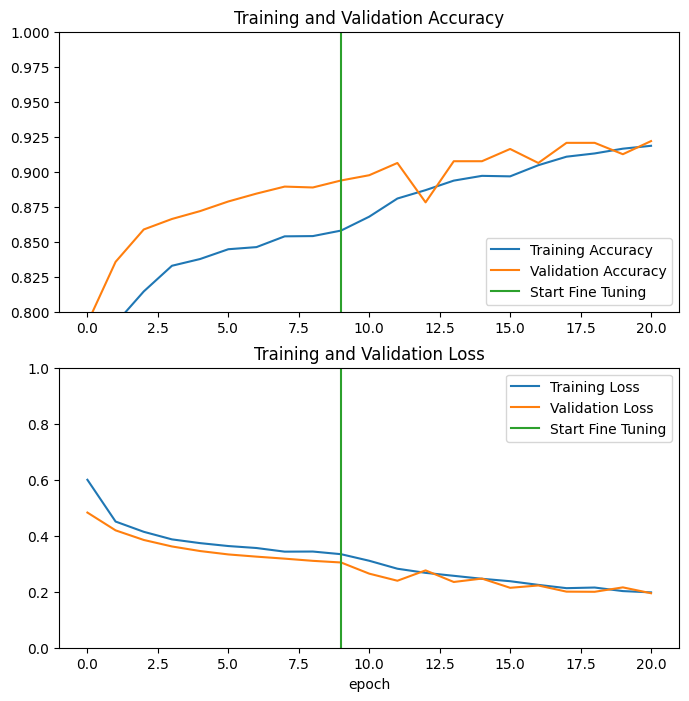

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We can see the validation accuracy drop towards the 19th epoch whereas the training one gets higher, so we might be starting to overfit the model. That may be due to the fact that our training set is quite small compared to the imagenet on which the `base_model` was trained.

In [47]:
model.save('ResNet50V2-Melanoma-FineTune-CNN.keras')

## Evaluation and prediction

We can check the performance of the model with our `test_ds` to check how it performs with new data.

In [29]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

13/13 [==============================] - 4s 296ms/step - loss: 0.2482 - accuracy: 0.9000
Test accuracy : 0.8999999761581421


And now let's see it make some predictions in action. We make sure to have all the predictions, labels and images in one cell to avoid the shuffling of images and labels.

In [32]:
y_test     = np.array([])
pred_test  = np.array([])
all_images = []

for x , y in test_ds:
  y_test     = np.concatenate([y_test, y])
  pred_test  = np.concatenate([pred_test, model.predict(x, verbose=0).reshape(-1,)])
  all_images.append(x)

In [33]:
test_images = np.concatenate(all_images)
test_images.shape

(400, 224, 224, 3)

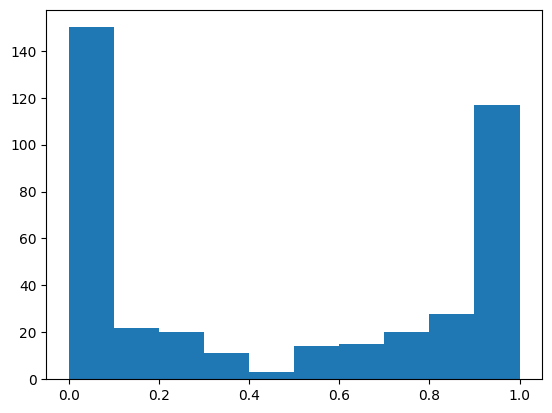

In [34]:
plt.hist(pred_test)
plt.show()

As we are doing binary classification we only need two classes for the results:

In [35]:
predictions = np.where(pred_test >0.5,1,0).reshape(-1,)

In [37]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90       200
         1.0       0.91      0.89      0.90       200

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



# <div align="center" style="padding: 10px; font-weight: bold;">Confusion matrix</div>

To better compare the predictions and labels we will use a confusion matrix.

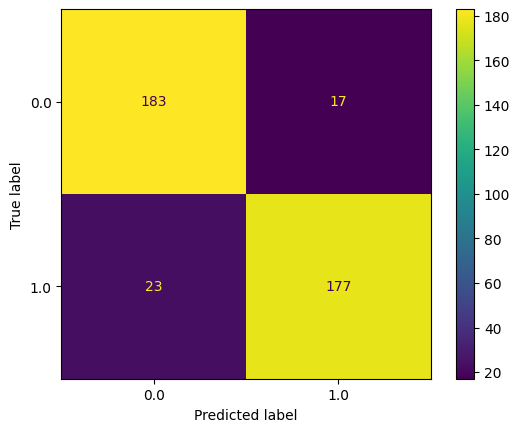

In [40]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show()

Let's also look at some of the misclassified images:

In [41]:
misclass = y_test !=predictions

In [42]:
misclassified_images = [i for i, x in enumerate(misclass) if x==True]
misclassified_images[:10]

[12, 14, 31, 42, 48, 60, 68, 69, 72, 82]

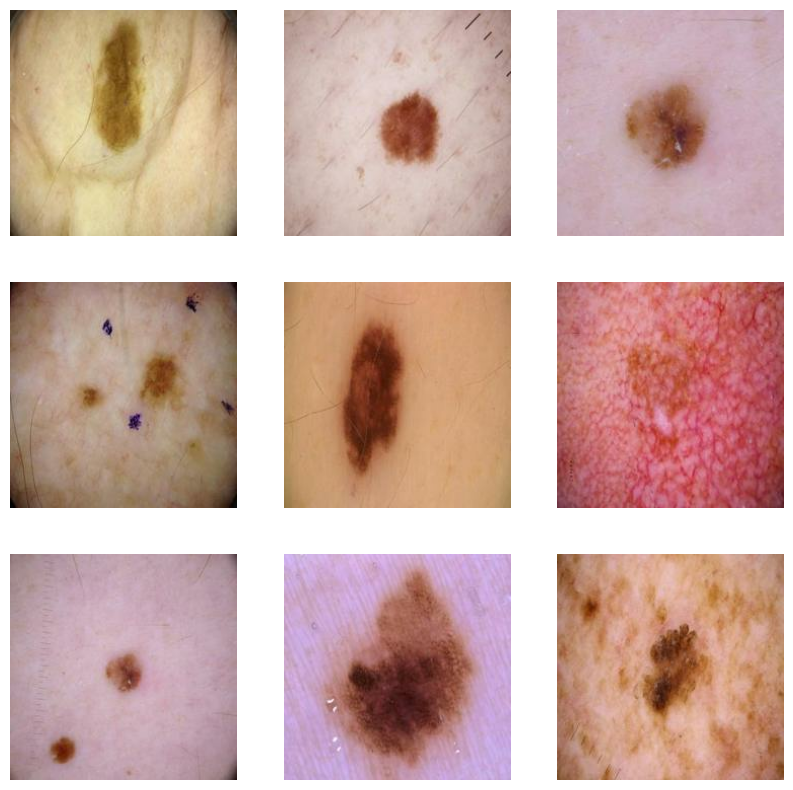

In [48]:
plt.figure(figsize=(10,10))
for i , number in enumerate(misclassified_images[:9]):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(test_images[number].astype("uint8"))
  plt.axis("off")
plt.show()

# <div align="center" style="padding: 10px; font-weight: bold;">Conclusion</div>

From the confusion matrix we can compare predictions to labels and see how many are wrong. From the results we can see that the model has a 90% accuracy and gave false predictions for only 40 out of the 400 test samples.

The models performance was somewhat good when freezing all layers of the `base_model` but further improved with the fine tuning until it started overfitting towards the end.
We might get better results if we retrain a larger amount of higher `base_model` layers.

# <div align="center" style="padding: 10px; font-weight: bold;">References</div>

🔬Melanoma Cancer Image Dataset. (2024, February 18). Kaggle. https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset

Leo, M. S. (2022, March 19). How to choose the best Keras Pre-Trained Model for image Classification. Medium. https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4

Brownlee, J. (2019b, September 16). A gentle introduction to transfer learning for deep learning. MachineLearningMastery.com. https://machinelearningmastery.com/transfer-learning-for-deep-learning/

Brownlee, J. (2020, August 18). Transfer Learning in Keras with Computer Vision Models. MachineLearningMastery.com. https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

Load and preprocess images. (n.d.). TensorFlow. https://www.tensorflow.org/tutorials/load_data/images

Module: tf.keras.applications.resnet_v2. (n.d.). TensorFlow. https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2

Sagar, A. (2020). Convolutional neural networks for classifying melanoma images. bioRxiv (Cold Spring Harbor Laboratory). https://doi.org/10.1101/2020.05.22.110973

Transfer learning and fine-tuning. (n.d.). TensorFlow. https://www.tensorflow.org/tutorials/images/transfer_learning